# Assignment-19 

## Image Generator Using DC-GAN

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    os.chdir('/content')
    if not os.path.isdir('/content/EVA-2-Group/'):
        !git clone https://github.com/sambitdash/EVA-2-Group.git
    os.chdir('/content/EVA-2-Group/Session-19')
    !pwd
    
    !git config user.email "sambitdash@gmail.com"
    !git config user.name "Sambit Kumar Dash"
    !git config user.password "your password"
    !git status

## Image Collection

A set of car images are collected from Google. Three category of cars sedan, SUV and Hatchbacks were selected with only side view with the intention of implementing a AC-GAN but due to complexity of the convergence simple DC-GAN architecture was decided. 

The images are scaled to fit $64\times64$. 

In [2]:
import cv2
import os
import numpy as np
from os import listdir
from os.path import join

car_types = ['hatch', 'sedan', 'suv']

def resize_image(img, size=(64,64)):

    h, w = img.shape[:2]

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        c = img.shape[2]
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

spath, dpath = join('data', 'cars'), join('data', 'norm')

if not os.path.isdir(dpath):
    os.mkdir(dpath)

imgs = {}


for ct in car_types:
    sp, dp = join(spath, ct), join(dpath, ct)
    alen = 1024
    imgs[ct] = np.zeros((1024, 64, 64, 3))
    if not os.path.isdir(dp):
        os.mkdir(dp)
    tlen = 0
    for f in listdir(sp):
        sf, df = join(sp, f), join(dp, f)
        img = cv2.imread(sf)
        img = resize_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tlen += 1
        if tlen > alen:
            imgs[ct] = np.append(imgs[ct], np.zeros((1024, 64, 64, 3)))
            alen += 1024
        imgs[ct][tlen-1] = img
    imgs[ct] = imgs[ct][:tlen]
    print(imgs[ct].shape)

(332, 64, 64, 3)
(410, 64, 64, 3)
(337, 64, 64, 3)


## Image Standardization

The images are standardized to have pixel ranges from [-1, 1]. This is to ensure they are not fitting to the generator convention that follows a $tanh$ activation.

In [3]:
#%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

from tensorflow.keras import utils 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainx, testx = imgs['hatch'][:300,:,:,:], imgs['hatch'][300:,:,:,:]

trainy, testy = np.zeros(trainx.shape[0], dtype=float), np.zeros(testx.shape[0], dtype=float)

trainx = np.append(trainx, imgs['sedan'][:375,:,:,:], axis=0)
testx = np.append(testx, imgs['sedan'][375:,:,:,:], axis=0)

ltrain, ltest = trainx.shape[0] - trainy.shape[0], testx.shape[0] - testy.shape[0]

trainy, testy = np.append(trainy, np.ones(ltrain, dtype=float)), np.append(testy, np.ones(ltest, dtype=float))


print(trainx.shape, "y", trainy.shape)
print(testx.shape, 'y', testy.shape)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(trainx)

trainX, trainY = trainx, trainy
testX, testY   = testx, testy

for i in range(0):
    iterate = datagen.flow(trainx, trainy, batch_size=len(trainx), shuffle=True)
    x, y = iterate.next()
    trainX, trainY = np.append(trainX, x, axis=0), np.append(trainY, y, axis=0)

for i in range(0):
    iterate = datagen.flow(testx, testy, batch_size=len(testx), shuffle=True)
    x, y = iterate.next()
    testX, testY = np.append(testX, x, axis=0), np.append(testY, y, axis=0)


print(trainX.shape, "y", trainY.shape)
print(testX.shape, "y", testY.shape)

trainx, trainy = trainX, trainY
testx, testy   = testX, testY

trainx = trainx.astype('float32') / 255
testx  = testx.astype('float32') / 255

trainx_mean = np.mean(trainx, axis=(0, 1, 2))
trainx_std  = np.std(trainx, axis=(0, 1, 2))

print(trainx_mean, trainx_std)

trainx -= trainx_mean
trainx /= trainx_std

testx -= trainx_mean
testx /= trainx_std

trainX, trainY = trainx, trainy #utils.to_binary(trainy)
testX,  testY  = testx,  testy  #utils.to_binary(testy)

min_pix, max_pix = trainX.min(), trainX.max()

def align_image(x):
    min_pix, max_pix = x.min(), x.max()
    rx = x / ((max_pix-min_pix)/2.0)
    rx -= (rx.min()+1.0)
    return rx

trainX = align_image(trainX)
testX  = align_image(testX)

print(trainX.min(), trainX.max())
print(testX.min(), testX.max())

print(trainX.shape, trainY.shape)

/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

1.14.0
(675, 64, 64, 3) y (675,)
(67, 64, 64, 3) y (67,)
(675, 64, 64, 3) y (675,)
(67, 64, 64, 3) y (67,)
[0.35301414 0.34561545 0.34175763] [0.3740168  0.37273017 0.37292084]
-1.0 1.0
-1.0 1.0
(675, 64, 64, 3) (675,)


## DCGAN Design

Deep convolution GAN is a simple convolution network that learns the complexities of image features and regenerates images. The GAN is composed of 2 components.

1. Discriminator
2. Generator

The discriminator is trained to distinguish between, real and fake. While the generator is trained to create such images that can pass through the discriminator's judgement. The adversial nature of training leads to creation of new patterns of images.

The code used here is a modification of code at: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

## Discriminator 

The discriminator is a simple sequential convolution network of $3x3$ kernels with LeakyReLU. LeakyReLU is suggested as it has better smoothening properties. 


In [4]:
# Code from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

# example of defining the discriminator model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

L2_REG=1e-3

def l2_weights(model):
    l2 = 0
    for layer in model.layers: 
        if isinstance(layer, Model):
            continue
        wts = layer.weights
        if len(wts) > 0:
            for wt in wts:
                l2 += K.sum(wt*wt)
    return l2

def l2_loss(model, f):
    def loss(yt, yp):
        return f(yt, yp) + L2_REG*l2_weights(model)
    return loss

bce = lambda yt, yp: binary_crossentropy(yt, yp, label_smoothing=0.1)

# define the standalone discriminator model
def define_discriminator(in_shape=(64, 64,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))    
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=l2_loss(model, bce), optimizer=opt, metrics=['binary_accuracy'])
    return model
 
# define model
model = define_discriminator()
# summarize the model
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       147584    
__________________________________________

### Training Discriminators

Discriminators are standalone networks and can be independently trained as well with real and fake images. Fake images in this context can be natural random images. However, such training must be minimal to just oovercome initial bias towards setting all values to zeros. But discriminant must be trained with the generator and should not be over trained. If it's then generator will find it harder to generate images to bypass discriminator.

In [5]:
from numpy.random import rand, randint
from numpy import zeros, ones

def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], (n_samples,))
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y


# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    X = rand(64 * 64 * 3 * n_samples)
    X = -1 + X * 2
    X = X.reshape((n_samples, 64, 64, 3))
    y = zeros((n_samples, 1))
    return X, y

# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        real_res = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        fake_res = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%3d  real=%5.0f%% fake=%5.0f%%' % (i+1, real_res[1]*100, fake_res[1]*100))
        
train_discriminator(model, trainX) 

>  1  real=   78% fake=    0%
>  2  real=  100% fake=    0%
>  3  real=  100% fake=    0%
>  4  real=  100% fake=    8%
>  5  real=  100% fake=   62%
>  6  real=   95% fake=  100%
>  7  real=   95% fake=  100%
>  8  real=  100% fake=  100%
>  9  real=   97% fake=  100%
> 10  real=   98% fake=  100%
> 11  real=   97% fake=  100%
> 12  real=  100% fake=  100%
> 13  real=   97% fake=  100%
> 14  real=  100% fake=  100%
> 15  real=   98% fake=  100%
> 16  real=  100% fake=  100%
> 17  real=  100% fake=  100%
> 18  real=  100% fake=  100%
> 19  real=   98% fake=  100%
> 20  real=  100% fake=  100%


## Generator

Generator takes a latent dimension vector and applies the inverse operation of transposed convolution and LeakyReLU to arrive at the images. Normally a larger kernel is used for convolutions. Here (4,4) is used though several texts have suggested 5x5. 

In [6]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))    
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model
 
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)      

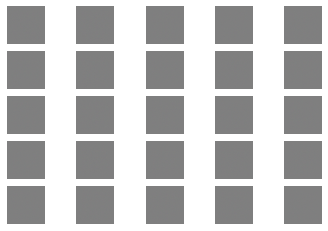

In [7]:
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
    # define subplot
    pyplot.subplot(5, 5, 1 + i)
    # turn off axis labels
    pyplot.axis('off')
    # plot single image
    pyplot.imshow(X[i])
# show the figure
pyplot.show()

### Training Generators

Generator is trained as a dependent network of a discriminator. The GAN training network takes the latent vector as input and generates images through generator. The output of the generator is fed into the discriminator and generator is trained with the image be passed through the discriminator as a valid input. Since, the discriminator component is marked untrainable, the generator trains itself on generating better images that can pass through the discriminator.

The `binary_crossentropy` loss is used. However, the L2-regularization is added to overcome mode collapse. The size of the latent vector also drives setting up the number of modes in the network.

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=l2_loss(model, bce), optimizer=opt, metrics=['acc'])
    return model

In [9]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 64, 64, 3)         1728387   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 670081    
Total params: 2,398,468
Trainable params: 1,728,387
Non-trainable params: 670,081
_________________________________________________________________


In [10]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

## Training of GAN

The training is not carried out with standard epoch based method but carried out in single batches of alternate discriminator and generator. To be noted here, there is a potential of the network getting overfitted to one side and rejecting all fakes and thus make the training of the network extremely hard. To avoid this we introduce 5% errors in the data itself. Moreover label smoothing is carried out in the binary entropy calculation to avoid strong biases towards zeros or ones. 

The images are generated in every 200 iterations and saved for comparison. 

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            y_real[randint(0, half_batch, (3,))] = 0.0
            d_res1 = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            y_fake[randint(0, half_batch, (3,))] = 1.0
            d_res2 = d_model.train_on_batch(X_fake, y_fake)
                
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            y_gan[randint(0, half_batch, (6,))] = 0
            g_res = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%10.4e, d2=%10.4e g=%10.4e' %
                  (i+1, j+1, bat_per_epo, d_res1[0], d_res2[0], g_res[0]))
        if i%200 == 199:
            summarize_performance(i, g_model, d_model, dataset, latent_dim, n_samples=150)

In [12]:
def save_plot(examples, epoch, n=12):
    target = 1000
    dpi=72
    margin=0.1
    size = target/((1.-2*margin)*dpi)
    fig = pyplot.figure(figsize=(size, size), dpi=dpi)
    fig.subplots_adjust(left=margin, right=1.-margin, wspace = 0.01, hspace=0.01)
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])

    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [ ]:
latent_dim = 256
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = trainX
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, 10000)

>1, 1/5, d1=1.2059e+00, d2=1.2136e+00 g=6.9235e-01
>1, 2/5, d1=1.0971e+00, d2=1.2103e+00 g=6.9230e-01
>1, 3/5, d1=9.9260e-01, d2=1.2089e+00 g=6.9103e-01
>1, 4/5, d1=8.8345e-01, d2=1.2119e+00 g=6.8585e-01
>1, 5/5, d1=7.9875e-01, d2=1.2216e+00 g=6.7658e-01
>2, 1/5, d1=8.2939e-01, d2=1.2307e+00 g=6.7120e-01
>2, 2/5, d1=8.1271e-01, d2=1.2398e+00 g=6.6802e-01
>2, 3/5, d1=8.2435e-01, d2=1.2473e+00 g=6.7723e-01
>2, 4/5, d1=8.0757e-01, d2=1.2119e+00 g=7.3432e-01
>2, 5/5, d1=8.3556e-01, d2=1.1418e+00 g=8.0080e-01
>3, 1/5, d1=8.1064e-01, d2=1.1117e+00 g=8.2434e-01
>3, 2/5, d1=8.2613e-01, d2=1.1192e+00 g=7.7172e-01
>3, 3/5, d1=8.3638e-01, d2=1.1344e+00 g=7.3766e-01
>3, 4/5, d1=7.8977e-01, d2=1.1412e+00 g=7.2261e-01
>3, 5/5, d1=8.5847e-01, d2=1.1417e+00 g=7.1710e-01
>4, 1/5, d1=7.8581e-01, d2=1.1376e+00 g=7.1750e-01
>4, 2/5, d1=7.8331e-01, d2=1.1305e+00 g=7.2210e-01
>4, 3/5, d1=7.9831e-01, d2=1.1226e+00 g=7.2786e-01
>4, 4/5, d1=7.7234e-01, d2=1.1122e+00 g=7.3640e-01
>4, 5/5, d1=7.4333e-01, d2=1.10

>31, 4/5, d1=9.0110e-01, d2=1.0717e+00 g=1.3003e+00
>31, 5/5, d1=1.0224e+00, d2=1.1036e+00 g=9.5980e-01
>32, 1/5, d1=1.0057e+00, d2=9.7912e-01 g=9.7856e-01
>32, 2/5, d1=7.9348e-01, d2=8.5990e-01 g=1.2731e+00
>32, 3/5, d1=8.4988e-01, d2=8.1037e-01 g=1.4533e+00
>32, 4/5, d1=8.4872e-01, d2=7.6533e-01 g=1.5111e+00
>32, 5/5, d1=8.0785e-01, d2=8.1543e-01 g=1.4725e+00
>33, 1/5, d1=8.1318e-01, d2=9.0488e-01 g=1.4332e+00
>33, 2/5, d1=1.0258e+00, d2=8.7708e-01 g=1.4208e+00
>33, 3/5, d1=1.0730e+00, d2=8.6065e-01 g=1.5538e+00
>33, 4/5, d1=1.0702e+00, d2=7.9681e-01 g=1.5167e+00
>33, 5/5, d1=9.0240e-01, d2=8.0662e-01 g=1.4514e+00
>34, 1/5, d1=8.8077e-01, d2=8.5443e-01 g=1.3610e+00
>34, 2/5, d1=8.5429e-01, d2=8.7994e-01 g=1.1835e+00
>34, 3/5, d1=8.8720e-01, d2=8.9674e-01 g=1.1818e+00
>34, 4/5, d1=9.3956e-01, d2=8.5606e-01 g=1.2449e+00
>34, 5/5, d1=7.8460e-01, d2=7.7873e-01 g=1.4340e+00
>35, 1/5, d1=8.4634e-01, d2=7.4834e-01 g=1.5283e+00
>35, 2/5, d1=8.5594e-01, d2=7.3391e-01 g=1.6180e+00
>35, 3/5, d1

>63, 2/5, d1=7.7832e-01, d2=7.5947e-01 g=1.7305e+00
>63, 3/5, d1=7.6651e-01, d2=8.2195e-01 g=1.6666e+00
>63, 4/5, d1=8.4350e-01, d2=8.3572e-01 g=1.6789e+00
>63, 5/5, d1=8.0532e-01, d2=7.4957e-01 g=1.6133e+00
>64, 1/5, d1=7.9340e-01, d2=7.8722e-01 g=1.5533e+00
>64, 2/5, d1=7.5877e-01, d2=7.6911e-01 g=1.5943e+00
>64, 3/5, d1=7.3609e-01, d2=7.7454e-01 g=1.6006e+00
>64, 4/5, d1=8.0365e-01, d2=7.3468e-01 g=1.6864e+00
>64, 5/5, d1=8.6759e-01, d2=7.6055e-01 g=1.5442e+00
>65, 1/5, d1=7.7545e-01, d2=8.0881e-01 g=1.7700e+00
>65, 2/5, d1=8.5720e-01, d2=7.4699e-01 g=1.7441e+00
>65, 3/5, d1=8.0779e-01, d2=8.1386e-01 g=1.7592e+00
>65, 4/5, d1=9.0072e-01, d2=7.7547e-01 g=1.6280e+00
>65, 5/5, d1=8.6879e-01, d2=7.9073e-01 g=1.8246e+00
>66, 1/5, d1=8.5310e-01, d2=7.2163e-01 g=1.7790e+00
>66, 2/5, d1=8.0044e-01, d2=8.1857e-01 g=1.8373e+00
>66, 3/5, d1=8.3837e-01, d2=7.6021e-01 g=1.7245e+00
>66, 4/5, d1=8.3560e-01, d2=8.7631e-01 g=2.0401e+00
>66, 5/5, d1=8.7204e-01, d2=7.1941e-01 g=2.2714e+00
>67, 1/5, d1

>94, 5/5, d1=6.9478e-01, d2=6.3775e-01 g=2.1598e+00
>95, 1/5, d1=6.6429e-01, d2=6.4293e-01 g=2.2749e+00
>95, 2/5, d1=6.8302e-01, d2=6.5002e-01 g=2.3218e+00
>95, 3/5, d1=7.1369e-01, d2=6.5780e-01 g=2.3886e+00
>95, 4/5, d1=7.2888e-01, d2=6.8074e-01 g=2.4054e+00
>95, 5/5, d1=7.2609e-01, d2=7.0776e-01 g=2.3375e+00
>96, 1/5, d1=6.7090e-01, d2=6.6460e-01 g=2.4637e+00
>96, 2/5, d1=7.8013e-01, d2=8.1672e-01 g=2.5029e+00
>96, 3/5, d1=8.1970e-01, d2=7.2287e-01 g=2.4369e+00
>96, 4/5, d1=8.5214e-01, d2=7.1832e-01 g=2.3153e+00
>96, 5/5, d1=7.0062e-01, d2=6.5302e-01 g=2.2918e+00
>97, 1/5, d1=7.2531e-01, d2=7.4813e-01 g=2.1919e+00
>97, 2/5, d1=8.0261e-01, d2=6.9507e-01 g=2.2552e+00
>97, 3/5, d1=8.5126e-01, d2=7.2350e-01 g=2.0970e+00
>97, 4/5, d1=7.4170e-01, d2=7.3671e-01 g=1.9366e+00
>97, 5/5, d1=8.5343e-01, d2=7.7904e-01 g=1.9354e+00
>98, 1/5, d1=7.4674e-01, d2=6.6797e-01 g=1.9899e+00
>98, 2/5, d1=8.1130e-01, d2=7.2976e-01 g=2.0615e+00
>98, 3/5, d1=7.9051e-01, d2=7.0143e-01 g=2.3226e+00
>98, 4/5, d1

>126, 1/5, d1=7.1096e-01, d2=6.0768e-01 g=2.5997e+00
>126, 2/5, d1=7.1462e-01, d2=6.2009e-01 g=2.3344e+00
>126, 3/5, d1=7.0392e-01, d2=6.9643e-01 g=2.6176e+00
>126, 4/5, d1=7.2213e-01, d2=6.3306e-01 g=2.7365e+00
>126, 5/5, d1=7.2959e-01, d2=6.1966e-01 g=2.6591e+00
>127, 1/5, d1=6.6833e-01, d2=6.2149e-01 g=2.3925e+00
>127, 2/5, d1=7.5700e-01, d2=6.8584e-01 g=2.7058e+00
>127, 3/5, d1=7.0512e-01, d2=6.2225e-01 g=2.3465e+00
>127, 4/5, d1=7.0757e-01, d2=6.7613e-01 g=3.3416e+00
>127, 5/5, d1=7.4329e-01, d2=6.3246e-01 g=2.3045e+00
>128, 1/5, d1=6.7905e-01, d2=7.8881e-01 g=3.6058e+00
>128, 2/5, d1=8.2958e-01, d2=6.0265e-01 g=2.3924e+00
>128, 3/5, d1=7.3049e-01, d2=7.0157e-01 g=2.7502e+00
>128, 4/5, d1=7.0038e-01, d2=6.1965e-01 g=2.4091e+00
>128, 5/5, d1=6.7895e-01, d2=6.7341e-01 g=2.8162e+00
>129, 1/5, d1=8.2051e-01, d2=6.2855e-01 g=2.6592e+00
>129, 2/5, d1=6.3575e-01, d2=6.2911e-01 g=2.5368e+00
>129, 3/5, d1=7.0085e-01, d2=7.1438e-01 g=2.9019e+00
>129, 4/5, d1=8.2222e-01, d2=6.4097e-01 g=2.27

>157, 1/5, d1=7.1264e-01, d2=6.0118e-01 g=2.3678e+00
>157, 2/5, d1=6.4732e-01, d2=6.8270e-01 g=2.1150e+00
>157, 3/5, d1=7.6595e-01, d2=7.1141e-01 g=1.7667e+00
>157, 4/5, d1=8.2115e-01, d2=7.8953e-01 g=1.7730e+00
>157, 5/5, d1=7.4700e-01, d2=6.5023e-01 g=2.0447e+00
>158, 1/5, d1=7.3566e-01, d2=6.1669e-01 g=1.9536e+00
>158, 2/5, d1=5.6537e-01, d2=6.3012e-01 g=2.0328e+00
>158, 3/5, d1=6.5423e-01, d2=6.2511e-01 g=2.1188e+00
>158, 4/5, d1=6.2985e-01, d2=6.1963e-01 g=2.2272e+00
>158, 5/5, d1=7.0760e-01, d2=6.7802e-01 g=2.2822e+00
>159, 1/5, d1=6.6479e-01, d2=6.4090e-01 g=2.2142e+00
>159, 2/5, d1=6.6927e-01, d2=6.1947e-01 g=1.7952e+00
>159, 3/5, d1=6.7206e-01, d2=6.7153e-01 g=2.3551e+00
>159, 4/5, d1=7.0612e-01, d2=6.0066e-01 g=2.1771e+00
>159, 5/5, d1=6.2273e-01, d2=6.5563e-01 g=1.9562e+00
>160, 1/5, d1=7.3650e-01, d2=6.6442e-01 g=2.4737e+00
>160, 2/5, d1=7.1903e-01, d2=5.8224e-01 g=2.2139e+00
>160, 3/5, d1=7.4598e-01, d2=7.1826e-01 g=2.0668e+00
>160, 4/5, d1=6.8327e-01, d2=6.1767e-01 g=2.08

>188, 1/5, d1=5.9820e-01, d2=6.0600e-01 g=2.3942e+00
>188, 2/5, d1=6.6345e-01, d2=5.9196e-01 g=2.2196e+00
>188, 3/5, d1=5.9723e-01, d2=5.8303e-01 g=2.6260e+00
>188, 4/5, d1=6.0350e-01, d2=5.6813e-01 g=2.1275e+00
>188, 5/5, d1=6.1567e-01, d2=5.8004e-01 g=2.1951e+00
>189, 1/5, d1=6.4894e-01, d2=5.9042e-01 g=2.6414e+00
>189, 2/5, d1=6.7502e-01, d2=5.6972e-01 g=2.2115e+00
>189, 3/5, d1=6.5274e-01, d2=5.9563e-01 g=2.6257e+00
>189, 4/5, d1=6.3904e-01, d2=5.8605e-01 g=2.4620e+00
>189, 5/5, d1=6.5964e-01, d2=5.8284e-01 g=2.4572e+00
>190, 1/5, d1=5.8184e-01, d2=5.6159e-01 g=2.4991e+00
>190, 2/5, d1=6.5631e-01, d2=5.9077e-01 g=2.5386e+00
>190, 3/5, d1=6.1809e-01, d2=5.8713e-01 g=2.2631e+00
>190, 4/5, d1=6.1833e-01, d2=6.0864e-01 g=2.9638e+00
>190, 5/5, d1=6.8329e-01, d2=5.8308e-01 g=2.3156e+00
>191, 1/5, d1=6.9310e-01, d2=7.4943e-01 g=2.8867e+00
>191, 2/5, d1=7.0470e-01, d2=5.5296e-01 g=2.1608e+00
>191, 3/5, d1=6.2738e-01, d2=8.1692e-01 g=3.7799e+00
>191, 4/5, d1=8.7322e-01, d2=5.5807e-01 g=2.24

>218, 5/5, d1=5.7462e-01, d2=6.1408e-01 g=2.2698e+00
>219, 1/5, d1=7.6581e-01, d2=6.7673e-01 g=2.1173e+00
>219, 2/5, d1=6.7625e-01, d2=6.5823e-01 g=2.2315e+00
>219, 3/5, d1=7.0757e-01, d2=5.9546e-01 g=2.2411e+00
>219, 4/5, d1=6.8658e-01, d2=6.3810e-01 g=2.1611e+00
>219, 5/5, d1=5.9608e-01, d2=6.1354e-01 g=2.4206e+00
>220, 1/5, d1=7.2307e-01, d2=6.1078e-01 g=2.3579e+00
>220, 2/5, d1=5.7421e-01, d2=5.9748e-01 g=2.3988e+00
>220, 3/5, d1=6.9452e-01, d2=6.0953e-01 g=2.5453e+00
>220, 4/5, d1=7.5052e-01, d2=6.2685e-01 g=2.8229e+00
>220, 5/5, d1=7.1312e-01, d2=5.4056e-01 g=2.3037e+00
>221, 1/5, d1=6.1009e-01, d2=6.5117e-01 g=2.7310e+00
>221, 2/5, d1=6.9715e-01, d2=5.8578e-01 g=2.6987e+00
>221, 3/5, d1=6.4939e-01, d2=6.2914e-01 g=2.9347e+00
>221, 4/5, d1=6.7415e-01, d2=5.8382e-01 g=2.4209e+00
>221, 5/5, d1=6.3935e-01, d2=6.1773e-01 g=2.5699e+00
>222, 1/5, d1=7.0045e-01, d2=5.8066e-01 g=2.3682e+00
>222, 2/5, d1=6.5097e-01, d2=5.6438e-01 g=2.2371e+00
>222, 3/5, d1=6.6138e-01, d2=6.0957e-01 g=2.37

>249, 5/5, d1=5.3598e-01, d2=5.3392e-01 g=2.2662e+00
>250, 1/5, d1=5.5009e-01, d2=5.3493e-01 g=2.2800e+00
>250, 2/5, d1=4.6436e-01, d2=5.3147e-01 g=2.3182e+00
>250, 3/5, d1=5.9814e-01, d2=5.0884e-01 g=2.3688e+00
>250, 4/5, d1=5.7717e-01, d2=5.3858e-01 g=2.2312e+00
>250, 5/5, d1=5.4315e-01, d2=5.4071e-01 g=2.3858e+00
>251, 1/5, d1=5.5062e-01, d2=5.0991e-01 g=2.2115e+00
>251, 2/5, d1=5.2422e-01, d2=5.2085e-01 g=2.3451e+00
>251, 3/5, d1=5.8657e-01, d2=5.2699e-01 g=2.2316e+00
>251, 4/5, d1=5.3194e-01, d2=5.1878e-01 g=2.2916e+00
>251, 5/5, d1=5.1554e-01, d2=5.2098e-01 g=2.2946e+00
>252, 1/5, d1=5.3672e-01, d2=5.2467e-01 g=2.2144e+00
>252, 2/5, d1=5.1887e-01, d2=5.3584e-01 g=2.2371e+00
>252, 3/5, d1=5.4689e-01, d2=5.1851e-01 g=2.3106e+00
>252, 4/5, d1=5.3858e-01, d2=5.3180e-01 g=2.2297e+00
>252, 5/5, d1=5.2373e-01, d2=5.2508e-01 g=2.3661e+00
>253, 1/5, d1=5.7037e-01, d2=5.2694e-01 g=2.2990e+00
>253, 2/5, d1=5.8028e-01, d2=5.2382e-01 g=2.1716e+00
>253, 3/5, d1=5.8056e-01, d2=5.4725e-01 g=2.25

>280, 5/5, d1=6.5661e-01, d2=6.2334e-01 g=2.1406e+00
>281, 1/5, d1=7.2089e-01, d2=6.1091e-01 g=2.0669e+00
>281, 2/5, d1=5.9705e-01, d2=5.6140e-01 g=2.1558e+00
>281, 3/5, d1=6.4746e-01, d2=5.9020e-01 g=2.1039e+00
>281, 4/5, d1=6.5380e-01, d2=6.1394e-01 g=2.2787e+00
>281, 5/5, d1=6.5504e-01, d2=5.7357e-01 g=2.1083e+00
>282, 1/5, d1=5.6733e-01, d2=5.4642e-01 g=1.9431e+00
>282, 2/5, d1=5.9849e-01, d2=5.9987e-01 g=1.8094e+00
>282, 3/5, d1=6.2964e-01, d2=5.9060e-01 g=1.8745e+00
>282, 4/5, d1=6.0232e-01, d2=6.3232e-01 g=2.0334e+00
>282, 5/5, d1=6.6961e-01, d2=6.0396e-01 g=2.0306e+00
>283, 1/5, d1=7.3565e-01, d2=6.4001e-01 g=1.8988e+00
>283, 2/5, d1=5.5790e-01, d2=6.0316e-01 g=2.0388e+00
>283, 3/5, d1=6.2258e-01, d2=5.7204e-01 g=2.1184e+00
>283, 4/5, d1=7.5192e-01, d2=6.8206e-01 g=2.2588e+00
>283, 5/5, d1=6.1643e-01, d2=5.0799e-01 g=2.3372e+00
>284, 1/5, d1=6.1353e-01, d2=6.3535e-01 g=2.5167e+00
>284, 2/5, d1=6.5074e-01, d2=5.7880e-01 g=2.2510e+00
>284, 3/5, d1=5.7637e-01, d2=5.6217e-01 g=2.43

>311, 5/5, d1=5.1082e-01, d2=5.6179e-01 g=2.3452e+00
>312, 1/5, d1=5.8125e-01, d2=5.8103e-01 g=2.2606e+00
>312, 2/5, d1=6.0796e-01, d2=6.1034e-01 g=2.1808e+00
>312, 3/5, d1=5.7225e-01, d2=5.4179e-01 g=2.2625e+00
>312, 4/5, d1=6.4816e-01, d2=6.0356e-01 g=1.9667e+00
>312, 5/5, d1=5.7603e-01, d2=6.0276e-01 g=2.2460e+00
>313, 1/5, d1=7.4565e-01, d2=6.0761e-01 g=2.0808e+00
>313, 2/5, d1=5.9412e-01, d2=5.4580e-01 g=2.1036e+00
>313, 3/5, d1=5.6367e-01, d2=5.8155e-01 g=1.9616e+00
>313, 4/5, d1=6.5761e-01, d2=6.0078e-01 g=2.0651e+00
>313, 5/5, d1=5.8491e-01, d2=5.8413e-01 g=1.9717e+00
>314, 1/5, d1=6.7322e-01, d2=6.3660e-01 g=1.9447e+00
>314, 2/5, d1=6.5096e-01, d2=5.5089e-01 g=2.2974e+00
>314, 3/5, d1=7.4406e-01, d2=6.6295e-01 g=2.2944e+00
>314, 4/5, d1=6.6027e-01, d2=5.3127e-01 g=2.1818e+00
>314, 5/5, d1=5.6623e-01, d2=5.2963e-01 g=1.9702e+00
>315, 1/5, d1=6.8117e-01, d2=5.9870e-01 g=2.3128e+00
>315, 2/5, d1=5.8113e-01, d2=5.4299e-01 g=2.0759e+00
>315, 3/5, d1=5.8145e-01, d2=5.6451e-01 g=2.23

>342, 5/5, d1=5.1101e-01, d2=5.6707e-01 g=2.2016e+00
>343, 1/5, d1=5.9764e-01, d2=5.6988e-01 g=2.0989e+00
>343, 2/5, d1=4.9799e-01, d2=5.5249e-01 g=2.4325e+00
>343, 3/5, d1=6.5978e-01, d2=5.5181e-01 g=2.0367e+00
>343, 4/5, d1=5.5079e-01, d2=5.6381e-01 g=2.5483e+00
>343, 5/5, d1=6.1753e-01, d2=6.4437e-01 g=2.6081e+00
>344, 1/5, d1=6.9753e-01, d2=5.5427e-01 g=2.5588e+00
>344, 2/5, d1=6.7949e-01, d2=6.1186e-01 g=2.6658e+00
>344, 3/5, d1=6.0103e-01, d2=5.4123e-01 g=2.2963e+00
>344, 4/5, d1=5.9582e-01, d2=6.9060e-01 g=2.5840e+00
>344, 5/5, d1=6.7573e-01, d2=6.3597e-01 g=2.8499e+00
>345, 1/5, d1=7.0114e-01, d2=5.4817e-01 g=2.2261e+00
>345, 2/5, d1=6.4519e-01, d2=6.6620e-01 g=2.6918e+00
>345, 3/5, d1=7.8692e-01, d2=5.3416e-01 g=2.3558e+00
>345, 4/5, d1=6.4758e-01, d2=5.8550e-01 g=2.3990e+00
>345, 5/5, d1=6.1579e-01, d2=5.5503e-01 g=2.2805e+00
>346, 1/5, d1=5.3594e-01, d2=5.4169e-01 g=2.6338e+00
>346, 2/5, d1=6.5987e-01, d2=5.8254e-01 g=2.4773e+00
>346, 3/5, d1=6.8719e-01, d2=6.0473e-01 g=2.26

>373, 5/5, d1=6.2115e-01, d2=5.8851e-01 g=2.1687e+00
>374, 1/5, d1=6.4636e-01, d2=6.0184e-01 g=2.3992e+00
>374, 2/5, d1=6.2846e-01, d2=5.9942e-01 g=2.3981e+00
>374, 3/5, d1=6.2248e-01, d2=5.4513e-01 g=2.2183e+00
>374, 4/5, d1=5.6825e-01, d2=5.1559e-01 g=2.0700e+00
>374, 5/5, d1=6.6884e-01, d2=7.0829e-01 g=2.3299e+00
>375, 1/5, d1=6.6294e-01, d2=5.5261e-01 g=2.1611e+00
>375, 2/5, d1=6.0196e-01, d2=5.4949e-01 g=2.3093e+00
>375, 3/5, d1=5.8314e-01, d2=5.5388e-01 g=2.0390e+00
>375, 4/5, d1=5.5819e-01, d2=6.2978e-01 g=2.4927e+00
>375, 5/5, d1=5.5823e-01, d2=5.2786e-01 g=2.0960e+00
>376, 1/5, d1=6.3165e-01, d2=6.2033e-01 g=2.4026e+00
>376, 2/5, d1=7.0932e-01, d2=5.6387e-01 g=2.1564e+00
>376, 3/5, d1=5.8292e-01, d2=5.4030e-01 g=1.8194e+00
>376, 4/5, d1=6.3038e-01, d2=5.9864e-01 g=1.7809e+00
>376, 5/5, d1=5.9288e-01, d2=6.0171e-01 g=2.1053e+00
>377, 1/5, d1=5.9782e-01, d2=5.2320e-01 g=2.0592e+00
>377, 2/5, d1=6.1101e-01, d2=5.7849e-01 g=2.2434e+00
>377, 3/5, d1=5.9557e-01, d2=5.4402e-01 g=2.24

>404, 4/5, d1=6.3305e-01, d2=5.1617e-01 g=2.2397e+00
>404, 5/5, d1=5.9353e-01, d2=5.3236e-01 g=2.2517e+00
>405, 1/5, d1=5.5348e-01, d2=5.0657e-01 g=2.5042e+00
>405, 2/5, d1=5.9267e-01, d2=5.7593e-01 g=2.3814e+00
>405, 3/5, d1=5.3357e-01, d2=5.7482e-01 g=2.5816e+00
>405, 4/5, d1=6.0561e-01, d2=5.3321e-01 g=2.4717e+00
>405, 5/5, d1=5.8902e-01, d2=6.8982e-01 g=2.8838e+00
>406, 1/5, d1=6.2297e-01, d2=5.1168e-01 g=2.7278e+00
>406, 2/5, d1=5.9789e-01, d2=5.7988e-01 g=2.8294e+00
>406, 3/5, d1=6.1427e-01, d2=5.1915e-01 g=2.2131e+00
>406, 4/5, d1=5.7246e-01, d2=7.0277e-01 g=2.7942e+00
>406, 5/5, d1=7.9101e-01, d2=5.2123e-01 g=2.0414e+00
>407, 1/5, d1=5.3630e-01, d2=6.0330e-01 g=2.3865e+00
>407, 2/5, d1=5.5475e-01, d2=5.5491e-01 g=2.1806e+00
>407, 3/5, d1=5.4569e-01, d2=5.5096e-01 g=2.2505e+00
>407, 4/5, d1=5.8072e-01, d2=5.7744e-01 g=2.3609e+00
>407, 5/5, d1=5.8652e-01, d2=5.2030e-01 g=2.1051e+00
>408, 1/5, d1=6.2147e-01, d2=7.6254e-01 g=2.3204e+00
>408, 2/5, d1=5.9898e-01, d2=5.2105e-01 g=2.37

>435, 4/5, d1=6.4196e-01, d2=5.5530e-01 g=2.2807e+00
>435, 5/5, d1=5.7964e-01, d2=5.4025e-01 g=2.2455e+00
>436, 1/5, d1=4.8822e-01, d2=5.3586e-01 g=2.4814e+00
>436, 2/5, d1=5.5195e-01, d2=4.8362e-01 g=2.2238e+00
>436, 3/5, d1=6.1152e-01, d2=6.1272e-01 g=2.2738e+00
>436, 4/5, d1=5.7248e-01, d2=5.1361e-01 g=2.1563e+00
>436, 5/5, d1=5.1120e-01, d2=5.3265e-01 g=2.4772e+00
>437, 1/5, d1=5.6119e-01, d2=5.6565e-01 g=2.3637e+00
>437, 2/5, d1=6.0617e-01, d2=5.8517e-01 g=2.1925e+00
>437, 3/5, d1=5.6123e-01, d2=5.5854e-01 g=2.4398e+00
>437, 4/5, d1=6.3482e-01, d2=5.9729e-01 g=2.7288e+00
>437, 5/5, d1=6.6259e-01, d2=5.2845e-01 g=2.5855e+00
>438, 1/5, d1=6.5228e-01, d2=5.9732e-01 g=2.5140e+00
>438, 2/5, d1=5.8040e-01, d2=5.3195e-01 g=2.5765e+00
>438, 3/5, d1=6.0846e-01, d2=5.6491e-01 g=2.3988e+00
>438, 4/5, d1=6.3934e-01, d2=6.9047e-01 g=2.4600e+00
>438, 5/5, d1=6.2076e-01, d2=5.4660e-01 g=2.2360e+00
>439, 1/5, d1=5.8583e-01, d2=6.6326e-01 g=2.2804e+00
>439, 2/5, d1=6.6268e-01, d2=5.4006e-01 g=2.13

>466, 4/5, d1=6.4331e-01, d2=5.4341e-01 g=2.1917e+00
>466, 5/5, d1=5.7562e-01, d2=5.7109e-01 g=2.2770e+00
>467, 1/5, d1=5.6731e-01, d2=6.0932e-01 g=2.6729e+00
>467, 2/5, d1=6.1727e-01, d2=5.2241e-01 g=2.1058e+00
>467, 3/5, d1=5.6246e-01, d2=7.1258e-01 g=3.1150e+00
>467, 4/5, d1=6.8218e-01, d2=5.1678e-01 g=2.2527e+00
>467, 5/5, d1=6.1826e-01, d2=6.4139e-01 g=2.4814e+00
>468, 1/5, d1=6.6757e-01, d2=5.6983e-01 g=2.3335e+00
>468, 2/5, d1=6.6132e-01, d2=5.4742e-01 g=2.0986e+00
>468, 3/5, d1=6.1586e-01, d2=6.1283e-01 g=2.4247e+00
>468, 4/5, d1=5.9149e-01, d2=5.5720e-01 g=2.5247e+00
>468, 5/5, d1=5.9027e-01, d2=5.7178e-01 g=2.4500e+00
>469, 1/5, d1=5.6341e-01, d2=5.8992e-01 g=2.3434e+00
>469, 2/5, d1=6.1876e-01, d2=6.3496e-01 g=2.4523e+00
>469, 3/5, d1=5.7635e-01, d2=5.5192e-01 g=2.2750e+00
>469, 4/5, d1=5.2051e-01, d2=4.9983e-01 g=2.5209e+00
>469, 5/5, d1=5.8458e-01, d2=5.2448e-01 g=2.2016e+00
>470, 1/5, d1=5.2231e-01, d2=5.0337e-01 g=2.2875e+00
>470, 2/5, d1=5.7078e-01, d2=5.8523e-01 g=2.38

>497, 4/5, d1=6.4264e-01, d2=5.2845e-01 g=2.4208e+00
>497, 5/5, d1=5.6981e-01, d2=4.9176e-01 g=2.0142e+00
>498, 1/5, d1=5.5060e-01, d2=5.5974e-01 g=2.1175e+00
>498, 2/5, d1=5.6265e-01, d2=5.3606e-01 g=2.2765e+00
>498, 3/5, d1=5.9486e-01, d2=5.5149e-01 g=2.1128e+00
>498, 4/5, d1=5.9081e-01, d2=5.4288e-01 g=2.2522e+00
>498, 5/5, d1=5.0381e-01, d2=5.0491e-01 g=2.3858e+00
>499, 1/5, d1=5.6407e-01, d2=5.4141e-01 g=2.3100e+00
>499, 2/5, d1=5.2648e-01, d2=4.9271e-01 g=2.4244e+00
>499, 3/5, d1=5.7148e-01, d2=5.5111e-01 g=2.4603e+00
>499, 4/5, d1=5.9751e-01, d2=5.8105e-01 g=2.5820e+00
>499, 5/5, d1=5.8913e-01, d2=4.8638e-01 g=2.1308e+00
>500, 1/5, d1=5.6594e-01, d2=6.7143e-01 g=2.9864e+00
>500, 2/5, d1=5.9645e-01, d2=4.7519e-01 g=2.3935e+00
>500, 3/5, d1=5.0957e-01, d2=5.9134e-01 g=2.4774e+00
>500, 4/5, d1=6.8209e-01, d2=6.3462e-01 g=2.2042e+00
>500, 5/5, d1=6.1936e-01, d2=6.1682e-01 g=2.7729e+00
>501, 1/5, d1=5.9549e-01, d2=5.6178e-01 g=2.4686e+00
>501, 2/5, d1=6.5965e-01, d2=7.3756e-01 g=3.19

>528, 4/5, d1=6.1633e-01, d2=5.6822e-01 g=2.2474e+00
>528, 5/5, d1=5.4512e-01, d2=5.5681e-01 g=2.2543e+00
>529, 1/5, d1=6.0474e-01, d2=6.1899e-01 g=2.2119e+00
>529, 2/5, d1=5.8530e-01, d2=5.2372e-01 g=2.3365e+00
>529, 3/5, d1=6.2758e-01, d2=5.2906e-01 g=2.0469e+00
>529, 4/5, d1=6.1250e-01, d2=6.1679e-01 g=2.1441e+00
>529, 5/5, d1=5.8517e-01, d2=5.5218e-01 g=2.2670e+00
>530, 1/5, d1=6.2167e-01, d2=6.7237e-01 g=2.9649e+00
>530, 2/5, d1=6.5953e-01, d2=4.8243e-01 g=2.2195e+00
>530, 3/5, d1=5.9331e-01, d2=6.2810e-01 g=2.8463e+00
>530, 4/5, d1=7.0930e-01, d2=5.5261e-01 g=2.5845e+00
>530, 5/5, d1=6.4045e-01, d2=5.5781e-01 g=2.3006e+00
>531, 1/5, d1=6.0651e-01, d2=7.9625e-01 g=3.3023e+00
>531, 2/5, d1=8.2290e-01, d2=4.7378e-01 g=2.3830e+00
>531, 3/5, d1=6.3689e-01, d2=6.3693e-01 g=2.3920e+00
>531, 4/5, d1=7.8087e-01, d2=5.5446e-01 g=1.9913e+00
>531, 5/5, d1=5.2321e-01, d2=5.7571e-01 g=2.3016e+00
>532, 1/5, d1=6.7062e-01, d2=5.1144e-01 g=2.0534e+00
>532, 2/5, d1=5.1598e-01, d2=6.3573e-01 g=2.29

>559, 4/5, d1=5.9848e-01, d2=5.5301e-01 g=2.4064e+00
>559, 5/5, d1=5.9805e-01, d2=5.6619e-01 g=2.2551e+00
>560, 1/5, d1=5.6865e-01, d2=5.4750e-01 g=2.1686e+00
>560, 2/5, d1=5.4194e-01, d2=5.5852e-01 g=2.1582e+00
>560, 3/5, d1=6.1500e-01, d2=5.8929e-01 g=2.2959e+00
>560, 4/5, d1=5.9968e-01, d2=5.4870e-01 g=2.0948e+00
>560, 5/5, d1=5.4165e-01, d2=5.6980e-01 g=2.5597e+00
>561, 1/5, d1=6.0741e-01, d2=4.8140e-01 g=2.3601e+00
>561, 2/5, d1=5.8864e-01, d2=5.9764e-01 g=2.4665e+00
>561, 3/5, d1=6.2732e-01, d2=4.8190e-01 g=2.2813e+00
>561, 4/5, d1=5.6644e-01, d2=6.1398e-01 g=2.4302e+00
>561, 5/5, d1=6.1087e-01, d2=6.2357e-01 g=2.3427e+00
>562, 1/5, d1=5.4021e-01, d2=5.1216e-01 g=2.2971e+00
>562, 2/5, d1=6.9009e-01, d2=5.7861e-01 g=2.2264e+00
>562, 3/5, d1=5.1818e-01, d2=5.3819e-01 g=2.2552e+00
>562, 4/5, d1=5.9244e-01, d2=5.4716e-01 g=2.1603e+00
>562, 5/5, d1=5.4572e-01, d2=5.7674e-01 g=2.3736e+00
>563, 1/5, d1=6.2150e-01, d2=5.1423e-01 g=2.4866e+00
>563, 2/5, d1=6.0067e-01, d2=7.4666e-01 g=2.73

>590, 4/5, d1=6.1775e-01, d2=6.0605e-01 g=2.2119e+00
>590, 5/5, d1=5.9363e-01, d2=5.4025e-01 g=2.1973e+00
>591, 1/5, d1=6.7773e-01, d2=6.9033e-01 g=2.0354e+00
>591, 2/5, d1=5.7841e-01, d2=5.1996e-01 g=2.0685e+00
>591, 3/5, d1=5.9297e-01, d2=5.3911e-01 g=2.1059e+00
>591, 4/5, d1=5.2137e-01, d2=6.1119e-01 g=2.0933e+00
>591, 5/5, d1=5.8029e-01, d2=6.6157e-01 g=2.6003e+00
>592, 1/5, d1=8.2496e-01, d2=6.0319e-01 g=2.0225e+00
>592, 2/5, d1=6.0169e-01, d2=5.1200e-01 g=2.2003e+00
>592, 3/5, d1=6.5214e-01, d2=5.5875e-01 g=1.9684e+00
>592, 4/5, d1=5.1068e-01, d2=5.3126e-01 g=2.2529e+00
>592, 5/5, d1=6.6904e-01, d2=5.7389e-01 g=2.0102e+00
>593, 1/5, d1=5.6910e-01, d2=5.9206e-01 g=2.1094e+00
>593, 2/5, d1=5.4166e-01, d2=6.7340e-01 g=2.4199e+00
>593, 3/5, d1=6.0182e-01, d2=5.4459e-01 g=2.0857e+00
>593, 4/5, d1=5.8714e-01, d2=6.3377e-01 g=2.4814e+00
>593, 5/5, d1=5.5962e-01, d2=5.5809e-01 g=2.3594e+00
>594, 1/5, d1=6.3996e-01, d2=5.6534e-01 g=2.0620e+00
>594, 2/5, d1=6.1752e-01, d2=6.4392e-01 g=2.44

>621, 3/5, d1=8.1801e-01, d2=4.9511e-01 g=1.8133e+00
>621, 4/5, d1=5.4595e-01, d2=7.7002e-01 g=3.0335e+00
>621, 5/5, d1=7.2823e-01, d2=4.9400e-01 g=2.1459e+00
>622, 1/5, d1=5.8743e-01, d2=6.4223e-01 g=2.6268e+00
>622, 2/5, d1=6.1280e-01, d2=4.9288e-01 g=2.2112e+00
>622, 3/5, d1=5.3607e-01, d2=5.7748e-01 g=2.4988e+00
>622, 4/5, d1=5.7519e-01, d2=5.5040e-01 g=2.3457e+00
>622, 5/5, d1=5.5911e-01, d2=6.1470e-01 g=2.3286e+00
>623, 1/5, d1=5.7045e-01, d2=5.0462e-01 g=2.1140e+00
>623, 2/5, d1=5.3661e-01, d2=5.8659e-01 g=2.1826e+00
>623, 3/5, d1=4.9455e-01, d2=4.9389e-01 g=2.2795e+00
>623, 4/5, d1=5.7061e-01, d2=5.5021e-01 g=2.0906e+00
>623, 5/5, d1=5.0615e-01, d2=5.8959e-01 g=2.1259e+00
>624, 1/5, d1=6.1399e-01, d2=5.8608e-01 g=2.1689e+00
>624, 2/5, d1=5.3285e-01, d2=5.5700e-01 g=2.2706e+00
>624, 3/5, d1=6.0209e-01, d2=5.1566e-01 g=2.1454e+00
>624, 4/5, d1=5.2453e-01, d2=5.5388e-01 g=2.1815e+00
>624, 5/5, d1=6.7473e-01, d2=6.3559e-01 g=2.1267e+00
>625, 1/5, d1=5.9151e-01, d2=5.3208e-01 g=2.07

>652, 3/5, d1=5.5929e-01, d2=5.5524e-01 g=2.0971e+00
>652, 4/5, d1=6.0857e-01, d2=6.1601e-01 g=2.2438e+00
>652, 5/5, d1=6.6286e-01, d2=5.6369e-01 g=2.5271e+00
>653, 1/5, d1=6.3894e-01, d2=5.3514e-01 g=2.3626e+00
>653, 2/5, d1=5.2729e-01, d2=5.2202e-01 g=2.4212e+00
>653, 3/5, d1=6.8986e-01, d2=6.3153e-01 g=2.3427e+00
>653, 4/5, d1=5.8799e-01, d2=5.0517e-01 g=2.2855e+00
>653, 5/5, d1=5.6484e-01, d2=5.0796e-01 g=2.4643e+00
>654, 1/5, d1=6.2203e-01, d2=5.1545e-01 g=2.3760e+00
>654, 2/5, d1=5.8364e-01, d2=5.0557e-01 g=2.1722e+00
>654, 3/5, d1=5.8871e-01, d2=5.7364e-01 g=2.4430e+00
>654, 4/5, d1=6.5742e-01, d2=5.6739e-01 g=2.4863e+00
>654, 5/5, d1=5.6814e-01, d2=5.7065e-01 g=2.6745e+00
>655, 1/5, d1=6.7980e-01, d2=5.3840e-01 g=2.0486e+00
>655, 2/5, d1=5.1935e-01, d2=6.1773e-01 g=2.4545e+00
>655, 3/5, d1=6.3260e-01, d2=5.6707e-01 g=2.2996e+00
>655, 4/5, d1=6.5141e-01, d2=5.7853e-01 g=2.2592e+00
>655, 5/5, d1=6.1606e-01, d2=5.6309e-01 g=2.2648e+00
>656, 1/5, d1=5.3112e-01, d2=5.4537e-01 g=2.27

>683, 3/5, d1=5.0767e-01, d2=5.0596e-01 g=2.2613e+00
>683, 4/5, d1=5.4527e-01, d2=5.5542e-01 g=2.3472e+00
>683, 5/5, d1=5.5720e-01, d2=5.4613e-01 g=2.6190e+00
>684, 1/5, d1=6.0284e-01, d2=5.4382e-01 g=2.3132e+00
>684, 2/5, d1=5.1964e-01, d2=5.9163e-01 g=2.3410e+00
>684, 3/5, d1=5.9354e-01, d2=5.0640e-01 g=2.2917e+00
>684, 4/5, d1=5.6034e-01, d2=5.7315e-01 g=2.3335e+00
>684, 5/5, d1=6.1714e-01, d2=5.8679e-01 g=2.4474e+00
>685, 1/5, d1=6.0285e-01, d2=5.8541e-01 g=2.1083e+00
>685, 2/5, d1=5.8719e-01, d2=5.3575e-01 g=2.3293e+00
>685, 3/5, d1=6.3916e-01, d2=5.7242e-01 g=2.2195e+00
>685, 4/5, d1=4.8901e-01, d2=5.2231e-01 g=2.4307e+00
>685, 5/5, d1=6.2371e-01, d2=5.2054e-01 g=2.0890e+00
>686, 1/5, d1=6.0891e-01, d2=6.1348e-01 g=2.3061e+00
>686, 2/5, d1=5.6467e-01, d2=5.0651e-01 g=2.1055e+00
>686, 3/5, d1=5.8254e-01, d2=5.9584e-01 g=2.3049e+00
>686, 4/5, d1=5.1961e-01, d2=4.8861e-01 g=2.3208e+00
>686, 5/5, d1=5.5745e-01, d2=5.8200e-01 g=2.4405e+00
>687, 1/5, d1=7.1754e-01, d2=5.2918e-01 g=1.99

>714, 3/5, d1=6.4408e-01, d2=5.9375e-01 g=2.3264e+00
>714, 4/5, d1=5.9813e-01, d2=5.2522e-01 g=2.4911e+00
>714, 5/5, d1=5.4490e-01, d2=5.0376e-01 g=2.1982e+00
>715, 1/5, d1=5.6155e-01, d2=6.5479e-01 g=2.6527e+00
>715, 2/5, d1=6.7820e-01, d2=5.4646e-01 g=2.0121e+00
>715, 3/5, d1=5.9041e-01, d2=6.1696e-01 g=2.3137e+00
>715, 4/5, d1=6.1958e-01, d2=5.7970e-01 g=2.3916e+00
>715, 5/5, d1=6.1555e-01, d2=5.9247e-01 g=2.1228e+00
>716, 1/5, d1=6.0740e-01, d2=5.8034e-01 g=2.0966e+00
>716, 2/5, d1=6.1112e-01, d2=5.6331e-01 g=2.3462e+00
>716, 3/5, d1=6.5442e-01, d2=5.7579e-01 g=2.1329e+00
>716, 4/5, d1=5.7752e-01, d2=6.2815e-01 g=2.4894e+00
>716, 5/5, d1=6.4426e-01, d2=6.5629e-01 g=2.5079e+00
>717, 1/5, d1=5.8846e-01, d2=5.6436e-01 g=2.4191e+00
>717, 2/5, d1=6.5403e-01, d2=5.6370e-01 g=2.3071e+00
>717, 3/5, d1=6.0654e-01, d2=5.1832e-01 g=2.4260e+00
>717, 4/5, d1=4.9157e-01, d2=5.3644e-01 g=2.5303e+00
>717, 5/5, d1=6.3561e-01, d2=5.6540e-01 g=2.2195e+00
>718, 1/5, d1=5.0377e-01, d2=4.9469e-01 g=2.27

>745, 3/5, d1=5.9878e-01, d2=5.9585e-01 g=2.4094e+00
>745, 4/5, d1=5.8837e-01, d2=5.4146e-01 g=2.1075e+00
>745, 5/5, d1=5.6996e-01, d2=5.7247e-01 g=2.4106e+00
>746, 1/5, d1=5.6018e-01, d2=5.0045e-01 g=2.2612e+00
>746, 2/5, d1=6.0513e-01, d2=5.9175e-01 g=1.9779e+00
>746, 3/5, d1=5.5946e-01, d2=5.9161e-01 g=2.4373e+00
>746, 4/5, d1=7.0250e-01, d2=5.6652e-01 g=2.2543e+00
>746, 5/5, d1=5.8223e-01, d2=5.6711e-01 g=2.4175e+00
>747, 1/5, d1=5.9194e-01, d2=5.3557e-01 g=2.4761e+00
>747, 2/5, d1=6.6843e-01, d2=5.7968e-01 g=2.1195e+00
>747, 3/5, d1=5.9503e-01, d2=5.3861e-01 g=2.2474e+00
>747, 4/5, d1=5.7705e-01, d2=5.8082e-01 g=2.2091e+00
>747, 5/5, d1=5.8000e-01, d2=6.1987e-01 g=2.3719e+00
>748, 1/5, d1=5.3273e-01, d2=5.2173e-01 g=2.2652e+00
>748, 2/5, d1=6.0189e-01, d2=5.5129e-01 g=2.2336e+00
>748, 3/5, d1=6.1598e-01, d2=5.3830e-01 g=2.3817e+00
>748, 4/5, d1=5.5818e-01, d2=5.0699e-01 g=2.2679e+00
>748, 5/5, d1=6.0138e-01, d2=6.8023e-01 g=2.9131e+00
>749, 1/5, d1=6.3968e-01, d2=5.1262e-01 g=2.01

>776, 3/5, d1=5.8266e-01, d2=5.7443e-01 g=2.5262e+00
>776, 4/5, d1=6.1677e-01, d2=5.9847e-01 g=2.2254e+00
>776, 5/5, d1=5.2209e-01, d2=5.9605e-01 g=2.6114e+00
>777, 1/5, d1=5.9339e-01, d2=5.5011e-01 g=2.5133e+00
>777, 2/5, d1=6.4541e-01, d2=6.1702e-01 g=3.2136e+00
>777, 3/5, d1=5.8976e-01, d2=5.6380e-01 g=2.6321e+00
>777, 4/5, d1=6.3393e-01, d2=5.8832e-01 g=2.4312e+00
>777, 5/5, d1=5.3858e-01, d2=5.0803e-01 g=2.6201e+00
>778, 1/5, d1=6.1073e-01, d2=5.7221e-01 g=2.5763e+00
>778, 2/5, d1=5.8937e-01, d2=5.2413e-01 g=2.2196e+00
>778, 3/5, d1=5.7655e-01, d2=5.8338e-01 g=2.7389e+00
>778, 4/5, d1=6.2995e-01, d2=5.6164e-01 g=2.2763e+00
>778, 5/5, d1=6.0698e-01, d2=5.5387e-01 g=2.1973e+00
>779, 1/5, d1=5.6493e-01, d2=5.4436e-01 g=2.3096e+00
>779, 2/5, d1=5.6200e-01, d2=6.1182e-01 g=2.3319e+00
>779, 3/5, d1=5.7701e-01, d2=4.8936e-01 g=2.0983e+00
>779, 4/5, d1=5.0861e-01, d2=6.1899e-01 g=2.6074e+00
>779, 5/5, d1=7.3089e-01, d2=6.3289e-01 g=2.3546e+00
>780, 1/5, d1=6.4133e-01, d2=4.9434e-01 g=2.38

>807, 2/5, d1=5.6647e-01, d2=5.0156e-01 g=2.3099e+00
>807, 3/5, d1=5.5335e-01, d2=5.8894e-01 g=2.5194e+00
>807, 4/5, d1=5.2936e-01, d2=5.2708e-01 g=2.2643e+00
>807, 5/5, d1=5.3947e-01, d2=5.7252e-01 g=2.4086e+00
>808, 1/5, d1=5.1177e-01, d2=4.8572e-01 g=2.4594e+00
>808, 2/5, d1=5.5851e-01, d2=5.7055e-01 g=2.1923e+00
>808, 3/5, d1=6.1252e-01, d2=6.5409e-01 g=2.8873e+00
>808, 4/5, d1=7.8737e-01, d2=6.5613e-01 g=2.0985e+00
>808, 5/5, d1=5.7679e-01, d2=5.6225e-01 g=2.6293e+00
>809, 1/5, d1=5.5354e-01, d2=5.6709e-01 g=2.4765e+00
>809, 2/5, d1=6.0041e-01, d2=5.4881e-01 g=2.5189e+00
>809, 3/5, d1=6.0974e-01, d2=5.5207e-01 g=2.5703e+00
>809, 4/5, d1=5.4676e-01, d2=5.3783e-01 g=2.2785e+00
>809, 5/5, d1=5.5558e-01, d2=5.7104e-01 g=2.3851e+00
>810, 1/5, d1=5.6812e-01, d2=5.5302e-01 g=2.6311e+00
>810, 2/5, d1=5.6905e-01, d2=5.2996e-01 g=2.0558e+00
>810, 3/5, d1=5.5891e-01, d2=6.0820e-01 g=2.4205e+00
>810, 4/5, d1=5.5758e-01, d2=5.6851e-01 g=2.4383e+00
>810, 5/5, d1=5.5718e-01, d2=6.0727e-01 g=2.82

>838, 2/5, d1=5.4446e-01, d2=5.8719e-01 g=2.3781e+00
>838, 3/5, d1=6.3839e-01, d2=5.4500e-01 g=2.0661e+00
>838, 4/5, d1=5.2550e-01, d2=5.4097e-01 g=2.6947e+00
>838, 5/5, d1=6.0411e-01, d2=5.2937e-01 g=2.2929e+00
>839, 1/5, d1=5.5734e-01, d2=5.4533e-01 g=2.0999e+00
>839, 2/5, d1=5.1967e-01, d2=5.8327e-01 g=2.4669e+00
>839, 3/5, d1=4.8659e-01, d2=5.4764e-01 g=2.2965e+00
>839, 4/5, d1=5.8702e-01, d2=6.1743e-01 g=2.3568e+00
>839, 5/5, d1=6.3094e-01, d2=4.5553e-01 g=2.3015e+00
>840, 1/5, d1=5.6849e-01, d2=5.5434e-01 g=2.2581e+00
>840, 2/5, d1=6.1199e-01, d2=5.4046e-01 g=2.3115e+00
>840, 3/5, d1=5.2592e-01, d2=5.5154e-01 g=2.1618e+00
>840, 4/5, d1=5.6409e-01, d2=5.6144e-01 g=2.4317e+00
>840, 5/5, d1=5.9675e-01, d2=5.1820e-01 g=2.2020e+00
>841, 1/5, d1=5.8425e-01, d2=6.6041e-01 g=2.9648e+00
>841, 2/5, d1=6.3937e-01, d2=4.7841e-01 g=2.1660e+00
>841, 3/5, d1=4.8005e-01, d2=5.8296e-01 g=2.6282e+00
>841, 4/5, d1=5.7535e-01, d2=5.5068e-01 g=2.6193e+00
>841, 5/5, d1=6.4000e-01, d2=6.0367e-01 g=2.31

>869, 2/5, d1=5.0285e-01, d2=5.1677e-01 g=2.3481e+00
>869, 3/5, d1=5.8779e-01, d2=5.6003e-01 g=2.4351e+00
>869, 4/5, d1=5.5931e-01, d2=5.3928e-01 g=2.1030e+00
>869, 5/5, d1=4.9988e-01, d2=5.4623e-01 g=2.5180e+00
>870, 1/5, d1=5.5050e-01, d2=5.8542e-01 g=2.0868e+00
>870, 2/5, d1=5.6884e-01, d2=5.6330e-01 g=2.2025e+00
>870, 3/5, d1=5.8970e-01, d2=5.2073e-01 g=2.3380e+00
>870, 4/5, d1=5.8687e-01, d2=5.2774e-01 g=2.2452e+00
>870, 5/5, d1=5.9867e-01, d2=6.3345e-01 g=2.6119e+00
>871, 1/5, d1=5.6237e-01, d2=5.5233e-01 g=2.4450e+00
>871, 2/5, d1=5.7365e-01, d2=6.3661e-01 g=2.4130e+00
>871, 3/5, d1=5.5493e-01, d2=5.1463e-01 g=2.3778e+00
>871, 4/5, d1=5.5198e-01, d2=6.1258e-01 g=2.2046e+00
>871, 5/5, d1=5.3835e-01, d2=5.6417e-01 g=2.5056e+00
>872, 1/5, d1=5.8377e-01, d2=5.0314e-01 g=2.4121e+00
>872, 2/5, d1=6.2207e-01, d2=5.9153e-01 g=2.2425e+00
>872, 3/5, d1=5.2743e-01, d2=5.0243e-01 g=2.2214e+00
>872, 4/5, d1=5.4480e-01, d2=5.9072e-01 g=2.2758e+00
>872, 5/5, d1=5.6145e-01, d2=5.2167e-01 g=2.22

>900, 2/5, d1=5.4546e-01, d2=5.3788e-01 g=2.3540e+00
>900, 3/5, d1=6.4750e-01, d2=6.1011e-01 g=2.2072e+00
>900, 4/5, d1=5.8461e-01, d2=5.3262e-01 g=2.1834e+00
>900, 5/5, d1=5.7699e-01, d2=5.6351e-01 g=2.5061e+00
>901, 1/5, d1=6.6067e-01, d2=5.4935e-01 g=1.9637e+00
>901, 2/5, d1=5.4640e-01, d2=5.3445e-01 g=2.4455e+00
>901, 3/5, d1=5.4590e-01, d2=5.1145e-01 g=2.2149e+00
>901, 4/5, d1=5.2036e-01, d2=5.7164e-01 g=2.1642e+00
>901, 5/5, d1=5.4994e-01, d2=5.2189e-01 g=2.2194e+00
>902, 1/5, d1=6.2163e-01, d2=6.0032e-01 g=2.2475e+00
>902, 2/5, d1=5.7143e-01, d2=5.4380e-01 g=2.1990e+00
>902, 3/5, d1=6.5049e-01, d2=6.5276e-01 g=2.3758e+00
>902, 4/5, d1=5.2964e-01, d2=5.0261e-01 g=2.3200e+00
>902, 5/5, d1=6.1645e-01, d2=5.4989e-01 g=1.9882e+00
>903, 1/5, d1=5.5853e-01, d2=5.8589e-01 g=2.4348e+00
>903, 2/5, d1=6.5420e-01, d2=6.0370e-01 g=2.4183e+00
>903, 3/5, d1=5.2927e-01, d2=5.7300e-01 g=2.5517e+00
>903, 4/5, d1=6.4040e-01, d2=5.2423e-01 g=2.0143e+00
>903, 5/5, d1=6.4753e-01, d2=6.8927e-01 g=2.39

>931, 2/5, d1=6.3634e-01, d2=5.5877e-01 g=2.1554e+00
>931, 3/5, d1=5.6034e-01, d2=5.7169e-01 g=2.5770e+00
>931, 4/5, d1=5.9516e-01, d2=5.1034e-01 g=2.1701e+00
>931, 5/5, d1=5.9849e-01, d2=5.7064e-01 g=2.3666e+00
>932, 1/5, d1=6.5565e-01, d2=6.1063e-01 g=2.4670e+00
>932, 2/5, d1=6.1188e-01, d2=5.4990e-01 g=2.1045e+00
>932, 3/5, d1=5.5160e-01, d2=5.7743e-01 g=2.2648e+00
>932, 4/5, d1=5.9001e-01, d2=5.7594e-01 g=2.4279e+00
>932, 5/5, d1=6.6518e-01, d2=5.4641e-01 g=2.3412e+00
>933, 1/5, d1=5.6276e-01, d2=5.6895e-01 g=2.1725e+00
>933, 2/5, d1=5.1873e-01, d2=5.0886e-01 g=2.2150e+00
>933, 3/5, d1=6.3834e-01, d2=5.2944e-01 g=2.2852e+00
>933, 4/5, d1=6.2388e-01, d2=6.2325e-01 g=2.2559e+00
>933, 5/5, d1=5.0670e-01, d2=5.9175e-01 g=2.4853e+00
>934, 1/5, d1=6.0664e-01, d2=5.8502e-01 g=2.1766e+00
>934, 2/5, d1=5.9892e-01, d2=5.1771e-01 g=2.2127e+00
>934, 3/5, d1=6.0349e-01, d2=5.4471e-01 g=2.3166e+00
>934, 4/5, d1=5.8966e-01, d2=5.3818e-01 g=2.1674e+00
>934, 5/5, d1=5.1621e-01, d2=5.4957e-01 g=2.36

>962, 2/5, d1=5.6838e-01, d2=6.4014e-01 g=2.3889e+00
>962, 3/5, d1=5.5962e-01, d2=5.4501e-01 g=2.2775e+00
>962, 4/5, d1=5.9245e-01, d2=6.0153e-01 g=2.0738e+00
>962, 5/5, d1=5.5796e-01, d2=6.2348e-01 g=2.5398e+00
>963, 1/5, d1=6.7590e-01, d2=6.3532e-01 g=2.4507e+00
>963, 2/5, d1=6.1785e-01, d2=5.7669e-01 g=2.3706e+00
>963, 3/5, d1=4.9113e-01, d2=5.6752e-01 g=2.5611e+00
>963, 4/5, d1=6.7005e-01, d2=6.6505e-01 g=2.6621e+00
>963, 5/5, d1=6.6301e-01, d2=5.6565e-01 g=2.2252e+00
>964, 1/5, d1=5.3117e-01, d2=5.7042e-01 g=2.2146e+00
>964, 2/5, d1=6.0644e-01, d2=4.7226e-01 g=2.2396e+00
>964, 3/5, d1=5.2692e-01, d2=5.2370e-01 g=2.2742e+00
>964, 4/5, d1=5.5664e-01, d2=5.6498e-01 g=2.0012e+00
>964, 5/5, d1=5.8844e-01, d2=6.1942e-01 g=2.5048e+00
>965, 1/5, d1=5.8206e-01, d2=4.9703e-01 g=2.4581e+00
>965, 2/5, d1=5.6763e-01, d2=5.1553e-01 g=2.1566e+00
>965, 3/5, d1=5.7257e-01, d2=5.9617e-01 g=2.3032e+00
>965, 4/5, d1=6.0349e-01, d2=6.0503e-01 g=2.4780e+00
>965, 5/5, d1=6.1099e-01, d2=5.4862e-01 g=1.97

>993, 2/5, d1=4.8193e-01, d2=5.7170e-01 g=2.4245e+00
>993, 3/5, d1=5.8660e-01, d2=5.2444e-01 g=2.4094e+00
>993, 4/5, d1=6.3187e-01, d2=5.2032e-01 g=2.1867e+00
>993, 5/5, d1=4.8855e-01, d2=5.4914e-01 g=2.2243e+00
>994, 1/5, d1=5.7395e-01, d2=6.1477e-01 g=2.5344e+00
>994, 2/5, d1=6.1912e-01, d2=5.1475e-01 g=2.1188e+00
>994, 3/5, d1=5.4786e-01, d2=6.5391e-01 g=2.4856e+00
>994, 4/5, d1=5.4976e-01, d2=6.2999e-01 g=2.4077e+00
>994, 5/5, d1=5.5587e-01, d2=5.0304e-01 g=2.1886e+00
>995, 1/5, d1=5.5541e-01, d2=5.5263e-01 g=2.2717e+00
>995, 2/5, d1=6.2005e-01, d2=5.4741e-01 g=1.8787e+00
>995, 3/5, d1=5.2776e-01, d2=6.0506e-01 g=2.5666e+00
>995, 4/5, d1=6.9177e-01, d2=5.7132e-01 g=2.1997e+00
>995, 5/5, d1=5.5401e-01, d2=5.7813e-01 g=2.2442e+00
>996, 1/5, d1=6.0331e-01, d2=5.9981e-01 g=2.3934e+00
>996, 2/5, d1=5.9391e-01, d2=5.4314e-01 g=2.0878e+00
>996, 3/5, d1=5.0021e-01, d2=5.6438e-01 g=2.4581e+00
>996, 4/5, d1=5.9265e-01, d2=5.5680e-01 g=2.3773e+00
>996, 5/5, d1=5.2829e-01, d2=5.4581e-01 g=2.34

>1023, 4/5, d1=6.1799e-01, d2=6.1082e-01 g=2.2576e+00
>1023, 5/5, d1=5.7117e-01, d2=5.9355e-01 g=2.1383e+00
>1024, 1/5, d1=5.5116e-01, d2=5.6335e-01 g=2.4366e+00
>1024, 2/5, d1=5.7346e-01, d2=5.5273e-01 g=2.4470e+00
>1024, 3/5, d1=5.7698e-01, d2=5.4226e-01 g=2.1920e+00
>1024, 4/5, d1=5.1233e-01, d2=5.8990e-01 g=2.4319e+00
>1024, 5/5, d1=6.0333e-01, d2=4.9853e-01 g=2.3217e+00
>1025, 1/5, d1=5.1892e-01, d2=6.1492e-01 g=2.2969e+00
>1025, 2/5, d1=5.5207e-01, d2=4.9881e-01 g=2.3260e+00
>1025, 3/5, d1=5.7539e-01, d2=6.1155e-01 g=2.1379e+00
>1025, 4/5, d1=5.2623e-01, d2=5.5202e-01 g=2.4003e+00
>1025, 5/5, d1=6.0024e-01, d2=6.0926e-01 g=2.7760e+00
>1026, 1/5, d1=6.1389e-01, d2=5.5548e-01 g=2.2743e+00
>1026, 2/5, d1=5.5819e-01, d2=4.9438e-01 g=2.6010e+00
>1026, 3/5, d1=5.4804e-01, d2=5.4545e-01 g=2.3963e+00
>1026, 4/5, d1=5.5370e-01, d2=5.8095e-01 g=2.6518e+00
>1026, 5/5, d1=5.9318e-01, d2=4.7458e-01 g=2.3823e+00
>1027, 1/5, d1=5.8137e-01, d2=5.3363e-01 g=2.1889e+00
>1027, 2/5, d1=5.1648e-01, d

>1054, 1/5, d1=5.4988e-01, d2=5.2365e-01 g=2.3644e+00
>1054, 2/5, d1=5.7539e-01, d2=6.0080e-01 g=2.2892e+00
>1054, 3/5, d1=5.8795e-01, d2=5.3618e-01 g=2.3437e+00
>1054, 4/5, d1=6.1498e-01, d2=5.6300e-01 g=2.4517e+00
>1054, 5/5, d1=6.3594e-01, d2=6.1301e-01 g=2.2746e+00
>1055, 1/5, d1=5.4493e-01, d2=5.3380e-01 g=2.4230e+00
>1055, 2/5, d1=5.9165e-01, d2=5.4719e-01 g=2.1574e+00
>1055, 3/5, d1=5.4606e-01, d2=6.0984e-01 g=2.4532e+00
>1055, 4/5, d1=5.4839e-01, d2=5.6631e-01 g=2.3198e+00
>1055, 5/5, d1=6.2246e-01, d2=5.9102e-01 g=2.4755e+00
>1056, 1/5, d1=5.1328e-01, d2=5.4205e-01 g=2.5287e+00
>1056, 2/5, d1=5.6501e-01, d2=5.9715e-01 g=2.2678e+00
>1056, 3/5, d1=5.8903e-01, d2=5.7647e-01 g=2.5557e+00
>1056, 4/5, d1=6.3988e-01, d2=5.5339e-01 g=2.1222e+00
>1056, 5/5, d1=5.0851e-01, d2=5.1702e-01 g=2.4572e+00
>1057, 1/5, d1=6.0654e-01, d2=5.3521e-01 g=2.2602e+00
>1057, 2/5, d1=5.7901e-01, d2=5.8482e-01 g=2.1339e+00
>1057, 3/5, d1=5.3035e-01, d2=5.4613e-01 g=2.4105e+00
>1057, 4/5, d1=6.2259e-01, d

>1084, 3/5, d1=5.7534e-01, d2=6.3117e-01 g=2.1854e+00
>1084, 4/5, d1=5.8078e-01, d2=5.7645e-01 g=2.2957e+00
>1084, 5/5, d1=6.3765e-01, d2=5.4744e-01 g=1.8915e+00
>1085, 1/5, d1=5.1376e-01, d2=5.3632e-01 g=2.2683e+00
>1085, 2/5, d1=5.1142e-01, d2=5.8628e-01 g=2.3253e+00
>1085, 3/5, d1=6.4248e-01, d2=6.2775e-01 g=2.1552e+00
>1085, 4/5, d1=6.0049e-01, d2=5.3137e-01 g=2.1892e+00
>1085, 5/5, d1=5.9670e-01, d2=6.0878e-01 g=2.1536e+00
>1086, 1/5, d1=6.0532e-01, d2=5.7020e-01 g=2.1573e+00
>1086, 2/5, d1=5.7437e-01, d2=5.4450e-01 g=2.3650e+00
>1086, 3/5, d1=5.3915e-01, d2=5.4463e-01 g=2.0507e+00
>1086, 4/5, d1=6.0434e-01, d2=5.8244e-01 g=2.1505e+00
>1086, 5/5, d1=5.5572e-01, d2=5.5383e-01 g=2.3174e+00
>1087, 1/5, d1=6.4581e-01, d2=5.7985e-01 g=2.3559e+00
>1087, 2/5, d1=5.6301e-01, d2=5.3112e-01 g=2.3985e+00
>1087, 3/5, d1=6.1535e-01, d2=6.3573e-01 g=2.1663e+00
>1087, 4/5, d1=5.4434e-01, d2=5.7452e-01 g=2.2941e+00
>1087, 5/5, d1=6.2093e-01, d2=6.2436e-01 g=2.4138e+00
>1088, 1/5, d1=6.2272e-01, d

>1114, 5/5, d1=6.0335e-01, d2=5.2955e-01 g=2.1310e+00
>1115, 1/5, d1=5.1131e-01, d2=5.3773e-01 g=2.8063e+00
>1115, 2/5, d1=6.1310e-01, d2=5.4403e-01 g=1.9466e+00
>1115, 3/5, d1=6.0251e-01, d2=6.6523e-01 g=2.8843e+00
>1115, 4/5, d1=6.5410e-01, d2=6.0215e-01 g=2.3263e+00
>1115, 5/5, d1=5.7292e-01, d2=5.3622e-01 g=2.3724e+00
>1116, 1/5, d1=5.7139e-01, d2=5.3336e-01 g=2.2482e+00
>1116, 2/5, d1=5.5522e-01, d2=5.9602e-01 g=2.4684e+00
>1116, 3/5, d1=5.9586e-01, d2=6.3864e-01 g=2.4134e+00
>1116, 4/5, d1=5.0732e-01, d2=5.3255e-01 g=2.1997e+00
>1116, 5/5, d1=5.5741e-01, d2=6.0522e-01 g=2.3376e+00
>1117, 1/5, d1=5.8417e-01, d2=5.8125e-01 g=2.4306e+00
>1117, 2/5, d1=5.9538e-01, d2=6.5446e-01 g=2.3328e+00
>1117, 3/5, d1=6.0844e-01, d2=5.5496e-01 g=2.3129e+00
>1117, 4/5, d1=5.6317e-01, d2=5.8231e-01 g=2.2043e+00
>1117, 5/5, d1=6.1034e-01, d2=6.0764e-01 g=2.2957e+00
>1118, 1/5, d1=5.4177e-01, d2=4.8620e-01 g=2.0966e+00
>1118, 2/5, d1=5.4748e-01, d2=6.9699e-01 g=2.6378e+00
>1118, 3/5, d1=5.7038e-01, d

>1145, 2/5, d1=6.1376e-01, d2=5.3624e-01 g=2.3037e+00
>1145, 3/5, d1=5.2178e-01, d2=5.4215e-01 g=2.4160e+00
>1145, 4/5, d1=5.8431e-01, d2=5.5048e-01 g=2.1725e+00
>1145, 5/5, d1=5.8981e-01, d2=6.2304e-01 g=2.3663e+00
>1146, 1/5, d1=4.9533e-01, d2=5.2926e-01 g=2.2788e+00
>1146, 2/5, d1=5.6583e-01, d2=6.0901e-01 g=2.2140e+00
>1146, 3/5, d1=5.9755e-01, d2=5.9464e-01 g=2.3330e+00
>1146, 4/5, d1=5.8217e-01, d2=5.7604e-01 g=2.1456e+00
>1146, 5/5, d1=6.1558e-01, d2=5.9701e-01 g=2.4611e+00
>1147, 1/5, d1=6.3768e-01, d2=5.6108e-01 g=2.2640e+00
>1147, 2/5, d1=5.4635e-01, d2=5.1832e-01 g=2.5528e+00
>1147, 3/5, d1=6.3714e-01, d2=5.7852e-01 g=2.0641e+00
>1147, 4/5, d1=5.0730e-01, d2=5.9847e-01 g=2.3365e+00
>1147, 5/5, d1=5.9505e-01, d2=6.4450e-01 g=2.6048e+00
>1148, 1/5, d1=6.3246e-01, d2=5.1528e-01 g=2.3848e+00
>1148, 2/5, d1=5.7170e-01, d2=6.2945e-01 g=2.4718e+00
>1148, 3/5, d1=5.9116e-01, d2=5.4967e-01 g=2.5392e+00
>1148, 4/5, d1=5.4540e-01, d2=5.2083e-01 g=2.0448e+00
>1148, 5/5, d1=6.0671e-01, d

>1175, 4/5, d1=5.9840e-01, d2=5.3875e-01 g=2.3048e+00
>1175, 5/5, d1=5.9293e-01, d2=5.9222e-01 g=2.3363e+00
>1176, 1/5, d1=5.1898e-01, d2=5.3607e-01 g=2.2848e+00
>1176, 2/5, d1=5.6191e-01, d2=6.2353e-01 g=2.4266e+00
>1176, 3/5, d1=5.3227e-01, d2=4.8949e-01 g=2.4614e+00
>1176, 4/5, d1=5.6652e-01, d2=6.2539e-01 g=2.1160e+00
>1176, 5/5, d1=5.3848e-01, d2=5.2291e-01 g=2.5811e+00
>1177, 1/5, d1=5.9590e-01, d2=5.9895e-01 g=2.2297e+00
>1177, 2/5, d1=5.4265e-01, d2=5.6138e-01 g=2.6582e+00
>1177, 3/5, d1=5.7862e-01, d2=5.6883e-01 g=2.1591e+00
>1177, 4/5, d1=5.4789e-01, d2=6.5121e-01 g=2.7421e+00
>1177, 5/5, d1=6.5130e-01, d2=6.6597e-01 g=2.4371e+00
>1178, 1/5, d1=5.6295e-01, d2=5.0545e-01 g=2.0691e+00
>1178, 2/5, d1=5.5888e-01, d2=5.4387e-01 g=2.4459e+00
>1178, 3/5, d1=5.9410e-01, d2=5.7180e-01 g=1.9989e+00
>1178, 4/5, d1=5.7217e-01, d2=5.9995e-01 g=2.4040e+00
>1178, 5/5, d1=6.6302e-01, d2=5.6693e-01 g=2.3641e+00
>1179, 1/5, d1=5.2168e-01, d2=5.2451e-01 g=2.5366e+00
>1179, 2/5, d1=5.7269e-01, d

>1206, 1/5, d1=6.3615e-01, d2=6.1366e-01 g=2.5130e+00
>1206, 2/5, d1=5.5054e-01, d2=5.7996e-01 g=2.2425e+00
>1206, 3/5, d1=4.8952e-01, d2=5.6325e-01 g=2.3038e+00
>1206, 4/5, d1=5.5349e-01, d2=5.3629e-01 g=2.2475e+00
>1206, 5/5, d1=5.3894e-01, d2=5.8487e-01 g=2.5874e+00
>1207, 1/5, d1=6.3877e-01, d2=5.6328e-01 g=2.2254e+00
>1207, 2/5, d1=6.3658e-01, d2=5.9462e-01 g=2.8082e+00
>1207, 3/5, d1=7.1095e-01, d2=5.4105e-01 g=1.8642e+00
>1207, 4/5, d1=5.1528e-01, d2=6.7092e-01 g=2.5588e+00
>1207, 5/5, d1=6.3572e-01, d2=4.9738e-01 g=2.0241e+00
>1208, 1/5, d1=5.4903e-01, d2=6.2446e-01 g=2.7154e+00
>1208, 2/5, d1=5.6803e-01, d2=4.9526e-01 g=2.5013e+00
>1208, 3/5, d1=5.6468e-01, d2=5.8482e-01 g=2.2690e+00
>1208, 4/5, d1=6.3965e-01, d2=6.0720e-01 g=2.1214e+00
>1208, 5/5, d1=5.6179e-01, d2=5.5608e-01 g=2.3473e+00
>1209, 1/5, d1=5.7018e-01, d2=6.1693e-01 g=2.3895e+00
>1209, 2/5, d1=6.3119e-01, d2=5.3028e-01 g=1.8483e+00
>1209, 3/5, d1=5.7995e-01, d2=6.4031e-01 g=2.1063e+00
>1209, 4/5, d1=5.1013e-01, d

>1236, 3/5, d1=6.4170e-01, d2=5.5646e-01 g=1.9851e+00
>1236, 4/5, d1=5.7599e-01, d2=5.9766e-01 g=2.4513e+00
>1236, 5/5, d1=6.4464e-01, d2=5.5748e-01 g=1.8866e+00
>1237, 1/5, d1=5.5415e-01, d2=6.8517e-01 g=2.7013e+00
>1237, 2/5, d1=6.1120e-01, d2=5.2795e-01 g=2.3690e+00
>1237, 3/5, d1=5.8283e-01, d2=6.6248e-01 g=2.5450e+00
>1237, 4/5, d1=6.5800e-01, d2=6.2592e-01 g=2.4606e+00
>1237, 5/5, d1=5.5857e-01, d2=5.4875e-01 g=2.4082e+00
>1238, 1/5, d1=5.9488e-01, d2=5.4223e-01 g=2.0811e+00
>1238, 2/5, d1=5.3090e-01, d2=5.6638e-01 g=2.2467e+00
>1238, 3/5, d1=5.1855e-01, d2=5.4017e-01 g=2.5713e+00
>1238, 4/5, d1=5.8965e-01, d2=6.5643e-01 g=2.5548e+00
>1238, 5/5, d1=5.8051e-01, d2=5.1449e-01 g=2.3992e+00
>1239, 1/5, d1=5.3616e-01, d2=5.4449e-01 g=2.2121e+00
>1239, 2/5, d1=5.9367e-01, d2=5.1905e-01 g=2.6143e+00
>1239, 3/5, d1=5.7889e-01, d2=4.9714e-01 g=2.1152e+00
>1239, 4/5, d1=5.4969e-01, d2=6.0965e-01 g=2.5757e+00
>1239, 5/5, d1=5.9459e-01, d2=5.7804e-01 g=2.3114e+00
>1240, 1/5, d1=5.8609e-01, d

>1266, 5/5, d1=5.7605e-01, d2=5.3486e-01 g=2.1452e+00
>1267, 1/5, d1=5.1743e-01, d2=5.6585e-01 g=2.5947e+00
>1267, 2/5, d1=5.9686e-01, d2=5.3404e-01 g=2.2487e+00
>1267, 3/5, d1=5.2460e-01, d2=6.4176e-01 g=2.7066e+00
>1267, 4/5, d1=6.9548e-01, d2=6.0962e-01 g=2.0110e+00
>1267, 5/5, d1=5.4159e-01, d2=5.7800e-01 g=2.2995e+00
>1268, 1/5, d1=5.7522e-01, d2=6.7375e-01 g=2.5297e+00
>1268, 2/5, d1=6.1516e-01, d2=5.2823e-01 g=2.3304e+00
>1268, 3/5, d1=5.8859e-01, d2=5.9022e-01 g=2.4839e+00
>1268, 4/5, d1=5.4446e-01, d2=5.3920e-01 g=2.2472e+00
>1268, 5/5, d1=5.9792e-01, d2=5.3620e-01 g=2.2710e+00
>1269, 1/5, d1=5.0700e-01, d2=6.1285e-01 g=2.6248e+00
>1269, 2/5, d1=5.5935e-01, d2=5.2483e-01 g=2.4767e+00
>1269, 3/5, d1=5.3121e-01, d2=5.4811e-01 g=2.6395e+00
>1269, 4/5, d1=6.2807e-01, d2=6.4440e-01 g=2.2937e+00
>1269, 5/5, d1=5.6183e-01, d2=5.3111e-01 g=2.2196e+00
>1270, 1/5, d1=5.4389e-01, d2=6.5851e-01 g=2.3629e+00
>1270, 2/5, d1=5.7162e-01, d2=5.9635e-01 g=2.4551e+00
>1270, 3/5, d1=5.6671e-01, d

>1297, 2/5, d1=5.3495e-01, d2=5.5725e-01 g=2.6695e+00
>1297, 3/5, d1=6.5392e-01, d2=5.7938e-01 g=2.1892e+00
>1297, 4/5, d1=4.5307e-01, d2=5.3926e-01 g=2.4326e+00
>1297, 5/5, d1=5.7489e-01, d2=7.1866e-01 g=2.9723e+00
>1298, 1/5, d1=6.5786e-01, d2=5.5298e-01 g=1.9751e+00
>1298, 2/5, d1=5.3928e-01, d2=6.4069e-01 g=2.4488e+00
>1298, 3/5, d1=6.0063e-01, d2=5.9394e-01 g=2.5015e+00
>1298, 4/5, d1=6.3857e-01, d2=6.0822e-01 g=2.3480e+00
>1298, 5/5, d1=5.3392e-01, d2=5.3010e-01 g=2.4482e+00
>1299, 1/5, d1=5.7328e-01, d2=5.6480e-01 g=2.7728e+00
>1299, 2/5, d1=5.9674e-01, d2=5.7544e-01 g=2.2515e+00
>1299, 3/5, d1=5.6065e-01, d2=6.6099e-01 g=2.7571e+00
>1299, 4/5, d1=5.9787e-01, d2=5.3869e-01 g=2.3891e+00
>1299, 5/5, d1=5.5175e-01, d2=5.6693e-01 g=2.4810e+00
>1300, 1/5, d1=5.9808e-01, d2=5.4537e-01 g=2.2401e+00
>1300, 2/5, d1=5.7530e-01, d2=5.4820e-01 g=2.5336e+00
>1300, 3/5, d1=6.0891e-01, d2=5.7498e-01 g=2.3016e+00
>1300, 4/5, d1=5.5398e-01, d2=6.3483e-01 g=2.5400e+00
>1300, 5/5, d1=6.2404e-01, d

>1327, 4/5, d1=5.6629e-01, d2=4.9893e-01 g=2.3760e+00
>1327, 5/5, d1=5.7753e-01, d2=5.6797e-01 g=2.3555e+00
>1328, 1/5, d1=5.4917e-01, d2=5.3822e-01 g=2.2487e+00
>1328, 2/5, d1=5.7260e-01, d2=5.9545e-01 g=2.1744e+00
>1328, 3/5, d1=5.2225e-01, d2=5.9111e-01 g=2.6135e+00
>1328, 4/5, d1=6.6487e-01, d2=5.8402e-01 g=1.8986e+00
>1328, 5/5, d1=5.7250e-01, d2=5.8952e-01 g=2.5377e+00
>1329, 1/5, d1=5.8322e-01, d2=5.9963e-01 g=2.6030e+00
>1329, 2/5, d1=5.8176e-01, d2=6.0655e-01 g=2.2563e+00
>1329, 3/5, d1=5.7526e-01, d2=5.1956e-01 g=2.4683e+00
>1329, 4/5, d1=6.6417e-01, d2=6.2333e-01 g=2.0483e+00
>1329, 5/5, d1=5.3125e-01, d2=4.9282e-01 g=2.3354e+00
>1330, 1/5, d1=5.8312e-01, d2=6.6191e-01 g=2.1768e+00
>1330, 2/5, d1=5.9096e-01, d2=5.6018e-01 g=2.2820e+00
>1330, 3/5, d1=5.4628e-01, d2=5.5860e-01 g=2.1434e+00
>1330, 4/5, d1=5.3582e-01, d2=5.9835e-01 g=2.5590e+00
>1330, 5/5, d1=5.3850e-01, d2=4.9332e-01 g=2.4405e+00
>1331, 1/5, d1=6.2213e-01, d2=6.3661e-01 g=2.2182e+00
>1331, 2/5, d1=6.0592e-01, d

>1358, 1/5, d1=5.8901e-01, d2=5.9863e-01 g=2.4371e+00
>1358, 2/5, d1=5.4040e-01, d2=5.1882e-01 g=2.2697e+00
>1358, 3/5, d1=5.3970e-01, d2=5.9653e-01 g=2.4785e+00
>1358, 4/5, d1=5.8813e-01, d2=5.6964e-01 g=2.0562e+00
>1358, 5/5, d1=5.5341e-01, d2=5.8631e-01 g=2.3527e+00
>1359, 1/5, d1=5.9694e-01, d2=5.3973e-01 g=2.3777e+00
>1359, 2/5, d1=5.5535e-01, d2=5.5913e-01 g=2.2340e+00
>1359, 3/5, d1=5.6081e-01, d2=5.6136e-01 g=2.3778e+00
>1359, 4/5, d1=5.7269e-01, d2=5.7130e-01 g=2.2102e+00
>1359, 5/5, d1=5.3479e-01, d2=5.5152e-01 g=2.5143e+00
>1360, 1/5, d1=5.4800e-01, d2=6.0285e-01 g=2.4838e+00
>1360, 2/5, d1=5.2240e-01, d2=5.8407e-01 g=2.3940e+00
>1360, 3/5, d1=6.2351e-01, d2=5.8998e-01 g=2.3461e+00
>1360, 4/5, d1=5.4349e-01, d2=5.0505e-01 g=2.5246e+00
>1360, 5/5, d1=6.2949e-01, d2=6.6888e-01 g=2.7440e+00
>1361, 1/5, d1=6.8398e-01, d2=6.0865e-01 g=2.0698e+00
>1361, 2/5, d1=5.3068e-01, d2=5.6261e-01 g=2.4232e+00
>1361, 3/5, d1=5.8921e-01, d2=5.5221e-01 g=2.1560e+00
>1361, 4/5, d1=5.8742e-01, d

>1388, 3/5, d1=5.2503e-01, d2=5.3995e-01 g=2.0372e+00
>1388, 4/5, d1=5.4596e-01, d2=5.7568e-01 g=2.1955e+00
>1388, 5/5, d1=5.7466e-01, d2=5.1471e-01 g=2.2304e+00
>1389, 1/5, d1=6.0525e-01, d2=5.8192e-01 g=2.2859e+00
>1389, 2/5, d1=5.2307e-01, d2=5.5490e-01 g=2.3422e+00
>1389, 3/5, d1=5.8023e-01, d2=6.3571e-01 g=2.6021e+00
>1389, 4/5, d1=6.1269e-01, d2=5.7820e-01 g=2.4305e+00
>1389, 5/5, d1=5.6300e-01, d2=5.2988e-01 g=2.2009e+00
>1390, 1/5, d1=5.6477e-01, d2=5.6912e-01 g=2.2997e+00
>1390, 2/5, d1=5.7472e-01, d2=5.2483e-01 g=2.3470e+00
>1390, 3/5, d1=6.0347e-01, d2=5.8199e-01 g=2.3815e+00
>1390, 4/5, d1=5.5809e-01, d2=5.8231e-01 g=2.2233e+00
>1390, 5/5, d1=5.5359e-01, d2=6.2118e-01 g=2.5395e+00
>1391, 1/5, d1=6.4829e-01, d2=6.3002e-01 g=2.2282e+00
>1391, 2/5, d1=5.3662e-01, d2=5.7046e-01 g=2.5429e+00
>1391, 3/5, d1=5.7906e-01, d2=5.5934e-01 g=2.4024e+00
>1391, 4/5, d1=5.6008e-01, d2=5.5179e-01 g=2.3349e+00
>1391, 5/5, d1=5.8350e-01, d2=5.3066e-01 g=1.9904e+00
>1392, 1/5, d1=5.3299e-01, d

>1418, 5/5, d1=6.5254e-01, d2=5.3534e-01 g=2.1065e+00
>1419, 1/5, d1=5.5421e-01, d2=5.7429e-01 g=2.4297e+00
>1419, 2/5, d1=5.9255e-01, d2=5.7554e-01 g=2.1754e+00
>1419, 3/5, d1=5.9932e-01, d2=5.5125e-01 g=2.4513e+00
>1419, 4/5, d1=5.4053e-01, d2=5.5576e-01 g=2.3678e+00
>1419, 5/5, d1=5.9046e-01, d2=6.0408e-01 g=2.5675e+00
>1420, 1/5, d1=5.4681e-01, d2=5.6302e-01 g=2.5300e+00
>1420, 2/5, d1=5.5485e-01, d2=5.7794e-01 g=2.8445e+00
>1420, 3/5, d1=6.6497e-01, d2=6.1913e-01 g=2.5385e+00
>1420, 4/5, d1=5.4836e-01, d2=5.8907e-01 g=2.7940e+00
>1420, 5/5, d1=6.7035e-01, d2=6.1793e-01 g=2.4406e+00
>1421, 1/5, d1=5.7041e-01, d2=5.6537e-01 g=2.2913e+00
>1421, 2/5, d1=5.5876e-01, d2=6.4359e-01 g=2.5229e+00
>1421, 3/5, d1=5.8372e-01, d2=5.7020e-01 g=2.2496e+00
>1421, 4/5, d1=6.0410e-01, d2=6.0031e-01 g=2.0760e+00
>1421, 5/5, d1=5.3568e-01, d2=5.2809e-01 g=2.4035e+00
>1422, 1/5, d1=6.0043e-01, d2=5.4419e-01 g=2.3105e+00
>1422, 2/5, d1=5.7214e-01, d2=6.1336e-01 g=2.6229e+00
>1422, 3/5, d1=6.1005e-01, d

>1449, 2/5, d1=6.0449e-01, d2=6.0930e-01 g=2.4521e+00
>1449, 3/5, d1=5.4538e-01, d2=5.2014e-01 g=2.5751e+00
>1449, 4/5, d1=6.0673e-01, d2=6.5392e-01 g=2.3466e+00
>1449, 5/5, d1=5.4663e-01, d2=5.3680e-01 g=2.2313e+00
>1450, 1/5, d1=5.5403e-01, d2=5.6610e-01 g=2.4027e+00
>1450, 2/5, d1=5.6070e-01, d2=5.3455e-01 g=2.2615e+00
>1450, 3/5, d1=5.1072e-01, d2=5.9837e-01 g=2.2237e+00
>1450, 4/5, d1=5.9412e-01, d2=5.7672e-01 g=2.2696e+00
>1450, 5/5, d1=5.4906e-01, d2=5.9342e-01 g=2.1374e+00
>1451, 1/5, d1=5.8043e-01, d2=6.5161e-01 g=2.6794e+00
>1451, 2/5, d1=5.9660e-01, d2=5.5006e-01 g=2.3302e+00
>1451, 3/5, d1=5.6920e-01, d2=6.1374e-01 g=2.5546e+00
>1451, 4/5, d1=5.9298e-01, d2=5.1295e-01 g=2.2005e+00
>1451, 5/5, d1=5.4353e-01, d2=6.2870e-01 g=2.5848e+00
>1452, 1/5, d1=6.0249e-01, d2=5.5661e-01 g=2.0868e+00
>1452, 2/5, d1=5.2965e-01, d2=5.9189e-01 g=2.5229e+00
>1452, 3/5, d1=5.9714e-01, d2=5.8776e-01 g=2.2747e+00
>1452, 4/5, d1=5.5314e-01, d2=6.6086e-01 g=2.5802e+00
>1452, 5/5, d1=5.7436e-01, d

>1479, 4/5, d1=6.4258e-01, d2=6.0595e-01 g=2.5787e+00
>1479, 5/5, d1=5.0100e-01, d2=5.3640e-01 g=2.6380e+00
>1480, 1/5, d1=5.8493e-01, d2=5.8620e-01 g=2.3911e+00
>1480, 2/5, d1=6.0274e-01, d2=5.3531e-01 g=2.4641e+00
>1480, 3/5, d1=6.0750e-01, d2=6.3198e-01 g=2.2341e+00
>1480, 4/5, d1=6.1323e-01, d2=6.3362e-01 g=2.4185e+00
>1480, 5/5, d1=6.5387e-01, d2=5.9146e-01 g=2.2205e+00
>1481, 1/5, d1=5.2789e-01, d2=5.6060e-01 g=2.3409e+00
>1481, 2/5, d1=5.7509e-01, d2=6.4408e-01 g=2.1784e+00
>1481, 3/5, d1=5.4544e-01, d2=5.1069e-01 g=2.3435e+00
>1481, 4/5, d1=5.2667e-01, d2=6.0237e-01 g=2.4526e+00
>1481, 5/5, d1=6.0391e-01, d2=5.6471e-01 g=2.4988e+00
>1482, 1/5, d1=5.7925e-01, d2=5.1051e-01 g=2.2181e+00
>1482, 2/5, d1=5.8553e-01, d2=5.9667e-01 g=2.1335e+00
>1482, 3/5, d1=5.6631e-01, d2=5.6412e-01 g=2.5179e+00
>1482, 4/5, d1=5.5913e-01, d2=6.3255e-01 g=2.1681e+00
>1482, 5/5, d1=5.5150e-01, d2=5.1708e-01 g=2.2283e+00
>1483, 1/5, d1=5.7670e-01, d2=5.3483e-01 g=2.2939e+00
>1483, 2/5, d1=6.0513e-01, d

>1510, 1/5, d1=5.3555e-01, d2=5.6168e-01 g=2.1253e+00
>1510, 2/5, d1=5.3762e-01, d2=6.3213e-01 g=2.3518e+00
>1510, 3/5, d1=6.1426e-01, d2=6.0010e-01 g=2.3664e+00
>1510, 4/5, d1=5.8311e-01, d2=5.9100e-01 g=2.3941e+00
>1510, 5/5, d1=5.6970e-01, d2=5.5982e-01 g=2.3944e+00
>1511, 1/5, d1=6.1552e-01, d2=5.7205e-01 g=2.4483e+00
>1511, 2/5, d1=5.8619e-01, d2=5.3674e-01 g=2.4372e+00
>1511, 3/5, d1=5.8057e-01, d2=5.9901e-01 g=2.2927e+00
>1511, 4/5, d1=5.3033e-01, d2=5.5165e-01 g=2.4330e+00
>1511, 5/5, d1=6.1402e-01, d2=5.6655e-01 g=2.2761e+00
>1512, 1/5, d1=5.8356e-01, d2=5.2166e-01 g=2.3078e+00
>1512, 2/5, d1=5.6044e-01, d2=5.9319e-01 g=2.3303e+00
>1512, 3/5, d1=5.6495e-01, d2=5.9242e-01 g=1.9561e+00
>1512, 4/5, d1=5.6156e-01, d2=6.0826e-01 g=2.4878e+00
>1512, 5/5, d1=6.0032e-01, d2=5.8055e-01 g=2.4048e+00
>1513, 1/5, d1=6.4134e-01, d2=5.4498e-01 g=2.3938e+00
>1513, 2/5, d1=5.3903e-01, d2=5.8023e-01 g=2.1956e+00
>1513, 3/5, d1=5.0895e-01, d2=5.8709e-01 g=2.7545e+00
>1513, 4/5, d1=6.9976e-01, d

>1540, 3/5, d1=5.6883e-01, d2=5.7636e-01 g=2.1328e+00
>1540, 4/5, d1=5.8016e-01, d2=5.8599e-01 g=2.2575e+00
>1540, 5/5, d1=5.4285e-01, d2=5.7421e-01 g=2.2660e+00
>1541, 1/5, d1=5.5703e-01, d2=6.1604e-01 g=2.4103e+00
>1541, 2/5, d1=5.5716e-01, d2=5.3138e-01 g=2.3980e+00
>1541, 3/5, d1=5.6896e-01, d2=5.5392e-01 g=2.1537e+00
>1541, 4/5, d1=5.2985e-01, d2=6.1680e-01 g=2.6538e+00
>1541, 5/5, d1=5.9919e-01, d2=5.6458e-01 g=2.2711e+00
>1542, 1/5, d1=5.5843e-01, d2=6.3495e-01 g=2.3492e+00
>1542, 2/5, d1=5.6938e-01, d2=5.8698e-01 g=2.5533e+00
>1542, 3/5, d1=5.3565e-01, d2=5.2655e-01 g=2.3873e+00
>1542, 4/5, d1=5.7960e-01, d2=6.0766e-01 g=2.3915e+00
>1542, 5/5, d1=5.2201e-01, d2=5.3079e-01 g=2.3907e+00
>1543, 1/5, d1=6.4721e-01, d2=6.4788e-01 g=2.3092e+00
>1543, 2/5, d1=5.9495e-01, d2=5.4838e-01 g=2.2877e+00
>1543, 3/5, d1=5.6318e-01, d2=5.6537e-01 g=2.3661e+00
>1543, 4/5, d1=5.5295e-01, d2=5.5158e-01 g=2.3118e+00
>1543, 5/5, d1=6.2702e-01, d2=5.6243e-01 g=2.6003e+00
>1544, 1/5, d1=5.6677e-01, d

>1570, 5/5, d1=6.1986e-01, d2=5.6167e-01 g=2.2288e+00
>1571, 1/5, d1=5.9768e-01, d2=6.2389e-01 g=2.3903e+00
>1571, 2/5, d1=5.5592e-01, d2=5.1168e-01 g=2.6307e+00
>1571, 3/5, d1=5.7048e-01, d2=5.3499e-01 g=2.1526e+00
>1571, 4/5, d1=5.1908e-01, d2=5.8358e-01 g=2.3630e+00
>1571, 5/5, d1=5.9096e-01, d2=5.1508e-01 g=2.4774e+00
>1572, 1/5, d1=5.8677e-01, d2=5.6210e-01 g=2.3346e+00
>1572, 2/5, d1=5.8333e-01, d2=6.0467e-01 g=2.5437e+00
>1572, 3/5, d1=5.8032e-01, d2=5.3879e-01 g=2.3088e+00
>1572, 4/5, d1=5.5120e-01, d2=6.0203e-01 g=2.6008e+00
>1572, 5/5, d1=6.4023e-01, d2=5.2568e-01 g=2.1243e+00
>1573, 1/5, d1=5.6356e-01, d2=5.9376e-01 g=2.3517e+00
>1573, 2/5, d1=5.6696e-01, d2=5.3413e-01 g=2.4053e+00
>1573, 3/5, d1=5.8938e-01, d2=5.5681e-01 g=2.1321e+00
>1573, 4/5, d1=5.1815e-01, d2=5.6641e-01 g=2.1576e+00
>1573, 5/5, d1=5.4855e-01, d2=6.1112e-01 g=2.3644e+00
>1574, 1/5, d1=6.0144e-01, d2=5.4568e-01 g=2.1990e+00
>1574, 2/5, d1=5.6602e-01, d2=5.6890e-01 g=2.3765e+00
>1574, 3/5, d1=6.1921e-01, d

>1601, 2/5, d1=6.3783e-01, d2=5.4317e-01 g=2.0667e+00
>1601, 3/5, d1=4.9541e-01, d2=5.4938e-01 g=2.0782e+00
>1601, 4/5, d1=5.4566e-01, d2=6.1134e-01 g=2.8488e+00
>1601, 5/5, d1=6.6648e-01, d2=5.6723e-01 g=2.1869e+00
>1602, 1/5, d1=5.3406e-01, d2=5.3637e-01 g=2.5277e+00
>1602, 2/5, d1=5.7277e-01, d2=5.1618e-01 g=2.2355e+00
>1602, 3/5, d1=5.2126e-01, d2=5.3135e-01 g=2.2752e+00
>1602, 4/5, d1=5.9182e-01, d2=6.5173e-01 g=2.4926e+00
>1602, 5/5, d1=5.6185e-01, d2=5.4913e-01 g=2.4089e+00
>1603, 1/5, d1=5.6461e-01, d2=5.8620e-01 g=2.4566e+00
>1603, 2/5, d1=6.0551e-01, d2=5.6319e-01 g=2.6012e+00
>1603, 3/5, d1=5.9352e-01, d2=5.9047e-01 g=2.3696e+00
>1603, 4/5, d1=6.2209e-01, d2=6.2416e-01 g=2.2781e+00
>1603, 5/5, d1=5.7342e-01, d2=5.8292e-01 g=2.3900e+00
>1604, 1/5, d1=6.0327e-01, d2=5.7241e-01 g=2.2997e+00
>1604, 2/5, d1=5.8417e-01, d2=5.3695e-01 g=1.9777e+00
>1604, 3/5, d1=5.1879e-01, d2=6.2564e-01 g=2.5811e+00
>1604, 4/5, d1=5.6410e-01, d2=5.4575e-01 g=2.3317e+00
>1604, 5/5, d1=5.5647e-01, d

>1631, 4/5, d1=6.2922e-01, d2=6.3743e-01 g=2.0806e+00
>1631, 5/5, d1=5.2467e-01, d2=6.2324e-01 g=2.4695e+00
>1632, 1/5, d1=5.7523e-01, d2=6.0753e-01 g=2.3410e+00
>1632, 2/5, d1=5.7504e-01, d2=5.6853e-01 g=2.3120e+00
>1632, 3/5, d1=5.6949e-01, d2=5.3766e-01 g=2.1640e+00
>1632, 4/5, d1=5.1813e-01, d2=6.1386e-01 g=2.6582e+00
>1632, 5/5, d1=6.5756e-01, d2=5.9305e-01 g=2.3151e+00
>1633, 1/5, d1=5.2382e-01, d2=5.3778e-01 g=2.5305e+00
>1633, 2/5, d1=5.6574e-01, d2=5.9861e-01 g=2.1670e+00
>1633, 3/5, d1=5.2798e-01, d2=6.2515e-01 g=2.6224e+00
>1633, 4/5, d1=6.2836e-01, d2=6.0080e-01 g=2.3751e+00
>1633, 5/5, d1=5.6839e-01, d2=5.6261e-01 g=2.2324e+00
>1634, 1/5, d1=5.3407e-01, d2=5.6886e-01 g=1.9601e+00
>1634, 2/5, d1=4.9081e-01, d2=5.7650e-01 g=2.4301e+00
>1634, 3/5, d1=5.8953e-01, d2=5.3777e-01 g=2.1306e+00
>1634, 4/5, d1=5.2298e-01, d2=5.9291e-01 g=2.4197e+00
>1634, 5/5, d1=5.7340e-01, d2=5.8441e-01 g=2.3822e+00
>1635, 1/5, d1=5.4685e-01, d2=5.3849e-01 g=2.0528e+00
>1635, 2/5, d1=4.9818e-01, d

>1662, 1/5, d1=6.0686e-01, d2=6.2507e-01 g=2.3099e+00
>1662, 2/5, d1=6.0643e-01, d2=5.7459e-01 g=2.2616e+00
>1662, 3/5, d1=5.3229e-01, d2=5.3861e-01 g=2.1379e+00
>1662, 4/5, d1=5.1613e-01, d2=5.8589e-01 g=2.3425e+00
>1662, 5/5, d1=5.9294e-01, d2=5.9787e-01 g=2.2457e+00
>1663, 1/5, d1=5.4665e-01, d2=5.6238e-01 g=2.2883e+00
>1663, 2/5, d1=5.6268e-01, d2=5.7835e-01 g=2.2974e+00
>1663, 3/5, d1=5.3612e-01, d2=5.8293e-01 g=2.2825e+00
>1663, 4/5, d1=6.0320e-01, d2=5.4632e-01 g=2.5148e+00
>1663, 5/5, d1=5.8347e-01, d2=6.0761e-01 g=2.4193e+00
>1664, 1/5, d1=5.2089e-01, d2=5.5492e-01 g=2.2576e+00
>1664, 2/5, d1=5.6432e-01, d2=5.5843e-01 g=2.2887e+00
>1664, 3/5, d1=5.0743e-01, d2=5.4567e-01 g=1.9916e+00
>1664, 4/5, d1=5.2572e-01, d2=5.5998e-01 g=2.3259e+00
>1664, 5/5, d1=5.7463e-01, d2=6.0059e-01 g=1.9445e+00
>1665, 1/5, d1=5.4175e-01, d2=5.6595e-01 g=2.7968e+00
>1665, 2/5, d1=6.2667e-01, d2=5.9213e-01 g=2.2927e+00
>1665, 3/5, d1=5.4114e-01, d2=5.9478e-01 g=2.4215e+00
>1665, 4/5, d1=5.5698e-01, d

>1692, 3/5, d1=5.8594e-01, d2=5.7132e-01 g=2.0492e+00
>1692, 4/5, d1=5.4553e-01, d2=5.8068e-01 g=2.3579e+00
>1692, 5/5, d1=5.6814e-01, d2=5.6684e-01 g=2.1049e+00
>1693, 1/5, d1=5.5074e-01, d2=5.8706e-01 g=2.4619e+00
>1693, 2/5, d1=5.2650e-01, d2=5.3173e-01 g=2.2723e+00
>1693, 3/5, d1=5.3654e-01, d2=6.0059e-01 g=2.3511e+00
>1693, 4/5, d1=5.6250e-01, d2=5.4568e-01 g=2.3516e+00
>1693, 5/5, d1=5.7734e-01, d2=5.6335e-01 g=2.1622e+00
>1694, 1/5, d1=5.2569e-01, d2=5.4174e-01 g=2.4572e+00
>1694, 2/5, d1=5.5425e-01, d2=6.1407e-01 g=2.2427e+00
>1694, 3/5, d1=5.8722e-01, d2=5.2922e-01 g=2.1913e+00
>1694, 4/5, d1=5.4402e-01, d2=6.3470e-01 g=2.5378e+00
>1694, 5/5, d1=6.4951e-01, d2=5.7591e-01 g=2.1977e+00
>1695, 1/5, d1=5.6829e-01, d2=6.2590e-01 g=2.6765e+00
>1695, 2/5, d1=6.2313e-01, d2=5.8628e-01 g=2.3665e+00
>1695, 3/5, d1=5.0136e-01, d2=5.1741e-01 g=2.4859e+00
>1695, 4/5, d1=5.8334e-01, d2=5.3485e-01 g=2.1660e+00
>1695, 5/5, d1=5.4106e-01, d2=6.1460e-01 g=2.6460e+00
>1696, 1/5, d1=5.8029e-01, d

>1722, 5/5, d1=6.2944e-01, d2=5.5549e-01 g=2.3362e+00
>1723, 1/5, d1=5.0766e-01, d2=5.8771e-01 g=2.6001e+00
>1723, 2/5, d1=5.3145e-01, d2=5.4731e-01 g=2.2105e+00
>1723, 3/5, d1=5.5481e-01, d2=5.5273e-01 g=2.2883e+00
>1723, 4/5, d1=5.6501e-01, d2=6.1980e-01 g=2.4109e+00
>1723, 5/5, d1=5.7169e-01, d2=5.5183e-01 g=2.3905e+00
>1724, 1/5, d1=5.6472e-01, d2=6.4471e-01 g=2.5987e+00
>1724, 2/5, d1=6.3448e-01, d2=5.4206e-01 g=2.2409e+00
>1724, 3/5, d1=5.4982e-01, d2=6.0268e-01 g=2.4552e+00
>1724, 4/5, d1=5.5161e-01, d2=5.8008e-01 g=2.4914e+00
>1724, 5/5, d1=5.5658e-01, d2=5.3724e-01 g=2.0762e+00
>1725, 1/5, d1=5.6262e-01, d2=5.5354e-01 g=2.4028e+00
>1725, 2/5, d1=5.8978e-01, d2=5.5405e-01 g=2.1812e+00
>1725, 3/5, d1=5.8989e-01, d2=6.2668e-01 g=2.3592e+00
>1725, 4/5, d1=5.8868e-01, d2=5.5133e-01 g=2.0692e+00
>1725, 5/5, d1=5.6741e-01, d2=5.9369e-01 g=2.4690e+00
>1726, 1/5, d1=5.8775e-01, d2=5.2258e-01 g=2.4577e+00
>1726, 2/5, d1=5.6005e-01, d2=5.4318e-01 g=2.4434e+00
>1726, 3/5, d1=5.5180e-01, d

>1753, 2/5, d1=5.2593e-01, d2=5.4444e-01 g=2.2009e+00
>1753, 3/5, d1=5.5908e-01, d2=5.8500e-01 g=2.2583e+00
>1753, 4/5, d1=5.4874e-01, d2=5.9480e-01 g=2.3980e+00
>1753, 5/5, d1=5.3369e-01, d2=5.8304e-01 g=2.5235e+00
>1754, 1/5, d1=5.5014e-01, d2=5.6781e-01 g=2.3169e+00
>1754, 2/5, d1=5.6219e-01, d2=5.3413e-01 g=2.2743e+00
>1754, 3/5, d1=5.2982e-01, d2=5.7826e-01 g=2.4523e+00
>1754, 4/5, d1=5.9183e-01, d2=6.1582e-01 g=2.6009e+00
>1754, 5/5, d1=5.7831e-01, d2=5.1312e-01 g=2.3732e+00
>1755, 1/5, d1=5.2736e-01, d2=5.6805e-01 g=2.5504e+00
>1755, 2/5, d1=6.2926e-01, d2=5.8080e-01 g=2.5436e+00
>1755, 3/5, d1=5.6782e-01, d2=5.7619e-01 g=1.9252e+00
>1755, 4/5, d1=5.3027e-01, d2=5.6988e-01 g=2.6005e+00
>1755, 5/5, d1=5.6515e-01, d2=5.4056e-01 g=2.0351e+00
>1756, 1/5, d1=5.8009e-01, d2=6.1917e-01 g=2.5855e+00
>1756, 2/5, d1=6.1937e-01, d2=5.4742e-01 g=2.5100e+00
>1756, 3/5, d1=5.2868e-01, d2=5.6298e-01 g=2.1806e+00
>1756, 4/5, d1=5.4369e-01, d2=5.7494e-01 g=2.1743e+00
>1756, 5/5, d1=5.7518e-01, d

>1783, 4/5, d1=5.7425e-01, d2=5.9977e-01 g=2.3863e+00
>1783, 5/5, d1=5.9839e-01, d2=5.7429e-01 g=2.4386e+00
>1784, 1/5, d1=5.5779e-01, d2=5.5763e-01 g=2.3464e+00
>1784, 2/5, d1=5.2056e-01, d2=5.5466e-01 g=2.2680e+00
>1784, 3/5, d1=5.4687e-01, d2=5.7985e-01 g=2.5483e+00
>1784, 4/5, d1=6.7464e-01, d2=5.7510e-01 g=2.2758e+00
>1784, 5/5, d1=5.1639e-01, d2=5.6529e-01 g=2.3007e+00
>1785, 1/5, d1=5.9341e-01, d2=5.9635e-01 g=2.2088e+00
>1785, 2/5, d1=5.5068e-01, d2=5.5880e-01 g=2.1788e+00
>1785, 3/5, d1=5.7699e-01, d2=6.4055e-01 g=2.7209e+00
>1785, 4/5, d1=5.8915e-01, d2=5.4966e-01 g=2.2542e+00
>1785, 5/5, d1=5.2679e-01, d2=5.9437e-01 g=2.4158e+00
>1786, 1/5, d1=5.5302e-01, d2=5.2722e-01 g=2.8510e+00
>1786, 2/5, d1=5.9664e-01, d2=5.4682e-01 g=2.0208e+00
>1786, 3/5, d1=5.3966e-01, d2=5.8580e-01 g=2.6395e+00
>1786, 4/5, d1=5.7818e-01, d2=6.1626e-01 g=2.4573e+00
>1786, 5/5, d1=5.6831e-01, d2=5.9368e-01 g=2.4382e+00
>1787, 1/5, d1=5.5904e-01, d2=5.1865e-01 g=2.2718e+00
>1787, 2/5, d1=5.2899e-01, d

>1814, 1/5, d1=5.2815e-01, d2=5.6801e-01 g=2.3254e+00
>1814, 2/5, d1=6.5421e-01, d2=5.7713e-01 g=2.3174e+00
>1814, 3/5, d1=5.4651e-01, d2=5.5505e-01 g=2.1319e+00
>1814, 4/5, d1=5.2229e-01, d2=5.5830e-01 g=2.5729e+00
>1814, 5/5, d1=5.3733e-01, d2=5.4641e-01 g=2.3291e+00
>1815, 1/5, d1=5.5786e-01, d2=5.1901e-01 g=2.0675e+00
>1815, 2/5, d1=5.4274e-01, d2=5.8374e-01 g=2.0246e+00
>1815, 3/5, d1=5.7405e-01, d2=5.8486e-01 g=2.2093e+00
>1815, 4/5, d1=5.7393e-01, d2=5.7885e-01 g=2.6112e+00
>1815, 5/5, d1=5.8057e-01, d2=5.4297e-01 g=2.2836e+00
>1816, 1/5, d1=5.6955e-01, d2=5.6902e-01 g=2.2804e+00
>1816, 2/5, d1=5.4557e-01, d2=5.3218e-01 g=2.3959e+00
>1816, 3/5, d1=5.5906e-01, d2=5.5210e-01 g=2.2791e+00
>1816, 4/5, d1=5.3145e-01, d2=5.8986e-01 g=2.7726e+00
>1816, 5/5, d1=6.4946e-01, d2=6.1289e-01 g=2.3792e+00
>1817, 1/5, d1=5.3326e-01, d2=5.8342e-01 g=2.6405e+00
>1817, 2/5, d1=5.3513e-01, d2=5.2331e-01 g=2.4091e+00
>1817, 3/5, d1=5.5582e-01, d2=5.2301e-01 g=2.1297e+00
>1817, 4/5, d1=5.2324e-01, d

>1844, 3/5, d1=6.2749e-01, d2=5.6179e-01 g=2.1631e+00
>1844, 4/5, d1=5.6778e-01, d2=5.5201e-01 g=2.3599e+00
>1844, 5/5, d1=5.7023e-01, d2=5.4557e-01 g=2.1950e+00
>1845, 1/5, d1=5.3595e-01, d2=6.2919e-01 g=2.6016e+00
>1845, 2/5, d1=6.5079e-01, d2=5.5913e-01 g=2.0734e+00
>1845, 3/5, d1=5.5323e-01, d2=5.8639e-01 g=2.4675e+00
>1845, 4/5, d1=5.5422e-01, d2=4.7932e-01 g=2.1774e+00
>1845, 5/5, d1=5.4359e-01, d2=5.6077e-01 g=2.4443e+00
>1846, 1/5, d1=5.5005e-01, d2=5.6220e-01 g=2.0954e+00
>1846, 2/5, d1=5.4807e-01, d2=5.5379e-01 g=2.0892e+00
>1846, 3/5, d1=5.1363e-01, d2=5.5701e-01 g=2.5499e+00
>1846, 4/5, d1=5.7457e-01, d2=5.7948e-01 g=2.2156e+00
>1846, 5/5, d1=5.3199e-01, d2=5.6654e-01 g=2.2562e+00
>1847, 1/5, d1=5.4794e-01, d2=5.9099e-01 g=2.6520e+00
>1847, 2/5, d1=5.9353e-01, d2=5.2466e-01 g=2.1523e+00
>1847, 3/5, d1=5.2871e-01, d2=5.3590e-01 g=2.7086e+00
>1847, 4/5, d1=5.3273e-01, d2=5.1224e-01 g=2.1580e+00
>1847, 5/5, d1=5.3859e-01, d2=6.0439e-01 g=2.5175e+00
>1848, 1/5, d1=5.7911e-01, d

>1874, 5/5, d1=5.2726e-01, d2=5.3783e-01 g=2.5269e+00
>1875, 1/5, d1=5.9270e-01, d2=5.9268e-01 g=2.1289e+00
>1875, 2/5, d1=5.1594e-01, d2=5.5474e-01 g=2.4118e+00
>1875, 3/5, d1=5.4265e-01, d2=5.4174e-01 g=2.2501e+00
>1875, 4/5, d1=5.5146e-01, d2=5.8420e-01 g=2.2846e+00
>1875, 5/5, d1=5.3793e-01, d2=5.2509e-01 g=2.3446e+00
>1876, 1/5, d1=5.6231e-01, d2=6.1340e-01 g=2.4662e+00
>1876, 2/5, d1=5.9976e-01, d2=5.8088e-01 g=2.2135e+00
>1876, 3/5, d1=5.1505e-01, d2=5.8844e-01 g=2.4470e+00
>1876, 4/5, d1=5.8195e-01, d2=5.3727e-01 g=2.0235e+00
>1876, 5/5, d1=5.4645e-01, d2=5.7132e-01 g=2.4650e+00
>1877, 1/5, d1=5.7385e-01, d2=5.3765e-01 g=2.1798e+00
>1877, 2/5, d1=5.2307e-01, d2=5.0870e-01 g=2.0984e+00
>1877, 3/5, d1=5.6079e-01, d2=5.6285e-01 g=2.3933e+00
>1877, 4/5, d1=5.8990e-01, d2=6.1435e-01 g=2.3102e+00
>1877, 5/5, d1=5.1129e-01, d2=5.6641e-01 g=2.3441e+00
>1878, 1/5, d1=5.3366e-01, d2=5.5725e-01 g=2.5866e+00
>1878, 2/5, d1=5.8998e-01, d2=5.2317e-01 g=2.2762e+00
>1878, 3/5, d1=5.5724e-01, d

>1905, 2/5, d1=6.1905e-01, d2=5.9877e-01 g=2.1247e+00
>1905, 3/5, d1=4.8555e-01, d2=5.9957e-01 g=2.3132e+00
>1905, 4/5, d1=6.0479e-01, d2=5.7529e-01 g=2.3572e+00
>1905, 5/5, d1=5.9187e-01, d2=5.8631e-01 g=2.5937e+00
>1906, 1/5, d1=6.3127e-01, d2=5.4801e-01 g=2.1600e+00
>1906, 2/5, d1=5.2591e-01, d2=5.5170e-01 g=2.2297e+00
>1906, 3/5, d1=5.3315e-01, d2=5.3544e-01 g=2.3312e+00
>1906, 4/5, d1=6.1695e-01, d2=6.0873e-01 g=2.2587e+00
>1906, 5/5, d1=5.6808e-01, d2=5.4324e-01 g=2.2226e+00
>1907, 1/5, d1=5.3385e-01, d2=5.2997e-01 g=2.2969e+00
>1907, 2/5, d1=5.5824e-01, d2=5.6571e-01 g=2.1405e+00
>1907, 3/5, d1=5.6958e-01, d2=6.0545e-01 g=2.6300e+00
>1907, 4/5, d1=6.0356e-01, d2=5.1412e-01 g=2.3411e+00
>1907, 5/5, d1=5.9842e-01, d2=5.8327e-01 g=2.5543e+00
>1908, 1/5, d1=6.1065e-01, d2=5.5458e-01 g=2.2491e+00
>1908, 2/5, d1=5.1501e-01, d2=5.6120e-01 g=2.3423e+00
>1908, 3/5, d1=5.2085e-01, d2=5.4844e-01 g=2.0531e+00
>1908, 4/5, d1=5.5042e-01, d2=5.7151e-01 g=2.4058e+00
>1908, 5/5, d1=6.1307e-01, d

>1935, 4/5, d1=5.3903e-01, d2=5.7773e-01 g=2.3648e+00
>1935, 5/5, d1=5.8788e-01, d2=5.9694e-01 g=2.1081e+00
>1936, 1/5, d1=5.3423e-01, d2=6.3304e-01 g=3.0520e+00
>1936, 2/5, d1=5.9166e-01, d2=5.4088e-01 g=2.1221e+00
>1936, 3/5, d1=5.4747e-01, d2=5.5697e-01 g=2.3162e+00
>1936, 4/5, d1=5.8187e-01, d2=5.4138e-01 g=2.5258e+00
>1936, 5/5, d1=5.6547e-01, d2=5.6212e-01 g=2.1622e+00
>1937, 1/5, d1=5.4118e-01, d2=5.7265e-01 g=2.5278e+00
>1937, 2/5, d1=5.8850e-01, d2=5.3259e-01 g=2.2941e+00
>1937, 3/5, d1=5.6493e-01, d2=5.3602e-01 g=2.3454e+00
>1937, 4/5, d1=5.3848e-01, d2=5.4202e-01 g=2.1827e+00
>1937, 5/5, d1=5.6066e-01, d2=5.6160e-01 g=2.3894e+00
>1938, 1/5, d1=5.7592e-01, d2=5.4122e-01 g=2.2871e+00
>1938, 2/5, d1=6.1616e-01, d2=6.0628e-01 g=2.3069e+00
>1938, 3/5, d1=5.4714e-01, d2=5.7541e-01 g=2.3829e+00
>1938, 4/5, d1=5.4050e-01, d2=5.8571e-01 g=2.1376e+00
>1938, 5/5, d1=5.6675e-01, d2=6.2758e-01 g=2.4946e+00
>1939, 1/5, d1=5.3820e-01, d2=4.9972e-01 g=2.1280e+00
>1939, 2/5, d1=5.1484e-01, d

>1966, 1/5, d1=5.1736e-01, d2=5.7841e-01 g=2.4447e+00
>1966, 2/5, d1=5.6878e-01, d2=5.5078e-01 g=2.2726e+00
>1966, 3/5, d1=5.1574e-01, d2=6.0133e-01 g=2.3148e+00
>1966, 4/5, d1=5.5603e-01, d2=5.4292e-01 g=2.4144e+00
>1966, 5/5, d1=5.8744e-01, d2=6.2776e-01 g=2.2215e+00
>1967, 1/5, d1=5.0671e-01, d2=5.4635e-01 g=2.2488e+00
>1967, 2/5, d1=5.8766e-01, d2=6.0964e-01 g=2.2776e+00
>1967, 3/5, d1=5.0693e-01, d2=5.5093e-01 g=2.4283e+00
>1967, 4/5, d1=6.0229e-01, d2=5.7360e-01 g=1.9852e+00
>1967, 5/5, d1=5.5992e-01, d2=6.1689e-01 g=2.6860e+00
>1968, 1/5, d1=6.0339e-01, d2=5.3899e-01 g=2.2955e+00
>1968, 2/5, d1=5.3648e-01, d2=5.6276e-01 g=2.1157e+00
>1968, 3/5, d1=4.9688e-01, d2=5.7136e-01 g=2.4754e+00
>1968, 4/5, d1=5.4624e-01, d2=6.3427e-01 g=2.2252e+00
>1968, 5/5, d1=5.1169e-01, d2=5.5487e-01 g=2.2978e+00
>1969, 1/5, d1=5.3865e-01, d2=5.6400e-01 g=2.3853e+00
>1969, 2/5, d1=5.5183e-01, d2=4.9573e-01 g=2.1420e+00
>1969, 3/5, d1=5.5136e-01, d2=5.8722e-01 g=2.6424e+00
>1969, 4/5, d1=5.8295e-01, d

>1996, 3/5, d1=5.4294e-01, d2=6.2398e-01 g=2.4817e+00
>1996, 4/5, d1=6.1430e-01, d2=5.5063e-01 g=2.5526e+00
>1996, 5/5, d1=5.7747e-01, d2=5.1336e-01 g=2.0676e+00
>1997, 1/5, d1=5.2370e-01, d2=5.4218e-01 g=2.4600e+00
>1997, 2/5, d1=5.8558e-01, d2=5.5696e-01 g=2.2377e+00
>1997, 3/5, d1=5.4444e-01, d2=5.0745e-01 g=2.2956e+00
>1997, 4/5, d1=6.5865e-01, d2=6.3871e-01 g=2.5281e+00
>1997, 5/5, d1=5.3479e-01, d2=5.2946e-01 g=2.2854e+00
>1998, 1/5, d1=5.6066e-01, d2=6.4345e-01 g=2.2442e+00
>1998, 2/5, d1=5.4052e-01, d2=5.6441e-01 g=2.3832e+00
>1998, 3/5, d1=5.9643e-01, d2=5.6061e-01 g=2.6112e+00
>1998, 4/5, d1=5.8376e-01, d2=5.6664e-01 g=2.2952e+00
>1998, 5/5, d1=5.3216e-01, d2=4.9710e-01 g=2.4629e+00
>1999, 1/5, d1=5.7695e-01, d2=5.3780e-01 g=2.0067e+00
>1999, 2/5, d1=5.5681e-01, d2=6.0783e-01 g=2.6963e+00
>1999, 3/5, d1=6.1980e-01, d2=5.4496e-01 g=2.2089e+00
>1999, 4/5, d1=5.6819e-01, d2=5.5833e-01 g=2.3590e+00
>1999, 5/5, d1=5.5095e-01, d2=5.6507e-01 g=2.5118e+00
>2000, 1/5, d1=5.9096e-01, d

>2026, 5/5, d1=5.1828e-01, d2=5.1241e-01 g=2.1593e+00
>2027, 1/5, d1=5.3152e-01, d2=5.6335e-01 g=2.3271e+00
>2027, 2/5, d1=5.5901e-01, d2=5.6764e-01 g=2.2836e+00
>2027, 3/5, d1=5.5458e-01, d2=5.4360e-01 g=2.0776e+00
>2027, 4/5, d1=5.1935e-01, d2=5.7185e-01 g=2.2185e+00
>2027, 5/5, d1=5.3251e-01, d2=5.7004e-01 g=2.2513e+00
>2028, 1/5, d1=5.4674e-01, d2=6.1466e-01 g=2.5122e+00
>2028, 2/5, d1=5.4309e-01, d2=5.2502e-01 g=2.3417e+00
>2028, 3/5, d1=5.4664e-01, d2=5.4804e-01 g=2.1325e+00
>2028, 4/5, d1=6.0912e-01, d2=5.8832e-01 g=2.2983e+00
>2028, 5/5, d1=5.3196e-01, d2=5.5219e-01 g=2.4434e+00
>2029, 1/5, d1=5.6899e-01, d2=4.7958e-01 g=2.1167e+00
>2029, 2/5, d1=5.3697e-01, d2=5.8159e-01 g=2.6223e+00
>2029, 3/5, d1=5.5548e-01, d2=5.2521e-01 g=2.1751e+00
>2029, 4/5, d1=5.4185e-01, d2=5.3268e-01 g=2.0075e+00
>2029, 5/5, d1=5.2569e-01, d2=5.4933e-01 g=2.3932e+00
>2030, 1/5, d1=6.1609e-01, d2=6.2820e-01 g=2.2711e+00
>2030, 2/5, d1=5.2168e-01, d2=5.5135e-01 g=2.3680e+00
>2030, 3/5, d1=5.2558e-01, d

>2057, 2/5, d1=5.7917e-01, d2=5.4303e-01 g=2.1937e+00
>2057, 3/5, d1=5.6851e-01, d2=5.5726e-01 g=2.0783e+00
>2057, 4/5, d1=5.3209e-01, d2=5.5757e-01 g=2.1311e+00
>2057, 5/5, d1=5.7991e-01, d2=5.1847e-01 g=2.2109e+00
>2058, 1/5, d1=5.1338e-01, d2=5.3421e-01 g=2.5173e+00
>2058, 2/5, d1=5.6341e-01, d2=5.8274e-01 g=2.2835e+00
>2058, 3/5, d1=5.2609e-01, d2=5.9521e-01 g=2.2362e+00
>2058, 4/5, d1=5.6756e-01, d2=6.1285e-01 g=2.2821e+00
>2058, 5/5, d1=5.4402e-01, d2=5.7537e-01 g=2.2084e+00
>2059, 1/5, d1=5.3541e-01, d2=5.9578e-01 g=2.3852e+00
>2059, 2/5, d1=6.3097e-01, d2=5.2688e-01 g=2.0782e+00
>2059, 3/5, d1=5.7887e-01, d2=5.7485e-01 g=2.2943e+00
>2059, 4/5, d1=5.5305e-01, d2=5.1782e-01 g=2.3810e+00
>2059, 5/5, d1=6.2005e-01, d2=5.6130e-01 g=2.0549e+00
>2060, 1/5, d1=5.1277e-01, d2=5.6702e-01 g=2.6278e+00
>2060, 2/5, d1=6.2702e-01, d2=6.3577e-01 g=2.3708e+00
>2060, 3/5, d1=5.6572e-01, d2=5.6311e-01 g=2.3394e+00
>2060, 4/5, d1=5.5034e-01, d2=5.4023e-01 g=2.2369e+00
>2060, 5/5, d1=5.6189e-01, d

>2087, 4/5, d1=5.7166e-01, d2=5.7609e-01 g=2.5823e+00
>2087, 5/5, d1=6.3578e-01, d2=5.9439e-01 g=2.2068e+00
>2088, 1/5, d1=5.7438e-01, d2=5.8283e-01 g=2.3495e+00
>2088, 2/5, d1=5.9105e-01, d2=5.7122e-01 g=2.3071e+00
>2088, 3/5, d1=6.0452e-01, d2=5.3701e-01 g=2.1152e+00
>2088, 4/5, d1=5.1730e-01, d2=5.4861e-01 g=2.2550e+00
>2088, 5/5, d1=5.6415e-01, d2=5.4945e-01 g=2.2261e+00
>2089, 1/5, d1=5.3656e-01, d2=5.0707e-01 g=2.2223e+00
>2089, 2/5, d1=5.6880e-01, d2=5.7617e-01 g=2.0969e+00
>2089, 3/5, d1=5.5361e-01, d2=5.3256e-01 g=2.3005e+00
>2089, 4/5, d1=5.9418e-01, d2=6.1889e-01 g=2.1007e+00
>2089, 5/5, d1=5.6770e-01, d2=5.9731e-01 g=2.2580e+00
>2090, 1/5, d1=5.5204e-01, d2=5.7272e-01 g=2.4290e+00
>2090, 2/5, d1=5.5916e-01, d2=5.1906e-01 g=2.0673e+00
>2090, 3/5, d1=5.4537e-01, d2=5.7723e-01 g=2.5729e+00
>2090, 4/5, d1=6.1873e-01, d2=5.4102e-01 g=2.2893e+00
>2090, 5/5, d1=5.2472e-01, d2=5.7414e-01 g=2.2448e+00
>2091, 1/5, d1=5.6780e-01, d2=5.2148e-01 g=2.4116e+00
>2091, 2/5, d1=6.0097e-01, d

>2118, 1/5, d1=5.2430e-01, d2=5.8611e-01 g=2.5056e+00
>2118, 2/5, d1=6.2314e-01, d2=5.5969e-01 g=2.2981e+00
>2118, 3/5, d1=5.7514e-01, d2=5.6807e-01 g=2.2873e+00
>2118, 4/5, d1=5.2861e-01, d2=5.3153e-01 g=2.0563e+00
>2118, 5/5, d1=5.3170e-01, d2=5.8324e-01 g=2.1646e+00
>2119, 1/5, d1=5.0792e-01, d2=5.1618e-01 g=2.3227e+00
>2119, 2/5, d1=5.4056e-01, d2=5.1811e-01 g=2.0638e+00
>2119, 3/5, d1=5.3571e-01, d2=5.2760e-01 g=2.4315e+00
>2119, 4/5, d1=5.9866e-01, d2=6.4462e-01 g=2.2632e+00
>2119, 5/5, d1=5.2616e-01, d2=5.5971e-01 g=2.2959e+00
>2120, 1/5, d1=5.9314e-01, d2=6.0675e-01 g=2.2629e+00
>2120, 2/5, d1=5.5073e-01, d2=5.6623e-01 g=2.3327e+00
>2120, 3/5, d1=5.7552e-01, d2=6.0254e-01 g=2.2172e+00
>2120, 4/5, d1=5.5090e-01, d2=5.4088e-01 g=1.9805e+00
>2120, 5/5, d1=5.3187e-01, d2=5.2536e-01 g=2.3705e+00
>2121, 1/5, d1=6.1469e-01, d2=6.3717e-01 g=2.1266e+00
>2121, 2/5, d1=5.9822e-01, d2=5.5354e-01 g=2.1670e+00
>2121, 3/5, d1=5.3104e-01, d2=5.4399e-01 g=2.1761e+00
>2121, 4/5, d1=5.4796e-01, d

>2148, 3/5, d1=5.3743e-01, d2=5.3579e-01 g=2.2011e+00
>2148, 4/5, d1=5.4115e-01, d2=5.6679e-01 g=2.2080e+00
>2148, 5/5, d1=5.0784e-01, d2=5.7418e-01 g=2.4978e+00
>2149, 1/5, d1=5.1760e-01, d2=4.7565e-01 g=2.2838e+00
>2149, 2/5, d1=6.0824e-01, d2=6.5827e-01 g=2.5141e+00
>2149, 3/5, d1=5.7934e-01, d2=5.0076e-01 g=2.0652e+00
>2149, 4/5, d1=5.3220e-01, d2=6.1849e-01 g=2.6403e+00
>2149, 5/5, d1=5.7541e-01, d2=5.8181e-01 g=2.5810e+00
>2150, 1/5, d1=5.9415e-01, d2=5.9297e-01 g=2.2315e+00
>2150, 2/5, d1=5.1197e-01, d2=5.5800e-01 g=2.2862e+00
>2150, 3/5, d1=5.7949e-01, d2=6.1304e-01 g=2.3265e+00
>2150, 4/5, d1=5.4170e-01, d2=5.6915e-01 g=2.4396e+00
>2150, 5/5, d1=5.6841e-01, d2=5.5267e-01 g=2.3669e+00
>2151, 1/5, d1=5.6301e-01, d2=5.8674e-01 g=2.2727e+00
>2151, 2/5, d1=5.3916e-01, d2=5.9532e-01 g=2.1716e+00
>2151, 3/5, d1=5.4712e-01, d2=6.0291e-01 g=2.5235e+00
>2151, 4/5, d1=5.7798e-01, d2=5.2986e-01 g=2.2006e+00
>2151, 5/5, d1=5.0540e-01, d2=6.0344e-01 g=2.2077e+00
>2152, 1/5, d1=5.2181e-01, d

>2178, 5/5, d1=5.3185e-01, d2=5.4994e-01 g=2.3411e+00
>2179, 1/5, d1=5.2933e-01, d2=4.8932e-01 g=2.0179e+00
>2179, 2/5, d1=5.1964e-01, d2=5.3160e-01 g=2.1182e+00
>2179, 3/5, d1=5.6714e-01, d2=5.9186e-01 g=2.4424e+00
>2179, 4/5, d1=5.5011e-01, d2=5.4707e-01 g=2.1002e+00
>2179, 5/5, d1=5.3573e-01, d2=5.5558e-01 g=2.5652e+00
>2180, 1/5, d1=5.4787e-01, d2=5.1971e-01 g=2.2064e+00
>2180, 2/5, d1=5.4499e-01, d2=5.5265e-01 g=2.3838e+00
>2180, 3/5, d1=5.0622e-01, d2=5.4474e-01 g=2.5638e+00
>2180, 4/5, d1=6.0748e-01, d2=6.0293e-01 g=2.3834e+00
>2180, 5/5, d1=5.1211e-01, d2=5.5203e-01 g=2.4624e+00
>2181, 1/5, d1=5.7967e-01, d2=6.2257e-01 g=2.3096e+00
>2181, 2/5, d1=5.2737e-01, d2=5.6239e-01 g=2.3356e+00
>2181, 3/5, d1=5.6844e-01, d2=5.5177e-01 g=2.2069e+00
>2181, 4/5, d1=5.6668e-01, d2=5.2497e-01 g=2.2268e+00
>2181, 5/5, d1=5.3387e-01, d2=5.6525e-01 g=2.2473e+00
>2182, 1/5, d1=5.6617e-01, d2=5.6369e-01 g=2.3487e+00
>2182, 2/5, d1=5.3686e-01, d2=5.4109e-01 g=2.4787e+00
>2182, 3/5, d1=5.2915e-01, d

>2209, 2/5, d1=5.0858e-01, d2=5.4578e-01 g=2.4341e+00
>2209, 3/5, d1=5.8321e-01, d2=5.7216e-01 g=2.1990e+00
>2209, 4/5, d1=5.4682e-01, d2=5.5142e-01 g=2.4061e+00
>2209, 5/5, d1=4.9377e-01, d2=5.1503e-01 g=2.4312e+00
>2210, 1/5, d1=5.6607e-01, d2=5.4223e-01 g=2.1304e+00
>2210, 2/5, d1=5.2217e-01, d2=5.4032e-01 g=2.2708e+00
>2210, 3/5, d1=5.5332e-01, d2=5.5510e-01 g=2.2938e+00
>2210, 4/5, d1=5.7378e-01, d2=5.9032e-01 g=2.4933e+00
>2210, 5/5, d1=5.8936e-01, d2=5.3451e-01 g=2.2519e+00
>2211, 1/5, d1=5.0975e-01, d2=5.5382e-01 g=2.0896e+00
>2211, 2/5, d1=5.4712e-01, d2=5.4724e-01 g=2.2623e+00
>2211, 3/5, d1=5.6071e-01, d2=5.4941e-01 g=2.2155e+00
>2211, 4/5, d1=5.2945e-01, d2=6.0405e-01 g=2.1775e+00
>2211, 5/5, d1=5.4070e-01, d2=5.3387e-01 g=2.1753e+00
>2212, 1/5, d1=5.6825e-01, d2=5.9954e-01 g=2.3174e+00
>2212, 2/5, d1=5.6118e-01, d2=5.7534e-01 g=2.1551e+00
>2212, 3/5, d1=5.7516e-01, d2=5.3445e-01 g=2.2902e+00
>2212, 4/5, d1=5.1847e-01, d2=5.8112e-01 g=2.2327e+00
>2212, 5/5, d1=5.2798e-01, d

>2239, 4/5, d1=5.1637e-01, d2=5.5522e-01 g=2.1311e+00
>2239, 5/5, d1=5.2935e-01, d2=5.1890e-01 g=1.9627e+00
>2240, 1/5, d1=5.2638e-01, d2=5.1140e-01 g=2.4011e+00
>2240, 2/5, d1=5.2656e-01, d2=5.3639e-01 g=2.6475e+00
>2240, 3/5, d1=5.9923e-01, d2=5.5490e-01 g=2.1918e+00
>2240, 4/5, d1=5.8021e-01, d2=5.6630e-01 g=2.2607e+00
>2240, 5/5, d1=5.6084e-01, d2=5.5405e-01 g=2.0412e+00
>2241, 1/5, d1=5.1113e-01, d2=5.5181e-01 g=2.5684e+00
>2241, 2/5, d1=5.9590e-01, d2=5.5419e-01 g=2.3365e+00
>2241, 3/5, d1=5.3951e-01, d2=4.9863e-01 g=2.4075e+00
>2241, 4/5, d1=5.5924e-01, d2=5.8876e-01 g=2.3383e+00
>2241, 5/5, d1=5.6920e-01, d2=4.9987e-01 g=1.9699e+00
>2242, 1/5, d1=5.6680e-01, d2=5.6729e-01 g=2.8238e+00
>2242, 2/5, d1=5.5758e-01, d2=5.2548e-01 g=2.1874e+00
>2242, 3/5, d1=5.4510e-01, d2=5.8147e-01 g=2.3832e+00
>2242, 4/5, d1=5.2573e-01, d2=5.8973e-01 g=2.3452e+00
>2242, 5/5, d1=5.7533e-01, d2=5.7801e-01 g=2.3221e+00
>2243, 1/5, d1=5.9609e-01, d2=6.1375e-01 g=2.2800e+00
>2243, 2/5, d1=5.6819e-01, d

>2270, 1/5, d1=5.2591e-01, d2=5.6320e-01 g=2.5019e+00
>2270, 2/5, d1=5.6597e-01, d2=5.3754e-01 g=2.1650e+00
>2270, 3/5, d1=5.0629e-01, d2=5.5698e-01 g=2.6394e+00
>2270, 4/5, d1=5.4536e-01, d2=5.0700e-01 g=2.2819e+00
>2270, 5/5, d1=5.2815e-01, d2=6.2417e-01 g=2.4173e+00
>2271, 1/5, d1=5.2726e-01, d2=5.3247e-01 g=2.0840e+00
>2271, 2/5, d1=5.5076e-01, d2=5.9365e-01 g=2.5912e+00
>2271, 3/5, d1=6.0967e-01, d2=4.9230e-01 g=2.2606e+00
>2271, 4/5, d1=5.7290e-01, d2=5.5212e-01 g=2.1933e+00
>2271, 5/5, d1=5.4384e-01, d2=5.2985e-01 g=2.2222e+00
>2272, 1/5, d1=5.6835e-01, d2=6.1207e-01 g=2.3451e+00
>2272, 2/5, d1=5.3833e-01, d2=5.3823e-01 g=2.3549e+00
>2272, 3/5, d1=5.8800e-01, d2=5.6894e-01 g=2.2885e+00
>2272, 4/5, d1=5.7123e-01, d2=5.0779e-01 g=2.3106e+00
>2272, 5/5, d1=5.6084e-01, d2=5.6877e-01 g=2.3339e+00
>2273, 1/5, d1=5.5603e-01, d2=5.5430e-01 g=2.3632e+00
>2273, 2/5, d1=5.2846e-01, d2=5.5293e-01 g=2.3365e+00
>2273, 3/5, d1=5.8893e-01, d2=5.4013e-01 g=2.1975e+00
>2273, 4/5, d1=5.5799e-01, d

>2300, 3/5, d1=5.8082e-01, d2=4.9521e-01 g=2.5224e+00
>2300, 4/5, d1=5.5718e-01, d2=5.6829e-01 g=2.4809e+00
>2300, 5/5, d1=5.2864e-01, d2=5.0091e-01 g=2.3930e+00
>2301, 1/5, d1=5.8137e-01, d2=5.6479e-01 g=2.2647e+00
>2301, 2/5, d1=5.7979e-01, d2=6.1431e-01 g=2.2350e+00
>2301, 3/5, d1=5.6395e-01, d2=5.9751e-01 g=2.2177e+00
>2301, 4/5, d1=5.1671e-01, d2=5.0364e-01 g=2.5018e+00
>2301, 5/5, d1=5.4492e-01, d2=5.4945e-01 g=2.3017e+00
>2302, 1/5, d1=5.6084e-01, d2=5.3887e-01 g=2.1643e+00
>2302, 2/5, d1=5.4251e-01, d2=5.8906e-01 g=2.2952e+00
>2302, 3/5, d1=4.9343e-01, d2=5.0759e-01 g=2.4703e+00
>2302, 4/5, d1=5.4632e-01, d2=5.8121e-01 g=2.3500e+00
>2302, 5/5, d1=5.2522e-01, d2=5.1862e-01 g=2.1960e+00
>2303, 1/5, d1=5.2739e-01, d2=5.7639e-01 g=2.3244e+00
>2303, 2/5, d1=5.3233e-01, d2=5.1748e-01 g=2.1641e+00
>2303, 3/5, d1=5.6125e-01, d2=5.4438e-01 g=2.2937e+00
>2303, 4/5, d1=5.3243e-01, d2=5.5600e-01 g=2.4417e+00
>2303, 5/5, d1=5.2398e-01, d2=5.0968e-01 g=2.2424e+00
>2304, 1/5, d1=5.6845e-01, d

>2330, 5/5, d1=5.4108e-01, d2=5.6740e-01 g=2.2374e+00
>2331, 1/5, d1=5.4461e-01, d2=5.1173e-01 g=2.4575e+00
>2331, 2/5, d1=5.4675e-01, d2=5.3364e-01 g=2.2002e+00
>2331, 3/5, d1=5.2953e-01, d2=5.3243e-01 g=2.2897e+00
>2331, 4/5, d1=5.4120e-01, d2=5.3664e-01 g=2.3253e+00
>2331, 5/5, d1=5.4475e-01, d2=4.8690e-01 g=2.3001e+00
>2332, 1/5, d1=5.4641e-01, d2=5.0213e-01 g=2.2726e+00
>2332, 2/5, d1=5.1178e-01, d2=5.9419e-01 g=2.3039e+00
>2332, 3/5, d1=5.2687e-01, d2=5.5192e-01 g=2.4764e+00
>2332, 4/5, d1=5.3953e-01, d2=5.4194e-01 g=2.0004e+00
>2332, 5/5, d1=5.5897e-01, d2=5.6564e-01 g=2.6307e+00
>2333, 1/5, d1=5.7281e-01, d2=5.2795e-01 g=2.2488e+00
>2333, 2/5, d1=5.3274e-01, d2=5.7356e-01 g=2.4568e+00
>2333, 3/5, d1=5.6901e-01, d2=5.3531e-01 g=2.1192e+00
>2333, 4/5, d1=5.2379e-01, d2=6.3605e-01 g=2.5091e+00
>2333, 5/5, d1=5.9084e-01, d2=5.3320e-01 g=2.0906e+00
>2334, 1/5, d1=5.6351e-01, d2=5.4943e-01 g=2.1902e+00
>2334, 2/5, d1=5.6168e-01, d2=4.9591e-01 g=2.3226e+00
>2334, 3/5, d1=5.7538e-01, d

>2361, 2/5, d1=5.4032e-01, d2=5.3954e-01 g=2.1941e+00
>2361, 3/5, d1=6.0351e-01, d2=5.9221e-01 g=2.1134e+00
>2361, 4/5, d1=5.9681e-01, d2=5.7515e-01 g=2.2336e+00
>2361, 5/5, d1=6.4827e-01, d2=5.6105e-01 g=2.1023e+00
>2362, 1/5, d1=5.5977e-01, d2=5.3294e-01 g=2.3591e+00
>2362, 2/5, d1=5.2711e-01, d2=5.2130e-01 g=2.4276e+00
>2362, 3/5, d1=6.0669e-01, d2=5.1533e-01 g=2.1289e+00
>2362, 4/5, d1=4.9913e-01, d2=5.5488e-01 g=2.2239e+00
>2362, 5/5, d1=5.4256e-01, d2=5.2521e-01 g=1.9985e+00
>2363, 1/5, d1=5.1915e-01, d2=5.1908e-01 g=2.5316e+00
>2363, 2/5, d1=5.0045e-01, d2=5.4245e-01 g=2.3405e+00
>2363, 3/5, d1=5.5856e-01, d2=5.6504e-01 g=2.1963e+00
>2363, 4/5, d1=5.4609e-01, d2=5.4157e-01 g=2.7114e+00
>2363, 5/5, d1=5.4980e-01, d2=5.6106e-01 g=2.4237e+00
>2364, 1/5, d1=5.9391e-01, d2=6.1331e-01 g=2.1732e+00
>2364, 2/5, d1=5.3342e-01, d2=5.6660e-01 g=2.5444e+00
>2364, 3/5, d1=5.0831e-01, d2=5.4581e-01 g=2.1996e+00
>2364, 4/5, d1=5.3141e-01, d2=5.7196e-01 g=2.3379e+00
>2364, 5/5, d1=5.9044e-01, d

>2391, 4/5, d1=5.1468e-01, d2=5.4313e-01 g=2.1863e+00
>2391, 5/5, d1=5.9861e-01, d2=6.3953e-01 g=2.4333e+00
>2392, 1/5, d1=5.5619e-01, d2=5.6352e-01 g=2.2239e+00
>2392, 2/5, d1=5.7137e-01, d2=5.8155e-01 g=2.0272e+00
>2392, 3/5, d1=5.1395e-01, d2=5.0544e-01 g=2.2350e+00
>2392, 4/5, d1=5.6161e-01, d2=6.1472e-01 g=2.4077e+00
>2392, 5/5, d1=5.8206e-01, d2=5.2653e-01 g=2.2675e+00
>2393, 1/5, d1=5.9860e-01, d2=4.9315e-01 g=2.1884e+00
>2393, 2/5, d1=5.9186e-01, d2=5.8322e-01 g=2.2533e+00
>2393, 3/5, d1=5.1069e-01, d2=4.9326e-01 g=2.3676e+00
>2393, 4/5, d1=5.5384e-01, d2=5.4961e-01 g=2.2644e+00
>2393, 5/5, d1=5.4844e-01, d2=5.3401e-01 g=2.2978e+00
>2394, 1/5, d1=5.3447e-01, d2=5.6695e-01 g=2.4517e+00
>2394, 2/5, d1=5.3995e-01, d2=5.1924e-01 g=2.0466e+00
>2394, 3/5, d1=5.1323e-01, d2=5.8509e-01 g=2.3142e+00
>2394, 4/5, d1=5.5040e-01, d2=5.7183e-01 g=2.3699e+00
>2394, 5/5, d1=5.3066e-01, d2=6.0245e-01 g=2.3445e+00
>2395, 1/5, d1=5.3057e-01, d2=5.0309e-01 g=2.4265e+00
>2395, 2/5, d1=5.8499e-01, d

>2422, 1/5, d1=5.4329e-01, d2=5.8876e-01 g=2.4820e+00
>2422, 2/5, d1=5.7781e-01, d2=5.0864e-01 g=2.1773e+00
>2422, 3/5, d1=5.3091e-01, d2=5.0055e-01 g=2.3711e+00
>2422, 4/5, d1=5.3865e-01, d2=5.9185e-01 g=2.3042e+00
>2422, 5/5, d1=5.7962e-01, d2=5.1800e-01 g=2.0851e+00
>2423, 1/5, d1=5.8239e-01, d2=5.3580e-01 g=2.1867e+00
>2423, 2/5, d1=5.3813e-01, d2=5.3611e-01 g=2.6180e+00
>2423, 3/5, d1=5.8105e-01, d2=5.8615e-01 g=2.1902e+00
>2423, 4/5, d1=5.5213e-01, d2=5.3134e-01 g=2.0996e+00
>2423, 5/5, d1=5.1306e-01, d2=5.7033e-01 g=2.4460e+00
>2424, 1/5, d1=5.5312e-01, d2=5.6740e-01 g=2.1784e+00
>2424, 2/5, d1=4.9368e-01, d2=5.5370e-01 g=2.3326e+00
>2424, 3/5, d1=6.0564e-01, d2=5.5213e-01 g=2.3090e+00
>2424, 4/5, d1=5.2055e-01, d2=5.1704e-01 g=2.5095e+00
>2424, 5/5, d1=5.3001e-01, d2=5.4643e-01 g=2.3287e+00
>2425, 1/5, d1=5.6052e-01, d2=5.9665e-01 g=2.0764e+00
>2425, 2/5, d1=5.6341e-01, d2=6.3463e-01 g=2.4372e+00
>2425, 3/5, d1=6.1507e-01, d2=5.2815e-01 g=2.3315e+00
>2425, 4/5, d1=5.5167e-01, d

>2452, 3/5, d1=5.4812e-01, d2=5.9814e-01 g=2.4756e+00
>2452, 4/5, d1=6.1152e-01, d2=5.7718e-01 g=2.1941e+00
>2452, 5/5, d1=5.5728e-01, d2=5.2289e-01 g=2.3567e+00
>2453, 1/5, d1=5.3063e-01, d2=5.5414e-01 g=2.5244e+00
>2453, 2/5, d1=5.3549e-01, d2=4.7321e-01 g=2.0601e+00
>2453, 3/5, d1=5.2405e-01, d2=5.3853e-01 g=2.2105e+00
>2453, 4/5, d1=5.1803e-01, d2=5.3082e-01 g=2.3454e+00
>2453, 5/5, d1=6.1277e-01, d2=6.2989e-01 g=2.5778e+00
>2454, 1/5, d1=5.8792e-01, d2=5.2198e-01 g=2.4519e+00
>2454, 2/5, d1=5.4627e-01, d2=5.6658e-01 g=2.4078e+00
>2454, 3/5, d1=5.6229e-01, d2=5.2941e-01 g=2.0600e+00
>2454, 4/5, d1=5.2381e-01, d2=5.6001e-01 g=2.5982e+00
>2454, 5/5, d1=5.8821e-01, d2=5.4432e-01 g=2.2093e+00
>2455, 1/5, d1=5.4146e-01, d2=5.7077e-01 g=2.4461e+00
>2455, 2/5, d1=5.7125e-01, d2=5.1677e-01 g=2.2490e+00
>2455, 3/5, d1=5.5520e-01, d2=5.5209e-01 g=2.3918e+00
>2455, 4/5, d1=5.4954e-01, d2=5.4294e-01 g=2.3405e+00
>2455, 5/5, d1=5.0897e-01, d2=5.4237e-01 g=2.2472e+00
>2456, 1/5, d1=5.0387e-01, d

>2482, 5/5, d1=5.0145e-01, d2=5.6015e-01 g=2.4473e+00
>2483, 1/5, d1=5.2850e-01, d2=5.3484e-01 g=2.2028e+00
>2483, 2/5, d1=5.1130e-01, d2=5.4611e-01 g=2.4090e+00
>2483, 3/5, d1=5.8342e-01, d2=5.4700e-01 g=2.2710e+00
>2483, 4/5, d1=5.4285e-01, d2=5.3170e-01 g=2.4431e+00
>2483, 5/5, d1=5.4517e-01, d2=5.6436e-01 g=2.2527e+00
>2484, 1/5, d1=5.2253e-01, d2=5.2696e-01 g=2.0927e+00
>2484, 2/5, d1=5.2905e-01, d2=5.8014e-01 g=2.3470e+00
>2484, 3/5, d1=5.4490e-01, d2=5.0593e-01 g=2.1771e+00
>2484, 4/5, d1=5.5998e-01, d2=5.8221e-01 g=2.3147e+00
>2484, 5/5, d1=5.5335e-01, d2=5.3504e-01 g=2.1141e+00
>2485, 1/5, d1=5.2370e-01, d2=5.9188e-01 g=2.6804e+00
>2485, 2/5, d1=6.4880e-01, d2=5.5787e-01 g=2.2526e+00
>2485, 3/5, d1=5.5697e-01, d2=5.5907e-01 g=2.1376e+00
>2485, 4/5, d1=5.4525e-01, d2=5.5059e-01 g=2.2588e+00
>2485, 5/5, d1=5.4978e-01, d2=5.8934e-01 g=2.3333e+00
>2486, 1/5, d1=5.3768e-01, d2=5.2827e-01 g=2.2333e+00
>2486, 2/5, d1=5.3689e-01, d2=5.6439e-01 g=2.2440e+00
>2486, 3/5, d1=5.0692e-01, d

>2513, 2/5, d1=5.2735e-01, d2=5.3308e-01 g=2.3480e+00
>2513, 3/5, d1=4.9024e-01, d2=5.5555e-01 g=2.3707e+00
>2513, 4/5, d1=5.3582e-01, d2=5.6446e-01 g=2.4290e+00
>2513, 5/5, d1=5.8236e-01, d2=5.6094e-01 g=2.0346e+00
>2514, 1/5, d1=5.1436e-01, d2=5.5231e-01 g=2.2707e+00
>2514, 2/5, d1=5.9685e-01, d2=5.6320e-01 g=1.9676e+00
>2514, 3/5, d1=5.0134e-01, d2=4.9449e-01 g=2.2537e+00
>2514, 4/5, d1=5.0752e-01, d2=5.6923e-01 g=2.3670e+00
>2514, 5/5, d1=5.4988e-01, d2=5.2773e-01 g=2.3249e+00
>2515, 1/5, d1=5.6652e-01, d2=5.7382e-01 g=2.3036e+00
>2515, 2/5, d1=5.7309e-01, d2=5.9231e-01 g=2.2723e+00
>2515, 3/5, d1=5.2234e-01, d2=5.3769e-01 g=2.5108e+00
>2515, 4/5, d1=5.8894e-01, d2=5.5795e-01 g=2.3372e+00
>2515, 5/5, d1=5.3244e-01, d2=5.4746e-01 g=2.1847e+00
>2516, 1/5, d1=5.4449e-01, d2=5.5674e-01 g=2.1337e+00
>2516, 2/5, d1=5.8359e-01, d2=5.3230e-01 g=2.2245e+00
>2516, 3/5, d1=5.4329e-01, d2=5.7714e-01 g=2.7308e+00
>2516, 4/5, d1=5.3979e-01, d2=5.3163e-01 g=2.0862e+00
>2516, 5/5, d1=5.1521e-01, d

>2543, 4/5, d1=5.5570e-01, d2=5.2688e-01 g=2.3132e+00
>2543, 5/5, d1=5.2349e-01, d2=6.2414e-01 g=2.3690e+00
>2544, 1/5, d1=5.5887e-01, d2=5.3648e-01 g=2.4138e+00
>2544, 2/5, d1=5.7131e-01, d2=5.6107e-01 g=2.2329e+00
>2544, 3/5, d1=5.2837e-01, d2=5.8509e-01 g=2.4527e+00
>2544, 4/5, d1=6.0147e-01, d2=5.1971e-01 g=2.1203e+00
>2544, 5/5, d1=5.5128e-01, d2=5.5717e-01 g=2.1673e+00
>2545, 1/5, d1=5.4548e-01, d2=6.0381e-01 g=2.3061e+00
>2545, 2/5, d1=5.3668e-01, d2=5.2368e-01 g=2.4746e+00
>2545, 3/5, d1=5.3998e-01, d2=5.3842e-01 g=2.2228e+00
>2545, 4/5, d1=5.3299e-01, d2=5.4027e-01 g=2.2843e+00
>2545, 5/5, d1=5.3810e-01, d2=5.9051e-01 g=2.1648e+00
>2546, 1/5, d1=5.3313e-01, d2=5.4326e-01 g=2.4510e+00
>2546, 2/5, d1=5.5813e-01, d2=5.8192e-01 g=2.0478e+00
>2546, 3/5, d1=5.9692e-01, d2=5.5453e-01 g=2.1189e+00
>2546, 4/5, d1=5.6382e-01, d2=5.6124e-01 g=2.2242e+00
>2546, 5/5, d1=5.5153e-01, d2=5.4124e-01 g=2.2733e+00
>2547, 1/5, d1=5.1563e-01, d2=5.2715e-01 g=2.3672e+00
>2547, 2/5, d1=5.5581e-01, d

>2574, 1/5, d1=5.3461e-01, d2=5.3732e-01 g=2.0863e+00
>2574, 2/5, d1=5.4899e-01, d2=5.6225e-01 g=2.3556e+00
>2574, 3/5, d1=5.7273e-01, d2=4.8941e-01 g=2.3370e+00
>2574, 4/5, d1=5.7956e-01, d2=6.9750e-01 g=2.6687e+00
>2574, 5/5, d1=5.7298e-01, d2=5.2673e-01 g=2.1759e+00
>2575, 1/5, d1=5.1304e-01, d2=5.6476e-01 g=2.1728e+00
>2575, 2/5, d1=5.3092e-01, d2=5.0941e-01 g=2.2241e+00
>2575, 3/5, d1=5.2072e-01, d2=5.1479e-01 g=2.2235e+00
>2575, 4/5, d1=6.0445e-01, d2=5.2103e-01 g=2.1600e+00
>2575, 5/5, d1=5.4141e-01, d2=5.3912e-01 g=2.1022e+00
>2576, 1/5, d1=5.1054e-01, d2=5.3692e-01 g=2.4718e+00
>2576, 2/5, d1=5.2277e-01, d2=5.5327e-01 g=2.1762e+00
>2576, 3/5, d1=5.8590e-01, d2=5.8736e-01 g=2.0493e+00
>2576, 4/5, d1=5.5587e-01, d2=5.5495e-01 g=2.3883e+00
>2576, 5/5, d1=5.6297e-01, d2=5.5332e-01 g=2.2129e+00
>2577, 1/5, d1=4.8808e-01, d2=6.0781e-01 g=2.4636e+00
>2577, 2/5, d1=5.5721e-01, d2=5.8879e-01 g=2.3191e+00
>2577, 3/5, d1=5.2030e-01, d2=5.6544e-01 g=2.2976e+00
>2577, 4/5, d1=5.2809e-01, d

>2604, 3/5, d1=5.4172e-01, d2=6.0947e-01 g=2.6026e+00
>2604, 4/5, d1=6.1871e-01, d2=5.0220e-01 g=2.2249e+00
>2604, 5/5, d1=5.0838e-01, d2=5.3267e-01 g=2.3248e+00
>2605, 1/5, d1=5.2774e-01, d2=5.3235e-01 g=2.4400e+00
>2605, 2/5, d1=5.7568e-01, d2=5.9874e-01 g=2.2461e+00
>2605, 3/5, d1=5.3265e-01, d2=5.2251e-01 g=2.3092e+00
>2605, 4/5, d1=5.7394e-01, d2=5.4078e-01 g=2.1533e+00
>2605, 5/5, d1=5.6452e-01, d2=5.8237e-01 g=2.3788e+00
>2606, 1/5, d1=5.9780e-01, d2=5.6155e-01 g=2.0850e+00
>2606, 2/5, d1=5.1474e-01, d2=5.5353e-01 g=2.1977e+00
>2606, 3/5, d1=5.5579e-01, d2=5.4556e-01 g=2.1576e+00
>2606, 4/5, d1=5.0406e-01, d2=5.5549e-01 g=2.3261e+00
>2606, 5/5, d1=5.3806e-01, d2=5.4353e-01 g=2.4576e+00
>2607, 1/5, d1=6.2329e-01, d2=6.2498e-01 g=2.0892e+00
>2607, 2/5, d1=5.2379e-01, d2=4.9963e-01 g=2.6241e+00
>2607, 3/5, d1=6.2359e-01, d2=5.3687e-01 g=1.8858e+00
>2607, 4/5, d1=5.4524e-01, d2=5.9028e-01 g=2.3382e+00
>2607, 5/5, d1=5.3674e-01, d2=5.6207e-01 g=2.3485e+00
>2608, 1/5, d1=5.8037e-01, d

>2634, 5/5, d1=5.6620e-01, d2=5.2418e-01 g=2.0829e+00
>2635, 1/5, d1=5.2946e-01, d2=5.4027e-01 g=2.2817e+00
>2635, 2/5, d1=6.1160e-01, d2=5.9533e-01 g=2.4136e+00
>2635, 3/5, d1=5.4817e-01, d2=5.4345e-01 g=2.2189e+00
>2635, 4/5, d1=5.4159e-01, d2=5.7223e-01 g=2.1364e+00
>2635, 5/5, d1=5.6059e-01, d2=5.6168e-01 g=2.2437e+00
>2636, 1/5, d1=5.1850e-01, d2=5.8756e-01 g=2.4701e+00
>2636, 2/5, d1=5.7577e-01, d2=5.6667e-01 g=2.1945e+00
>2636, 3/5, d1=5.7675e-01, d2=5.5446e-01 g=2.2230e+00
>2636, 4/5, d1=5.6921e-01, d2=5.2717e-01 g=2.2936e+00
>2636, 5/5, d1=5.5424e-01, d2=5.5846e-01 g=2.2254e+00
>2637, 1/5, d1=5.2449e-01, d2=5.3399e-01 g=2.3609e+00
>2637, 2/5, d1=5.2837e-01, d2=5.8351e-01 g=2.3410e+00
>2637, 3/5, d1=5.8745e-01, d2=5.1163e-01 g=2.3096e+00
>2637, 4/5, d1=4.7833e-01, d2=5.2360e-01 g=2.4359e+00
>2637, 5/5, d1=5.5900e-01, d2=5.8429e-01 g=2.4930e+00
>2638, 1/5, d1=6.2544e-01, d2=4.9914e-01 g=2.1357e+00
>2638, 2/5, d1=5.5640e-01, d2=5.6099e-01 g=2.2563e+00
>2638, 3/5, d1=5.2221e-01, d

>2665, 2/5, d1=5.2136e-01, d2=5.2789e-01 g=2.3073e+00
>2665, 3/5, d1=5.5767e-01, d2=5.9187e-01 g=2.5968e+00
>2665, 4/5, d1=5.3362e-01, d2=5.6411e-01 g=2.3293e+00
>2665, 5/5, d1=5.3891e-01, d2=5.8357e-01 g=2.3173e+00
>2666, 1/5, d1=5.6504e-01, d2=5.9143e-01 g=2.2780e+00
>2666, 2/5, d1=6.0055e-01, d2=5.3158e-01 g=2.0894e+00
>2666, 3/5, d1=5.2469e-01, d2=6.0834e-01 g=2.3805e+00
>2666, 4/5, d1=6.0967e-01, d2=5.3737e-01 g=2.2549e+00
>2666, 5/5, d1=5.0882e-01, d2=5.5893e-01 g=2.3079e+00
>2667, 1/5, d1=5.6367e-01, d2=5.1726e-01 g=2.3565e+00
>2667, 2/5, d1=5.6445e-01, d2=5.7883e-01 g=2.2120e+00
>2667, 3/5, d1=5.1946e-01, d2=5.8241e-01 g=2.3191e+00
>2667, 4/5, d1=5.1184e-01, d2=4.9050e-01 g=2.2573e+00
>2667, 5/5, d1=5.2340e-01, d2=4.9856e-01 g=2.2468e+00
>2668, 1/5, d1=5.5838e-01, d2=5.7867e-01 g=2.3283e+00
>2668, 2/5, d1=5.8289e-01, d2=5.4545e-01 g=2.1959e+00
>2668, 3/5, d1=5.2929e-01, d2=5.1505e-01 g=2.4381e+00
>2668, 4/5, d1=5.5213e-01, d2=4.8098e-01 g=2.1753e+00
>2668, 5/5, d1=5.7135e-01, d

>2695, 4/5, d1=5.0192e-01, d2=5.6907e-01 g=2.1044e+00
>2695, 5/5, d1=5.0768e-01, d2=5.5638e-01 g=2.3538e+00
>2696, 1/5, d1=5.8420e-01, d2=5.7204e-01 g=2.3121e+00
>2696, 2/5, d1=5.7356e-01, d2=5.1481e-01 g=2.1761e+00
>2696, 3/5, d1=5.3413e-01, d2=6.1558e-01 g=2.2620e+00
>2696, 4/5, d1=5.2386e-01, d2=5.6985e-01 g=2.3029e+00
>2696, 5/5, d1=5.4995e-01, d2=5.3053e-01 g=2.2008e+00
>2697, 1/5, d1=5.8954e-01, d2=5.5666e-01 g=2.0111e+00
>2697, 2/5, d1=4.7638e-01, d2=5.8186e-01 g=2.3787e+00
>2697, 3/5, d1=5.6950e-01, d2=5.3395e-01 g=2.0968e+00
>2697, 4/5, d1=5.5576e-01, d2=5.1361e-01 g=1.9808e+00
>2697, 5/5, d1=5.6423e-01, d2=5.7251e-01 g=2.1234e+00
>2698, 1/5, d1=4.8883e-01, d2=5.5558e-01 g=2.5147e+00
>2698, 2/5, d1=5.6844e-01, d2=5.4631e-01 g=2.1507e+00
>2698, 3/5, d1=5.1317e-01, d2=5.6088e-01 g=2.4167e+00
>2698, 4/5, d1=5.6028e-01, d2=5.6985e-01 g=2.4662e+00
>2698, 5/5, d1=5.9374e-01, d2=5.8409e-01 g=2.1586e+00
>2699, 1/5, d1=5.5060e-01, d2=5.3459e-01 g=2.2596e+00
>2699, 2/5, d1=5.5844e-01, d

>2726, 1/5, d1=5.3629e-01, d2=5.2753e-01 g=2.3452e+00
>2726, 2/5, d1=5.6166e-01, d2=5.2634e-01 g=2.2053e+00
>2726, 3/5, d1=5.3985e-01, d2=5.3139e-01 g=2.4029e+00
>2726, 4/5, d1=5.6422e-01, d2=6.4198e-01 g=2.1381e+00
>2726, 5/5, d1=5.4832e-01, d2=5.8176e-01 g=2.3420e+00
>2727, 1/5, d1=5.2197e-01, d2=5.0707e-01 g=2.1955e+00
>2727, 2/5, d1=5.2519e-01, d2=5.9717e-01 g=2.0724e+00
>2727, 3/5, d1=5.4642e-01, d2=5.1080e-01 g=2.4443e+00
>2727, 4/5, d1=6.0970e-01, d2=5.6872e-01 g=2.2320e+00
>2727, 5/5, d1=5.1215e-01, d2=5.7954e-01 g=2.4282e+00
>2728, 1/5, d1=5.1969e-01, d2=5.7082e-01 g=2.5563e+00
>2728, 2/5, d1=5.4159e-01, d2=5.3311e-01 g=2.2461e+00
>2728, 3/5, d1=5.2375e-01, d2=5.8677e-01 g=2.3152e+00
>2728, 4/5, d1=5.2560e-01, d2=5.3584e-01 g=2.1954e+00
>2728, 5/5, d1=5.6450e-01, d2=5.8300e-01 g=2.4712e+00
>2729, 1/5, d1=5.5496e-01, d2=5.6374e-01 g=2.2324e+00
>2729, 2/5, d1=5.4424e-01, d2=5.1934e-01 g=2.5648e+00
>2729, 3/5, d1=5.7288e-01, d2=5.6018e-01 g=2.2634e+00
>2729, 4/5, d1=5.3686e-01, d

>2756, 3/5, d1=5.4765e-01, d2=6.0779e-01 g=2.5131e+00
>2756, 4/5, d1=5.3830e-01, d2=5.5914e-01 g=2.0808e+00
>2756, 5/5, d1=5.2388e-01, d2=5.7923e-01 g=2.3223e+00
>2757, 1/5, d1=5.2618e-01, d2=5.5601e-01 g=2.3307e+00
>2757, 2/5, d1=5.0124e-01, d2=5.0481e-01 g=2.1103e+00
>2757, 3/5, d1=5.2057e-01, d2=5.8932e-01 g=2.0535e+00
>2757, 4/5, d1=5.7588e-01, d2=5.5872e-01 g=2.4096e+00
>2757, 5/5, d1=5.6966e-01, d2=5.3672e-01 g=2.2001e+00
>2758, 1/5, d1=5.1299e-01, d2=5.4809e-01 g=2.2898e+00
>2758, 2/5, d1=5.6461e-01, d2=4.8925e-01 g=2.2272e+00
>2758, 3/5, d1=5.3522e-01, d2=6.2779e-01 g=2.5485e+00
>2758, 4/5, d1=5.9679e-01, d2=5.3853e-01 g=2.1857e+00
>2758, 5/5, d1=5.1215e-01, d2=5.5882e-01 g=2.4292e+00
>2759, 1/5, d1=5.1176e-01, d2=5.3988e-01 g=2.0897e+00
>2759, 2/5, d1=5.2093e-01, d2=5.2737e-01 g=2.2843e+00
>2759, 3/5, d1=5.3597e-01, d2=5.4512e-01 g=2.6984e+00
>2759, 4/5, d1=5.8784e-01, d2=5.5229e-01 g=1.9221e+00
>2759, 5/5, d1=5.3237e-01, d2=5.6710e-01 g=2.2596e+00
>2760, 1/5, d1=6.0657e-01, d

>2786, 5/5, d1=5.3119e-01, d2=4.9959e-01 g=2.1377e+00
>2787, 1/5, d1=5.6071e-01, d2=5.8818e-01 g=2.1033e+00
>2787, 2/5, d1=5.9100e-01, d2=5.2496e-01 g=2.1856e+00
>2787, 3/5, d1=5.3756e-01, d2=5.7095e-01 g=2.4473e+00
>2787, 4/5, d1=5.3599e-01, d2=5.6285e-01 g=2.1961e+00
>2787, 5/5, d1=5.5103e-01, d2=5.5977e-01 g=2.4754e+00
>2788, 1/5, d1=5.5661e-01, d2=5.2855e-01 g=2.2162e+00
>2788, 2/5, d1=5.1767e-01, d2=5.2601e-01 g=2.0730e+00
>2788, 3/5, d1=5.6277e-01, d2=5.4321e-01 g=2.1262e+00
>2788, 4/5, d1=5.4098e-01, d2=5.4786e-01 g=2.2029e+00
>2788, 5/5, d1=5.1629e-01, d2=5.3949e-01 g=2.3599e+00
>2789, 1/5, d1=5.2745e-01, d2=5.4080e-01 g=2.3447e+00
>2789, 2/5, d1=5.5583e-01, d2=5.2446e-01 g=2.1130e+00
>2789, 3/5, d1=5.2423e-01, d2=5.0463e-01 g=2.4434e+00
>2789, 4/5, d1=5.6732e-01, d2=5.4599e-01 g=2.2088e+00
>2789, 5/5, d1=5.6245e-01, d2=5.3542e-01 g=2.4204e+00
>2790, 1/5, d1=5.5617e-01, d2=5.0732e-01 g=2.2943e+00
>2790, 2/5, d1=5.3365e-01, d2=5.4909e-01 g=2.1458e+00
>2790, 3/5, d1=4.9671e-01, d

>2817, 2/5, d1=5.3184e-01, d2=5.8927e-01 g=2.2202e+00
>2817, 3/5, d1=5.3298e-01, d2=5.4763e-01 g=2.2543e+00
>2817, 4/5, d1=5.7897e-01, d2=5.3622e-01 g=2.2194e+00
>2817, 5/5, d1=6.0743e-01, d2=5.9537e-01 g=2.1972e+00
>2818, 1/5, d1=5.2337e-01, d2=5.2316e-01 g=2.3655e+00
>2818, 2/5, d1=5.4200e-01, d2=5.6490e-01 g=2.5348e+00
>2818, 3/5, d1=5.6314e-01, d2=6.0625e-01 g=2.1183e+00
>2818, 4/5, d1=5.2663e-01, d2=5.6180e-01 g=2.0384e+00
>2818, 5/5, d1=5.0221e-01, d2=5.2682e-01 g=2.1691e+00
>2819, 1/5, d1=5.2198e-01, d2=5.0798e-01 g=2.4920e+00
>2819, 2/5, d1=5.2939e-01, d2=5.4786e-01 g=2.5554e+00
>2819, 3/5, d1=6.0102e-01, d2=5.2560e-01 g=2.0680e+00
>2819, 4/5, d1=5.3975e-01, d2=5.4665e-01 g=2.2036e+00
>2819, 5/5, d1=5.6094e-01, d2=5.5988e-01 g=2.1839e+00
>2820, 1/5, d1=5.0838e-01, d2=5.2297e-01 g=2.3865e+00
>2820, 2/5, d1=5.2825e-01, d2=5.2608e-01 g=2.3538e+00
>2820, 3/5, d1=5.6436e-01, d2=5.2167e-01 g=2.2540e+00
>2820, 4/5, d1=5.6171e-01, d2=5.0880e-01 g=2.2664e+00
>2820, 5/5, d1=5.3640e-01, d

>2847, 4/5, d1=5.6961e-01, d2=5.3259e-01 g=2.0967e+00
>2847, 5/5, d1=5.1910e-01, d2=5.6043e-01 g=2.3390e+00
>2848, 1/5, d1=5.5900e-01, d2=5.5519e-01 g=2.3240e+00
>2848, 2/5, d1=5.4305e-01, d2=5.6711e-01 g=2.3784e+00
>2848, 3/5, d1=5.4710e-01, d2=5.3728e-01 g=2.2904e+00
>2848, 4/5, d1=5.3830e-01, d2=5.0776e-01 g=2.1876e+00
>2848, 5/5, d1=5.4756e-01, d2=5.2972e-01 g=2.1734e+00
>2849, 1/5, d1=5.3703e-01, d2=5.4837e-01 g=2.1929e+00
>2849, 2/5, d1=5.5554e-01, d2=5.4202e-01 g=1.9965e+00
>2849, 3/5, d1=5.3308e-01, d2=5.6787e-01 g=2.4136e+00
>2849, 4/5, d1=5.4543e-01, d2=5.3702e-01 g=2.2492e+00
>2849, 5/5, d1=5.4581e-01, d2=5.2249e-01 g=2.2175e+00
>2850, 1/5, d1=5.1556e-01, d2=5.0306e-01 g=2.3255e+00
>2850, 2/5, d1=5.4094e-01, d2=5.4328e-01 g=2.3298e+00
>2850, 3/5, d1=5.1904e-01, d2=5.6312e-01 g=2.3190e+00
>2850, 4/5, d1=5.1929e-01, d2=5.0008e-01 g=2.3850e+00
>2850, 5/5, d1=5.2594e-01, d2=5.4660e-01 g=2.4414e+00
>2851, 1/5, d1=5.3287e-01, d2=5.3966e-01 g=2.0597e+00
>2851, 2/5, d1=5.5899e-01, d

>2878, 1/5, d1=5.4201e-01, d2=5.4877e-01 g=2.3310e+00
>2878, 2/5, d1=5.1593e-01, d2=5.3097e-01 g=2.4534e+00
>2878, 3/5, d1=5.0416e-01, d2=5.4065e-01 g=2.1647e+00
>2878, 4/5, d1=5.4873e-01, d2=5.6823e-01 g=2.3051e+00
>2878, 5/5, d1=5.4132e-01, d2=5.1238e-01 g=2.3958e+00
>2879, 1/5, d1=5.4984e-01, d2=5.7687e-01 g=2.2077e+00
>2879, 2/5, d1=5.4160e-01, d2=5.9360e-01 g=2.2870e+00
>2879, 3/5, d1=5.4268e-01, d2=4.8646e-01 g=2.2317e+00
>2879, 4/5, d1=5.5897e-01, d2=5.0740e-01 g=2.0485e+00
>2879, 5/5, d1=5.0123e-01, d2=5.5489e-01 g=2.2045e+00
>2880, 1/5, d1=5.8058e-01, d2=5.6928e-01 g=2.4273e+00
>2880, 2/5, d1=5.5593e-01, d2=5.4612e-01 g=2.3484e+00
>2880, 3/5, d1=5.3130e-01, d2=5.2784e-01 g=2.1437e+00
>2880, 4/5, d1=5.5743e-01, d2=5.8723e-01 g=2.4399e+00
>2880, 5/5, d1=5.5452e-01, d2=5.3614e-01 g=2.4388e+00
>2881, 1/5, d1=5.6585e-01, d2=5.5336e-01 g=2.2627e+00
>2881, 2/5, d1=5.6195e-01, d2=5.2786e-01 g=2.1473e+00
>2881, 3/5, d1=5.2898e-01, d2=5.2597e-01 g=2.2305e+00
>2881, 4/5, d1=5.1864e-01, d

>2908, 3/5, d1=5.4609e-01, d2=5.2038e-01 g=2.0949e+00
>2908, 4/5, d1=4.9975e-01, d2=5.2374e-01 g=2.3277e+00
>2908, 5/5, d1=5.4596e-01, d2=5.3369e-01 g=2.2497e+00
>2909, 1/5, d1=5.3965e-01, d2=5.4647e-01 g=2.2692e+00
>2909, 2/5, d1=5.6123e-01, d2=5.1658e-01 g=2.2322e+00
>2909, 3/5, d1=5.3714e-01, d2=5.4006e-01 g=2.1751e+00
>2909, 4/5, d1=5.3308e-01, d2=5.0915e-01 g=2.0809e+00
>2909, 5/5, d1=5.1512e-01, d2=6.1204e-01 g=2.3908e+00
>2910, 1/5, d1=5.6777e-01, d2=5.4391e-01 g=2.4354e+00
>2910, 2/5, d1=5.5649e-01, d2=5.3696e-01 g=2.2579e+00
>2910, 3/5, d1=5.9644e-01, d2=5.4075e-01 g=1.9897e+00
>2910, 4/5, d1=5.3193e-01, d2=5.8490e-01 g=2.5789e+00
>2910, 5/5, d1=5.3991e-01, d2=5.6165e-01 g=2.3398e+00
>2911, 1/5, d1=5.4518e-01, d2=5.4872e-01 g=2.2182e+00
>2911, 2/5, d1=5.1007e-01, d2=5.4325e-01 g=2.2447e+00
>2911, 3/5, d1=5.4647e-01, d2=5.6377e-01 g=2.3817e+00
>2911, 4/5, d1=5.5348e-01, d2=5.6134e-01 g=2.3535e+00
>2911, 5/5, d1=5.3022e-01, d2=5.0305e-01 g=2.2002e+00
>2912, 1/5, d1=5.9995e-01, d

>2938, 5/5, d1=5.2986e-01, d2=6.0419e-01 g=2.2328e+00
>2939, 1/5, d1=5.5542e-01, d2=5.6174e-01 g=2.3061e+00
>2939, 2/5, d1=5.4793e-01, d2=5.7287e-01 g=2.1842e+00
>2939, 3/5, d1=5.3157e-01, d2=5.5821e-01 g=2.4695e+00
>2939, 4/5, d1=5.9718e-01, d2=5.1703e-01 g=2.2295e+00
>2939, 5/5, d1=4.5879e-01, d2=5.0623e-01 g=2.2774e+00
>2940, 1/5, d1=5.5278e-01, d2=5.4732e-01 g=2.1222e+00
>2940, 2/5, d1=5.0795e-01, d2=5.4040e-01 g=2.3926e+00
>2940, 3/5, d1=5.8212e-01, d2=5.7982e-01 g=2.2192e+00
>2940, 4/5, d1=5.5893e-01, d2=5.5307e-01 g=2.1722e+00
>2940, 5/5, d1=5.4898e-01, d2=5.5166e-01 g=2.0988e+00
>2941, 1/5, d1=5.3797e-01, d2=5.6566e-01 g=2.3122e+00
>2941, 2/5, d1=5.5655e-01, d2=5.5576e-01 g=2.3183e+00
>2941, 3/5, d1=5.4371e-01, d2=5.5370e-01 g=2.2280e+00
>2941, 4/5, d1=5.4501e-01, d2=5.4212e-01 g=2.2695e+00
>2941, 5/5, d1=5.3820e-01, d2=5.7422e-01 g=2.3038e+00
>2942, 1/5, d1=5.4104e-01, d2=5.7193e-01 g=2.3497e+00
>2942, 2/5, d1=5.1785e-01, d2=5.3997e-01 g=2.4218e+00
>2942, 3/5, d1=5.2012e-01, d

>2969, 2/5, d1=5.5784e-01, d2=5.4500e-01 g=2.3216e+00
>2969, 3/5, d1=5.7081e-01, d2=5.4798e-01 g=2.4554e+00
>2969, 4/5, d1=5.3478e-01, d2=5.1402e-01 g=2.3907e+00
>2969, 5/5, d1=5.2593e-01, d2=5.4034e-01 g=2.2467e+00
>2970, 1/5, d1=4.9819e-01, d2=5.4309e-01 g=2.2643e+00
>2970, 2/5, d1=5.6037e-01, d2=5.5120e-01 g=2.3779e+00
>2970, 3/5, d1=5.4459e-01, d2=5.6908e-01 g=2.2080e+00
>2970, 4/5, d1=4.7255e-01, d2=5.3752e-01 g=2.2438e+00
>2970, 5/5, d1=5.4010e-01, d2=5.5338e-01 g=2.3818e+00
>2971, 1/5, d1=5.5822e-01, d2=5.5143e-01 g=2.3333e+00
>2971, 2/5, d1=5.5486e-01, d2=5.5780e-01 g=2.3039e+00
>2971, 3/5, d1=5.1191e-01, d2=5.3116e-01 g=2.4062e+00
>2971, 4/5, d1=5.5235e-01, d2=6.2050e-01 g=2.2291e+00
>2971, 5/5, d1=5.4354e-01, d2=5.7932e-01 g=2.2274e+00
>2972, 1/5, d1=4.8611e-01, d2=5.3662e-01 g=2.4692e+00
>2972, 2/5, d1=6.3655e-01, d2=5.7222e-01 g=1.9389e+00
>2972, 3/5, d1=5.0398e-01, d2=5.1288e-01 g=2.4347e+00
>2972, 4/5, d1=5.2046e-01, d2=5.5203e-01 g=2.2832e+00
>2972, 5/5, d1=5.3049e-01, d

>2999, 4/5, d1=4.9092e-01, d2=5.7303e-01 g=2.2633e+00
>2999, 5/5, d1=5.4588e-01, d2=5.6817e-01 g=2.3865e+00
>3000, 1/5, d1=6.0389e-01, d2=6.4053e-01 g=2.2431e+00
>3000, 2/5, d1=5.3021e-01, d2=4.8709e-01 g=2.0752e+00
>3000, 3/5, d1=5.3143e-01, d2=5.8262e-01 g=2.3044e+00
>3000, 4/5, d1=5.2564e-01, d2=5.1304e-01 g=2.3170e+00
>3000, 5/5, d1=5.5665e-01, d2=5.9687e-01 g=2.1898e+00
>Accuracy real: 98%, fake: 99%
>3001, 1/5, d1=5.8449e-01, d2=5.4795e-01 g=2.2766e+00
>3001, 2/5, d1=5.2068e-01, d2=5.4353e-01 g=2.3484e+00
>3001, 3/5, d1=5.4260e-01, d2=4.9098e-01 g=2.3054e+00
>3001, 4/5, d1=5.5649e-01, d2=5.2445e-01 g=2.0218e+00
>3001, 5/5, d1=5.5317e-01, d2=5.2383e-01 g=2.1539e+00
>3002, 1/5, d1=5.4820e-01, d2=5.2653e-01 g=2.0958e+00
>3002, 2/5, d1=5.1174e-01, d2=5.1796e-01 g=2.2713e+00
>3002, 3/5, d1=5.2115e-01, d2=5.6531e-01 g=2.1506e+00
>3002, 4/5, d1=5.2998e-01, d2=5.6857e-01 g=2.1491e+00
>3002, 5/5, d1=5.0220e-01, d2=5.2760e-01 g=2.1814e+00
>3003, 1/5, d1=5.3588e-01, d2=4.7614e-01 g=2.1534e+

>3030, 1/5, d1=4.8065e-01, d2=5.2364e-01 g=2.3888e+00
>3030, 2/5, d1=5.4692e-01, d2=4.7447e-01 g=2.3136e+00
>3030, 3/5, d1=5.3479e-01, d2=4.9795e-01 g=1.8595e+00
>3030, 4/5, d1=5.2139e-01, d2=5.5906e-01 g=2.3718e+00
>3030, 5/5, d1=5.2708e-01, d2=5.0496e-01 g=2.2235e+00
>3031, 1/5, d1=5.4798e-01, d2=5.0933e-01 g=1.9703e+00
>3031, 2/5, d1=5.5399e-01, d2=5.1375e-01 g=2.2932e+00
>3031, 3/5, d1=5.4420e-01, d2=5.3193e-01 g=2.3240e+00
>3031, 4/5, d1=4.9376e-01, d2=5.5930e-01 g=2.4269e+00
>3031, 5/5, d1=5.8028e-01, d2=5.2831e-01 g=2.2146e+00
>3032, 1/5, d1=5.2523e-01, d2=5.5957e-01 g=2.2214e+00
>3032, 2/5, d1=5.4853e-01, d2=5.2246e-01 g=2.2802e+00
>3032, 3/5, d1=5.7161e-01, d2=5.5360e-01 g=2.2462e+00
>3032, 4/5, d1=5.1064e-01, d2=5.1276e-01 g=2.2381e+00
>3032, 5/5, d1=5.6081e-01, d2=5.1346e-01 g=2.3061e+00
>3033, 1/5, d1=5.2205e-01, d2=5.6834e-01 g=2.4471e+00
>3033, 2/5, d1=4.9864e-01, d2=5.5695e-01 g=2.2623e+00
>3033, 3/5, d1=5.2846e-01, d2=5.3374e-01 g=2.2381e+00
>3033, 4/5, d1=5.1916e-01, d

>3060, 3/5, d1=5.7468e-01, d2=5.6189e-01 g=2.1999e+00
>3060, 4/5, d1=5.0064e-01, d2=5.3623e-01 g=2.5219e+00
>3060, 5/5, d1=5.3097e-01, d2=5.6629e-01 g=2.2667e+00
>3061, 1/5, d1=5.2239e-01, d2=5.6179e-01 g=2.6846e+00
>3061, 2/5, d1=5.4649e-01, d2=5.2004e-01 g=2.3282e+00
>3061, 3/5, d1=5.0412e-01, d2=6.0709e-01 g=2.4410e+00
>3061, 4/5, d1=5.4922e-01, d2=4.7467e-01 g=2.2896e+00
>3061, 5/5, d1=5.5143e-01, d2=5.4706e-01 g=2.0431e+00
>3062, 1/5, d1=6.0725e-01, d2=5.5010e-01 g=2.0755e+00
>3062, 2/5, d1=5.1384e-01, d2=5.3614e-01 g=2.3839e+00
>3062, 3/5, d1=5.7725e-01, d2=5.3026e-01 g=2.1793e+00
>3062, 4/5, d1=4.9388e-01, d2=5.0846e-01 g=2.2038e+00
>3062, 5/5, d1=5.0938e-01, d2=5.7807e-01 g=2.5602e+00
>3063, 1/5, d1=5.6529e-01, d2=5.2629e-01 g=2.3731e+00
>3063, 2/5, d1=5.5296e-01, d2=5.2045e-01 g=2.1673e+00
>3063, 3/5, d1=4.8568e-01, d2=5.1300e-01 g=2.3069e+00
>3063, 4/5, d1=6.2661e-01, d2=6.0266e-01 g=2.2490e+00
>3063, 5/5, d1=5.0848e-01, d2=5.0928e-01 g=2.5277e+00
>3064, 1/5, d1=5.2294e-01, d

>3090, 5/5, d1=5.3805e-01, d2=5.5693e-01 g=2.2030e+00
>3091, 1/5, d1=5.1913e-01, d2=5.2284e-01 g=2.5095e+00
>3091, 2/5, d1=5.4886e-01, d2=5.9457e-01 g=2.3091e+00
>3091, 3/5, d1=5.4313e-01, d2=5.3940e-01 g=2.1498e+00
>3091, 4/5, d1=5.6531e-01, d2=5.1607e-01 g=2.0634e+00
>3091, 5/5, d1=5.1061e-01, d2=5.1514e-01 g=2.4532e+00
>3092, 1/5, d1=4.9471e-01, d2=5.6353e-01 g=2.3570e+00
>3092, 2/5, d1=5.2547e-01, d2=5.1897e-01 g=2.3268e+00
>3092, 3/5, d1=5.1389e-01, d2=5.2720e-01 g=2.1951e+00
>3092, 4/5, d1=5.3505e-01, d2=5.0954e-01 g=2.2884e+00
>3092, 5/5, d1=5.3807e-01, d2=5.4532e-01 g=2.2414e+00
>3093, 1/5, d1=5.7223e-01, d2=5.2407e-01 g=2.2864e+00
>3093, 2/5, d1=5.6724e-01, d2=5.3058e-01 g=2.2345e+00
>3093, 3/5, d1=5.8810e-01, d2=5.0491e-01 g=2.0952e+00
>3093, 4/5, d1=5.2514e-01, d2=5.7992e-01 g=2.4748e+00
>3093, 5/5, d1=5.4727e-01, d2=5.1894e-01 g=2.3664e+00
>3094, 1/5, d1=5.5256e-01, d2=5.2812e-01 g=2.0452e+00
>3094, 2/5, d1=5.4224e-01, d2=5.1836e-01 g=2.1510e+00
>3094, 3/5, d1=5.3336e-01, d

>3121, 2/5, d1=5.8118e-01, d2=5.9470e-01 g=2.1544e+00
>3121, 3/5, d1=4.9462e-01, d2=5.2300e-01 g=2.4462e+00
>3121, 4/5, d1=5.4662e-01, d2=5.4516e-01 g=2.2547e+00
>3121, 5/5, d1=5.6456e-01, d2=5.6496e-01 g=2.1308e+00
>3122, 1/5, d1=5.0951e-01, d2=5.2714e-01 g=2.3898e+00
>3122, 2/5, d1=5.3228e-01, d2=5.2333e-01 g=2.1469e+00
>3122, 3/5, d1=5.4601e-01, d2=5.3263e-01 g=2.4302e+00
>3122, 4/5, d1=5.6403e-01, d2=5.7385e-01 g=2.7333e+00
>3122, 5/5, d1=5.6378e-01, d2=4.8006e-01 g=2.2146e+00
>3123, 1/5, d1=5.2691e-01, d2=5.3973e-01 g=2.1281e+00
>3123, 2/5, d1=5.4358e-01, d2=6.0918e-01 g=2.3359e+00
>3123, 3/5, d1=5.4558e-01, d2=5.7208e-01 g=2.1125e+00
>3123, 4/5, d1=5.2697e-01, d2=5.1975e-01 g=2.0917e+00
>3123, 5/5, d1=5.4380e-01, d2=5.3729e-01 g=2.2156e+00
>3124, 1/5, d1=5.8017e-01, d2=5.5799e-01 g=2.0449e+00
>3124, 2/5, d1=5.5041e-01, d2=5.1558e-01 g=2.2625e+00
>3124, 3/5, d1=5.5283e-01, d2=4.9413e-01 g=2.3849e+00
>3124, 4/5, d1=5.5197e-01, d2=5.4725e-01 g=1.9811e+00
>3124, 5/5, d1=5.4003e-01, d

>3151, 4/5, d1=5.4602e-01, d2=5.4205e-01 g=2.4222e+00
>3151, 5/5, d1=5.9044e-01, d2=5.5412e-01 g=2.0556e+00
>3152, 1/5, d1=5.6404e-01, d2=5.5598e-01 g=2.4108e+00
>3152, 2/5, d1=5.1248e-01, d2=5.3563e-01 g=2.3705e+00
>3152, 3/5, d1=5.6397e-01, d2=5.3276e-01 g=2.1773e+00
>3152, 4/5, d1=5.1459e-01, d2=5.3756e-01 g=2.5247e+00
>3152, 5/5, d1=5.6086e-01, d2=5.6251e-01 g=2.2634e+00
>3153, 1/5, d1=5.7907e-01, d2=5.3566e-01 g=1.9848e+00
>3153, 2/5, d1=5.3742e-01, d2=5.4787e-01 g=2.3614e+00
>3153, 3/5, d1=5.6063e-01, d2=5.3013e-01 g=2.0960e+00
>3153, 4/5, d1=5.0659e-01, d2=5.0254e-01 g=2.3278e+00
>3153, 5/5, d1=5.7586e-01, d2=5.1556e-01 g=2.2078e+00
>3154, 1/5, d1=5.0958e-01, d2=5.2752e-01 g=2.2513e+00
>3154, 2/5, d1=5.4557e-01, d2=5.2440e-01 g=2.3752e+00
>3154, 3/5, d1=5.1158e-01, d2=5.7149e-01 g=2.3270e+00
>3154, 4/5, d1=5.6728e-01, d2=4.8464e-01 g=2.4073e+00
>3154, 5/5, d1=5.7114e-01, d2=5.3101e-01 g=2.3837e+00
>3155, 1/5, d1=5.3779e-01, d2=5.5682e-01 g=2.2878e+00
>3155, 2/5, d1=5.2461e-01, d

>3182, 1/5, d1=5.3255e-01, d2=5.2132e-01 g=2.2975e+00
>3182, 2/5, d1=5.2307e-01, d2=5.0200e-01 g=2.1549e+00
>3182, 3/5, d1=5.0086e-01, d2=5.1282e-01 g=2.0828e+00
>3182, 4/5, d1=4.9202e-01, d2=5.7443e-01 g=2.3682e+00
>3182, 5/5, d1=5.4257e-01, d2=5.3119e-01 g=2.2931e+00
>3183, 1/5, d1=5.5179e-01, d2=5.5411e-01 g=2.3024e+00
>3183, 2/5, d1=5.1913e-01, d2=5.3932e-01 g=2.4760e+00
>3183, 3/5, d1=5.5101e-01, d2=5.4174e-01 g=2.2564e+00
>3183, 4/5, d1=5.3997e-01, d2=5.1673e-01 g=2.0799e+00
>3183, 5/5, d1=5.6413e-01, d2=5.7896e-01 g=2.3817e+00
>3184, 1/5, d1=5.3966e-01, d2=5.2691e-01 g=2.2914e+00
>3184, 2/5, d1=5.8474e-01, d2=5.9352e-01 g=2.1638e+00
>3184, 3/5, d1=5.1198e-01, d2=5.5413e-01 g=2.0517e+00
>3184, 4/5, d1=5.3604e-01, d2=5.5621e-01 g=2.1728e+00
>3184, 5/5, d1=4.8490e-01, d2=4.9890e-01 g=2.3268e+00
>3185, 1/5, d1=5.3843e-01, d2=5.6333e-01 g=2.4780e+00
>3185, 2/5, d1=5.1703e-01, d2=5.5147e-01 g=2.5845e+00
>3185, 3/5, d1=5.7856e-01, d2=5.4525e-01 g=2.1449e+00
>3185, 4/5, d1=5.3510e-01, d

>3212, 3/5, d1=5.3265e-01, d2=5.0488e-01 g=2.3776e+00
>3212, 4/5, d1=5.8690e-01, d2=5.6089e-01 g=2.1067e+00
>3212, 5/5, d1=4.9725e-01, d2=5.4970e-01 g=2.2588e+00
>3213, 1/5, d1=5.5897e-01, d2=5.8519e-01 g=2.2195e+00
>3213, 2/5, d1=5.4562e-01, d2=5.3427e-01 g=2.2324e+00
>3213, 3/5, d1=5.2469e-01, d2=5.1684e-01 g=2.3390e+00
>3213, 4/5, d1=5.1170e-01, d2=5.0053e-01 g=2.4361e+00
>3213, 5/5, d1=5.7102e-01, d2=5.4518e-01 g=2.0988e+00
>3214, 1/5, d1=5.6068e-01, d2=5.6173e-01 g=2.2992e+00
>3214, 2/5, d1=5.2223e-01, d2=4.9885e-01 g=2.1685e+00
>3214, 3/5, d1=5.4324e-01, d2=5.0564e-01 g=2.1174e+00
>3214, 4/5, d1=5.2412e-01, d2=4.7341e-01 g=2.4283e+00
>3214, 5/5, d1=5.0605e-01, d2=5.1950e-01 g=2.4754e+00
>3215, 1/5, d1=5.5063e-01, d2=5.0108e-01 g=2.3704e+00
>3215, 2/5, d1=5.1811e-01, d2=5.0113e-01 g=2.2399e+00
>3215, 3/5, d1=5.1295e-01, d2=5.0304e-01 g=2.0237e+00
>3215, 4/5, d1=4.8752e-01, d2=5.4219e-01 g=2.2649e+00
>3215, 5/5, d1=5.1164e-01, d2=5.1925e-01 g=2.3247e+00
>3216, 1/5, d1=5.4936e-01, d

>3242, 5/5, d1=5.3027e-01, d2=4.8282e-01 g=2.2675e+00
>3243, 1/5, d1=5.1578e-01, d2=5.3931e-01 g=2.4135e+00
>3243, 2/5, d1=5.7674e-01, d2=5.2150e-01 g=2.3518e+00
>3243, 3/5, d1=5.2454e-01, d2=5.3765e-01 g=2.3092e+00
>3243, 4/5, d1=5.1417e-01, d2=5.7472e-01 g=2.4329e+00
>3243, 5/5, d1=5.9039e-01, d2=5.6142e-01 g=2.6962e+00
>3244, 1/5, d1=5.1831e-01, d2=5.7644e-01 g=2.3622e+00
>3244, 2/5, d1=5.4187e-01, d2=5.9387e-01 g=2.0905e+00
>3244, 3/5, d1=5.4322e-01, d2=5.7710e-01 g=2.4217e+00
>3244, 4/5, d1=5.6030e-01, d2=5.3209e-01 g=2.2234e+00
>3244, 5/5, d1=5.1469e-01, d2=5.9376e-01 g=2.2086e+00
>3245, 1/5, d1=5.5667e-01, d2=5.1530e-01 g=2.1877e+00
>3245, 2/5, d1=5.3670e-01, d2=5.5323e-01 g=2.2506e+00
>3245, 3/5, d1=5.3785e-01, d2=5.2580e-01 g=2.2579e+00
>3245, 4/5, d1=5.6322e-01, d2=5.9144e-01 g=2.2661e+00
>3245, 5/5, d1=5.2395e-01, d2=5.0284e-01 g=2.1865e+00
>3246, 1/5, d1=5.5385e-01, d2=5.2132e-01 g=2.0568e+00
>3246, 2/5, d1=5.4887e-01, d2=5.4904e-01 g=2.3083e+00
>3246, 3/5, d1=5.2622e-01, d

>3273, 2/5, d1=5.7150e-01, d2=5.6061e-01 g=2.1650e+00
>3273, 3/5, d1=5.3484e-01, d2=5.5300e-01 g=2.1400e+00
>3273, 4/5, d1=4.6790e-01, d2=5.4445e-01 g=2.1844e+00
>3273, 5/5, d1=5.2702e-01, d2=5.1748e-01 g=2.0473e+00
>3274, 1/5, d1=4.8743e-01, d2=5.1299e-01 g=2.0979e+00
>3274, 2/5, d1=5.1246e-01, d2=5.3519e-01 g=2.3501e+00
>3274, 3/5, d1=5.3874e-01, d2=4.9104e-01 g=2.1108e+00
>3274, 4/5, d1=5.2800e-01, d2=5.5708e-01 g=2.3608e+00
>3274, 5/5, d1=5.6132e-01, d2=5.9075e-01 g=2.2757e+00
>3275, 1/5, d1=5.5897e-01, d2=5.3573e-01 g=2.3715e+00
>3275, 2/5, d1=5.0923e-01, d2=5.3940e-01 g=2.2408e+00
>3275, 3/5, d1=5.3024e-01, d2=5.6840e-01 g=2.1161e+00
>3275, 4/5, d1=5.2266e-01, d2=5.5241e-01 g=2.0234e+00
>3275, 5/5, d1=5.5460e-01, d2=5.4698e-01 g=2.1102e+00
>3276, 1/5, d1=5.2106e-01, d2=5.2203e-01 g=2.2409e+00
>3276, 2/5, d1=5.4280e-01, d2=5.4749e-01 g=2.1894e+00
>3276, 3/5, d1=5.0169e-01, d2=5.3761e-01 g=2.3420e+00
>3276, 4/5, d1=5.5364e-01, d2=5.1206e-01 g=1.8979e+00
>3276, 5/5, d1=5.2923e-01, d

>3303, 4/5, d1=6.1999e-01, d2=5.6156e-01 g=1.9690e+00
>3303, 5/5, d1=5.1116e-01, d2=5.5950e-01 g=2.4571e+00
>3304, 1/5, d1=5.3725e-01, d2=5.6176e-01 g=2.1977e+00
>3304, 2/5, d1=5.2737e-01, d2=5.3512e-01 g=2.4098e+00
>3304, 3/5, d1=5.1812e-01, d2=5.2212e-01 g=2.4183e+00
>3304, 4/5, d1=6.3972e-01, d2=5.5864e-01 g=1.9297e+00
>3304, 5/5, d1=4.9340e-01, d2=5.1734e-01 g=2.3022e+00
>3305, 1/5, d1=5.4170e-01, d2=5.5291e-01 g=2.2058e+00
>3305, 2/5, d1=5.2433e-01, d2=5.6682e-01 g=2.3229e+00
>3305, 3/5, d1=5.2402e-01, d2=4.9982e-01 g=2.2393e+00
>3305, 4/5, d1=5.8984e-01, d2=6.3013e-01 g=2.5274e+00
>3305, 5/5, d1=5.7758e-01, d2=5.3212e-01 g=2.3282e+00
>3306, 1/5, d1=5.3011e-01, d2=5.7313e-01 g=2.3398e+00
>3306, 2/5, d1=4.8993e-01, d2=5.0791e-01 g=2.2274e+00
>3306, 3/5, d1=5.3723e-01, d2=5.4415e-01 g=2.3085e+00
>3306, 4/5, d1=5.4416e-01, d2=5.5124e-01 g=2.3460e+00
>3306, 5/5, d1=5.1148e-01, d2=4.8575e-01 g=2.2741e+00
>3307, 1/5, d1=5.3807e-01, d2=5.4474e-01 g=2.0949e+00
>3307, 2/5, d1=4.8273e-01, d

>3334, 1/5, d1=5.5693e-01, d2=4.9142e-01 g=2.0416e+00
>3334, 2/5, d1=5.0145e-01, d2=5.9179e-01 g=2.2639e+00
>3334, 3/5, d1=5.9799e-01, d2=5.9881e-01 g=2.3012e+00
>3334, 4/5, d1=6.1494e-01, d2=5.3116e-01 g=2.2310e+00
>3334, 5/5, d1=5.4906e-01, d2=5.1261e-01 g=2.3019e+00
>3335, 1/5, d1=4.9250e-01, d2=4.9489e-01 g=2.1909e+00
>3335, 2/5, d1=5.2324e-01, d2=5.5182e-01 g=2.0879e+00
>3335, 3/5, d1=5.0387e-01, d2=4.9831e-01 g=2.0232e+00
>3335, 4/5, d1=5.4215e-01, d2=5.4371e-01 g=2.4333e+00
>3335, 5/5, d1=5.5640e-01, d2=5.4205e-01 g=2.3123e+00
>3336, 1/5, d1=5.6406e-01, d2=5.4847e-01 g=2.2201e+00
>3336, 2/5, d1=4.9164e-01, d2=5.0899e-01 g=2.0963e+00
>3336, 3/5, d1=4.9516e-01, d2=5.7543e-01 g=2.1577e+00
>3336, 4/5, d1=5.2687e-01, d2=4.9667e-01 g=2.1896e+00
>3336, 5/5, d1=5.4400e-01, d2=5.2759e-01 g=2.1439e+00
>3337, 1/5, d1=4.7730e-01, d2=5.2074e-01 g=2.4176e+00
>3337, 2/5, d1=6.2104e-01, d2=6.3972e-01 g=2.4171e+00
>3337, 3/5, d1=5.5209e-01, d2=4.9943e-01 g=2.2695e+00
>3337, 4/5, d1=5.0234e-01, d

>3364, 3/5, d1=4.9307e-01, d2=5.6124e-01 g=2.2284e+00
>3364, 4/5, d1=5.9903e-01, d2=5.7687e-01 g=2.2295e+00
>3364, 5/5, d1=5.3350e-01, d2=5.4146e-01 g=2.3783e+00
>3365, 1/5, d1=5.6794e-01, d2=5.4580e-01 g=2.2882e+00
>3365, 2/5, d1=5.2686e-01, d2=5.3080e-01 g=2.0198e+00
>3365, 3/5, d1=5.1814e-01, d2=5.4429e-01 g=2.2267e+00
>3365, 4/5, d1=5.4700e-01, d2=5.5258e-01 g=2.3233e+00
>3365, 5/5, d1=5.7601e-01, d2=5.3727e-01 g=2.2833e+00
>3366, 1/5, d1=5.4273e-01, d2=5.1872e-01 g=2.3420e+00
>3366, 2/5, d1=5.2177e-01, d2=5.5630e-01 g=2.2796e+00
>3366, 3/5, d1=5.0604e-01, d2=5.6553e-01 g=2.2253e+00
>3366, 4/5, d1=5.8915e-01, d2=5.1918e-01 g=2.0178e+00
>3366, 5/5, d1=4.7107e-01, d2=5.4870e-01 g=2.1819e+00
>3367, 1/5, d1=5.7510e-01, d2=5.2946e-01 g=2.2252e+00
>3367, 2/5, d1=5.4138e-01, d2=5.3018e-01 g=2.2208e+00
>3367, 3/5, d1=5.0113e-01, d2=5.3447e-01 g=2.2490e+00
>3367, 4/5, d1=5.1109e-01, d2=5.2344e-01 g=2.2461e+00
>3367, 5/5, d1=5.1351e-01, d2=5.6892e-01 g=2.4321e+00
>3368, 1/5, d1=5.1494e-01, d

>3394, 5/5, d1=5.0944e-01, d2=5.4386e-01 g=2.1903e+00
>3395, 1/5, d1=5.0825e-01, d2=5.7729e-01 g=2.3335e+00
>3395, 2/5, d1=5.5136e-01, d2=5.1953e-01 g=2.1952e+00
>3395, 3/5, d1=4.9780e-01, d2=4.9125e-01 g=2.2034e+00
>3395, 4/5, d1=5.6927e-01, d2=5.4847e-01 g=2.4043e+00
>3395, 5/5, d1=5.8844e-01, d2=4.9774e-01 g=2.3886e+00
>3396, 1/5, d1=5.5214e-01, d2=4.8520e-01 g=2.2514e+00
>3396, 2/5, d1=5.4750e-01, d2=5.6407e-01 g=2.0414e+00
>3396, 3/5, d1=5.5473e-01, d2=5.9135e-01 g=2.3125e+00
>3396, 4/5, d1=5.1537e-01, d2=5.4767e-01 g=2.6286e+00
>3396, 5/5, d1=6.0428e-01, d2=5.3792e-01 g=2.1631e+00
>3397, 1/5, d1=5.2458e-01, d2=5.4782e-01 g=1.9244e+00
>3397, 2/5, d1=5.1131e-01, d2=5.3587e-01 g=2.4111e+00
>3397, 3/5, d1=5.8969e-01, d2=5.5447e-01 g=2.1786e+00
>3397, 4/5, d1=5.5083e-01, d2=5.0394e-01 g=2.0646e+00
>3397, 5/5, d1=5.4112e-01, d2=5.2099e-01 g=1.9944e+00
>3398, 1/5, d1=5.1276e-01, d2=5.6106e-01 g=2.1387e+00
>3398, 2/5, d1=5.1306e-01, d2=5.4605e-01 g=2.3627e+00
>3398, 3/5, d1=5.4270e-01, d

>3425, 2/5, d1=5.5484e-01, d2=4.9726e-01 g=1.8410e+00
>3425, 3/5, d1=5.5028e-01, d2=5.9845e-01 g=2.3181e+00
>3425, 4/5, d1=5.5049e-01, d2=5.0959e-01 g=2.4465e+00
>3425, 5/5, d1=5.5084e-01, d2=5.6376e-01 g=2.1270e+00
>3426, 1/5, d1=5.4611e-01, d2=5.0896e-01 g=2.3087e+00
>3426, 2/5, d1=5.1190e-01, d2=5.2644e-01 g=2.1478e+00
>3426, 3/5, d1=5.0515e-01, d2=5.3128e-01 g=2.2001e+00
>3426, 4/5, d1=5.3608e-01, d2=6.2365e-01 g=2.4227e+00
>3426, 5/5, d1=5.4425e-01, d2=5.0233e-01 g=2.4059e+00
>3427, 1/5, d1=5.4246e-01, d2=5.3568e-01 g=2.0942e+00
>3427, 2/5, d1=4.9601e-01, d2=5.7492e-01 g=2.4850e+00
>3427, 3/5, d1=5.2015e-01, d2=4.9375e-01 g=2.3545e+00
>3427, 4/5, d1=5.6958e-01, d2=5.2826e-01 g=2.3807e+00
>3427, 5/5, d1=5.2765e-01, d2=5.4327e-01 g=2.5448e+00
>3428, 1/5, d1=5.1065e-01, d2=5.1014e-01 g=2.3342e+00
>3428, 2/5, d1=5.3398e-01, d2=4.9040e-01 g=2.0816e+00
>3428, 3/5, d1=5.4646e-01, d2=5.3369e-01 g=2.4497e+00
>3428, 4/5, d1=5.8786e-01, d2=5.0772e-01 g=1.9707e+00
>3428, 5/5, d1=4.7131e-01, d

>3455, 4/5, d1=5.1653e-01, d2=5.3662e-01 g=2.3898e+00
>3455, 5/5, d1=6.0726e-01, d2=5.5806e-01 g=2.0749e+00
>3456, 1/5, d1=5.0760e-01, d2=4.8618e-01 g=2.3583e+00
>3456, 2/5, d1=5.4387e-01, d2=5.2656e-01 g=2.2690e+00
>3456, 3/5, d1=5.1755e-01, d2=5.3895e-01 g=2.3207e+00
>3456, 4/5, d1=5.5451e-01, d2=4.8690e-01 g=2.0280e+00
>3456, 5/5, d1=5.5184e-01, d2=5.1784e-01 g=2.0067e+00
>3457, 1/5, d1=4.8680e-01, d2=5.6913e-01 g=2.3619e+00
>3457, 2/5, d1=6.1317e-01, d2=5.7076e-01 g=2.1405e+00
>3457, 3/5, d1=5.5034e-01, d2=5.4244e-01 g=2.3694e+00
>3457, 4/5, d1=5.4177e-01, d2=5.3657e-01 g=2.3377e+00
>3457, 5/5, d1=5.4804e-01, d2=5.4611e-01 g=2.4008e+00
>3458, 1/5, d1=5.2542e-01, d2=5.5031e-01 g=2.2588e+00
>3458, 2/5, d1=5.7622e-01, d2=5.4589e-01 g=2.0233e+00
>3458, 3/5, d1=5.4062e-01, d2=5.6133e-01 g=2.2018e+00
>3458, 4/5, d1=5.3020e-01, d2=5.5396e-01 g=2.4327e+00
>3458, 5/5, d1=5.3546e-01, d2=4.9880e-01 g=2.0686e+00
>3459, 1/5, d1=4.9226e-01, d2=5.0825e-01 g=2.1754e+00
>3459, 2/5, d1=5.4705e-01, d

>3486, 1/5, d1=5.3414e-01, d2=5.2392e-01 g=1.9814e+00
>3486, 2/5, d1=5.4113e-01, d2=5.3475e-01 g=2.1340e+00
>3486, 3/5, d1=5.0548e-01, d2=5.1915e-01 g=2.2365e+00
>3486, 4/5, d1=5.2808e-01, d2=4.9516e-01 g=2.2225e+00
>3486, 5/5, d1=5.9363e-01, d2=5.9319e-01 g=2.2820e+00
>3487, 1/5, d1=5.3089e-01, d2=4.8771e-01 g=2.1495e+00
>3487, 2/5, d1=5.4709e-01, d2=6.0111e-01 g=2.3565e+00
>3487, 3/5, d1=5.3923e-01, d2=4.9145e-01 g=2.2551e+00
>3487, 4/5, d1=5.5315e-01, d2=4.9898e-01 g=2.1515e+00
>3487, 5/5, d1=5.3874e-01, d2=5.3873e-01 g=2.2183e+00
>3488, 1/5, d1=5.5317e-01, d2=5.2293e-01 g=2.0922e+00
>3488, 2/5, d1=5.0495e-01, d2=5.5547e-01 g=2.5399e+00
>3488, 3/5, d1=5.1499e-01, d2=5.2121e-01 g=2.3985e+00
>3488, 4/5, d1=5.6989e-01, d2=5.5219e-01 g=2.0268e+00
>3488, 5/5, d1=5.0021e-01, d2=5.3400e-01 g=2.0909e+00
>3489, 1/5, d1=5.0339e-01, d2=5.1685e-01 g=2.3141e+00
>3489, 2/5, d1=5.2806e-01, d2=5.1850e-01 g=2.2652e+00
>3489, 3/5, d1=4.8489e-01, d2=5.3572e-01 g=2.1562e+00
>3489, 4/5, d1=5.4267e-01, d

>3516, 3/5, d1=5.4936e-01, d2=5.3880e-01 g=2.2685e+00
>3516, 4/5, d1=6.0680e-01, d2=5.5726e-01 g=1.9917e+00
>3516, 5/5, d1=5.4439e-01, d2=5.1016e-01 g=2.2537e+00
>3517, 1/5, d1=5.2413e-01, d2=5.2065e-01 g=2.1263e+00
>3517, 2/5, d1=5.2259e-01, d2=4.8190e-01 g=2.0935e+00
>3517, 3/5, d1=5.3401e-01, d2=5.4447e-01 g=2.1732e+00
>3517, 4/5, d1=5.2676e-01, d2=5.5561e-01 g=2.2917e+00
>3517, 5/5, d1=5.3679e-01, d2=5.2229e-01 g=2.2718e+00
>3518, 1/5, d1=5.4688e-01, d2=5.0798e-01 g=2.1700e+00
>3518, 2/5, d1=5.2500e-01, d2=5.2220e-01 g=2.0033e+00
>3518, 3/5, d1=5.1613e-01, d2=5.5098e-01 g=2.4249e+00
>3518, 4/5, d1=5.5652e-01, d2=5.4886e-01 g=2.2741e+00
>3518, 5/5, d1=5.3560e-01, d2=5.3696e-01 g=2.3810e+00
>3519, 1/5, d1=5.2890e-01, d2=4.9418e-01 g=2.1216e+00
>3519, 2/5, d1=5.2339e-01, d2=5.0960e-01 g=2.0571e+00
>3519, 3/5, d1=5.3779e-01, d2=5.4938e-01 g=2.3505e+00
>3519, 4/5, d1=5.6582e-01, d2=5.0790e-01 g=2.2875e+00
>3519, 5/5, d1=5.1893e-01, d2=5.4108e-01 g=2.1593e+00
>3520, 1/5, d1=5.5564e-01, d

>3546, 5/5, d1=5.4176e-01, d2=5.4105e-01 g=2.3333e+00
>3547, 1/5, d1=5.1749e-01, d2=5.4301e-01 g=2.2611e+00
>3547, 2/5, d1=5.4605e-01, d2=5.4925e-01 g=2.2450e+00
>3547, 3/5, d1=5.0987e-01, d2=5.2949e-01 g=2.2562e+00
>3547, 4/5, d1=5.3998e-01, d2=5.0168e-01 g=2.2126e+00
>3547, 5/5, d1=5.5489e-01, d2=5.0672e-01 g=2.2840e+00
>3548, 1/5, d1=5.7321e-01, d2=5.1713e-01 g=2.0036e+00
>3548, 2/5, d1=5.1362e-01, d2=5.3043e-01 g=2.4254e+00
>3548, 3/5, d1=5.1504e-01, d2=4.7131e-01 g=2.3991e+00
>3548, 4/5, d1=5.3239e-01, d2=5.1695e-01 g=2.3609e+00
>3548, 5/5, d1=5.0796e-01, d2=4.9606e-01 g=2.0280e+00
>3549, 1/5, d1=5.4173e-01, d2=5.1890e-01 g=2.1508e+00
>3549, 2/5, d1=5.3341e-01, d2=5.4702e-01 g=2.1119e+00
>3549, 3/5, d1=5.5022e-01, d2=5.2315e-01 g=2.0798e+00
>3549, 4/5, d1=5.3828e-01, d2=5.5701e-01 g=2.3082e+00
>3549, 5/5, d1=5.3463e-01, d2=5.3071e-01 g=2.0854e+00
>3550, 1/5, d1=5.0247e-01, d2=5.7065e-01 g=2.3815e+00
>3550, 2/5, d1=5.2221e-01, d2=5.4773e-01 g=2.2444e+00
>3550, 3/5, d1=5.4511e-01, d

>3577, 2/5, d1=4.6728e-01, d2=5.1612e-01 g=2.1822e+00
>3577, 3/5, d1=5.2585e-01, d2=5.4365e-01 g=2.0501e+00
>3577, 4/5, d1=4.8267e-01, d2=5.3388e-01 g=2.2924e+00
>3577, 5/5, d1=5.4904e-01, d2=5.6632e-01 g=2.2165e+00
>3578, 1/5, d1=5.3238e-01, d2=5.3200e-01 g=2.1916e+00
>3578, 2/5, d1=5.1767e-01, d2=6.2452e-01 g=2.4576e+00
>3578, 3/5, d1=5.9777e-01, d2=4.9976e-01 g=2.4042e+00
>3578, 4/5, d1=5.6867e-01, d2=5.5789e-01 g=2.1614e+00
>3578, 5/5, d1=5.1972e-01, d2=6.0573e-01 g=2.2151e+00
>3579, 1/5, d1=5.1803e-01, d2=5.2810e-01 g=2.4168e+00
>3579, 2/5, d1=5.3331e-01, d2=5.8056e-01 g=2.2102e+00
>3579, 3/5, d1=5.5250e-01, d2=5.2833e-01 g=2.1660e+00
>3579, 4/5, d1=5.0194e-01, d2=5.5849e-01 g=2.4709e+00
>3579, 5/5, d1=5.4799e-01, d2=4.9186e-01 g=2.1726e+00
>3580, 1/5, d1=5.3509e-01, d2=5.2442e-01 g=2.3584e+00
>3580, 2/5, d1=5.3348e-01, d2=5.2298e-01 g=2.1937e+00
>3580, 3/5, d1=5.2300e-01, d2=5.1439e-01 g=2.1842e+00
>3580, 4/5, d1=5.0642e-01, d2=5.4524e-01 g=2.4586e+00
>3580, 5/5, d1=5.5044e-01, d

>3607, 4/5, d1=4.7109e-01, d2=4.7312e-01 g=2.1633e+00
>3607, 5/5, d1=5.4409e-01, d2=5.0415e-01 g=2.0220e+00
>3608, 1/5, d1=5.2563e-01, d2=5.3727e-01 g=2.3281e+00
>3608, 2/5, d1=5.6240e-01, d2=5.6937e-01 g=2.3185e+00
>3608, 3/5, d1=5.1567e-01, d2=5.1697e-01 g=2.2866e+00
>3608, 4/5, d1=5.4395e-01, d2=5.1579e-01 g=2.2172e+00
>3608, 5/5, d1=4.9641e-01, d2=5.1642e-01 g=2.4333e+00
>3609, 1/5, d1=5.3529e-01, d2=5.5100e-01 g=2.2253e+00
>3609, 2/5, d1=5.7063e-01, d2=4.8214e-01 g=2.2891e+00
>3609, 3/5, d1=5.3013e-01, d2=5.2909e-01 g=2.3090e+00
>3609, 4/5, d1=5.4079e-01, d2=5.0994e-01 g=2.1020e+00
>3609, 5/5, d1=5.3511e-01, d2=5.3383e-01 g=2.2289e+00
>3610, 1/5, d1=5.2726e-01, d2=5.3521e-01 g=1.9955e+00
>3610, 2/5, d1=5.5928e-01, d2=5.6092e-01 g=2.2396e+00
>3610, 3/5, d1=5.1284e-01, d2=5.0943e-01 g=2.2952e+00
>3610, 4/5, d1=5.0322e-01, d2=5.7634e-01 g=2.1027e+00
>3610, 5/5, d1=4.8852e-01, d2=5.1240e-01 g=2.5595e+00
>3611, 1/5, d1=5.7930e-01, d2=5.1149e-01 g=2.3119e+00
>3611, 2/5, d1=5.5310e-01, d

>3638, 1/5, d1=4.9113e-01, d2=5.1499e-01 g=2.1985e+00
>3638, 2/5, d1=5.2076e-01, d2=4.8835e-01 g=2.2398e+00
>3638, 3/5, d1=5.6721e-01, d2=5.6755e-01 g=2.2632e+00
>3638, 4/5, d1=5.1191e-01, d2=5.2113e-01 g=2.2175e+00
>3638, 5/5, d1=5.1912e-01, d2=5.6754e-01 g=2.2960e+00
>3639, 1/5, d1=5.5598e-01, d2=5.6023e-01 g=2.6835e+00
>3639, 2/5, d1=5.4348e-01, d2=5.4761e-01 g=2.2258e+00
>3639, 3/5, d1=5.4716e-01, d2=6.4161e-01 g=2.5567e+00
>3639, 4/5, d1=6.2065e-01, d2=5.3711e-01 g=2.1344e+00
>3639, 5/5, d1=5.1292e-01, d2=4.9834e-01 g=2.1688e+00
>3640, 1/5, d1=5.7438e-01, d2=5.3307e-01 g=2.3708e+00
>3640, 2/5, d1=5.3174e-01, d2=5.3123e-01 g=2.2399e+00
>3640, 3/5, d1=5.6910e-01, d2=5.3270e-01 g=2.3099e+00
>3640, 4/5, d1=5.1482e-01, d2=5.0677e-01 g=2.0644e+00
>3640, 5/5, d1=4.9819e-01, d2=5.3675e-01 g=2.1575e+00
>3641, 1/5, d1=5.4222e-01, d2=5.4556e-01 g=2.2271e+00
>3641, 2/5, d1=5.4605e-01, d2=5.0585e-01 g=2.0483e+00
>3641, 3/5, d1=5.2860e-01, d2=5.5380e-01 g=2.0748e+00
>3641, 4/5, d1=5.4339e-01, d

>3668, 3/5, d1=5.1333e-01, d2=5.5637e-01 g=2.3668e+00
>3668, 4/5, d1=5.7820e-01, d2=5.7914e-01 g=2.1608e+00
>3668, 5/5, d1=5.4360e-01, d2=5.4234e-01 g=2.2627e+00
>3669, 1/5, d1=5.5393e-01, d2=5.1526e-01 g=2.1700e+00
>3669, 2/5, d1=5.4611e-01, d2=5.8689e-01 g=2.3013e+00
>3669, 3/5, d1=5.4445e-01, d2=5.4323e-01 g=2.2192e+00
>3669, 4/5, d1=5.7639e-01, d2=5.1247e-01 g=2.1930e+00
>3669, 5/5, d1=5.2870e-01, d2=5.4644e-01 g=2.0961e+00
>3670, 1/5, d1=5.1623e-01, d2=5.3045e-01 g=2.0180e+00
>3670, 2/5, d1=5.2164e-01, d2=5.2035e-01 g=2.2678e+00
>3670, 3/5, d1=5.6924e-01, d2=5.3264e-01 g=2.3194e+00
>3670, 4/5, d1=5.3190e-01, d2=5.6786e-01 g=2.3981e+00
>3670, 5/5, d1=5.6032e-01, d2=5.2223e-01 g=2.2155e+00
>3671, 1/5, d1=4.9864e-01, d2=5.3768e-01 g=2.5474e+00
>3671, 2/5, d1=5.6520e-01, d2=5.8570e-01 g=2.3731e+00
>3671, 3/5, d1=5.0419e-01, d2=5.1493e-01 g=2.0468e+00
>3671, 4/5, d1=4.9418e-01, d2=4.8820e-01 g=2.1879e+00
>3671, 5/5, d1=5.2751e-01, d2=5.4335e-01 g=2.2963e+00
>3672, 1/5, d1=4.8831e-01, d

>3698, 5/5, d1=5.2081e-01, d2=4.8700e-01 g=2.3177e+00
>3699, 1/5, d1=5.9354e-01, d2=5.4002e-01 g=2.4005e+00
>3699, 2/5, d1=5.1462e-01, d2=5.2640e-01 g=2.2531e+00
>3699, 3/5, d1=5.4596e-01, d2=5.2274e-01 g=2.0540e+00
>3699, 4/5, d1=5.1515e-01, d2=5.1103e-01 g=2.3502e+00
>3699, 5/5, d1=6.0095e-01, d2=5.4414e-01 g=2.0334e+00
>3700, 1/5, d1=5.4431e-01, d2=5.3660e-01 g=2.3311e+00
>3700, 2/5, d1=5.6599e-01, d2=5.4389e-01 g=2.1308e+00
>3700, 3/5, d1=5.1540e-01, d2=6.0918e-01 g=2.3173e+00
>3700, 4/5, d1=5.2473e-01, d2=5.4583e-01 g=2.3967e+00
>3700, 5/5, d1=6.3259e-01, d2=5.3957e-01 g=2.0456e+00
>3701, 1/5, d1=5.0812e-01, d2=5.2918e-01 g=2.1379e+00
>3701, 2/5, d1=5.1864e-01, d2=5.1251e-01 g=2.1930e+00
>3701, 3/5, d1=5.1145e-01, d2=5.2194e-01 g=2.0690e+00
>3701, 4/5, d1=4.7707e-01, d2=5.4111e-01 g=2.2654e+00
>3701, 5/5, d1=5.1244e-01, d2=5.3752e-01 g=2.4310e+00
>3702, 1/5, d1=5.1679e-01, d2=4.9642e-01 g=2.0233e+00
>3702, 2/5, d1=4.8745e-01, d2=6.0270e-01 g=2.2396e+00
>3702, 3/5, d1=5.6740e-01, d

>3729, 2/5, d1=5.1611e-01, d2=5.2301e-01 g=2.2833e+00
>3729, 3/5, d1=5.4007e-01, d2=5.1488e-01 g=2.1607e+00
>3729, 4/5, d1=5.5596e-01, d2=5.3559e-01 g=2.4188e+00
>3729, 5/5, d1=5.8849e-01, d2=5.1814e-01 g=2.1020e+00
>3730, 1/5, d1=4.7395e-01, d2=5.3390e-01 g=2.4069e+00
>3730, 2/5, d1=5.3542e-01, d2=5.1721e-01 g=2.3135e+00
>3730, 3/5, d1=5.1188e-01, d2=4.9996e-01 g=2.0181e+00
>3730, 4/5, d1=4.9497e-01, d2=5.5998e-01 g=2.3956e+00
>3730, 5/5, d1=5.2951e-01, d2=5.5185e-01 g=2.4520e+00
>3731, 1/5, d1=5.5196e-01, d2=5.1785e-01 g=2.3305e+00
>3731, 2/5, d1=4.9285e-01, d2=5.2712e-01 g=2.3138e+00
>3731, 3/5, d1=5.0673e-01, d2=5.3822e-01 g=2.2158e+00
>3731, 4/5, d1=5.2225e-01, d2=5.2504e-01 g=2.0756e+00
>3731, 5/5, d1=4.8790e-01, d2=5.1191e-01 g=2.2624e+00
>3732, 1/5, d1=4.6650e-01, d2=4.9943e-01 g=2.2548e+00
>3732, 2/5, d1=5.5118e-01, d2=5.3586e-01 g=2.2552e+00
>3732, 3/5, d1=5.6026e-01, d2=5.1357e-01 g=2.3472e+00
>3732, 4/5, d1=5.5544e-01, d2=5.1600e-01 g=2.0530e+00
>3732, 5/5, d1=5.0808e-01, d

>3759, 4/5, d1=5.0041e-01, d2=5.4542e-01 g=2.4626e+00
>3759, 5/5, d1=5.6364e-01, d2=5.3400e-01 g=2.1637e+00
>3760, 1/5, d1=5.0131e-01, d2=5.2960e-01 g=2.1672e+00
>3760, 2/5, d1=5.4102e-01, d2=5.7007e-01 g=2.4768e+00
>3760, 3/5, d1=5.1127e-01, d2=5.2934e-01 g=2.3661e+00
>3760, 4/5, d1=5.2890e-01, d2=5.8865e-01 g=2.3417e+00
>3760, 5/5, d1=5.1435e-01, d2=4.9762e-01 g=2.3217e+00
>3761, 1/5, d1=5.2774e-01, d2=5.1077e-01 g=2.2336e+00
>3761, 2/5, d1=5.5514e-01, d2=5.9421e-01 g=2.1559e+00
>3761, 3/5, d1=5.2865e-01, d2=5.1007e-01 g=2.2737e+00
>3761, 4/5, d1=5.3218e-01, d2=5.1327e-01 g=2.2714e+00
>3761, 5/5, d1=5.4617e-01, d2=5.0053e-01 g=2.2276e+00
>3762, 1/5, d1=5.3600e-01, d2=5.3410e-01 g=2.2658e+00
>3762, 2/5, d1=5.3808e-01, d2=5.6124e-01 g=2.2516e+00
>3762, 3/5, d1=4.5357e-01, d2=6.0194e-01 g=2.6009e+00
>3762, 4/5, d1=5.9146e-01, d2=5.4019e-01 g=2.0767e+00
>3762, 5/5, d1=5.2145e-01, d2=5.5602e-01 g=2.2206e+00
>3763, 1/5, d1=5.0157e-01, d2=5.2403e-01 g=2.4298e+00
>3763, 2/5, d1=5.6307e-01, d

>3790, 1/5, d1=5.4919e-01, d2=5.7200e-01 g=2.0559e+00
>3790, 2/5, d1=4.8846e-01, d2=5.0170e-01 g=2.2484e+00
>3790, 3/5, d1=5.0260e-01, d2=5.1096e-01 g=2.2261e+00
>3790, 4/5, d1=5.1153e-01, d2=5.2400e-01 g=2.1616e+00
>3790, 5/5, d1=5.2911e-01, d2=5.7902e-01 g=2.0411e+00
>3791, 1/5, d1=5.4949e-01, d2=5.6400e-01 g=2.2163e+00
>3791, 2/5, d1=5.1734e-01, d2=5.0441e-01 g=2.2249e+00
>3791, 3/5, d1=5.0920e-01, d2=5.7172e-01 g=2.0589e+00
>3791, 4/5, d1=5.1490e-01, d2=5.5433e-01 g=2.2738e+00
>3791, 5/5, d1=5.6681e-01, d2=4.7720e-01 g=2.3314e+00
>3792, 1/5, d1=5.3097e-01, d2=5.2842e-01 g=2.1625e+00
>3792, 2/5, d1=5.1464e-01, d2=4.7039e-01 g=2.2971e+00
>3792, 3/5, d1=5.7150e-01, d2=5.2063e-01 g=2.3005e+00
>3792, 4/5, d1=5.7525e-01, d2=5.6215e-01 g=2.1802e+00
>3792, 5/5, d1=5.0792e-01, d2=5.2665e-01 g=2.2854e+00
>3793, 1/5, d1=5.4795e-01, d2=5.7174e-01 g=2.2971e+00
>3793, 2/5, d1=5.1407e-01, d2=5.4417e-01 g=2.2191e+00
>3793, 3/5, d1=5.3300e-01, d2=5.0538e-01 g=2.3237e+00
>3793, 4/5, d1=5.0738e-01, d

>3820, 3/5, d1=4.9449e-01, d2=5.2436e-01 g=2.1866e+00
>3820, 4/5, d1=5.4535e-01, d2=5.5295e-01 g=2.2935e+00
>3820, 5/5, d1=4.9027e-01, d2=5.3746e-01 g=2.1324e+00
>3821, 1/5, d1=5.1814e-01, d2=5.6752e-01 g=2.2506e+00
>3821, 2/5, d1=5.2426e-01, d2=5.1874e-01 g=2.2966e+00
>3821, 3/5, d1=5.5042e-01, d2=5.6723e-01 g=2.1615e+00
>3821, 4/5, d1=5.7840e-01, d2=5.3176e-01 g=2.1945e+00
>3821, 5/5, d1=5.1745e-01, d2=5.2552e-01 g=2.1759e+00
>3822, 1/5, d1=5.4340e-01, d2=4.8930e-01 g=2.0336e+00
>3822, 2/5, d1=5.0421e-01, d2=5.0186e-01 g=2.0559e+00
>3822, 3/5, d1=5.3089e-01, d2=5.1847e-01 g=2.0954e+00
>3822, 4/5, d1=5.1120e-01, d2=5.4582e-01 g=2.1123e+00
>3822, 5/5, d1=5.4872e-01, d2=5.7572e-01 g=2.2891e+00
>3823, 1/5, d1=5.2077e-01, d2=5.5398e-01 g=2.2209e+00
>3823, 2/5, d1=5.1073e-01, d2=5.6856e-01 g=2.3204e+00
>3823, 3/5, d1=5.4491e-01, d2=5.6357e-01 g=2.1991e+00
>3823, 4/5, d1=5.4555e-01, d2=5.6112e-01 g=2.2004e+00
>3823, 5/5, d1=5.4797e-01, d2=5.1429e-01 g=2.2717e+00
>3824, 1/5, d1=5.1297e-01, d

>3850, 5/5, d1=5.1265e-01, d2=5.6014e-01 g=2.3579e+00
>3851, 1/5, d1=5.7096e-01, d2=4.9664e-01 g=2.0715e+00
>3851, 2/5, d1=5.0455e-01, d2=4.9241e-01 g=2.2689e+00
>3851, 3/5, d1=5.4479e-01, d2=5.3902e-01 g=2.3580e+00
>3851, 4/5, d1=5.0267e-01, d2=5.2507e-01 g=2.3470e+00
>3851, 5/5, d1=5.2491e-01, d2=5.5096e-01 g=1.9815e+00
>3852, 1/5, d1=5.3433e-01, d2=5.4738e-01 g=2.1626e+00
>3852, 2/5, d1=5.6547e-01, d2=5.2895e-01 g=2.0537e+00
>3852, 3/5, d1=5.4492e-01, d2=6.0739e-01 g=2.5078e+00
>3852, 4/5, d1=4.9189e-01, d2=5.4896e-01 g=2.1435e+00
>3852, 5/5, d1=4.9484e-01, d2=5.4725e-01 g=2.1359e+00
>3853, 1/5, d1=5.6610e-01, d2=5.3225e-01 g=2.0853e+00
>3853, 2/5, d1=4.6842e-01, d2=4.9607e-01 g=2.0640e+00
>3853, 3/5, d1=5.0351e-01, d2=5.7264e-01 g=2.3257e+00
>3853, 4/5, d1=5.5669e-01, d2=5.3799e-01 g=2.0728e+00
>3853, 5/5, d1=4.7332e-01, d2=5.0366e-01 g=2.0817e+00
>3854, 1/5, d1=5.0878e-01, d2=5.3133e-01 g=2.3256e+00
>3854, 2/5, d1=4.9027e-01, d2=5.5543e-01 g=2.4576e+00
>3854, 3/5, d1=5.1875e-01, d

>3881, 2/5, d1=5.7186e-01, d2=5.1533e-01 g=2.1982e+00
>3881, 3/5, d1=5.3181e-01, d2=5.1474e-01 g=2.0802e+00
>3881, 4/5, d1=5.2814e-01, d2=5.5328e-01 g=2.2413e+00
>3881, 5/5, d1=5.1424e-01, d2=4.8080e-01 g=2.2416e+00
>3882, 1/5, d1=5.1732e-01, d2=5.3270e-01 g=2.1244e+00
>3882, 2/5, d1=4.8779e-01, d2=5.4732e-01 g=2.4156e+00
>3882, 3/5, d1=4.9996e-01, d2=5.2639e-01 g=2.2621e+00
>3882, 4/5, d1=5.4268e-01, d2=5.0783e-01 g=1.9444e+00
>3882, 5/5, d1=4.7934e-01, d2=5.5694e-01 g=2.2320e+00
>3883, 1/5, d1=5.4767e-01, d2=5.4509e-01 g=2.1630e+00
>3883, 2/5, d1=5.5898e-01, d2=5.8188e-01 g=2.1353e+00
>3883, 3/5, d1=4.9203e-01, d2=5.4049e-01 g=2.1368e+00
>3883, 4/5, d1=5.1922e-01, d2=5.4442e-01 g=2.0207e+00
>3883, 5/5, d1=5.1420e-01, d2=5.2100e-01 g=2.3342e+00
>3884, 1/5, d1=5.0246e-01, d2=4.8078e-01 g=2.3891e+00
>3884, 2/5, d1=5.5986e-01, d2=5.1886e-01 g=2.0108e+00
>3884, 3/5, d1=5.1407e-01, d2=5.2526e-01 g=2.2379e+00
>3884, 4/5, d1=5.2362e-01, d2=5.3198e-01 g=2.3213e+00
>3884, 5/5, d1=5.1591e-01, d

>3911, 4/5, d1=5.1611e-01, d2=5.8439e-01 g=2.1506e+00
>3911, 5/5, d1=5.2156e-01, d2=5.2612e-01 g=2.3521e+00
>3912, 1/5, d1=5.2769e-01, d2=5.4886e-01 g=2.4057e+00
>3912, 2/5, d1=5.3172e-01, d2=5.2700e-01 g=2.0673e+00
>3912, 3/5, d1=5.2108e-01, d2=5.2062e-01 g=2.1490e+00
>3912, 4/5, d1=5.1886e-01, d2=5.0476e-01 g=2.1703e+00
>3912, 5/5, d1=5.2363e-01, d2=5.3223e-01 g=2.3306e+00
>3913, 1/5, d1=5.1776e-01, d2=5.8264e-01 g=2.5500e+00
>3913, 2/5, d1=4.9774e-01, d2=5.7589e-01 g=2.2455e+00
>3913, 3/5, d1=5.2758e-01, d2=5.2326e-01 g=2.1430e+00
>3913, 4/5, d1=4.9602e-01, d2=4.9597e-01 g=2.1750e+00
>3913, 5/5, d1=5.1421e-01, d2=4.9664e-01 g=2.0320e+00
>3914, 1/5, d1=5.3619e-01, d2=5.4875e-01 g=2.4831e+00
>3914, 2/5, d1=5.3739e-01, d2=4.9150e-01 g=2.1844e+00
>3914, 3/5, d1=5.1040e-01, d2=5.3676e-01 g=2.0516e+00
>3914, 4/5, d1=5.4619e-01, d2=5.5349e-01 g=2.4678e+00
>3914, 5/5, d1=5.4456e-01, d2=5.3108e-01 g=2.1353e+00
>3915, 1/5, d1=5.3098e-01, d2=5.3659e-01 g=2.1445e+00
>3915, 2/5, d1=5.0023e-01, d

>3942, 1/5, d1=5.3266e-01, d2=5.6061e-01 g=2.1757e+00
>3942, 2/5, d1=5.2500e-01, d2=5.1252e-01 g=2.5334e+00
>3942, 3/5, d1=6.0231e-01, d2=5.5739e-01 g=2.1191e+00
>3942, 4/5, d1=5.1696e-01, d2=5.4494e-01 g=2.1442e+00
>3942, 5/5, d1=4.8937e-01, d2=5.3891e-01 g=2.3417e+00
>3943, 1/5, d1=5.4012e-01, d2=4.7733e-01 g=2.2746e+00
>3943, 2/5, d1=4.5899e-01, d2=4.9300e-01 g=2.1986e+00
>3943, 3/5, d1=5.1904e-01, d2=5.7627e-01 g=2.2834e+00
>3943, 4/5, d1=5.2643e-01, d2=5.5552e-01 g=2.1981e+00
>3943, 5/5, d1=5.3701e-01, d2=5.2402e-01 g=2.2692e+00
>3944, 1/5, d1=5.3585e-01, d2=5.2803e-01 g=2.0632e+00
>3944, 2/5, d1=5.4714e-01, d2=5.1370e-01 g=2.2413e+00
>3944, 3/5, d1=5.1996e-01, d2=5.1372e-01 g=2.1847e+00
>3944, 4/5, d1=5.3072e-01, d2=5.1952e-01 g=2.0330e+00
>3944, 5/5, d1=5.1510e-01, d2=4.8586e-01 g=2.3404e+00
>3945, 1/5, d1=5.2880e-01, d2=5.0031e-01 g=2.1304e+00
>3945, 2/5, d1=4.9449e-01, d2=5.4933e-01 g=2.4318e+00
>3945, 3/5, d1=5.0961e-01, d2=5.6020e-01 g=2.3966e+00
>3945, 4/5, d1=5.8988e-01, d

>3972, 3/5, d1=5.5978e-01, d2=5.0568e-01 g=2.1570e+00
>3972, 4/5, d1=5.6407e-01, d2=5.5938e-01 g=2.2089e+00
>3972, 5/5, d1=5.0740e-01, d2=5.3628e-01 g=2.4953e+00
>3973, 1/5, d1=5.1557e-01, d2=5.6971e-01 g=2.1973e+00
>3973, 2/5, d1=5.8864e-01, d2=5.4445e-01 g=2.2558e+00
>3973, 3/5, d1=4.9804e-01, d2=5.2209e-01 g=2.2796e+00
>3973, 4/5, d1=5.2212e-01, d2=5.2164e-01 g=2.1754e+00
>3973, 5/5, d1=5.3515e-01, d2=5.2956e-01 g=2.1262e+00
>3974, 1/5, d1=5.3232e-01, d2=5.4760e-01 g=2.0947e+00
>3974, 2/5, d1=5.2581e-01, d2=5.2634e-01 g=2.0260e+00
>3974, 3/5, d1=5.1070e-01, d2=5.6109e-01 g=1.9479e+00
>3974, 4/5, d1=5.2223e-01, d2=5.2994e-01 g=2.2283e+00
>3974, 5/5, d1=5.3232e-01, d2=5.9198e-01 g=2.2083e+00
>3975, 1/5, d1=5.2044e-01, d2=5.1743e-01 g=2.1806e+00
>3975, 2/5, d1=4.8493e-01, d2=4.9580e-01 g=2.1708e+00
>3975, 3/5, d1=5.3857e-01, d2=5.1813e-01 g=2.2233e+00
>3975, 4/5, d1=4.8181e-01, d2=5.2697e-01 g=2.2899e+00
>3975, 5/5, d1=5.5449e-01, d2=4.7683e-01 g=2.2236e+00
>3976, 1/5, d1=5.0581e-01, d

>4002, 5/5, d1=5.0479e-01, d2=5.1703e-01 g=2.0892e+00
>4003, 1/5, d1=5.0813e-01, d2=4.9683e-01 g=2.1899e+00
>4003, 2/5, d1=5.4333e-01, d2=4.9723e-01 g=2.3220e+00
>4003, 3/5, d1=5.3668e-01, d2=4.6826e-01 g=2.3286e+00
>4003, 4/5, d1=5.1785e-01, d2=5.0816e-01 g=2.2728e+00
>4003, 5/5, d1=5.1191e-01, d2=5.1523e-01 g=2.3829e+00
>4004, 1/5, d1=5.6078e-01, d2=5.0937e-01 g=2.3148e+00
>4004, 2/5, d1=5.6424e-01, d2=5.1472e-01 g=1.9875e+00
>4004, 3/5, d1=5.4990e-01, d2=5.4135e-01 g=2.0432e+00
>4004, 4/5, d1=5.3272e-01, d2=4.9833e-01 g=2.3297e+00
>4004, 5/5, d1=5.5690e-01, d2=5.0109e-01 g=2.1664e+00
>4005, 1/5, d1=5.3993e-01, d2=5.3159e-01 g=2.1448e+00
>4005, 2/5, d1=5.1618e-01, d2=5.2112e-01 g=2.1029e+00
>4005, 3/5, d1=5.5961e-01, d2=5.9217e-01 g=2.4439e+00
>4005, 4/5, d1=5.8807e-01, d2=5.6368e-01 g=2.1890e+00
>4005, 5/5, d1=5.1710e-01, d2=5.0210e-01 g=2.1999e+00
>4006, 1/5, d1=5.1154e-01, d2=4.7856e-01 g=2.3973e+00
>4006, 2/5, d1=5.2727e-01, d2=5.3210e-01 g=2.1265e+00
>4006, 3/5, d1=5.3163e-01, d

>4033, 2/5, d1=5.4720e-01, d2=5.2422e-01 g=2.1859e+00
>4033, 3/5, d1=5.1759e-01, d2=5.1169e-01 g=2.1094e+00
>4033, 4/5, d1=5.4422e-01, d2=5.8216e-01 g=2.0944e+00
>4033, 5/5, d1=5.0621e-01, d2=5.2247e-01 g=2.2084e+00
>4034, 1/5, d1=5.7966e-01, d2=5.2983e-01 g=2.1979e+00
>4034, 2/5, d1=5.1462e-01, d2=5.2258e-01 g=2.1387e+00
>4034, 3/5, d1=5.3299e-01, d2=5.3686e-01 g=1.9732e+00
>4034, 4/5, d1=5.1656e-01, d2=5.1028e-01 g=1.9852e+00
>4034, 5/5, d1=5.1880e-01, d2=4.8123e-01 g=2.2201e+00
>4035, 1/5, d1=5.2777e-01, d2=5.4578e-01 g=2.2057e+00
>4035, 2/5, d1=5.0141e-01, d2=5.3880e-01 g=2.0997e+00
>4035, 3/5, d1=5.5295e-01, d2=5.7362e-01 g=2.1022e+00
>4035, 4/5, d1=5.2611e-01, d2=5.3642e-01 g=2.4622e+00
>4035, 5/5, d1=4.9258e-01, d2=5.0301e-01 g=2.2345e+00
>4036, 1/5, d1=4.9170e-01, d2=5.5924e-01 g=2.4262e+00
>4036, 2/5, d1=5.4760e-01, d2=5.1726e-01 g=2.2301e+00
>4036, 3/5, d1=5.6299e-01, d2=5.2730e-01 g=2.0415e+00
>4036, 4/5, d1=4.5185e-01, d2=5.1357e-01 g=2.2383e+00
>4036, 5/5, d1=5.4308e-01, d

>4063, 4/5, d1=5.0153e-01, d2=5.5946e-01 g=2.3181e+00
>4063, 5/5, d1=5.2255e-01, d2=5.3292e-01 g=2.4378e+00
>4064, 1/5, d1=4.9994e-01, d2=5.5419e-01 g=2.1343e+00
>4064, 2/5, d1=5.3924e-01, d2=5.4137e-01 g=2.2229e+00
>4064, 3/5, d1=5.2776e-01, d2=5.3751e-01 g=2.4036e+00
>4064, 4/5, d1=4.9618e-01, d2=4.8201e-01 g=2.1961e+00
>4064, 5/5, d1=5.0434e-01, d2=5.8053e-01 g=2.1843e+00
>4065, 1/5, d1=5.5897e-01, d2=5.5049e-01 g=2.2049e+00
>4065, 2/5, d1=5.6367e-01, d2=5.0286e-01 g=2.2592e+00
>4065, 3/5, d1=5.1256e-01, d2=5.0170e-01 g=2.3323e+00
>4065, 4/5, d1=5.0057e-01, d2=5.4042e-01 g=2.2236e+00
>4065, 5/5, d1=4.9643e-01, d2=5.3342e-01 g=2.3137e+00
>4066, 1/5, d1=5.7839e-01, d2=4.7212e-01 g=2.1098e+00
>4066, 2/5, d1=5.0847e-01, d2=5.4485e-01 g=2.2988e+00
>4066, 3/5, d1=5.0246e-01, d2=5.2567e-01 g=2.3362e+00
>4066, 4/5, d1=4.9450e-01, d2=5.3835e-01 g=2.2395e+00
>4066, 5/5, d1=5.3120e-01, d2=5.5702e-01 g=2.2424e+00
>4067, 1/5, d1=4.9956e-01, d2=5.3055e-01 g=2.2079e+00
>4067, 2/5, d1=5.1045e-01, d

>4094, 1/5, d1=5.3489e-01, d2=5.2621e-01 g=2.1849e+00
>4094, 2/5, d1=5.2803e-01, d2=5.3032e-01 g=2.0833e+00
>4094, 3/5, d1=5.1920e-01, d2=4.8658e-01 g=2.1952e+00
>4094, 4/5, d1=5.2346e-01, d2=5.8092e-01 g=2.3354e+00
>4094, 5/5, d1=5.5268e-01, d2=5.4657e-01 g=2.3385e+00
>4095, 1/5, d1=4.9613e-01, d2=5.5578e-01 g=2.2722e+00
>4095, 2/5, d1=5.2351e-01, d2=5.2332e-01 g=2.3079e+00
>4095, 3/5, d1=4.8247e-01, d2=5.0532e-01 g=2.0739e+00
>4095, 4/5, d1=5.3029e-01, d2=4.9925e-01 g=1.9233e+00
>4095, 5/5, d1=5.0419e-01, d2=5.3144e-01 g=2.1590e+00
>4096, 1/5, d1=5.5642e-01, d2=5.5667e-01 g=2.2063e+00
>4096, 2/5, d1=4.7041e-01, d2=5.3244e-01 g=2.6491e+00
>4096, 3/5, d1=5.9682e-01, d2=5.2271e-01 g=2.0657e+00
>4096, 4/5, d1=4.8015e-01, d2=5.4921e-01 g=2.3107e+00
>4096, 5/5, d1=4.9195e-01, d2=5.1859e-01 g=2.2388e+00
>4097, 1/5, d1=5.1581e-01, d2=5.1620e-01 g=2.2922e+00
>4097, 2/5, d1=5.2004e-01, d2=5.0887e-01 g=2.4151e+00
>4097, 3/5, d1=5.6731e-01, d2=5.2322e-01 g=2.0896e+00
>4097, 4/5, d1=4.9739e-01, d

>4124, 3/5, d1=4.7553e-01, d2=5.4282e-01 g=2.1042e+00
>4124, 4/5, d1=5.0802e-01, d2=5.3921e-01 g=2.0439e+00
>4124, 5/5, d1=5.5054e-01, d2=5.3647e-01 g=1.9763e+00
>4125, 1/5, d1=4.8344e-01, d2=5.0862e-01 g=2.2015e+00
>4125, 2/5, d1=5.0031e-01, d2=5.1966e-01 g=2.3196e+00
>4125, 3/5, d1=5.4245e-01, d2=5.6011e-01 g=2.4039e+00
>4125, 4/5, d1=5.2675e-01, d2=4.9859e-01 g=2.1972e+00
>4125, 5/5, d1=5.5450e-01, d2=5.3504e-01 g=2.2702e+00
>4126, 1/5, d1=5.3338e-01, d2=5.0162e-01 g=2.0888e+00
>4126, 2/5, d1=4.7732e-01, d2=5.5524e-01 g=2.3571e+00
>4126, 3/5, d1=5.2277e-01, d2=4.8294e-01 g=2.1442e+00
>4126, 4/5, d1=5.4245e-01, d2=4.9006e-01 g=2.3022e+00
>4126, 5/5, d1=5.2276e-01, d2=5.8564e-01 g=2.3718e+00
>4127, 1/5, d1=5.4531e-01, d2=5.2636e-01 g=2.2957e+00
>4127, 2/5, d1=5.5506e-01, d2=5.2015e-01 g=2.0727e+00
>4127, 3/5, d1=5.2919e-01, d2=5.3820e-01 g=2.0339e+00
>4127, 4/5, d1=4.8903e-01, d2=5.1602e-01 g=2.1451e+00
>4127, 5/5, d1=5.5042e-01, d2=5.0689e-01 g=2.2828e+00
>4128, 1/5, d1=5.4759e-01, d

>4154, 5/5, d1=4.8124e-01, d2=5.3727e-01 g=2.2185e+00
>4155, 1/5, d1=5.0367e-01, d2=4.9804e-01 g=2.1869e+00
>4155, 2/5, d1=5.1300e-01, d2=4.9374e-01 g=2.2018e+00
>4155, 3/5, d1=5.4511e-01, d2=5.1851e-01 g=2.0227e+00
>4155, 4/5, d1=5.2508e-01, d2=5.2151e-01 g=2.4252e+00
>4155, 5/5, d1=5.5741e-01, d2=5.2450e-01 g=2.2560e+00
>4156, 1/5, d1=5.0499e-01, d2=5.1816e-01 g=2.1577e+00
>4156, 2/5, d1=5.2972e-01, d2=5.3252e-01 g=2.0095e+00
>4156, 3/5, d1=5.2135e-01, d2=5.4754e-01 g=2.2657e+00
>4156, 4/5, d1=5.3395e-01, d2=5.0742e-01 g=2.0564e+00
>4156, 5/5, d1=4.6588e-01, d2=5.4034e-01 g=2.0367e+00
>4157, 1/5, d1=5.2972e-01, d2=5.2459e-01 g=2.1554e+00
>4157, 2/5, d1=5.1692e-01, d2=5.3215e-01 g=2.1234e+00
>4157, 3/5, d1=4.8859e-01, d2=4.9674e-01 g=2.2446e+00
>4157, 4/5, d1=5.4517e-01, d2=5.0318e-01 g=1.8971e+00
>4157, 5/5, d1=5.5216e-01, d2=5.7411e-01 g=2.1847e+00
>4158, 1/5, d1=5.1393e-01, d2=5.5631e-01 g=2.3303e+00
>4158, 2/5, d1=5.0217e-01, d2=5.2901e-01 g=2.2841e+00
>4158, 3/5, d1=5.3259e-01, d

>4185, 2/5, d1=5.0263e-01, d2=5.0806e-01 g=2.1721e+00
>4185, 3/5, d1=5.1780e-01, d2=5.4179e-01 g=1.9489e+00
>4185, 4/5, d1=5.4949e-01, d2=5.2210e-01 g=1.9209e+00
>4185, 5/5, d1=5.2936e-01, d2=5.3075e-01 g=2.2118e+00
>4186, 1/5, d1=5.2048e-01, d2=5.3210e-01 g=2.1849e+00
>4186, 2/5, d1=5.4348e-01, d2=5.0941e-01 g=2.4694e+00
>4186, 3/5, d1=4.8684e-01, d2=4.7063e-01 g=2.2830e+00
>4186, 4/5, d1=5.2191e-01, d2=5.9077e-01 g=2.5019e+00
>4186, 5/5, d1=5.4588e-01, d2=4.7183e-01 g=2.2783e+00
>4187, 1/5, d1=4.9787e-01, d2=5.6888e-01 g=2.2424e+00
>4187, 2/5, d1=5.0419e-01, d2=4.8050e-01 g=2.2055e+00
>4187, 3/5, d1=4.7495e-01, d2=5.3676e-01 g=2.3988e+00
>4187, 4/5, d1=4.9910e-01, d2=5.0526e-01 g=2.1747e+00
>4187, 5/5, d1=5.4174e-01, d2=5.4361e-01 g=2.2584e+00
>4188, 1/5, d1=5.0634e-01, d2=4.7835e-01 g=2.3302e+00
>4188, 2/5, d1=5.1675e-01, d2=5.3586e-01 g=2.1509e+00
>4188, 3/5, d1=5.3571e-01, d2=4.8711e-01 g=2.2226e+00
>4188, 4/5, d1=4.9451e-01, d2=5.7110e-01 g=2.2532e+00
>4188, 5/5, d1=5.4596e-01, d

>4215, 4/5, d1=5.2939e-01, d2=5.1616e-01 g=2.2717e+00
>4215, 5/5, d1=5.5474e-01, d2=5.4520e-01 g=2.0500e+00
>4216, 1/5, d1=5.1260e-01, d2=5.1835e-01 g=2.0621e+00
>4216, 2/5, d1=5.1272e-01, d2=4.8779e-01 g=2.1521e+00
>4216, 3/5, d1=5.5586e-01, d2=5.2396e-01 g=2.2845e+00
>4216, 4/5, d1=5.6516e-01, d2=5.1574e-01 g=2.0102e+00
>4216, 5/5, d1=5.3164e-01, d2=5.1508e-01 g=2.0557e+00
>4217, 1/5, d1=5.2179e-01, d2=4.9831e-01 g=2.3517e+00
>4217, 2/5, d1=5.1654e-01, d2=5.3157e-01 g=2.0949e+00
>4217, 3/5, d1=5.4529e-01, d2=5.2642e-01 g=2.2109e+00
>4217, 4/5, d1=5.4568e-01, d2=5.1280e-01 g=2.1363e+00
>4217, 5/5, d1=4.7282e-01, d2=5.4791e-01 g=2.3768e+00
>4218, 1/5, d1=5.2842e-01, d2=4.7300e-01 g=1.8095e+00
>4218, 2/5, d1=5.5555e-01, d2=5.5599e-01 g=1.9508e+00
>4218, 3/5, d1=5.1500e-01, d2=5.0732e-01 g=2.3172e+00
>4218, 4/5, d1=5.0552e-01, d2=5.0029e-01 g=2.3870e+00
>4218, 5/5, d1=5.7373e-01, d2=5.5958e-01 g=2.1805e+00
>4219, 1/5, d1=5.5526e-01, d2=5.0778e-01 g=2.0222e+00
>4219, 2/5, d1=5.2578e-01, d

>4246, 1/5, d1=5.2264e-01, d2=5.1376e-01 g=2.1240e+00
>4246, 2/5, d1=5.0670e-01, d2=5.2330e-01 g=2.1570e+00
>4246, 3/5, d1=5.6649e-01, d2=5.3353e-01 g=2.1258e+00
>4246, 4/5, d1=5.1707e-01, d2=4.6014e-01 g=2.2548e+00
>4246, 5/5, d1=5.4225e-01, d2=4.9294e-01 g=2.1922e+00
>4247, 1/5, d1=5.2099e-01, d2=5.1496e-01 g=2.0770e+00
>4247, 2/5, d1=5.1927e-01, d2=5.4635e-01 g=2.2524e+00
>4247, 3/5, d1=5.2180e-01, d2=5.2830e-01 g=2.1159e+00
>4247, 4/5, d1=5.5342e-01, d2=5.2596e-01 g=2.1499e+00
>4247, 5/5, d1=4.5891e-01, d2=5.0883e-01 g=2.2973e+00
>4248, 1/5, d1=5.0642e-01, d2=5.8830e-01 g=2.1816e+00
>4248, 2/5, d1=5.4395e-01, d2=4.7736e-01 g=2.3460e+00
>4248, 3/5, d1=4.9706e-01, d2=5.1413e-01 g=2.1158e+00
>4248, 4/5, d1=5.0505e-01, d2=5.3404e-01 g=2.2930e+00
>4248, 5/5, d1=5.3190e-01, d2=5.1000e-01 g=2.3836e+00
>4249, 1/5, d1=5.3286e-01, d2=5.5637e-01 g=2.1136e+00
>4249, 2/5, d1=5.2299e-01, d2=5.3966e-01 g=2.2134e+00
>4249, 3/5, d1=5.1926e-01, d2=4.6684e-01 g=2.1763e+00
>4249, 4/5, d1=6.0312e-01, d

>4276, 3/5, d1=5.2627e-01, d2=5.3405e-01 g=2.0189e+00
>4276, 4/5, d1=4.9453e-01, d2=4.9674e-01 g=2.0688e+00
>4276, 5/5, d1=5.6939e-01, d2=5.2950e-01 g=2.2209e+00
>4277, 1/5, d1=5.2961e-01, d2=4.6593e-01 g=2.2313e+00
>4277, 2/5, d1=5.1055e-01, d2=4.9439e-01 g=2.2683e+00
>4277, 3/5, d1=5.2709e-01, d2=5.2639e-01 g=2.0663e+00
>4277, 4/5, d1=4.9269e-01, d2=4.9116e-01 g=2.0868e+00
>4277, 5/5, d1=5.2139e-01, d2=4.9866e-01 g=2.1868e+00
>4278, 1/5, d1=5.0548e-01, d2=5.1367e-01 g=2.1845e+00
>4278, 2/5, d1=4.9979e-01, d2=5.2545e-01 g=2.3836e+00
>4278, 3/5, d1=5.3055e-01, d2=4.9673e-01 g=2.1840e+00
>4278, 4/5, d1=5.3939e-01, d2=5.5512e-01 g=2.1920e+00
>4278, 5/5, d1=5.0414e-01, d2=4.8943e-01 g=2.4482e+00
>4279, 1/5, d1=5.5591e-01, d2=5.3990e-01 g=2.2661e+00
>4279, 2/5, d1=5.7083e-01, d2=5.3058e-01 g=2.2403e+00
>4279, 3/5, d1=5.1375e-01, d2=5.2997e-01 g=2.1177e+00
>4279, 4/5, d1=5.0757e-01, d2=5.2669e-01 g=2.1854e+00
>4279, 5/5, d1=4.9476e-01, d2=5.3645e-01 g=2.3217e+00
>4280, 1/5, d1=5.2143e-01, d

>4306, 5/5, d1=5.2959e-01, d2=5.2473e-01 g=2.0813e+00
>4307, 1/5, d1=5.0712e-01, d2=5.1223e-01 g=2.1730e+00
>4307, 2/5, d1=5.0319e-01, d2=5.0721e-01 g=2.0751e+00
>4307, 3/5, d1=4.8899e-01, d2=5.3792e-01 g=2.2637e+00
>4307, 4/5, d1=4.8458e-01, d2=5.0689e-01 g=2.2476e+00
>4307, 5/5, d1=4.5403e-01, d2=5.2132e-01 g=2.1323e+00
>4308, 1/5, d1=5.6632e-01, d2=5.9834e-01 g=2.0472e+00
>4308, 2/5, d1=5.1448e-01, d2=5.0108e-01 g=2.3177e+00
>4308, 3/5, d1=5.3610e-01, d2=4.9074e-01 g=2.2469e+00
>4308, 4/5, d1=5.2392e-01, d2=5.0022e-01 g=2.1922e+00
>4308, 5/5, d1=5.2649e-01, d2=5.3084e-01 g=2.2328e+00
>4309, 1/5, d1=5.2761e-01, d2=5.1505e-01 g=2.1335e+00
>4309, 2/5, d1=4.9874e-01, d2=5.5557e-01 g=2.1297e+00
>4309, 3/5, d1=5.1770e-01, d2=5.5194e-01 g=2.2094e+00
>4309, 4/5, d1=4.9031e-01, d2=5.3473e-01 g=2.4674e+00
>4309, 5/5, d1=5.7684e-01, d2=5.8548e-01 g=2.2871e+00
>4310, 1/5, d1=4.8419e-01, d2=5.0901e-01 g=2.1287e+00
>4310, 2/5, d1=5.1606e-01, d2=5.0880e-01 g=2.1586e+00
>4310, 3/5, d1=5.4810e-01, d

>4337, 2/5, d1=4.5571e-01, d2=5.1961e-01 g=2.2599e+00
>4337, 3/5, d1=5.2663e-01, d2=5.3046e-01 g=2.3139e+00
>4337, 4/5, d1=5.2500e-01, d2=5.0093e-01 g=2.1790e+00
>4337, 5/5, d1=5.5258e-01, d2=4.8213e-01 g=1.8982e+00
>4338, 1/5, d1=5.3941e-01, d2=5.6565e-01 g=2.2917e+00
>4338, 2/5, d1=4.8962e-01, d2=5.0284e-01 g=2.2606e+00
>4338, 3/5, d1=5.1947e-01, d2=5.1211e-01 g=2.2318e+00
>4338, 4/5, d1=4.8796e-01, d2=5.1354e-01 g=2.3975e+00
>4338, 5/5, d1=5.2296e-01, d2=5.1555e-01 g=2.3255e+00
>4339, 1/5, d1=5.3409e-01, d2=4.9869e-01 g=2.0730e+00
>4339, 2/5, d1=5.2288e-01, d2=5.9573e-01 g=2.2854e+00
>4339, 3/5, d1=5.3023e-01, d2=4.9427e-01 g=2.1609e+00
>4339, 4/5, d1=5.4818e-01, d2=5.2545e-01 g=2.0903e+00
>4339, 5/5, d1=5.3348e-01, d2=5.5647e-01 g=2.1665e+00
>4340, 1/5, d1=5.4632e-01, d2=4.9089e-01 g=2.1885e+00
>4340, 2/5, d1=5.0470e-01, d2=4.8243e-01 g=2.2583e+00
>4340, 3/5, d1=5.4347e-01, d2=5.7443e-01 g=2.3535e+00
>4340, 4/5, d1=4.7380e-01, d2=5.2154e-01 g=2.3774e+00
>4340, 5/5, d1=5.4814e-01, d

>4367, 4/5, d1=5.3122e-01, d2=5.2203e-01 g=2.2665e+00
>4367, 5/5, d1=5.4515e-01, d2=5.2249e-01 g=2.2232e+00
>4368, 1/5, d1=5.1099e-01, d2=5.1813e-01 g=2.4209e+00
>4368, 2/5, d1=5.9235e-01, d2=4.9182e-01 g=2.1576e+00
>4368, 3/5, d1=5.2091e-01, d2=5.2355e-01 g=2.1245e+00
>4368, 4/5, d1=5.1485e-01, d2=4.9837e-01 g=2.2875e+00
>4368, 5/5, d1=5.3624e-01, d2=5.3761e-01 g=2.2794e+00
>4369, 1/5, d1=5.1891e-01, d2=4.7270e-01 g=2.2375e+00
>4369, 2/5, d1=5.1341e-01, d2=5.0403e-01 g=2.1602e+00
>4369, 3/5, d1=4.9454e-01, d2=5.0379e-01 g=2.3077e+00
>4369, 4/5, d1=4.8775e-01, d2=5.0440e-01 g=2.3567e+00
>4369, 5/5, d1=5.5674e-01, d2=5.3644e-01 g=2.0285e+00
>4370, 1/5, d1=5.3120e-01, d2=5.0645e-01 g=2.3274e+00
>4370, 2/5, d1=5.7920e-01, d2=5.3737e-01 g=2.1501e+00
>4370, 3/5, d1=5.0370e-01, d2=5.0062e-01 g=2.1906e+00
>4370, 4/5, d1=5.2685e-01, d2=5.3324e-01 g=2.4159e+00
>4370, 5/5, d1=5.2987e-01, d2=4.8594e-01 g=2.4410e+00
>4371, 1/5, d1=5.3917e-01, d2=4.9566e-01 g=2.2336e+00
>4371, 2/5, d1=5.1074e-01, d

>4398, 1/5, d1=5.1320e-01, d2=5.2608e-01 g=2.3024e+00
>4398, 2/5, d1=5.5271e-01, d2=4.7975e-01 g=2.2972e+00
>4398, 3/5, d1=5.2238e-01, d2=5.0027e-01 g=2.4328e+00
>4398, 4/5, d1=5.4093e-01, d2=5.7279e-01 g=2.0531e+00
>4398, 5/5, d1=5.1774e-01, d2=5.3355e-01 g=2.3403e+00
>4399, 1/5, d1=5.4543e-01, d2=5.4742e-01 g=2.2083e+00
>4399, 2/5, d1=4.7951e-01, d2=4.8894e-01 g=2.0453e+00
>4399, 3/5, d1=5.2558e-01, d2=5.4889e-01 g=2.1354e+00
>4399, 4/5, d1=4.9164e-01, d2=5.1100e-01 g=2.2569e+00
>4399, 5/5, d1=5.3047e-01, d2=5.1449e-01 g=2.0181e+00
>4400, 1/5, d1=5.3886e-01, d2=5.2846e-01 g=2.1349e+00
>4400, 2/5, d1=5.1885e-01, d2=4.7769e-01 g=2.0779e+00
>4400, 3/5, d1=5.1420e-01, d2=5.4662e-01 g=2.1834e+00
>4400, 4/5, d1=5.3327e-01, d2=5.1325e-01 g=2.2269e+00
>4400, 5/5, d1=4.6855e-01, d2=4.9792e-01 g=1.9641e+00
>Accuracy real: 94%, fake: 97%
>4401, 1/5, d1=4.6961e-01, d2=5.7390e-01 g=2.4514e+00
>4401, 2/5, d1=5.5675e-01, d2=5.1050e-01 g=2.1270e+00
>4401, 3/5, d1=5.2514e-01, d2=5.2088e-01 g=2.0109e+

>4428, 3/5, d1=5.1546e-01, d2=5.6265e-01 g=2.1432e+00
>4428, 4/5, d1=4.9625e-01, d2=5.0130e-01 g=2.3807e+00
>4428, 5/5, d1=4.8364e-01, d2=5.0868e-01 g=2.2119e+00
>4429, 1/5, d1=5.6571e-01, d2=5.5350e-01 g=2.1125e+00
>4429, 2/5, d1=4.9926e-01, d2=5.0324e-01 g=2.2302e+00
>4429, 3/5, d1=5.1695e-01, d2=5.0727e-01 g=2.2831e+00
>4429, 4/5, d1=5.2835e-01, d2=5.1572e-01 g=2.1739e+00
>4429, 5/5, d1=5.2755e-01, d2=5.0458e-01 g=2.1297e+00
>4430, 1/5, d1=5.7213e-01, d2=5.3640e-01 g=2.2017e+00
>4430, 2/5, d1=4.8417e-01, d2=5.2134e-01 g=2.4030e+00
>4430, 3/5, d1=5.4363e-01, d2=5.2493e-01 g=1.9631e+00
>4430, 4/5, d1=5.5298e-01, d2=4.9835e-01 g=2.1028e+00
>4430, 5/5, d1=4.8674e-01, d2=5.2923e-01 g=2.1827e+00
>4431, 1/5, d1=4.9736e-01, d2=4.9767e-01 g=2.3456e+00
>4431, 2/5, d1=5.3811e-01, d2=5.2340e-01 g=2.1317e+00
>4431, 3/5, d1=5.5911e-01, d2=5.1219e-01 g=1.9507e+00
>4431, 4/5, d1=5.0908e-01, d2=5.3820e-01 g=2.2200e+00
>4431, 5/5, d1=5.1295e-01, d2=5.0010e-01 g=2.1315e+00
>4432, 1/5, d1=5.1329e-01, d

>4458, 5/5, d1=5.4829e-01, d2=5.0936e-01 g=2.0520e+00
>4459, 1/5, d1=4.8061e-01, d2=5.2831e-01 g=2.3319e+00
>4459, 2/5, d1=5.6842e-01, d2=5.0804e-01 g=2.2352e+00
>4459, 3/5, d1=4.7111e-01, d2=5.1126e-01 g=2.1197e+00
>4459, 4/5, d1=5.6404e-01, d2=5.2045e-01 g=2.2609e+00
>4459, 5/5, d1=5.3484e-01, d2=5.4448e-01 g=2.2157e+00
>4460, 1/5, d1=5.4137e-01, d2=4.9057e-01 g=2.1711e+00
>4460, 2/5, d1=5.1539e-01, d2=5.0807e-01 g=2.2747e+00
>4460, 3/5, d1=4.6954e-01, d2=4.8922e-01 g=2.5964e+00
>4460, 4/5, d1=5.6673e-01, d2=5.1371e-01 g=2.2271e+00
>4460, 5/5, d1=5.6139e-01, d2=5.2743e-01 g=2.0869e+00
>4461, 1/5, d1=5.4647e-01, d2=5.3407e-01 g=2.1049e+00
>4461, 2/5, d1=4.9791e-01, d2=4.9438e-01 g=2.1732e+00
>4461, 3/5, d1=5.2739e-01, d2=5.1641e-01 g=2.5928e+00
>4461, 4/5, d1=5.2838e-01, d2=4.8497e-01 g=2.0058e+00
>4461, 5/5, d1=4.9401e-01, d2=5.4273e-01 g=2.1056e+00
>4462, 1/5, d1=5.2987e-01, d2=5.3632e-01 g=2.2136e+00
>4462, 2/5, d1=5.4834e-01, d2=4.9052e-01 g=2.0854e+00
>4462, 3/5, d1=4.8058e-01, d

>4489, 2/5, d1=4.9715e-01, d2=5.3978e-01 g=2.1436e+00
>4489, 3/5, d1=5.3394e-01, d2=5.0640e-01 g=2.1362e+00
>4489, 4/5, d1=4.9011e-01, d2=5.2728e-01 g=2.4979e+00
>4489, 5/5, d1=5.7116e-01, d2=5.4960e-01 g=2.3174e+00
>4490, 1/5, d1=4.7805e-01, d2=5.0381e-01 g=2.1812e+00
>4490, 2/5, d1=5.3374e-01, d2=5.3141e-01 g=2.1409e+00
>4490, 3/5, d1=5.0174e-01, d2=5.2239e-01 g=2.3435e+00
>4490, 4/5, d1=5.0952e-01, d2=5.1192e-01 g=2.3323e+00
>4490, 5/5, d1=5.3300e-01, d2=5.1939e-01 g=2.3941e+00
>4491, 1/5, d1=5.2832e-01, d2=5.0390e-01 g=2.0972e+00
>4491, 2/5, d1=5.4381e-01, d2=5.7088e-01 g=2.0533e+00
>4491, 3/5, d1=5.1403e-01, d2=4.8508e-01 g=2.1173e+00
>4491, 4/5, d1=5.3672e-01, d2=5.6498e-01 g=2.2974e+00
>4491, 5/5, d1=5.1983e-01, d2=4.8198e-01 g=2.5312e+00
>4492, 1/5, d1=5.8734e-01, d2=5.4507e-01 g=1.9647e+00
>4492, 2/5, d1=5.0321e-01, d2=5.2633e-01 g=2.0854e+00
>4492, 3/5, d1=5.0501e-01, d2=5.0752e-01 g=2.2786e+00
>4492, 4/5, d1=5.2085e-01, d2=5.1211e-01 g=2.4995e+00
>4492, 5/5, d1=5.2035e-01, d

>4519, 4/5, d1=5.1600e-01, d2=5.7004e-01 g=2.1441e+00
>4519, 5/5, d1=5.3687e-01, d2=5.2437e-01 g=1.9625e+00
>4520, 1/5, d1=5.0776e-01, d2=5.3521e-01 g=2.3225e+00
>4520, 2/5, d1=5.2421e-01, d2=4.8453e-01 g=2.0360e+00
>4520, 3/5, d1=5.1020e-01, d2=4.7974e-01 g=2.0272e+00
>4520, 4/5, d1=4.9232e-01, d2=5.5680e-01 g=2.2906e+00
>4520, 5/5, d1=5.6564e-01, d2=5.3510e-01 g=2.1790e+00
>4521, 1/5, d1=4.9653e-01, d2=5.0191e-01 g=2.3128e+00
>4521, 2/5, d1=5.4522e-01, d2=5.2632e-01 g=1.9383e+00
>4521, 3/5, d1=4.9626e-01, d2=4.9301e-01 g=2.0378e+00
>4521, 4/5, d1=5.2135e-01, d2=5.0626e-01 g=1.9215e+00
>4521, 5/5, d1=5.4056e-01, d2=5.3070e-01 g=2.0713e+00
>4522, 1/5, d1=5.2586e-01, d2=5.0346e-01 g=2.1378e+00
>4522, 2/5, d1=5.0562e-01, d2=5.3039e-01 g=2.2546e+00
>4522, 3/5, d1=5.1037e-01, d2=5.0051e-01 g=2.1632e+00
>4522, 4/5, d1=5.4433e-01, d2=5.5096e-01 g=2.0088e+00
>4522, 5/5, d1=5.0717e-01, d2=5.0913e-01 g=1.9284e+00
>4523, 1/5, d1=5.1539e-01, d2=5.1616e-01 g=2.1096e+00
>4523, 2/5, d1=5.0911e-01, d

>4550, 1/5, d1=5.0368e-01, d2=4.8411e-01 g=2.1639e+00
>4550, 2/5, d1=5.2419e-01, d2=5.2704e-01 g=2.1316e+00
>4550, 3/5, d1=5.1409e-01, d2=5.2517e-01 g=2.3942e+00
>4550, 4/5, d1=5.3399e-01, d2=4.8665e-01 g=2.2081e+00
>4550, 5/5, d1=5.3646e-01, d2=5.6255e-01 g=2.2154e+00
>4551, 1/5, d1=5.1780e-01, d2=5.0280e-01 g=2.1867e+00
>4551, 2/5, d1=5.3027e-01, d2=5.4259e-01 g=2.2387e+00
>4551, 3/5, d1=5.5726e-01, d2=4.9994e-01 g=2.2323e+00
>4551, 4/5, d1=5.0612e-01, d2=4.7124e-01 g=2.1640e+00
>4551, 5/5, d1=5.0400e-01, d2=5.1802e-01 g=2.2038e+00
>4552, 1/5, d1=5.2890e-01, d2=5.2683e-01 g=2.2842e+00
>4552, 2/5, d1=4.5749e-01, d2=4.8933e-01 g=2.2159e+00
>4552, 3/5, d1=5.3516e-01, d2=5.4854e-01 g=2.0373e+00
>4552, 4/5, d1=4.7410e-01, d2=4.4438e-01 g=2.3453e+00
>4552, 5/5, d1=5.2608e-01, d2=5.1176e-01 g=2.3004e+00
>4553, 1/5, d1=5.3478e-01, d2=5.0140e-01 g=2.1911e+00
>4553, 2/5, d1=5.9836e-01, d2=5.5163e-01 g=2.1920e+00
>4553, 3/5, d1=5.0281e-01, d2=4.7176e-01 g=2.4685e+00
>4553, 4/5, d1=5.4036e-01, d

>4580, 3/5, d1=5.5544e-01, d2=4.7152e-01 g=2.2123e+00
>4580, 4/5, d1=4.9580e-01, d2=5.5844e-01 g=2.2027e+00
>4580, 5/5, d1=4.9857e-01, d2=5.0903e-01 g=2.3183e+00
>4581, 1/5, d1=4.7815e-01, d2=5.5695e-01 g=2.3791e+00
>4581, 2/5, d1=4.9205e-01, d2=5.1144e-01 g=2.2254e+00
>4581, 3/5, d1=5.4400e-01, d2=5.1568e-01 g=2.0448e+00
>4581, 4/5, d1=5.1599e-01, d2=5.2661e-01 g=2.2395e+00
>4581, 5/5, d1=5.3840e-01, d2=5.3834e-01 g=2.1282e+00
>4582, 1/5, d1=4.7190e-01, d2=4.9867e-01 g=2.1387e+00
>4582, 2/5, d1=5.2451e-01, d2=5.3024e-01 g=2.3180e+00
>4582, 3/5, d1=5.7897e-01, d2=5.2587e-01 g=2.0977e+00
>4582, 4/5, d1=5.0052e-01, d2=4.7474e-01 g=2.3563e+00
>4582, 5/5, d1=5.6228e-01, d2=5.0833e-01 g=2.0112e+00
>4583, 1/5, d1=4.7685e-01, d2=5.2732e-01 g=2.2736e+00
>4583, 2/5, d1=4.9613e-01, d2=4.9006e-01 g=2.2759e+00
>4583, 3/5, d1=5.1071e-01, d2=5.1830e-01 g=2.3569e+00
>4583, 4/5, d1=5.4469e-01, d2=6.0041e-01 g=2.2496e+00
>4583, 5/5, d1=5.4958e-01, d2=5.2432e-01 g=2.2557e+00
>4584, 1/5, d1=5.0456e-01, d

>4610, 5/5, d1=5.1064e-01, d2=4.7105e-01 g=2.3949e+00
>4611, 1/5, d1=5.3022e-01, d2=5.3593e-01 g=2.2314e+00
>4611, 2/5, d1=4.8023e-01, d2=4.7918e-01 g=2.2604e+00
>4611, 3/5, d1=5.0025e-01, d2=5.2847e-01 g=2.2944e+00
>4611, 4/5, d1=5.8394e-01, d2=5.2332e-01 g=2.0869e+00
>4611, 5/5, d1=5.1249e-01, d2=5.0624e-01 g=1.9611e+00
>4612, 1/5, d1=5.0012e-01, d2=5.2485e-01 g=2.1815e+00
>4612, 2/5, d1=5.6429e-01, d2=5.2545e-01 g=1.9487e+00
>4612, 3/5, d1=4.8791e-01, d2=5.0718e-01 g=2.0611e+00
>4612, 4/5, d1=4.7656e-01, d2=5.0637e-01 g=1.8074e+00
>4612, 5/5, d1=5.9352e-01, d2=5.6639e-01 g=2.1664e+00
>4613, 1/5, d1=4.8310e-01, d2=5.0879e-01 g=2.2832e+00
>4613, 2/5, d1=5.4392e-01, d2=5.1451e-01 g=2.0369e+00
>4613, 3/5, d1=5.0677e-01, d2=5.4295e-01 g=2.0842e+00
>4613, 4/5, d1=5.2419e-01, d2=4.9626e-01 g=2.1049e+00
>4613, 5/5, d1=5.4614e-01, d2=5.1269e-01 g=2.2027e+00
>4614, 1/5, d1=4.8797e-01, d2=5.0381e-01 g=2.1151e+00
>4614, 2/5, d1=5.3732e-01, d2=5.5226e-01 g=2.1632e+00
>4614, 3/5, d1=5.2312e-01, d

>4641, 2/5, d1=4.9707e-01, d2=5.0158e-01 g=2.2550e+00
>4641, 3/5, d1=5.4557e-01, d2=4.9479e-01 g=2.0310e+00
>4641, 4/5, d1=5.4994e-01, d2=5.0817e-01 g=2.2962e+00
>4641, 5/5, d1=4.9652e-01, d2=4.8952e-01 g=2.2417e+00
>4642, 1/5, d1=4.9031e-01, d2=5.2159e-01 g=2.3363e+00
>4642, 2/5, d1=5.9144e-01, d2=5.5076e-01 g=2.1995e+00
>4642, 3/5, d1=5.4770e-01, d2=4.7835e-01 g=2.2073e+00
>4642, 4/5, d1=5.3282e-01, d2=5.1412e-01 g=2.1014e+00
>4642, 5/5, d1=5.3104e-01, d2=4.9543e-01 g=2.2768e+00
>4643, 1/5, d1=5.1533e-01, d2=4.9437e-01 g=2.3018e+00
>4643, 2/5, d1=4.9135e-01, d2=5.3892e-01 g=2.1443e+00
>4643, 3/5, d1=5.2206e-01, d2=5.2840e-01 g=2.2141e+00
>4643, 4/5, d1=5.4474e-01, d2=5.4800e-01 g=2.2245e+00
>4643, 5/5, d1=5.1876e-01, d2=5.3158e-01 g=2.2698e+00
>4644, 1/5, d1=5.0673e-01, d2=5.3777e-01 g=2.1074e+00
>4644, 2/5, d1=4.6121e-01, d2=4.9739e-01 g=2.3367e+00
>4644, 3/5, d1=5.2560e-01, d2=5.0955e-01 g=2.1853e+00
>4644, 4/5, d1=5.3549e-01, d2=4.6909e-01 g=2.4011e+00
>4644, 5/5, d1=5.1081e-01, d

>4671, 4/5, d1=4.9034e-01, d2=4.8250e-01 g=2.1035e+00
>4671, 5/5, d1=5.2504e-01, d2=5.2860e-01 g=2.4949e+00
>4672, 1/5, d1=5.0192e-01, d2=5.1114e-01 g=2.1892e+00
>4672, 2/5, d1=5.3182e-01, d2=5.0927e-01 g=1.9745e+00
>4672, 3/5, d1=4.8131e-01, d2=5.2656e-01 g=1.9843e+00
>4672, 4/5, d1=5.1513e-01, d2=5.5891e-01 g=2.3523e+00
>4672, 5/5, d1=5.1092e-01, d2=4.9228e-01 g=2.2355e+00
>4673, 1/5, d1=5.1364e-01, d2=5.3720e-01 g=2.2806e+00
>4673, 2/5, d1=4.5256e-01, d2=4.7231e-01 g=2.2903e+00
>4673, 3/5, d1=5.2520e-01, d2=4.3389e-01 g=2.2426e+00
>4673, 4/5, d1=5.2070e-01, d2=5.1219e-01 g=2.1209e+00
>4673, 5/5, d1=5.1886e-01, d2=5.1939e-01 g=2.2143e+00
>4674, 1/5, d1=5.5806e-01, d2=5.0119e-01 g=2.3386e+00
>4674, 2/5, d1=5.4868e-01, d2=5.3273e-01 g=2.0029e+00
>4674, 3/5, d1=4.9253e-01, d2=5.1488e-01 g=2.1901e+00
>4674, 4/5, d1=4.9338e-01, d2=5.3148e-01 g=2.3407e+00
>4674, 5/5, d1=6.2001e-01, d2=5.2760e-01 g=2.0125e+00
>4675, 1/5, d1=5.0358e-01, d2=5.0930e-01 g=2.2629e+00
>4675, 2/5, d1=5.3888e-01, d

>4702, 1/5, d1=5.6804e-01, d2=4.9486e-01 g=2.1342e+00
>4702, 2/5, d1=4.8457e-01, d2=4.9658e-01 g=2.3914e+00
>4702, 3/5, d1=4.9394e-01, d2=5.3409e-01 g=2.3031e+00
>4702, 4/5, d1=5.0663e-01, d2=5.3614e-01 g=2.2136e+00
>4702, 5/5, d1=4.8955e-01, d2=5.0861e-01 g=2.2369e+00
>4703, 1/5, d1=5.2785e-01, d2=4.6960e-01 g=1.9611e+00
>4703, 2/5, d1=4.9717e-01, d2=5.3391e-01 g=2.2028e+00
>4703, 3/5, d1=5.0274e-01, d2=4.7157e-01 g=2.2402e+00
>4703, 4/5, d1=4.9597e-01, d2=5.7369e-01 g=2.4200e+00
>4703, 5/5, d1=5.3365e-01, d2=5.7203e-01 g=2.4173e+00
>4704, 1/5, d1=5.7323e-01, d2=5.4567e-01 g=2.2073e+00
>4704, 2/5, d1=4.9530e-01, d2=4.8443e-01 g=2.1128e+00
>4704, 3/5, d1=5.0529e-01, d2=5.1694e-01 g=2.2630e+00
>4704, 4/5, d1=5.4709e-01, d2=5.3136e-01 g=2.1687e+00
>4704, 5/5, d1=5.5674e-01, d2=5.3338e-01 g=2.0440e+00
>4705, 1/5, d1=4.7922e-01, d2=4.9744e-01 g=2.2411e+00
>4705, 2/5, d1=5.3687e-01, d2=5.1258e-01 g=2.0963e+00
>4705, 3/5, d1=5.0674e-01, d2=4.8641e-01 g=2.0199e+00
>4705, 4/5, d1=5.1679e-01, d

>4732, 3/5, d1=5.9596e-01, d2=5.2857e-01 g=2.2211e+00
>4732, 4/5, d1=4.6514e-01, d2=5.1165e-01 g=2.1720e+00
>4732, 5/5, d1=5.6517e-01, d2=5.2943e-01 g=2.0346e+00
>4733, 1/5, d1=5.0543e-01, d2=5.2141e-01 g=2.2129e+00
>4733, 2/5, d1=4.9042e-01, d2=5.6469e-01 g=2.2368e+00
>4733, 3/5, d1=4.5207e-01, d2=5.5891e-01 g=2.1500e+00
>4733, 4/5, d1=5.1623e-01, d2=4.8108e-01 g=2.3632e+00
>4733, 5/5, d1=4.8301e-01, d2=4.9200e-01 g=2.3942e+00
>4734, 1/5, d1=4.6689e-01, d2=5.3213e-01 g=2.1586e+00
>4734, 2/5, d1=5.3290e-01, d2=4.9316e-01 g=2.1305e+00
>4734, 3/5, d1=4.9928e-01, d2=4.9728e-01 g=2.1154e+00
>4734, 4/5, d1=5.0966e-01, d2=5.5721e-01 g=2.2058e+00
>4734, 5/5, d1=5.6201e-01, d2=5.2959e-01 g=2.1266e+00
>4735, 1/5, d1=5.4524e-01, d2=5.3680e-01 g=2.2314e+00
>4735, 2/5, d1=4.7087e-01, d2=4.8878e-01 g=2.2288e+00
>4735, 3/5, d1=5.1474e-01, d2=4.6509e-01 g=2.2521e+00
>4735, 4/5, d1=5.1064e-01, d2=5.1174e-01 g=2.0757e+00
>4735, 5/5, d1=5.2319e-01, d2=5.5697e-01 g=1.9503e+00
>4736, 1/5, d1=4.8685e-01, d

>4762, 5/5, d1=4.8215e-01, d2=4.9318e-01 g=2.3410e+00
>4763, 1/5, d1=4.8346e-01, d2=5.2198e-01 g=2.0096e+00
>4763, 2/5, d1=4.5839e-01, d2=5.2118e-01 g=2.1919e+00
>4763, 3/5, d1=4.9899e-01, d2=5.1819e-01 g=2.2553e+00
>4763, 4/5, d1=5.3145e-01, d2=4.9853e-01 g=2.1459e+00
>4763, 5/5, d1=5.2700e-01, d2=5.1928e-01 g=2.2171e+00
>4764, 1/5, d1=5.0569e-01, d2=4.8024e-01 g=2.1759e+00
>4764, 2/5, d1=5.0274e-01, d2=5.3800e-01 g=2.0237e+00
>4764, 3/5, d1=5.1155e-01, d2=5.1772e-01 g=2.1359e+00
>4764, 4/5, d1=5.3888e-01, d2=5.0387e-01 g=2.1990e+00
>4764, 5/5, d1=4.8909e-01, d2=5.4275e-01 g=2.3258e+00
>4765, 1/5, d1=5.4994e-01, d2=5.0195e-01 g=2.1329e+00
>4765, 2/5, d1=4.9883e-01, d2=4.8625e-01 g=2.2014e+00
>4765, 3/5, d1=5.2100e-01, d2=5.0136e-01 g=2.2083e+00
>4765, 4/5, d1=5.0923e-01, d2=5.4430e-01 g=2.3609e+00
>4765, 5/5, d1=5.0138e-01, d2=4.7552e-01 g=2.2646e+00
>4766, 1/5, d1=5.2641e-01, d2=5.3199e-01 g=1.8717e+00
>4766, 2/5, d1=4.6620e-01, d2=5.0644e-01 g=2.3000e+00
>4766, 3/5, d1=5.1281e-01, d

>4793, 2/5, d1=5.5536e-01, d2=5.4562e-01 g=2.1959e+00
>4793, 3/5, d1=4.6785e-01, d2=4.8945e-01 g=2.3109e+00
>4793, 4/5, d1=4.8354e-01, d2=4.7560e-01 g=2.1846e+00
>4793, 5/5, d1=5.1951e-01, d2=4.7732e-01 g=2.2025e+00
>4794, 1/5, d1=5.3516e-01, d2=5.3662e-01 g=2.1415e+00
>4794, 2/5, d1=4.5294e-01, d2=5.4156e-01 g=2.3735e+00
>4794, 3/5, d1=4.9080e-01, d2=5.2416e-01 g=2.1997e+00
>4794, 4/5, d1=5.3972e-01, d2=5.1460e-01 g=2.0228e+00
>4794, 5/5, d1=5.7160e-01, d2=5.1581e-01 g=2.2273e+00
>4795, 1/5, d1=4.9240e-01, d2=4.9031e-01 g=1.9362e+00
>4795, 2/5, d1=5.0367e-01, d2=5.2510e-01 g=2.0756e+00
>4795, 3/5, d1=4.8839e-01, d2=5.1193e-01 g=2.3870e+00
>4795, 4/5, d1=4.9753e-01, d2=5.4381e-01 g=2.2975e+00
>4795, 5/5, d1=4.7824e-01, d2=5.1072e-01 g=2.1133e+00
>4796, 1/5, d1=4.9863e-01, d2=4.9754e-01 g=2.0051e+00
>4796, 2/5, d1=5.2411e-01, d2=4.8906e-01 g=2.2089e+00
>4796, 3/5, d1=5.2865e-01, d2=5.1734e-01 g=2.0861e+00
>4796, 4/5, d1=5.9130e-01, d2=5.0345e-01 g=2.0479e+00
>4796, 5/5, d1=4.8141e-01, d

>4823, 4/5, d1=5.3501e-01, d2=5.1808e-01 g=1.9610e+00
>4823, 5/5, d1=5.0854e-01, d2=5.4992e-01 g=2.1006e+00
>4824, 1/5, d1=5.0258e-01, d2=4.6864e-01 g=2.1284e+00
>4824, 2/5, d1=5.2206e-01, d2=5.0021e-01 g=2.0895e+00
>4824, 3/5, d1=4.9495e-01, d2=5.1408e-01 g=2.1397e+00
>4824, 4/5, d1=5.7051e-01, d2=5.3296e-01 g=2.1032e+00
>4824, 5/5, d1=4.5786e-01, d2=5.5666e-01 g=2.4328e+00
>4825, 1/5, d1=5.6244e-01, d2=5.0451e-01 g=2.1559e+00
>4825, 2/5, d1=4.7779e-01, d2=5.1917e-01 g=2.3398e+00
>4825, 3/5, d1=5.0656e-01, d2=5.4181e-01 g=2.5096e+00
>4825, 4/5, d1=5.1722e-01, d2=5.0844e-01 g=2.0634e+00
>4825, 5/5, d1=4.5565e-01, d2=5.4543e-01 g=2.2969e+00
>4826, 1/5, d1=5.4589e-01, d2=5.0769e-01 g=2.1169e+00
>4826, 2/5, d1=5.1499e-01, d2=5.1288e-01 g=2.3564e+00
>4826, 3/5, d1=4.8134e-01, d2=5.4164e-01 g=2.2726e+00
>4826, 4/5, d1=5.0408e-01, d2=4.9846e-01 g=2.0897e+00
>4826, 5/5, d1=5.0262e-01, d2=5.0714e-01 g=2.1975e+00
>4827, 1/5, d1=4.7650e-01, d2=5.1021e-01 g=2.1860e+00
>4827, 2/5, d1=4.8558e-01, d

>4854, 1/5, d1=4.8740e-01, d2=5.5318e-01 g=2.1657e+00
>4854, 2/5, d1=5.2394e-01, d2=4.8749e-01 g=2.1390e+00
>4854, 3/5, d1=4.9001e-01, d2=5.0560e-01 g=2.1806e+00
>4854, 4/5, d1=4.8428e-01, d2=5.2403e-01 g=2.2371e+00
>4854, 5/5, d1=5.5277e-01, d2=4.9785e-01 g=2.1479e+00
>4855, 1/5, d1=5.2066e-01, d2=5.0006e-01 g=2.0178e+00
>4855, 2/5, d1=4.8938e-01, d2=4.8782e-01 g=2.1925e+00
>4855, 3/5, d1=4.7748e-01, d2=5.0230e-01 g=2.2196e+00
>4855, 4/5, d1=5.5105e-01, d2=5.0785e-01 g=2.1266e+00
>4855, 5/5, d1=4.8354e-01, d2=4.6896e-01 g=2.2838e+00
>4856, 1/5, d1=4.8684e-01, d2=5.1955e-01 g=2.3946e+00
>4856, 2/5, d1=4.8390e-01, d2=5.1760e-01 g=2.2652e+00
>4856, 3/5, d1=5.0660e-01, d2=4.8037e-01 g=1.9976e+00
>4856, 4/5, d1=4.8901e-01, d2=5.1717e-01 g=2.2068e+00
>4856, 5/5, d1=4.8998e-01, d2=5.1915e-01 g=2.2177e+00
>4857, 1/5, d1=5.4136e-01, d2=4.7253e-01 g=2.1530e+00
>4857, 2/5, d1=5.1679e-01, d2=5.2313e-01 g=1.9416e+00
>4857, 3/5, d1=5.5397e-01, d2=5.2208e-01 g=2.1749e+00
>4857, 4/5, d1=5.0051e-01, d

>4884, 3/5, d1=5.0129e-01, d2=5.0134e-01 g=2.0146e+00
>4884, 4/5, d1=4.7476e-01, d2=5.0754e-01 g=2.3588e+00
>4884, 5/5, d1=5.5852e-01, d2=4.7836e-01 g=1.9051e+00
>4885, 1/5, d1=5.1346e-01, d2=5.0009e-01 g=2.1443e+00
>4885, 2/5, d1=5.0908e-01, d2=5.0986e-01 g=2.2172e+00
>4885, 3/5, d1=6.0592e-01, d2=5.4193e-01 g=1.9631e+00
>4885, 4/5, d1=4.9808e-01, d2=4.9035e-01 g=2.0621e+00
>4885, 5/5, d1=4.9576e-01, d2=4.9580e-01 g=2.1026e+00
>4886, 1/5, d1=5.1561e-01, d2=5.6710e-01 g=2.1550e+00
>4886, 2/5, d1=5.2269e-01, d2=4.9567e-01 g=2.1094e+00
>4886, 3/5, d1=5.2603e-01, d2=4.9165e-01 g=2.0951e+00
>4886, 4/5, d1=5.3117e-01, d2=5.5488e-01 g=2.2041e+00
>4886, 5/5, d1=5.0421e-01, d2=4.9930e-01 g=2.1923e+00
>4887, 1/5, d1=4.8938e-01, d2=4.9363e-01 g=2.0615e+00
>4887, 2/5, d1=5.1502e-01, d2=5.6446e-01 g=2.1409e+00
>4887, 3/5, d1=5.1939e-01, d2=4.8909e-01 g=2.1340e+00
>4887, 4/5, d1=5.1477e-01, d2=5.6884e-01 g=2.3390e+00
>4887, 5/5, d1=5.2356e-01, d2=4.7847e-01 g=2.1431e+00
>4888, 1/5, d1=4.9958e-01, d

>4914, 5/5, d1=5.6407e-01, d2=4.7206e-01 g=2.2003e+00
>4915, 1/5, d1=4.8181e-01, d2=4.8685e-01 g=1.9219e+00
>4915, 2/5, d1=4.5219e-01, d2=5.2360e-01 g=2.1643e+00
>4915, 3/5, d1=5.4588e-01, d2=5.1996e-01 g=2.2731e+00
>4915, 4/5, d1=5.5062e-01, d2=4.6316e-01 g=2.2692e+00
>4915, 5/5, d1=5.6535e-01, d2=5.4065e-01 g=2.0570e+00
>4916, 1/5, d1=5.0062e-01, d2=5.0757e-01 g=2.1632e+00
>4916, 2/5, d1=4.7738e-01, d2=5.2979e-01 g=2.3447e+00
>4916, 3/5, d1=5.1867e-01, d2=5.1703e-01 g=2.2428e+00
>4916, 4/5, d1=5.3143e-01, d2=5.5862e-01 g=2.2106e+00
>4916, 5/5, d1=5.7125e-01, d2=5.1767e-01 g=2.3125e+00
>4917, 1/5, d1=5.3489e-01, d2=4.9053e-01 g=2.1928e+00
>4917, 2/5, d1=4.9479e-01, d2=4.7214e-01 g=2.0494e+00
>4917, 3/5, d1=4.9578e-01, d2=5.0878e-01 g=2.2828e+00
>4917, 4/5, d1=5.0447e-01, d2=4.7277e-01 g=2.2879e+00
>4917, 5/5, d1=5.1866e-01, d2=5.1214e-01 g=2.1597e+00
>4918, 1/5, d1=4.9170e-01, d2=4.8896e-01 g=2.3471e+00
>4918, 2/5, d1=4.8400e-01, d2=5.0014e-01 g=2.1428e+00
>4918, 3/5, d1=5.1443e-01, d

>4945, 2/5, d1=5.2749e-01, d2=5.0152e-01 g=2.0991e+00
>4945, 3/5, d1=4.9334e-01, d2=5.6119e-01 g=2.3250e+00
>4945, 4/5, d1=5.3508e-01, d2=4.7911e-01 g=2.1350e+00
>4945, 5/5, d1=4.7238e-01, d2=5.4953e-01 g=2.3901e+00
>4946, 1/5, d1=6.1103e-01, d2=5.0384e-01 g=2.0005e+00
>4946, 2/5, d1=4.6007e-01, d2=5.0688e-01 g=2.0971e+00
>4946, 3/5, d1=4.8016e-01, d2=5.4294e-01 g=2.1681e+00
>4946, 4/5, d1=5.7035e-01, d2=5.7206e-01 g=1.9987e+00
>4946, 5/5, d1=5.2115e-01, d2=5.4407e-01 g=2.4846e+00
>4947, 1/5, d1=5.2700e-01, d2=5.3303e-01 g=2.2582e+00
>4947, 2/5, d1=5.0980e-01, d2=4.9792e-01 g=2.0407e+00
>4947, 3/5, d1=5.0450e-01, d2=5.7159e-01 g=2.2923e+00
>4947, 4/5, d1=5.0517e-01, d2=4.5877e-01 g=2.3073e+00
>4947, 5/5, d1=5.4500e-01, d2=5.1596e-01 g=2.1373e+00
>4948, 1/5, d1=4.8413e-01, d2=5.1917e-01 g=2.2499e+00
>4948, 2/5, d1=5.1486e-01, d2=5.3597e-01 g=2.1350e+00
>4948, 3/5, d1=5.4054e-01, d2=4.8957e-01 g=2.0900e+00
>4948, 4/5, d1=5.0464e-01, d2=4.9084e-01 g=2.1827e+00
>4948, 5/5, d1=4.9056e-01, d

>4975, 4/5, d1=4.7164e-01, d2=5.1242e-01 g=2.2118e+00
>4975, 5/5, d1=4.9654e-01, d2=5.0321e-01 g=2.0838e+00
>4976, 1/5, d1=4.6434e-01, d2=4.9363e-01 g=2.3771e+00
>4976, 2/5, d1=5.3252e-01, d2=4.6414e-01 g=2.1293e+00
>4976, 3/5, d1=5.0838e-01, d2=4.8135e-01 g=2.1319e+00
>4976, 4/5, d1=5.0822e-01, d2=5.1543e-01 g=2.1539e+00
>4976, 5/5, d1=5.3462e-01, d2=5.6716e-01 g=2.2687e+00
>4977, 1/5, d1=5.4701e-01, d2=5.1762e-01 g=2.1555e+00
>4977, 2/5, d1=5.0374e-01, d2=5.0258e-01 g=2.2512e+00
>4977, 3/5, d1=4.9700e-01, d2=5.4803e-01 g=2.1871e+00
>4977, 4/5, d1=4.7484e-01, d2=4.9140e-01 g=2.4300e+00
>4977, 5/5, d1=5.3449e-01, d2=4.9619e-01 g=2.1179e+00
>4978, 1/5, d1=5.0541e-01, d2=4.9168e-01 g=2.1547e+00
>4978, 2/5, d1=4.7389e-01, d2=5.4996e-01 g=2.3219e+00
>4978, 3/5, d1=5.4300e-01, d2=4.5825e-01 g=2.2458e+00
>4978, 4/5, d1=4.9323e-01, d2=4.6678e-01 g=2.1661e+00
>4978, 5/5, d1=5.2185e-01, d2=5.0421e-01 g=2.0518e+00
>4979, 1/5, d1=5.2980e-01, d2=5.4156e-01 g=1.9918e+00
>4979, 2/5, d1=5.0734e-01, d

>5006, 1/5, d1=5.1302e-01, d2=4.9925e-01 g=2.0654e+00
>5006, 2/5, d1=4.9514e-01, d2=5.0651e-01 g=2.1286e+00
>5006, 3/5, d1=5.0484e-01, d2=5.0806e-01 g=2.1523e+00
>5006, 4/5, d1=4.9542e-01, d2=4.8886e-01 g=1.9088e+00
>5006, 5/5, d1=4.9731e-01, d2=4.7030e-01 g=1.8450e+00
>5007, 1/5, d1=4.7772e-01, d2=5.3054e-01 g=2.3009e+00
>5007, 2/5, d1=5.1936e-01, d2=4.8694e-01 g=2.2026e+00
>5007, 3/5, d1=5.2555e-01, d2=5.2417e-01 g=2.2203e+00
>5007, 4/5, d1=4.8101e-01, d2=5.0120e-01 g=2.1496e+00
>5007, 5/5, d1=5.3481e-01, d2=5.4300e-01 g=2.2788e+00
>5008, 1/5, d1=5.4060e-01, d2=4.8201e-01 g=2.1874e+00
>5008, 2/5, d1=5.0632e-01, d2=4.8265e-01 g=2.2666e+00
>5008, 3/5, d1=5.4125e-01, d2=4.6295e-01 g=2.1821e+00
>5008, 4/5, d1=5.0884e-01, d2=4.9210e-01 g=2.1435e+00
>5008, 5/5, d1=5.5392e-01, d2=4.8886e-01 g=1.8869e+00
>5009, 1/5, d1=5.1244e-01, d2=5.7913e-01 g=2.2060e+00
>5009, 2/5, d1=5.1271e-01, d2=5.0049e-01 g=2.2001e+00
>5009, 3/5, d1=5.0400e-01, d2=5.0983e-01 g=2.3160e+00
>5009, 4/5, d1=4.9888e-01, d

>5036, 3/5, d1=4.8353e-01, d2=5.4728e-01 g=2.1370e+00
>5036, 4/5, d1=5.1684e-01, d2=4.8456e-01 g=2.2311e+00
>5036, 5/5, d1=5.0201e-01, d2=4.9221e-01 g=2.0198e+00
>5037, 1/5, d1=4.9588e-01, d2=5.0376e-01 g=2.1216e+00
>5037, 2/5, d1=4.6703e-01, d2=5.1412e-01 g=2.2673e+00
>5037, 3/5, d1=5.1722e-01, d2=5.1290e-01 g=2.2443e+00
>5037, 4/5, d1=5.4107e-01, d2=4.9746e-01 g=1.9567e+00
>5037, 5/5, d1=4.5689e-01, d2=5.4639e-01 g=2.2076e+00
>5038, 1/5, d1=5.4509e-01, d2=5.1790e-01 g=2.2831e+00
>5038, 2/5, d1=5.2483e-01, d2=5.3217e-01 g=2.1670e+00
>5038, 3/5, d1=5.2092e-01, d2=4.8608e-01 g=1.9304e+00
>5038, 4/5, d1=5.1911e-01, d2=5.1843e-01 g=2.1234e+00
>5038, 5/5, d1=5.3769e-01, d2=5.0825e-01 g=2.1092e+00
>5039, 1/5, d1=4.8647e-01, d2=5.1032e-01 g=2.1905e+00
>5039, 2/5, d1=4.8952e-01, d2=4.9186e-01 g=2.3198e+00
>5039, 3/5, d1=5.3414e-01, d2=4.6955e-01 g=2.1797e+00
>5039, 4/5, d1=4.8307e-01, d2=5.1732e-01 g=2.2858e+00
>5039, 5/5, d1=5.5390e-01, d2=5.3230e-01 g=2.1686e+00
>5040, 1/5, d1=5.1238e-01, d

>5066, 5/5, d1=4.5091e-01, d2=5.0424e-01 g=2.3361e+00
>5067, 1/5, d1=4.8310e-01, d2=4.6941e-01 g=2.1576e+00
>5067, 2/5, d1=5.7436e-01, d2=5.5608e-01 g=2.1134e+00
>5067, 3/5, d1=5.1888e-01, d2=5.3177e-01 g=2.3281e+00
>5067, 4/5, d1=5.0581e-01, d2=4.8067e-01 g=2.1852e+00
>5067, 5/5, d1=5.2735e-01, d2=5.0189e-01 g=2.0864e+00
>5068, 1/5, d1=4.6392e-01, d2=5.0142e-01 g=2.2415e+00
>5068, 2/5, d1=5.1760e-01, d2=5.1664e-01 g=2.1555e+00
>5068, 3/5, d1=5.2861e-01, d2=5.4607e-01 g=2.1320e+00
>5068, 4/5, d1=4.9841e-01, d2=5.0150e-01 g=2.3201e+00
>5068, 5/5, d1=5.7619e-01, d2=4.9392e-01 g=2.0918e+00
>5069, 1/5, d1=5.0505e-01, d2=5.0243e-01 g=2.2062e+00
>5069, 2/5, d1=5.5623e-01, d2=5.2686e-01 g=2.1909e+00
>5069, 3/5, d1=4.4413e-01, d2=4.9544e-01 g=2.1595e+00
>5069, 4/5, d1=4.9955e-01, d2=4.9073e-01 g=2.1617e+00
>5069, 5/5, d1=5.2164e-01, d2=5.2514e-01 g=2.1013e+00
>5070, 1/5, d1=4.8734e-01, d2=5.1415e-01 g=2.1849e+00
>5070, 2/5, d1=4.9337e-01, d2=4.6556e-01 g=2.0558e+00
>5070, 3/5, d1=5.1460e-01, d

>5097, 2/5, d1=5.0936e-01, d2=4.3600e-01 g=2.1552e+00
>5097, 3/5, d1=5.0003e-01, d2=4.9893e-01 g=2.1002e+00
>5097, 4/5, d1=4.5635e-01, d2=4.7866e-01 g=2.2646e+00
>5097, 5/5, d1=5.4133e-01, d2=5.0936e-01 g=2.0451e+00
>5098, 1/5, d1=5.1352e-01, d2=5.2924e-01 g=2.1580e+00
>5098, 2/5, d1=4.9168e-01, d2=5.0369e-01 g=2.2016e+00
>5098, 3/5, d1=5.4944e-01, d2=5.8067e-01 g=2.1444e+00
>5098, 4/5, d1=4.6348e-01, d2=4.8549e-01 g=2.1141e+00
>5098, 5/5, d1=4.8422e-01, d2=4.8618e-01 g=2.2690e+00
>5099, 1/5, d1=5.2856e-01, d2=5.2555e-01 g=2.1487e+00
>5099, 2/5, d1=4.8747e-01, d2=5.2005e-01 g=2.1055e+00
>5099, 3/5, d1=5.4364e-01, d2=4.9822e-01 g=2.1544e+00
>5099, 4/5, d1=4.4797e-01, d2=5.0396e-01 g=2.1658e+00
>5099, 5/5, d1=4.6535e-01, d2=5.1940e-01 g=2.2741e+00
>5100, 1/5, d1=5.1698e-01, d2=4.8903e-01 g=2.1136e+00
>5100, 2/5, d1=5.1706e-01, d2=4.7639e-01 g=2.1563e+00
>5100, 3/5, d1=5.0617e-01, d2=5.1242e-01 g=1.8677e+00
>5100, 4/5, d1=4.8242e-01, d2=5.4089e-01 g=2.1739e+00
>5100, 5/5, d1=4.9965e-01, d

>5127, 4/5, d1=5.2218e-01, d2=5.1903e-01 g=2.2311e+00
>5127, 5/5, d1=4.8609e-01, d2=4.8244e-01 g=2.2373e+00
>5128, 1/5, d1=4.8824e-01, d2=5.0201e-01 g=2.2845e+00
>5128, 2/5, d1=4.9875e-01, d2=4.7362e-01 g=2.0755e+00
>5128, 3/5, d1=4.9970e-01, d2=4.8099e-01 g=2.1681e+00
>5128, 4/5, d1=4.5096e-01, d2=4.9534e-01 g=2.1388e+00
>5128, 5/5, d1=5.2198e-01, d2=4.9755e-01 g=2.1396e+00
>5129, 1/5, d1=4.4643e-01, d2=5.1282e-01 g=2.0724e+00
>5129, 2/5, d1=5.2802e-01, d2=4.6772e-01 g=1.9716e+00
>5129, 3/5, d1=4.4463e-01, d2=4.9278e-01 g=2.2856e+00
>5129, 4/5, d1=4.9111e-01, d2=5.1727e-01 g=2.1189e+00
>5129, 5/5, d1=5.0845e-01, d2=5.1749e-01 g=2.3005e+00
>5130, 1/5, d1=4.8830e-01, d2=4.7481e-01 g=2.1869e+00
>5130, 2/5, d1=4.9047e-01, d2=5.0422e-01 g=2.2542e+00
>5130, 3/5, d1=5.1190e-01, d2=5.2555e-01 g=2.3149e+00
>5130, 4/5, d1=5.0572e-01, d2=4.7752e-01 g=2.3815e+00
>5130, 5/5, d1=5.2898e-01, d2=4.7759e-01 g=2.0261e+00
>5131, 1/5, d1=5.1288e-01, d2=5.3489e-01 g=2.1314e+00
>5131, 2/5, d1=4.9378e-01, d

>5158, 1/5, d1=5.7363e-01, d2=5.1723e-01 g=2.1529e+00
>5158, 2/5, d1=5.0018e-01, d2=4.9122e-01 g=2.2091e+00
>5158, 3/5, d1=5.1124e-01, d2=4.8390e-01 g=2.1643e+00
>5158, 4/5, d1=5.0100e-01, d2=5.0717e-01 g=2.0407e+00
>5158, 5/5, d1=5.1609e-01, d2=4.6945e-01 g=2.0874e+00
>5159, 1/5, d1=4.8429e-01, d2=4.8911e-01 g=2.0750e+00
>5159, 2/5, d1=4.9559e-01, d2=5.0109e-01 g=2.2273e+00
>5159, 3/5, d1=4.8553e-01, d2=5.0955e-01 g=2.0965e+00
>5159, 4/5, d1=4.6784e-01, d2=4.8354e-01 g=2.1148e+00
>5159, 5/5, d1=5.3312e-01, d2=4.7225e-01 g=2.1385e+00
>5160, 1/5, d1=4.9968e-01, d2=5.1771e-01 g=2.1389e+00
>5160, 2/5, d1=5.5446e-01, d2=4.3408e-01 g=2.3622e+00
>5160, 3/5, d1=4.8583e-01, d2=5.1940e-01 g=2.0615e+00
>5160, 4/5, d1=4.9715e-01, d2=4.9171e-01 g=2.1081e+00
>5160, 5/5, d1=4.8488e-01, d2=4.6457e-01 g=2.1846e+00
>5161, 1/5, d1=5.3812e-01, d2=5.2869e-01 g=2.2525e+00
>5161, 2/5, d1=5.1343e-01, d2=5.3308e-01 g=2.1242e+00
>5161, 3/5, d1=4.7374e-01, d2=4.7708e-01 g=2.1652e+00
>5161, 4/5, d1=4.6594e-01, d

>5188, 3/5, d1=4.7777e-01, d2=4.9671e-01 g=2.1460e+00
>5188, 4/5, d1=5.1050e-01, d2=4.9658e-01 g=2.1562e+00
>5188, 5/5, d1=5.2814e-01, d2=4.7507e-01 g=2.2107e+00
>5189, 1/5, d1=5.0949e-01, d2=5.5668e-01 g=2.4806e+00
>5189, 2/5, d1=5.2444e-01, d2=4.9209e-01 g=2.2855e+00
>5189, 3/5, d1=5.1682e-01, d2=4.9894e-01 g=1.9997e+00
>5189, 4/5, d1=4.9013e-01, d2=5.1227e-01 g=2.1761e+00
>5189, 5/5, d1=4.9004e-01, d2=4.7020e-01 g=2.2264e+00
>5190, 1/5, d1=5.6171e-01, d2=5.0370e-01 g=2.0192e+00
>5190, 2/5, d1=4.9661e-01, d2=5.2783e-01 g=2.2619e+00
>5190, 3/5, d1=5.0957e-01, d2=4.7703e-01 g=2.1246e+00
>5190, 4/5, d1=4.8280e-01, d2=4.7872e-01 g=2.2524e+00
>5190, 5/5, d1=4.9912e-01, d2=5.2391e-01 g=2.1720e+00
>5191, 1/5, d1=5.7499e-01, d2=5.1293e-01 g=2.0601e+00
>5191, 2/5, d1=5.3728e-01, d2=4.5421e-01 g=2.1651e+00
>5191, 3/5, d1=4.7971e-01, d2=5.4024e-01 g=2.2440e+00
>5191, 4/5, d1=5.0266e-01, d2=4.9903e-01 g=2.2946e+00
>5191, 5/5, d1=5.1448e-01, d2=4.9384e-01 g=2.0429e+00
>5192, 1/5, d1=5.3723e-01, d

>5218, 5/5, d1=4.5730e-01, d2=4.8645e-01 g=2.0951e+00
>5219, 1/5, d1=5.2493e-01, d2=5.1716e-01 g=1.9849e+00
>5219, 2/5, d1=5.2389e-01, d2=5.0522e-01 g=2.2268e+00
>5219, 3/5, d1=5.5903e-01, d2=5.6772e-01 g=2.3029e+00
>5219, 4/5, d1=4.7262e-01, d2=5.0229e-01 g=2.1297e+00
>5219, 5/5, d1=5.0411e-01, d2=4.8891e-01 g=2.1092e+00
>5220, 1/5, d1=4.8808e-01, d2=5.0783e-01 g=2.2770e+00
>5220, 2/5, d1=5.0883e-01, d2=5.1863e-01 g=2.0262e+00
>5220, 3/5, d1=5.2417e-01, d2=5.0800e-01 g=2.0369e+00
>5220, 4/5, d1=4.9410e-01, d2=4.8931e-01 g=2.1425e+00
>5220, 5/5, d1=4.9343e-01, d2=5.4795e-01 g=2.2330e+00
>5221, 1/5, d1=5.0241e-01, d2=4.8902e-01 g=2.1096e+00
>5221, 2/5, d1=5.0394e-01, d2=5.0036e-01 g=2.1474e+00
>5221, 3/5, d1=5.0764e-01, d2=5.1191e-01 g=2.5595e+00
>5221, 4/5, d1=5.4019e-01, d2=4.7288e-01 g=2.2522e+00
>5221, 5/5, d1=4.7349e-01, d2=4.7232e-01 g=2.1500e+00
>5222, 1/5, d1=5.9384e-01, d2=5.0234e-01 g=2.3462e+00
>5222, 2/5, d1=5.5335e-01, d2=5.0866e-01 g=1.8653e+00
>5222, 3/5, d1=5.0368e-01, d

>5249, 2/5, d1=5.4580e-01, d2=4.9061e-01 g=2.1034e+00
>5249, 3/5, d1=4.7593e-01, d2=4.8232e-01 g=2.1349e+00
>5249, 4/5, d1=5.3057e-01, d2=4.9933e-01 g=2.1749e+00
>5249, 5/5, d1=4.8528e-01, d2=5.2618e-01 g=2.2059e+00
>5250, 1/5, d1=4.9693e-01, d2=4.7630e-01 g=2.1648e+00
>5250, 2/5, d1=5.9057e-01, d2=5.5160e-01 g=2.2776e+00
>5250, 3/5, d1=5.4455e-01, d2=5.0891e-01 g=2.1672e+00
>5250, 4/5, d1=4.9442e-01, d2=4.5343e-01 g=2.0794e+00
>5250, 5/5, d1=4.8359e-01, d2=4.9844e-01 g=2.2898e+00
>5251, 1/5, d1=5.3369e-01, d2=5.1771e-01 g=2.0197e+00
>5251, 2/5, d1=4.7198e-01, d2=5.2163e-01 g=2.1801e+00
>5251, 3/5, d1=4.6057e-01, d2=5.2512e-01 g=2.2768e+00
>5251, 4/5, d1=4.5668e-01, d2=4.8810e-01 g=2.1228e+00
>5251, 5/5, d1=4.9460e-01, d2=5.4210e-01 g=2.0571e+00
>5252, 1/5, d1=4.5888e-01, d2=5.2752e-01 g=2.3777e+00
>5252, 2/5, d1=5.1722e-01, d2=5.0696e-01 g=2.2507e+00
>5252, 3/5, d1=4.9592e-01, d2=5.5696e-01 g=2.1499e+00
>5252, 4/5, d1=5.0798e-01, d2=4.9242e-01 g=2.1242e+00
>5252, 5/5, d1=4.9035e-01, d

>5279, 4/5, d1=5.1184e-01, d2=4.8830e-01 g=2.1037e+00
>5279, 5/5, d1=5.2450e-01, d2=5.3719e-01 g=1.8363e+00
>5280, 1/5, d1=4.7452e-01, d2=4.9987e-01 g=2.1272e+00
>5280, 2/5, d1=5.2325e-01, d2=4.8109e-01 g=2.0519e+00
>5280, 3/5, d1=5.3895e-01, d2=4.9611e-01 g=2.1472e+00
>5280, 4/5, d1=4.7876e-01, d2=5.3009e-01 g=2.0655e+00
>5280, 5/5, d1=4.8659e-01, d2=4.7735e-01 g=2.2519e+00
>5281, 1/5, d1=5.4731e-01, d2=4.6434e-01 g=2.2384e+00
>5281, 2/5, d1=5.0038e-01, d2=5.0096e-01 g=2.2290e+00
>5281, 3/5, d1=5.1494e-01, d2=4.9246e-01 g=2.0486e+00
>5281, 4/5, d1=5.0210e-01, d2=4.7861e-01 g=2.1325e+00
>5281, 5/5, d1=5.0238e-01, d2=4.9087e-01 g=2.2005e+00
>5282, 1/5, d1=4.8650e-01, d2=4.8356e-01 g=2.1600e+00
>5282, 2/5, d1=4.9513e-01, d2=5.0726e-01 g=1.9910e+00
>5282, 3/5, d1=5.1928e-01, d2=5.2591e-01 g=2.0202e+00
>5282, 4/5, d1=4.9645e-01, d2=4.8024e-01 g=2.3339e+00
>5282, 5/5, d1=4.9157e-01, d2=4.9852e-01 g=2.3540e+00
>5283, 1/5, d1=5.4528e-01, d2=4.6913e-01 g=2.0337e+00
>5283, 2/5, d1=5.3582e-01, d

>5310, 1/5, d1=4.7783e-01, d2=5.8497e-01 g=2.3141e+00
>5310, 2/5, d1=5.4725e-01, d2=4.9011e-01 g=2.0503e+00
>5310, 3/5, d1=5.0153e-01, d2=5.4311e-01 g=2.1279e+00
>5310, 4/5, d1=4.6659e-01, d2=5.1149e-01 g=2.0327e+00
>5310, 5/5, d1=5.0609e-01, d2=5.0518e-01 g=2.0735e+00
>5311, 1/5, d1=5.1806e-01, d2=4.6970e-01 g=2.2013e+00
>5311, 2/5, d1=4.9914e-01, d2=4.9002e-01 g=2.0480e+00
>5311, 3/5, d1=5.2562e-01, d2=4.6536e-01 g=2.2599e+00
>5311, 4/5, d1=4.9579e-01, d2=4.9423e-01 g=2.1427e+00
>5311, 5/5, d1=5.3014e-01, d2=5.0593e-01 g=2.0453e+00
>5312, 1/5, d1=4.7756e-01, d2=5.0205e-01 g=2.1076e+00
>5312, 2/5, d1=4.7508e-01, d2=5.4563e-01 g=2.2484e+00
>5312, 3/5, d1=4.9623e-01, d2=4.8436e-01 g=2.2184e+00
>5312, 4/5, d1=5.0098e-01, d2=5.4106e-01 g=2.4087e+00
>5312, 5/5, d1=5.0029e-01, d2=4.9644e-01 g=2.0313e+00
>5313, 1/5, d1=4.7668e-01, d2=5.1603e-01 g=2.6176e+00
>5313, 2/5, d1=5.8240e-01, d2=4.6086e-01 g=2.5014e+00
>5313, 3/5, d1=5.1394e-01, d2=4.6898e-01 g=1.9793e+00
>5313, 4/5, d1=5.1895e-01, d

>5340, 3/5, d1=5.1199e-01, d2=4.7956e-01 g=2.0691e+00
>5340, 4/5, d1=5.4991e-01, d2=5.6052e-01 g=2.2211e+00
>5340, 5/5, d1=5.1542e-01, d2=4.9301e-01 g=2.2711e+00
>5341, 1/5, d1=5.2369e-01, d2=5.0505e-01 g=2.2266e+00
>5341, 2/5, d1=4.6791e-01, d2=5.2252e-01 g=2.1605e+00
>5341, 3/5, d1=5.1628e-01, d2=5.0073e-01 g=2.3173e+00
>5341, 4/5, d1=5.1988e-01, d2=5.3932e-01 g=2.1793e+00
>5341, 5/5, d1=5.4928e-01, d2=5.0981e-01 g=1.8257e+00
>5342, 1/5, d1=4.8568e-01, d2=5.7491e-01 g=2.1774e+00
>5342, 2/5, d1=4.8043e-01, d2=4.9141e-01 g=2.4332e+00
>5342, 3/5, d1=5.2919e-01, d2=5.1686e-01 g=2.1045e+00
>5342, 4/5, d1=5.5646e-01, d2=4.8585e-01 g=1.9372e+00
>5342, 5/5, d1=4.4045e-01, d2=5.0134e-01 g=2.0904e+00
>5343, 1/5, d1=4.8091e-01, d2=5.0513e-01 g=2.1303e+00
>5343, 2/5, d1=5.4036e-01, d2=5.0769e-01 g=2.2762e+00
>5343, 3/5, d1=5.3479e-01, d2=4.5710e-01 g=2.0626e+00
>5343, 4/5, d1=5.0315e-01, d2=4.8519e-01 g=2.0087e+00
>5343, 5/5, d1=5.2292e-01, d2=4.9310e-01 g=1.9135e+00
>5344, 1/5, d1=4.9552e-01, d

>5370, 5/5, d1=4.7097e-01, d2=5.3181e-01 g=2.0864e+00
>5371, 1/5, d1=5.2764e-01, d2=4.7933e-01 g=2.0606e+00
>5371, 2/5, d1=4.6255e-01, d2=5.2518e-01 g=2.2529e+00
>5371, 3/5, d1=5.6219e-01, d2=4.7047e-01 g=2.0309e+00
>5371, 4/5, d1=5.1525e-01, d2=5.4500e-01 g=2.0087e+00
>5371, 5/5, d1=5.0348e-01, d2=5.2458e-01 g=2.3433e+00
>5372, 1/5, d1=5.0665e-01, d2=4.8794e-01 g=2.0924e+00
>5372, 2/5, d1=4.8117e-01, d2=5.4390e-01 g=2.1919e+00
>5372, 3/5, d1=4.8469e-01, d2=4.4431e-01 g=2.1853e+00
>5372, 4/5, d1=5.7829e-01, d2=5.0808e-01 g=2.1356e+00
>5372, 5/5, d1=5.1763e-01, d2=5.5114e-01 g=2.1502e+00
>5373, 1/5, d1=5.1174e-01, d2=5.0943e-01 g=2.1074e+00
>5373, 2/5, d1=4.7254e-01, d2=4.9127e-01 g=2.1523e+00
>5373, 3/5, d1=5.2355e-01, d2=5.3042e-01 g=2.1635e+00
>5373, 4/5, d1=5.1519e-01, d2=4.7956e-01 g=2.2030e+00
>5373, 5/5, d1=4.9350e-01, d2=4.8792e-01 g=2.0979e+00
>5374, 1/5, d1=5.2920e-01, d2=5.0424e-01 g=2.1171e+00
>5374, 2/5, d1=5.2185e-01, d2=4.9207e-01 g=1.9957e+00
>5374, 3/5, d1=4.9000e-01, d

>5401, 2/5, d1=5.1765e-01, d2=5.5553e-01 g=2.3519e+00
>5401, 3/5, d1=4.9789e-01, d2=4.6479e-01 g=2.1058e+00
>5401, 4/5, d1=4.5110e-01, d2=5.4178e-01 g=2.1121e+00
>5401, 5/5, d1=5.0587e-01, d2=4.6906e-01 g=2.0667e+00
>5402, 1/5, d1=4.8582e-01, d2=5.1960e-01 g=2.0949e+00
>5402, 2/5, d1=4.9160e-01, d2=4.9231e-01 g=2.2487e+00
>5402, 3/5, d1=5.3760e-01, d2=4.5185e-01 g=2.2413e+00
>5402, 4/5, d1=4.8329e-01, d2=5.1390e-01 g=2.2544e+00
>5402, 5/5, d1=5.9551e-01, d2=4.5795e-01 g=2.0921e+00
>5403, 1/5, d1=5.0846e-01, d2=5.2315e-01 g=2.0153e+00
>5403, 2/5, d1=4.7182e-01, d2=5.1007e-01 g=1.9994e+00
>5403, 3/5, d1=4.8766e-01, d2=4.5588e-01 g=2.0915e+00
>5403, 4/5, d1=5.3047e-01, d2=5.0378e-01 g=2.1421e+00
>5403, 5/5, d1=5.2736e-01, d2=5.1631e-01 g=2.0800e+00
>5404, 1/5, d1=5.5219e-01, d2=4.8015e-01 g=2.1420e+00
>5404, 2/5, d1=5.1095e-01, d2=5.0740e-01 g=2.0241e+00
>5404, 3/5, d1=4.6997e-01, d2=4.9444e-01 g=2.2889e+00
>5404, 4/5, d1=4.9881e-01, d2=4.7126e-01 g=2.2416e+00
>5404, 5/5, d1=4.8995e-01, d

>5431, 4/5, d1=5.3295e-01, d2=5.2060e-01 g=2.4063e+00
>5431, 5/5, d1=4.9611e-01, d2=4.7182e-01 g=2.1133e+00
>5432, 1/5, d1=4.9495e-01, d2=5.0631e-01 g=2.0572e+00
>5432, 2/5, d1=4.5124e-01, d2=4.9313e-01 g=2.2495e+00
>5432, 3/5, d1=5.2808e-01, d2=5.1061e-01 g=1.9342e+00
>5432, 4/5, d1=4.7290e-01, d2=4.9542e-01 g=2.0054e+00
>5432, 5/5, d1=4.9910e-01, d2=4.9684e-01 g=1.9990e+00
>5433, 1/5, d1=4.9941e-01, d2=4.9110e-01 g=2.1107e+00
>5433, 2/5, d1=5.2765e-01, d2=4.5595e-01 g=2.1335e+00
>5433, 3/5, d1=5.5007e-01, d2=5.0806e-01 g=2.1464e+00
>5433, 4/5, d1=4.4186e-01, d2=4.9826e-01 g=2.2465e+00
>5433, 5/5, d1=4.9126e-01, d2=4.9525e-01 g=2.0476e+00
>5434, 1/5, d1=5.2274e-01, d2=4.8780e-01 g=2.0431e+00
>5434, 2/5, d1=5.3788e-01, d2=5.1548e-01 g=2.2762e+00
>5434, 3/5, d1=4.8856e-01, d2=5.3785e-01 g=2.2708e+00
>5434, 4/5, d1=5.1886e-01, d2=5.3047e-01 g=2.2173e+00
>5434, 5/5, d1=4.9310e-01, d2=4.6646e-01 g=1.9711e+00
>5435, 1/5, d1=5.1315e-01, d2=4.8689e-01 g=2.0600e+00
>5435, 2/5, d1=5.3474e-01, d

>5462, 1/5, d1=4.8276e-01, d2=4.9639e-01 g=2.1650e+00
>5462, 2/5, d1=5.4736e-01, d2=4.9361e-01 g=2.0014e+00
>5462, 3/5, d1=5.0553e-01, d2=5.2228e-01 g=2.1297e+00
>5462, 4/5, d1=4.5468e-01, d2=4.9105e-01 g=2.3804e+00
>5462, 5/5, d1=5.4025e-01, d2=4.6816e-01 g=1.9451e+00
>5463, 1/5, d1=5.1295e-01, d2=5.3733e-01 g=2.1922e+00
>5463, 2/5, d1=4.8449e-01, d2=4.9703e-01 g=2.3226e+00
>5463, 3/5, d1=5.0207e-01, d2=5.0572e-01 g=2.1093e+00
>5463, 4/5, d1=5.1822e-01, d2=4.6616e-01 g=2.0908e+00
>5463, 5/5, d1=4.9413e-01, d2=5.0613e-01 g=2.2300e+00
>5464, 1/5, d1=4.6025e-01, d2=4.9313e-01 g=2.1452e+00
>5464, 2/5, d1=4.9320e-01, d2=5.3853e-01 g=2.0797e+00
>5464, 3/5, d1=4.9359e-01, d2=5.3694e-01 g=2.2147e+00
>5464, 4/5, d1=5.1579e-01, d2=5.0818e-01 g=2.0595e+00
>5464, 5/5, d1=4.7052e-01, d2=5.0461e-01 g=2.1522e+00
>5465, 1/5, d1=4.9299e-01, d2=5.1642e-01 g=2.2442e+00
>5465, 2/5, d1=4.7879e-01, d2=4.9782e-01 g=2.0663e+00
>5465, 3/5, d1=5.2153e-01, d2=5.0259e-01 g=2.0074e+00
>5465, 4/5, d1=5.1264e-01, d

>5492, 3/5, d1=4.8147e-01, d2=5.1336e-01 g=2.2709e+00
>5492, 4/5, d1=5.2385e-01, d2=5.0047e-01 g=1.9733e+00
>5492, 5/5, d1=5.1865e-01, d2=5.0247e-01 g=2.0738e+00
>5493, 1/5, d1=4.7658e-01, d2=4.8069e-01 g=2.0732e+00
>5493, 2/5, d1=5.0366e-01, d2=5.0129e-01 g=2.1607e+00
>5493, 3/5, d1=4.8070e-01, d2=4.5920e-01 g=2.1344e+00
>5493, 4/5, d1=5.1872e-01, d2=4.9618e-01 g=1.9927e+00
>5493, 5/5, d1=4.7736e-01, d2=4.9826e-01 g=2.1631e+00
>5494, 1/5, d1=4.8218e-01, d2=4.7801e-01 g=2.3802e+00
>5494, 2/5, d1=5.0356e-01, d2=4.9116e-01 g=2.2621e+00
>5494, 3/5, d1=5.3228e-01, d2=4.9699e-01 g=2.1541e+00
>5494, 4/5, d1=4.9921e-01, d2=4.7931e-01 g=2.0762e+00
>5494, 5/5, d1=5.4280e-01, d2=5.2587e-01 g=2.1454e+00
>5495, 1/5, d1=4.9368e-01, d2=4.7028e-01 g=2.0846e+00
>5495, 2/5, d1=5.0557e-01, d2=4.8507e-01 g=2.1914e+00
>5495, 3/5, d1=5.3528e-01, d2=5.0568e-01 g=2.0153e+00
>5495, 4/5, d1=4.7774e-01, d2=5.1450e-01 g=2.1129e+00
>5495, 5/5, d1=4.9297e-01, d2=4.7315e-01 g=2.0969e+00
>5496, 1/5, d1=4.8547e-01, d

>5522, 5/5, d1=5.0405e-01, d2=5.7584e-01 g=2.1097e+00
>5523, 1/5, d1=4.9386e-01, d2=4.9994e-01 g=2.2179e+00
>5523, 2/5, d1=4.7796e-01, d2=4.7536e-01 g=2.1696e+00
>5523, 3/5, d1=4.9476e-01, d2=5.1444e-01 g=2.0535e+00
>5523, 4/5, d1=4.9589e-01, d2=4.4323e-01 g=2.1243e+00
>5523, 5/5, d1=4.5721e-01, d2=4.8218e-01 g=2.1002e+00
>5524, 1/5, d1=4.7090e-01, d2=5.1607e-01 g=2.1113e+00
>5524, 2/5, d1=4.7742e-01, d2=4.7522e-01 g=2.1236e+00
>5524, 3/5, d1=4.9188e-01, d2=5.3232e-01 g=2.4101e+00
>5524, 4/5, d1=4.9307e-01, d2=4.7867e-01 g=2.1799e+00
>5524, 5/5, d1=4.8865e-01, d2=5.0407e-01 g=2.1558e+00
>5525, 1/5, d1=5.0593e-01, d2=4.5930e-01 g=2.0800e+00
>5525, 2/5, d1=4.6591e-01, d2=4.5759e-01 g=2.0187e+00
>5525, 3/5, d1=5.3361e-01, d2=5.1873e-01 g=2.0924e+00
>5525, 4/5, d1=4.7593e-01, d2=5.0067e-01 g=2.1403e+00
>5525, 5/5, d1=4.9334e-01, d2=5.0865e-01 g=2.1647e+00
>5526, 1/5, d1=4.9433e-01, d2=4.9580e-01 g=2.1110e+00
>5526, 2/5, d1=4.8914e-01, d2=4.7936e-01 g=2.0437e+00
>5526, 3/5, d1=5.3889e-01, d

>5553, 2/5, d1=4.8652e-01, d2=5.0818e-01 g=2.2184e+00
>5553, 3/5, d1=4.6777e-01, d2=5.1623e-01 g=2.1815e+00
>5553, 4/5, d1=5.1452e-01, d2=5.0805e-01 g=1.9624e+00
>5553, 5/5, d1=4.5456e-01, d2=5.2707e-01 g=2.2054e+00
>5554, 1/5, d1=5.2457e-01, d2=4.7101e-01 g=2.2510e+00
>5554, 2/5, d1=4.7055e-01, d2=5.0355e-01 g=2.0550e+00
>5554, 3/5, d1=4.9704e-01, d2=4.6059e-01 g=2.0727e+00
>5554, 4/5, d1=4.7574e-01, d2=4.9516e-01 g=1.8812e+00
>5554, 5/5, d1=5.4085e-01, d2=5.2460e-01 g=2.0752e+00
>5555, 1/5, d1=5.0828e-01, d2=4.9492e-01 g=2.1961e+00
>5555, 2/5, d1=4.6256e-01, d2=5.2119e-01 g=2.2886e+00
>5555, 3/5, d1=5.1279e-01, d2=4.6820e-01 g=2.2987e+00
>5555, 4/5, d1=5.3097e-01, d2=4.9421e-01 g=2.1555e+00
>5555, 5/5, d1=5.2421e-01, d2=5.0608e-01 g=1.9935e+00
>5556, 1/5, d1=5.0215e-01, d2=4.8422e-01 g=2.0964e+00
>5556, 2/5, d1=4.7325e-01, d2=5.0354e-01 g=2.2015e+00
>5556, 3/5, d1=4.9638e-01, d2=5.1645e-01 g=2.2998e+00
>5556, 4/5, d1=4.7211e-01, d2=5.0582e-01 g=2.2334e+00
>5556, 5/5, d1=5.4994e-01, d

>5583, 4/5, d1=5.3129e-01, d2=5.2058e-01 g=2.1526e+00
>5583, 5/5, d1=4.7634e-01, d2=4.8826e-01 g=2.0180e+00
>5584, 1/5, d1=4.9195e-01, d2=4.9935e-01 g=2.0644e+00
>5584, 2/5, d1=5.0512e-01, d2=4.7124e-01 g=2.2088e+00
>5584, 3/5, d1=4.6897e-01, d2=4.6615e-01 g=2.2947e+00
>5584, 4/5, d1=5.1961e-01, d2=4.7758e-01 g=2.0360e+00
>5584, 5/5, d1=4.6203e-01, d2=5.1716e-01 g=2.0427e+00
>5585, 1/5, d1=5.1074e-01, d2=4.7854e-01 g=2.2988e+00
>5585, 2/5, d1=4.8458e-01, d2=4.8441e-01 g=2.1135e+00
>5585, 3/5, d1=4.7068e-01, d2=5.1971e-01 g=2.1419e+00
>5585, 4/5, d1=4.6091e-01, d2=4.6799e-01 g=2.1339e+00
>5585, 5/5, d1=4.5363e-01, d2=4.8827e-01 g=2.1743e+00
>5586, 1/5, d1=4.6740e-01, d2=4.9050e-01 g=2.3149e+00
>5586, 2/5, d1=4.7798e-01, d2=4.7782e-01 g=2.1312e+00
>5586, 3/5, d1=4.7388e-01, d2=4.4674e-01 g=1.9487e+00
>5586, 4/5, d1=5.1820e-01, d2=4.9153e-01 g=2.2312e+00
>5586, 5/5, d1=4.8097e-01, d2=4.5538e-01 g=2.1481e+00
>5587, 1/5, d1=4.8378e-01, d2=4.7965e-01 g=2.0330e+00
>5587, 2/5, d1=4.8846e-01, d

>5614, 1/5, d1=5.6255e-01, d2=4.9525e-01 g=1.9184e+00
>5614, 2/5, d1=5.0642e-01, d2=5.5672e-01 g=1.9447e+00
>5614, 3/5, d1=5.1250e-01, d2=5.2740e-01 g=2.1044e+00
>5614, 4/5, d1=4.9862e-01, d2=4.6530e-01 g=2.1472e+00
>5614, 5/5, d1=4.8322e-01, d2=5.3789e-01 g=2.0438e+00
>5615, 1/5, d1=4.9886e-01, d2=5.3222e-01 g=2.1547e+00
>5615, 2/5, d1=4.9589e-01, d2=4.8063e-01 g=2.1786e+00
>5615, 3/5, d1=5.3045e-01, d2=5.0550e-01 g=1.9562e+00
>5615, 4/5, d1=5.1495e-01, d2=5.3358e-01 g=2.1577e+00
>5615, 5/5, d1=5.1295e-01, d2=4.7250e-01 g=2.1400e+00
>5616, 1/5, d1=4.9337e-01, d2=4.9079e-01 g=2.1164e+00
>5616, 2/5, d1=5.1667e-01, d2=4.6768e-01 g=2.1927e+00
>5616, 3/5, d1=5.0570e-01, d2=4.6069e-01 g=2.1512e+00
>5616, 4/5, d1=5.0135e-01, d2=5.2654e-01 g=2.0977e+00
>5616, 5/5, d1=4.8564e-01, d2=4.7832e-01 g=2.2393e+00
>5617, 1/5, d1=5.0759e-01, d2=5.1485e-01 g=2.2320e+00
>5617, 2/5, d1=5.0889e-01, d2=5.3544e-01 g=2.3505e+00
>5617, 3/5, d1=5.1297e-01, d2=5.0520e-01 g=2.2775e+00
>5617, 4/5, d1=5.1088e-01, d

>5644, 3/5, d1=4.9203e-01, d2=4.9375e-01 g=2.0708e+00
>5644, 4/5, d1=4.8058e-01, d2=4.8811e-01 g=1.9699e+00
>5644, 5/5, d1=5.1393e-01, d2=5.1760e-01 g=1.9119e+00
>5645, 1/5, d1=5.0418e-01, d2=4.9034e-01 g=2.1037e+00
>5645, 2/5, d1=4.9148e-01, d2=4.7941e-01 g=2.1757e+00
>5645, 3/5, d1=5.0205e-01, d2=5.5822e-01 g=2.2510e+00
>5645, 4/5, d1=5.0937e-01, d2=4.4349e-01 g=2.3065e+00
>5645, 5/5, d1=4.4873e-01, d2=4.6605e-01 g=2.1104e+00
>5646, 1/5, d1=5.0518e-01, d2=4.8866e-01 g=2.1196e+00
>5646, 2/5, d1=5.2518e-01, d2=4.8307e-01 g=2.0817e+00
>5646, 3/5, d1=4.3897e-01, d2=4.8871e-01 g=2.2172e+00
>5646, 4/5, d1=4.9338e-01, d2=4.8886e-01 g=2.2034e+00
>5646, 5/5, d1=4.6355e-01, d2=5.0830e-01 g=2.1407e+00
>5647, 1/5, d1=4.6137e-01, d2=5.2544e-01 g=1.9629e+00
>5647, 2/5, d1=4.5777e-01, d2=4.6501e-01 g=2.1968e+00
>5647, 3/5, d1=5.2152e-01, d2=4.9403e-01 g=2.0342e+00
>5647, 4/5, d1=5.1951e-01, d2=4.7543e-01 g=1.9412e+00
>5647, 5/5, d1=5.1318e-01, d2=5.0940e-01 g=2.2111e+00
>5648, 1/5, d1=4.8628e-01, d

>5674, 5/5, d1=4.7061e-01, d2=4.7941e-01 g=2.2510e+00
>5675, 1/5, d1=4.9779e-01, d2=4.9337e-01 g=1.9696e+00
>5675, 2/5, d1=4.4834e-01, d2=5.1796e-01 g=2.2730e+00
>5675, 3/5, d1=6.1942e-01, d2=5.1667e-01 g=1.9677e+00
>5675, 4/5, d1=5.1044e-01, d2=4.8125e-01 g=2.0916e+00
>5675, 5/5, d1=5.0926e-01, d2=4.7943e-01 g=2.1782e+00
>5676, 1/5, d1=4.9567e-01, d2=4.9292e-01 g=2.1236e+00
>5676, 2/5, d1=5.0879e-01, d2=5.0912e-01 g=2.1787e+00
>5676, 3/5, d1=5.0093e-01, d2=5.1184e-01 g=2.1239e+00
>5676, 4/5, d1=5.3638e-01, d2=4.7282e-01 g=1.9249e+00
>5676, 5/5, d1=5.1270e-01, d2=5.2627e-01 g=2.1728e+00
>5677, 1/5, d1=5.0720e-01, d2=5.0916e-01 g=2.3995e+00
>5677, 2/5, d1=5.5872e-01, d2=4.9594e-01 g=2.2327e+00
>5677, 3/5, d1=5.2430e-01, d2=4.8279e-01 g=1.9725e+00
>5677, 4/5, d1=4.9601e-01, d2=5.0166e-01 g=2.0752e+00
>5677, 5/5, d1=4.9121e-01, d2=4.6768e-01 g=2.1474e+00
>5678, 1/5, d1=5.1773e-01, d2=4.8902e-01 g=2.0729e+00
>5678, 2/5, d1=4.6644e-01, d2=5.2236e-01 g=2.2874e+00
>5678, 3/5, d1=5.0858e-01, d

>5705, 2/5, d1=4.8564e-01, d2=4.6637e-01 g=2.0916e+00
>5705, 3/5, d1=4.6282e-01, d2=5.2801e-01 g=2.2065e+00
>5705, 4/5, d1=4.9531e-01, d2=5.1476e-01 g=2.2569e+00
>5705, 5/5, d1=5.0850e-01, d2=4.8022e-01 g=2.0942e+00
>5706, 1/5, d1=5.1484e-01, d2=5.2430e-01 g=1.9790e+00
>5706, 2/5, d1=4.7470e-01, d2=4.8660e-01 g=2.3134e+00
>5706, 3/5, d1=4.8095e-01, d2=4.7750e-01 g=2.1820e+00
>5706, 4/5, d1=5.1888e-01, d2=5.1999e-01 g=2.0935e+00
>5706, 5/5, d1=4.7640e-01, d2=4.8935e-01 g=2.3361e+00
>5707, 1/5, d1=5.0323e-01, d2=5.2879e-01 g=2.1166e+00
>5707, 2/5, d1=4.8806e-01, d2=4.7249e-01 g=2.1807e+00
>5707, 3/5, d1=5.3127e-01, d2=5.0236e-01 g=2.0225e+00
>5707, 4/5, d1=4.8865e-01, d2=4.7840e-01 g=2.0288e+00
>5707, 5/5, d1=4.7497e-01, d2=4.9638e-01 g=2.1957e+00
>5708, 1/5, d1=5.2696e-01, d2=4.4230e-01 g=2.2035e+00
>5708, 2/5, d1=5.0969e-01, d2=5.2986e-01 g=2.0393e+00
>5708, 3/5, d1=4.3810e-01, d2=5.0569e-01 g=2.2972e+00
>5708, 4/5, d1=5.0641e-01, d2=4.6845e-01 g=2.0346e+00
>5708, 5/5, d1=5.0544e-01, d

>5735, 4/5, d1=4.6764e-01, d2=4.7485e-01 g=2.2709e+00
>5735, 5/5, d1=4.5826e-01, d2=4.8948e-01 g=2.2006e+00
>5736, 1/5, d1=4.7125e-01, d2=5.2145e-01 g=2.0814e+00
>5736, 2/5, d1=5.4013e-01, d2=5.3671e-01 g=2.0624e+00
>5736, 3/5, d1=4.9436e-01, d2=4.7968e-01 g=2.1320e+00
>5736, 4/5, d1=5.2053e-01, d2=4.5134e-01 g=1.9822e+00
>5736, 5/5, d1=4.8986e-01, d2=5.0445e-01 g=2.0173e+00
>5737, 1/5, d1=4.1537e-01, d2=4.7674e-01 g=2.1321e+00
>5737, 2/5, d1=4.8630e-01, d2=4.8586e-01 g=2.0749e+00
>5737, 3/5, d1=4.4345e-01, d2=4.7642e-01 g=2.1098e+00
>5737, 4/5, d1=5.5857e-01, d2=5.0158e-01 g=1.9245e+00
>5737, 5/5, d1=5.1300e-01, d2=5.1911e-01 g=2.0309e+00
>5738, 1/5, d1=5.2274e-01, d2=4.8615e-01 g=2.1275e+00
>5738, 2/5, d1=4.8755e-01, d2=5.3544e-01 g=2.3359e+00
>5738, 3/5, d1=4.8593e-01, d2=4.7492e-01 g=2.3792e+00
>5738, 4/5, d1=5.1177e-01, d2=4.7798e-01 g=2.0161e+00
>5738, 5/5, d1=4.8972e-01, d2=4.7169e-01 g=2.3436e+00
>5739, 1/5, d1=5.0701e-01, d2=4.6499e-01 g=2.1765e+00
>5739, 2/5, d1=5.4628e-01, d

>5766, 1/5, d1=4.9601e-01, d2=4.7234e-01 g=2.0957e+00
>5766, 2/5, d1=4.5520e-01, d2=4.9400e-01 g=2.0494e+00
>5766, 3/5, d1=5.1214e-01, d2=5.1629e-01 g=2.1469e+00
>5766, 4/5, d1=4.6132e-01, d2=5.2702e-01 g=2.2538e+00
>5766, 5/5, d1=5.7625e-01, d2=4.9086e-01 g=2.3166e+00
>5767, 1/5, d1=5.1798e-01, d2=4.6879e-01 g=2.3143e+00
>5767, 2/5, d1=4.5622e-01, d2=4.6800e-01 g=2.1464e+00
>5767, 3/5, d1=4.9367e-01, d2=4.8134e-01 g=1.9269e+00
>5767, 4/5, d1=5.0246e-01, d2=5.1642e-01 g=2.1589e+00
>5767, 5/5, d1=5.8971e-01, d2=5.0370e-01 g=2.0259e+00
>5768, 1/5, d1=4.5561e-01, d2=4.6863e-01 g=2.2763e+00
>5768, 2/5, d1=4.7890e-01, d2=4.9928e-01 g=2.2837e+00
>5768, 3/5, d1=5.2947e-01, d2=4.6245e-01 g=2.1072e+00
>5768, 4/5, d1=4.8261e-01, d2=5.1225e-01 g=2.1369e+00
>5768, 5/5, d1=5.0315e-01, d2=4.7223e-01 g=2.0858e+00
>5769, 1/5, d1=4.8504e-01, d2=4.8846e-01 g=1.9368e+00
>5769, 2/5, d1=5.4560e-01, d2=5.1675e-01 g=2.1202e+00
>5769, 3/5, d1=4.8628e-01, d2=4.7255e-01 g=2.0447e+00
>5769, 4/5, d1=4.7386e-01, d

>5796, 3/5, d1=4.9496e-01, d2=5.0859e-01 g=2.2129e+00
>5796, 4/5, d1=5.2069e-01, d2=4.8324e-01 g=1.8232e+00
>5796, 5/5, d1=5.1715e-01, d2=4.9012e-01 g=2.0695e+00
>5797, 1/5, d1=4.9567e-01, d2=4.8750e-01 g=2.0574e+00
>5797, 2/5, d1=4.7056e-01, d2=4.9294e-01 g=2.0829e+00
>5797, 3/5, d1=4.9981e-01, d2=4.8603e-01 g=2.0214e+00
>5797, 4/5, d1=4.9237e-01, d2=5.1440e-01 g=2.0886e+00
>5797, 5/5, d1=5.0118e-01, d2=4.5989e-01 g=2.0184e+00
>5798, 1/5, d1=5.4347e-01, d2=5.0632e-01 g=1.9382e+00
>5798, 2/5, d1=5.0291e-01, d2=4.7152e-01 g=2.1364e+00
>5798, 3/5, d1=4.6147e-01, d2=4.5643e-01 g=2.1960e+00
>5798, 4/5, d1=4.8920e-01, d2=4.9702e-01 g=2.1717e+00
>5798, 5/5, d1=5.4097e-01, d2=5.0818e-01 g=2.3588e+00
>5799, 1/5, d1=4.9731e-01, d2=4.8006e-01 g=2.3285e+00
>5799, 2/5, d1=4.8869e-01, d2=5.0374e-01 g=2.0790e+00
>5799, 3/5, d1=4.9750e-01, d2=4.9352e-01 g=2.1543e+00
>5799, 4/5, d1=5.5290e-01, d2=4.8544e-01 g=2.0416e+00
>5799, 5/5, d1=4.7894e-01, d2=4.6902e-01 g=2.3409e+00
>5800, 1/5, d1=5.0251e-01, d

>5826, 5/5, d1=4.7412e-01, d2=5.1473e-01 g=2.1868e+00
>5827, 1/5, d1=5.0111e-01, d2=4.9961e-01 g=2.2592e+00
>5827, 2/5, d1=5.1406e-01, d2=4.8409e-01 g=2.2275e+00
>5827, 3/5, d1=4.8850e-01, d2=5.0096e-01 g=2.1561e+00
>5827, 4/5, d1=4.6551e-01, d2=4.8074e-01 g=2.0373e+00
>5827, 5/5, d1=4.7640e-01, d2=4.9222e-01 g=2.0516e+00
>5828, 1/5, d1=5.0142e-01, d2=5.2034e-01 g=2.2204e+00
>5828, 2/5, d1=5.6527e-01, d2=4.9839e-01 g=2.1425e+00
>5828, 3/5, d1=5.0543e-01, d2=4.8279e-01 g=2.2357e+00
>5828, 4/5, d1=4.6836e-01, d2=4.6527e-01 g=2.2063e+00
>5828, 5/5, d1=5.0645e-01, d2=4.6554e-01 g=2.0040e+00
>5829, 1/5, d1=4.7589e-01, d2=4.6727e-01 g=2.1354e+00
>5829, 2/5, d1=4.7704e-01, d2=4.9394e-01 g=2.0902e+00
>5829, 3/5, d1=4.7817e-01, d2=4.8376e-01 g=1.9912e+00
>5829, 4/5, d1=5.0401e-01, d2=5.3566e-01 g=2.1768e+00
>5829, 5/5, d1=5.0751e-01, d2=4.7637e-01 g=2.2254e+00
>5830, 1/5, d1=4.5169e-01, d2=4.7384e-01 g=2.2563e+00
>5830, 2/5, d1=5.1194e-01, d2=4.6797e-01 g=2.1128e+00
>5830, 3/5, d1=4.7412e-01, d

>5857, 2/5, d1=5.0962e-01, d2=4.8348e-01 g=1.9868e+00
>5857, 3/5, d1=5.0663e-01, d2=5.4171e-01 g=2.0765e+00
>5857, 4/5, d1=5.3699e-01, d2=4.9036e-01 g=2.0979e+00
>5857, 5/5, d1=4.5846e-01, d2=4.8064e-01 g=2.2026e+00
>5858, 1/5, d1=4.1763e-01, d2=5.0726e-01 g=2.1896e+00
>5858, 2/5, d1=5.1286e-01, d2=4.5821e-01 g=2.2205e+00
>5858, 3/5, d1=5.2929e-01, d2=4.7050e-01 g=1.8277e+00
>5858, 4/5, d1=4.7695e-01, d2=5.2243e-01 g=2.0907e+00
>5858, 5/5, d1=4.9401e-01, d2=4.8154e-01 g=2.0717e+00
>5859, 1/5, d1=5.0039e-01, d2=4.9945e-01 g=2.0030e+00
>5859, 2/5, d1=4.6961e-01, d2=5.4411e-01 g=2.3461e+00
>5859, 3/5, d1=4.9249e-01, d2=4.7857e-01 g=2.2381e+00
>5859, 4/5, d1=5.2674e-01, d2=4.9644e-01 g=1.9779e+00
>5859, 5/5, d1=4.4606e-01, d2=5.0560e-01 g=2.1041e+00
>5860, 1/5, d1=4.8894e-01, d2=4.9255e-01 g=2.2306e+00
>5860, 2/5, d1=5.1371e-01, d2=4.5225e-01 g=2.1252e+00
>5860, 3/5, d1=5.3290e-01, d2=5.2674e-01 g=2.0325e+00
>5860, 4/5, d1=4.8839e-01, d2=4.8119e-01 g=2.1611e+00
>5860, 5/5, d1=5.4230e-01, d

>5887, 4/5, d1=5.2520e-01, d2=4.7991e-01 g=2.0465e+00
>5887, 5/5, d1=4.7625e-01, d2=4.9568e-01 g=2.1511e+00
>5888, 1/5, d1=5.4107e-01, d2=5.1443e-01 g=2.0434e+00
>5888, 2/5, d1=4.6922e-01, d2=4.7034e-01 g=2.1796e+00
>5888, 3/5, d1=5.3834e-01, d2=4.9521e-01 g=2.1458e+00
>5888, 4/5, d1=5.0165e-01, d2=4.7891e-01 g=2.1732e+00
>5888, 5/5, d1=4.6336e-01, d2=4.8774e-01 g=2.0765e+00
>5889, 1/5, d1=4.8051e-01, d2=5.2039e-01 g=2.1063e+00
>5889, 2/5, d1=4.8701e-01, d2=4.7387e-01 g=2.3003e+00
>5889, 3/5, d1=5.2567e-01, d2=4.9053e-01 g=2.1751e+00
>5889, 4/5, d1=4.8006e-01, d2=4.9472e-01 g=2.2546e+00
>5889, 5/5, d1=5.1809e-01, d2=4.2781e-01 g=1.9538e+00
>5890, 1/5, d1=5.1133e-01, d2=5.3377e-01 g=2.0903e+00
>5890, 2/5, d1=5.0430e-01, d2=5.0270e-01 g=2.2725e+00
>5890, 3/5, d1=5.2026e-01, d2=4.7197e-01 g=2.0622e+00
>5890, 4/5, d1=4.9722e-01, d2=5.1208e-01 g=1.9955e+00
>5890, 5/5, d1=4.8888e-01, d2=5.1594e-01 g=1.9986e+00
>5891, 1/5, d1=4.7747e-01, d2=5.0937e-01 g=2.2015e+00
>5891, 2/5, d1=4.7633e-01, d

>5918, 1/5, d1=4.8440e-01, d2=4.8400e-01 g=2.3210e+00
>5918, 2/5, d1=5.4634e-01, d2=5.2049e-01 g=2.0816e+00
>5918, 3/5, d1=5.2569e-01, d2=4.6555e-01 g=2.0169e+00
>5918, 4/5, d1=5.0538e-01, d2=4.8335e-01 g=2.1277e+00
>5918, 5/5, d1=4.7372e-01, d2=4.8399e-01 g=2.1594e+00
>5919, 1/5, d1=4.8683e-01, d2=4.8081e-01 g=2.1097e+00
>5919, 2/5, d1=5.3510e-01, d2=5.3068e-01 g=2.0237e+00
>5919, 3/5, d1=5.2842e-01, d2=4.4880e-01 g=2.1882e+00
>5919, 4/5, d1=4.8569e-01, d2=5.2523e-01 g=2.1292e+00
>5919, 5/5, d1=5.2990e-01, d2=4.9781e-01 g=2.1864e+00
>5920, 1/5, d1=5.2238e-01, d2=5.3025e-01 g=2.0637e+00
>5920, 2/5, d1=4.9997e-01, d2=5.0864e-01 g=2.0929e+00
>5920, 3/5, d1=4.9268e-01, d2=4.7119e-01 g=2.0239e+00
>5920, 4/5, d1=4.9375e-01, d2=5.3144e-01 g=2.1042e+00
>5920, 5/5, d1=5.0299e-01, d2=4.9360e-01 g=2.1811e+00
>5921, 1/5, d1=5.2995e-01, d2=4.8334e-01 g=2.0288e+00
>5921, 2/5, d1=5.0975e-01, d2=5.2112e-01 g=2.0651e+00
>5921, 3/5, d1=4.8351e-01, d2=4.6011e-01 g=2.1786e+00
>5921, 4/5, d1=5.0144e-01, d

>5948, 3/5, d1=4.6327e-01, d2=4.6093e-01 g=2.0200e+00
>5948, 4/5, d1=4.8953e-01, d2=5.3164e-01 g=2.0925e+00
>5948, 5/5, d1=4.7497e-01, d2=4.9680e-01 g=2.1577e+00
>5949, 1/5, d1=5.2815e-01, d2=4.7567e-01 g=2.0423e+00
>5949, 2/5, d1=4.9741e-01, d2=4.5544e-01 g=2.1412e+00
>5949, 3/5, d1=5.4899e-01, d2=4.5315e-01 g=2.1436e+00
>5949, 4/5, d1=5.2576e-01, d2=4.9034e-01 g=2.0775e+00
>5949, 5/5, d1=4.5789e-01, d2=4.7789e-01 g=2.2068e+00
>5950, 1/5, d1=4.9680e-01, d2=5.0505e-01 g=2.1226e+00
>5950, 2/5, d1=4.9968e-01, d2=5.4447e-01 g=2.2928e+00
>5950, 3/5, d1=5.2549e-01, d2=5.0537e-01 g=2.2259e+00
>5950, 4/5, d1=4.7317e-01, d2=4.8258e-01 g=2.1459e+00
>5950, 5/5, d1=5.3434e-01, d2=5.0743e-01 g=1.9929e+00
>5951, 1/5, d1=4.7194e-01, d2=4.8802e-01 g=2.0504e+00
>5951, 2/5, d1=5.1268e-01, d2=4.7980e-01 g=2.0384e+00
>5951, 3/5, d1=5.4323e-01, d2=5.1920e-01 g=2.0509e+00
>5951, 4/5, d1=4.9766e-01, d2=5.1886e-01 g=2.3699e+00
>5951, 5/5, d1=4.7271e-01, d2=4.6290e-01 g=2.3029e+00
>5952, 1/5, d1=6.0080e-01, d

>5978, 5/5, d1=4.7434e-01, d2=4.4547e-01 g=2.2271e+00
>5979, 1/5, d1=5.1943e-01, d2=5.1238e-01 g=2.1844e+00
>5979, 2/5, d1=4.8884e-01, d2=4.5918e-01 g=2.0460e+00
>5979, 3/5, d1=5.3748e-01, d2=4.9592e-01 g=2.1982e+00
>5979, 4/5, d1=4.4862e-01, d2=4.7599e-01 g=2.1733e+00
>5979, 5/5, d1=4.7851e-01, d2=4.8413e-01 g=2.0614e+00
>5980, 1/5, d1=4.9758e-01, d2=5.3864e-01 g=2.1045e+00
>5980, 2/5, d1=5.2503e-01, d2=4.7151e-01 g=2.0767e+00
>5980, 3/5, d1=4.7480e-01, d2=4.7720e-01 g=2.1639e+00
>5980, 4/5, d1=5.0368e-01, d2=4.8488e-01 g=2.2182e+00
>5980, 5/5, d1=5.3544e-01, d2=5.0266e-01 g=1.9336e+00
>5981, 1/5, d1=5.7115e-01, d2=5.3981e-01 g=2.1541e+00
>5981, 2/5, d1=5.2526e-01, d2=4.8145e-01 g=2.1798e+00
>5981, 3/5, d1=4.6471e-01, d2=5.1660e-01 g=2.1085e+00
>5981, 4/5, d1=4.8187e-01, d2=4.8091e-01 g=1.9986e+00
>5981, 5/5, d1=4.5633e-01, d2=4.6503e-01 g=2.1289e+00
>5982, 1/5, d1=5.1707e-01, d2=5.1442e-01 g=2.1474e+00
>5982, 2/5, d1=4.7688e-01, d2=4.9788e-01 g=2.0878e+00
>5982, 3/5, d1=4.8734e-01, d

>6009, 2/5, d1=5.0096e-01, d2=5.1643e-01 g=2.1378e+00
>6009, 3/5, d1=4.8559e-01, d2=4.9075e-01 g=2.2347e+00
>6009, 4/5, d1=4.9723e-01, d2=4.3947e-01 g=2.0999e+00
>6009, 5/5, d1=5.0491e-01, d2=4.4893e-01 g=2.0343e+00
>6010, 1/5, d1=4.7285e-01, d2=5.1184e-01 g=2.0577e+00
>6010, 2/5, d1=5.1086e-01, d2=5.1716e-01 g=2.2578e+00
>6010, 3/5, d1=4.8948e-01, d2=4.3930e-01 g=2.1529e+00
>6010, 4/5, d1=5.2287e-01, d2=4.6372e-01 g=1.9928e+00
>6010, 5/5, d1=4.8231e-01, d2=4.7810e-01 g=2.0000e+00
>6011, 1/5, d1=4.8312e-01, d2=5.3571e-01 g=2.0725e+00
>6011, 2/5, d1=5.9545e-01, d2=4.9626e-01 g=2.0615e+00
>6011, 3/5, d1=4.8237e-01, d2=4.6170e-01 g=2.1044e+00
>6011, 4/5, d1=5.7583e-01, d2=4.9271e-01 g=1.9348e+00
>6011, 5/5, d1=4.4740e-01, d2=5.2032e-01 g=2.1258e+00
>6012, 1/5, d1=5.3552e-01, d2=4.8264e-01 g=2.1535e+00
>6012, 2/5, d1=4.7251e-01, d2=4.7810e-01 g=2.0879e+00
>6012, 3/5, d1=5.0872e-01, d2=5.0574e-01 g=2.0009e+00
>6012, 4/5, d1=5.3440e-01, d2=4.9376e-01 g=2.1063e+00
>6012, 5/5, d1=4.6919e-01, d

>6039, 4/5, d1=4.7553e-01, d2=5.0932e-01 g=2.4254e+00
>6039, 5/5, d1=4.8026e-01, d2=4.9157e-01 g=2.2447e+00
>6040, 1/5, d1=5.0531e-01, d2=4.9154e-01 g=2.1355e+00
>6040, 2/5, d1=4.7602e-01, d2=5.1054e-01 g=2.1106e+00
>6040, 3/5, d1=5.2610e-01, d2=4.6469e-01 g=1.9896e+00
>6040, 4/5, d1=5.4265e-01, d2=5.1858e-01 g=2.0827e+00
>6040, 5/5, d1=4.5724e-01, d2=5.0517e-01 g=2.1216e+00
>6041, 1/5, d1=5.0221e-01, d2=4.9755e-01 g=2.2212e+00
>6041, 2/5, d1=4.7353e-01, d2=4.5705e-01 g=2.0767e+00
>6041, 3/5, d1=5.1950e-01, d2=4.8483e-01 g=2.0987e+00
>6041, 4/5, d1=4.6738e-01, d2=5.1102e-01 g=2.2205e+00
>6041, 5/5, d1=5.0581e-01, d2=4.6253e-01 g=2.3768e+00
>6042, 1/5, d1=4.7115e-01, d2=4.8728e-01 g=2.2096e+00
>6042, 2/5, d1=5.0061e-01, d2=4.8121e-01 g=2.1473e+00
>6042, 3/5, d1=4.9554e-01, d2=4.9184e-01 g=1.9111e+00
>6042, 4/5, d1=4.7602e-01, d2=4.8814e-01 g=1.9359e+00
>6042, 5/5, d1=4.5269e-01, d2=4.8489e-01 g=2.1294e+00
>6043, 1/5, d1=5.1574e-01, d2=5.2214e-01 g=2.2821e+00
>6043, 2/5, d1=4.9617e-01, d

>6070, 1/5, d1=4.9979e-01, d2=4.6894e-01 g=2.0630e+00
>6070, 2/5, d1=4.9019e-01, d2=4.7556e-01 g=2.2089e+00
>6070, 3/5, d1=5.4197e-01, d2=4.8714e-01 g=2.1310e+00
>6070, 4/5, d1=4.8547e-01, d2=4.6731e-01 g=2.0890e+00
>6070, 5/5, d1=4.9242e-01, d2=4.5862e-01 g=2.1837e+00
>6071, 1/5, d1=4.8415e-01, d2=5.0947e-01 g=2.1649e+00
>6071, 2/5, d1=5.2076e-01, d2=4.7923e-01 g=1.9517e+00
>6071, 3/5, d1=5.1651e-01, d2=5.2860e-01 g=2.2341e+00
>6071, 4/5, d1=4.9370e-01, d2=4.8554e-01 g=2.1225e+00
>6071, 5/5, d1=4.9364e-01, d2=5.0751e-01 g=2.1546e+00
>6072, 1/5, d1=4.6614e-01, d2=4.6083e-01 g=2.2265e+00
>6072, 2/5, d1=4.5291e-01, d2=4.8631e-01 g=2.1654e+00
>6072, 3/5, d1=5.0123e-01, d2=5.1228e-01 g=2.1499e+00
>6072, 4/5, d1=4.9239e-01, d2=5.0451e-01 g=2.0059e+00
>6072, 5/5, d1=5.1828e-01, d2=5.5177e-01 g=2.1124e+00
>6073, 1/5, d1=5.2715e-01, d2=4.8839e-01 g=2.0970e+00
>6073, 2/5, d1=4.7568e-01, d2=4.7164e-01 g=2.0858e+00
>6073, 3/5, d1=5.2756e-01, d2=4.9331e-01 g=1.9291e+00
>6073, 4/5, d1=4.8687e-01, d

>6100, 3/5, d1=4.9582e-01, d2=5.0041e-01 g=1.9986e+00
>6100, 4/5, d1=4.8668e-01, d2=5.0507e-01 g=2.2137e+00
>6100, 5/5, d1=5.2028e-01, d2=4.9383e-01 g=2.1476e+00
>6101, 1/5, d1=5.1602e-01, d2=5.0323e-01 g=2.1825e+00
>6101, 2/5, d1=5.2862e-01, d2=5.0212e-01 g=2.2716e+00
>6101, 3/5, d1=5.5407e-01, d2=5.0748e-01 g=2.0739e+00
>6101, 4/5, d1=4.7447e-01, d2=5.3155e-01 g=2.1584e+00
>6101, 5/5, d1=5.1981e-01, d2=5.1112e-01 g=2.2646e+00
>6102, 1/5, d1=4.9392e-01, d2=4.8625e-01 g=2.2009e+00
>6102, 2/5, d1=4.9537e-01, d2=4.7991e-01 g=1.9766e+00
>6102, 3/5, d1=4.8312e-01, d2=5.0355e-01 g=2.0921e+00
>6102, 4/5, d1=4.6798e-01, d2=5.1238e-01 g=2.0633e+00
>6102, 5/5, d1=4.9749e-01, d2=5.5842e-01 g=2.0212e+00
>6103, 1/5, d1=5.7626e-01, d2=5.1264e-01 g=2.0399e+00
>6103, 2/5, d1=4.9357e-01, d2=5.2961e-01 g=2.2423e+00
>6103, 3/5, d1=4.6804e-01, d2=4.8113e-01 g=2.1626e+00
>6103, 4/5, d1=5.1030e-01, d2=4.6614e-01 g=1.9142e+00
>6103, 5/5, d1=5.1954e-01, d2=5.1106e-01 g=1.8281e+00
>6104, 1/5, d1=4.9972e-01, d

>6130, 5/5, d1=4.6956e-01, d2=4.8954e-01 g=2.4608e+00
>6131, 1/5, d1=5.0057e-01, d2=4.6229e-01 g=2.0445e+00
>6131, 2/5, d1=4.8114e-01, d2=4.7309e-01 g=2.2210e+00
>6131, 3/5, d1=4.9770e-01, d2=4.9454e-01 g=2.2253e+00
>6131, 4/5, d1=5.1463e-01, d2=4.5185e-01 g=1.9793e+00
>6131, 5/5, d1=5.0535e-01, d2=4.9741e-01 g=2.0417e+00
>6132, 1/5, d1=4.4711e-01, d2=4.5699e-01 g=2.0956e+00
>6132, 2/5, d1=4.7700e-01, d2=4.8739e-01 g=1.9635e+00
>6132, 3/5, d1=4.5635e-01, d2=4.9339e-01 g=2.1090e+00
>6132, 4/5, d1=4.9804e-01, d2=5.1112e-01 g=2.1751e+00
>6132, 5/5, d1=5.1631e-01, d2=4.5115e-01 g=2.3189e+00
>6133, 1/5, d1=4.9399e-01, d2=5.1183e-01 g=1.9801e+00
>6133, 2/5, d1=4.7127e-01, d2=4.9104e-01 g=2.0574e+00
>6133, 3/5, d1=4.7831e-01, d2=5.0254e-01 g=2.0299e+00
>6133, 4/5, d1=4.9716e-01, d2=4.9419e-01 g=2.1045e+00
>6133, 5/5, d1=4.9428e-01, d2=4.5932e-01 g=2.0338e+00
>6134, 1/5, d1=4.8885e-01, d2=5.3830e-01 g=2.0713e+00
>6134, 2/5, d1=5.1610e-01, d2=4.8461e-01 g=2.0018e+00
>6134, 3/5, d1=5.1484e-01, d

>6161, 2/5, d1=4.7402e-01, d2=5.1416e-01 g=2.1139e+00
>6161, 3/5, d1=4.7610e-01, d2=4.9541e-01 g=2.3109e+00
>6161, 4/5, d1=5.1321e-01, d2=5.0649e-01 g=2.1833e+00
>6161, 5/5, d1=5.0952e-01, d2=5.1091e-01 g=2.2333e+00
>6162, 1/5, d1=5.4747e-01, d2=4.8773e-01 g=1.9608e+00
>6162, 2/5, d1=5.0824e-01, d2=5.3070e-01 g=2.1444e+00
>6162, 3/5, d1=4.6057e-01, d2=4.9379e-01 g=2.2732e+00
>6162, 4/5, d1=4.9056e-01, d2=4.6349e-01 g=2.1381e+00
>6162, 5/5, d1=4.7809e-01, d2=4.7492e-01 g=1.9465e+00
>6163, 1/5, d1=5.0728e-01, d2=4.7802e-01 g=2.1117e+00
>6163, 2/5, d1=5.1546e-01, d2=5.0097e-01 g=2.0903e+00
>6163, 3/5, d1=4.9510e-01, d2=4.9355e-01 g=2.2119e+00
>6163, 4/5, d1=5.0435e-01, d2=4.9751e-01 g=2.1603e+00
>6163, 5/5, d1=4.5226e-01, d2=4.4181e-01 g=2.1723e+00
>6164, 1/5, d1=4.8092e-01, d2=4.9357e-01 g=2.2127e+00
>6164, 2/5, d1=4.8882e-01, d2=4.7274e-01 g=2.0752e+00
>6164, 3/5, d1=4.7313e-01, d2=4.8481e-01 g=2.0600e+00
>6164, 4/5, d1=4.8310e-01, d2=4.7773e-01 g=2.1194e+00
>6164, 5/5, d1=5.1303e-01, d

>6191, 4/5, d1=4.9932e-01, d2=5.2861e-01 g=2.1874e+00
>6191, 5/5, d1=4.8755e-01, d2=4.9998e-01 g=2.2242e+00
>6192, 1/5, d1=5.0675e-01, d2=4.9584e-01 g=1.9988e+00
>6192, 2/5, d1=4.7234e-01, d2=4.4503e-01 g=1.8847e+00
>6192, 3/5, d1=5.1238e-01, d2=5.3360e-01 g=2.1551e+00
>6192, 4/5, d1=4.8613e-01, d2=4.6889e-01 g=2.1295e+00
>6192, 5/5, d1=5.0283e-01, d2=5.2097e-01 g=2.0376e+00
>6193, 1/5, d1=4.8531e-01, d2=4.7877e-01 g=1.9872e+00
>6193, 2/5, d1=4.6330e-01, d2=5.0318e-01 g=2.0480e+00
>6193, 3/5, d1=5.3439e-01, d2=5.1439e-01 g=2.1984e+00
>6193, 4/5, d1=5.1136e-01, d2=4.6911e-01 g=2.2340e+00
>6193, 5/5, d1=5.2669e-01, d2=5.1684e-01 g=1.9205e+00
>6194, 1/5, d1=4.6404e-01, d2=4.9324e-01 g=2.0554e+00
>6194, 2/5, d1=4.4504e-01, d2=5.5707e-01 g=2.0999e+00
>6194, 3/5, d1=4.9411e-01, d2=5.0360e-01 g=2.1015e+00
>6194, 4/5, d1=4.9440e-01, d2=4.8093e-01 g=2.0256e+00
>6194, 5/5, d1=5.2381e-01, d2=5.4848e-01 g=2.0017e+00
>6195, 1/5, d1=4.7082e-01, d2=4.7816e-01 g=2.0271e+00
>6195, 2/5, d1=4.9018e-01, d

>6222, 1/5, d1=4.7353e-01, d2=4.6495e-01 g=1.9859e+00
>6222, 2/5, d1=5.2429e-01, d2=4.5841e-01 g=2.0565e+00
>6222, 3/5, d1=4.8769e-01, d2=5.1909e-01 g=1.9528e+00
>6222, 4/5, d1=5.2123e-01, d2=5.2245e-01 g=2.2359e+00
>6222, 5/5, d1=4.6318e-01, d2=4.6751e-01 g=2.1484e+00
>6223, 1/5, d1=4.8932e-01, d2=4.9361e-01 g=1.8599e+00
>6223, 2/5, d1=4.8924e-01, d2=5.7414e-01 g=2.2140e+00
>6223, 3/5, d1=5.0680e-01, d2=4.9022e-01 g=2.4306e+00
>6223, 4/5, d1=5.1396e-01, d2=4.7880e-01 g=2.0228e+00
>6223, 5/5, d1=5.0925e-01, d2=4.4800e-01 g=1.9971e+00
>6224, 1/5, d1=4.4923e-01, d2=4.5950e-01 g=2.0325e+00
>6224, 2/5, d1=4.5947e-01, d2=5.3133e-01 g=2.1967e+00
>6224, 3/5, d1=4.6441e-01, d2=4.7608e-01 g=2.1451e+00
>6224, 4/5, d1=5.0296e-01, d2=4.9823e-01 g=2.1286e+00
>6224, 5/5, d1=5.5423e-01, d2=5.1686e-01 g=2.1691e+00
>6225, 1/5, d1=5.1526e-01, d2=5.1072e-01 g=2.3271e+00
>6225, 2/5, d1=5.1011e-01, d2=4.7330e-01 g=2.1435e+00
>6225, 3/5, d1=4.5332e-01, d2=4.8496e-01 g=2.0485e+00
>6225, 4/5, d1=5.0031e-01, d

>6252, 3/5, d1=5.0772e-01, d2=4.6613e-01 g=2.0050e+00
>6252, 4/5, d1=5.1170e-01, d2=5.0782e-01 g=2.0493e+00
>6252, 5/5, d1=5.0600e-01, d2=4.9440e-01 g=2.1064e+00
>6253, 1/5, d1=4.7871e-01, d2=4.8043e-01 g=2.2423e+00
>6253, 2/5, d1=4.6842e-01, d2=4.8944e-01 g=2.1770e+00
>6253, 3/5, d1=4.8058e-01, d2=4.7572e-01 g=2.0731e+00
>6253, 4/5, d1=4.6905e-01, d2=4.9168e-01 g=2.1983e+00
>6253, 5/5, d1=5.3256e-01, d2=4.7860e-01 g=2.2171e+00
>6254, 1/5, d1=4.6643e-01, d2=4.8043e-01 g=2.1249e+00
>6254, 2/5, d1=5.3213e-01, d2=5.2431e-01 g=2.2507e+00
>6254, 3/5, d1=5.1955e-01, d2=4.7171e-01 g=2.1953e+00
>6254, 4/5, d1=5.8460e-01, d2=4.7771e-01 g=1.8827e+00
>6254, 5/5, d1=5.2298e-01, d2=5.1956e-01 g=2.0090e+00
>6255, 1/5, d1=4.8079e-01, d2=5.1892e-01 g=2.2708e+00
>6255, 2/5, d1=4.4819e-01, d2=4.5584e-01 g=2.3962e+00
>6255, 3/5, d1=5.6387e-01, d2=4.9389e-01 g=2.0374e+00
>6255, 4/5, d1=4.5242e-01, d2=5.0174e-01 g=2.1545e+00
>6255, 5/5, d1=4.9666e-01, d2=4.6973e-01 g=2.2123e+00
>6256, 1/5, d1=4.9502e-01, d

>6282, 5/5, d1=5.4188e-01, d2=4.5662e-01 g=2.2394e+00
>6283, 1/5, d1=4.6994e-01, d2=4.5173e-01 g=2.0217e+00
>6283, 2/5, d1=4.9571e-01, d2=5.1578e-01 g=2.0666e+00
>6283, 3/5, d1=5.8608e-01, d2=5.0116e-01 g=2.2505e+00
>6283, 4/5, d1=4.9743e-01, d2=5.2092e-01 g=2.2513e+00
>6283, 5/5, d1=4.8687e-01, d2=4.3260e-01 g=2.1745e+00
>6284, 1/5, d1=5.2376e-01, d2=4.7942e-01 g=2.1519e+00
>6284, 2/5, d1=5.3429e-01, d2=4.8420e-01 g=2.0070e+00
>6284, 3/5, d1=4.5903e-01, d2=5.0760e-01 g=2.2037e+00
>6284, 4/5, d1=4.8470e-01, d2=5.0712e-01 g=2.2908e+00
>6284, 5/5, d1=5.2988e-01, d2=4.9173e-01 g=2.0053e+00
>6285, 1/5, d1=4.9746e-01, d2=5.0082e-01 g=2.1009e+00
>6285, 2/5, d1=4.7168e-01, d2=4.7799e-01 g=2.1336e+00
>6285, 3/5, d1=4.9076e-01, d2=4.8022e-01 g=2.0743e+00
>6285, 4/5, d1=5.0261e-01, d2=4.7433e-01 g=2.2465e+00
>6285, 5/5, d1=4.9496e-01, d2=5.0025e-01 g=2.1519e+00
>6286, 1/5, d1=4.8678e-01, d2=4.8798e-01 g=2.0143e+00
>6286, 2/5, d1=5.1642e-01, d2=4.9570e-01 g=2.1466e+00
>6286, 3/5, d1=5.1140e-01, d

>6313, 2/5, d1=4.4322e-01, d2=4.7931e-01 g=1.9084e+00
>6313, 3/5, d1=4.9775e-01, d2=4.9390e-01 g=2.1795e+00
>6313, 4/5, d1=4.8983e-01, d2=4.7656e-01 g=2.0739e+00
>6313, 5/5, d1=4.6927e-01, d2=4.9964e-01 g=1.9370e+00
>6314, 1/5, d1=5.3222e-01, d2=4.5993e-01 g=2.0390e+00
>6314, 2/5, d1=5.0256e-01, d2=4.6398e-01 g=1.9450e+00
>6314, 3/5, d1=4.8643e-01, d2=5.2654e-01 g=2.0795e+00
>6314, 4/5, d1=4.5438e-01, d2=4.7317e-01 g=2.2907e+00
>6314, 5/5, d1=5.0908e-01, d2=4.9579e-01 g=2.1745e+00
>6315, 1/5, d1=4.9410e-01, d2=4.7976e-01 g=2.1022e+00
>6315, 2/5, d1=5.0126e-01, d2=4.9048e-01 g=2.0322e+00
>6315, 3/5, d1=4.8660e-01, d2=4.3758e-01 g=2.1445e+00
>6315, 4/5, d1=4.9494e-01, d2=4.6891e-01 g=2.0342e+00
>6315, 5/5, d1=5.3572e-01, d2=5.1481e-01 g=2.2447e+00
>6316, 1/5, d1=5.1831e-01, d2=4.7460e-01 g=2.2220e+00
>6316, 2/5, d1=5.2634e-01, d2=4.8769e-01 g=2.0712e+00
>6316, 3/5, d1=4.9839e-01, d2=4.7802e-01 g=2.0938e+00
>6316, 4/5, d1=4.8511e-01, d2=5.0319e-01 g=2.1352e+00
>6316, 5/5, d1=4.8475e-01, d

>6343, 4/5, d1=4.8049e-01, d2=4.9331e-01 g=2.0379e+00
>6343, 5/5, d1=4.9125e-01, d2=4.7995e-01 g=2.1075e+00
>6344, 1/5, d1=4.6862e-01, d2=4.9541e-01 g=2.0357e+00
>6344, 2/5, d1=4.9341e-01, d2=5.5618e-01 g=2.1498e+00
>6344, 3/5, d1=4.9322e-01, d2=4.6437e-01 g=2.1487e+00
>6344, 4/5, d1=5.3311e-01, d2=5.0680e-01 g=2.0558e+00
>6344, 5/5, d1=5.0495e-01, d2=4.8805e-01 g=2.1677e+00
>6345, 1/5, d1=4.5486e-01, d2=5.1147e-01 g=2.2732e+00
>6345, 2/5, d1=5.4459e-01, d2=5.0572e-01 g=2.1590e+00
>6345, 3/5, d1=5.0252e-01, d2=4.5933e-01 g=2.0778e+00
>6345, 4/5, d1=4.7450e-01, d2=5.0528e-01 g=2.0844e+00
>6345, 5/5, d1=5.3862e-01, d2=5.1056e-01 g=2.1335e+00
>6346, 1/5, d1=4.7120e-01, d2=4.6858e-01 g=2.1626e+00
>6346, 2/5, d1=4.9637e-01, d2=4.5277e-01 g=2.0314e+00
>6346, 3/5, d1=5.2627e-01, d2=5.0337e-01 g=1.9497e+00
>6346, 4/5, d1=5.1904e-01, d2=4.9183e-01 g=2.0404e+00
>6346, 5/5, d1=5.1106e-01, d2=5.0076e-01 g=2.1130e+00
>6347, 1/5, d1=5.1247e-01, d2=5.0904e-01 g=2.0879e+00
>6347, 2/5, d1=4.8222e-01, d

>6374, 1/5, d1=4.4553e-01, d2=4.6364e-01 g=2.1936e+00
>6374, 2/5, d1=5.2180e-01, d2=4.5535e-01 g=2.0937e+00
>6374, 3/5, d1=4.7631e-01, d2=4.4614e-01 g=2.0165e+00
>6374, 4/5, d1=4.9812e-01, d2=4.9993e-01 g=2.0351e+00
>6374, 5/5, d1=4.8098e-01, d2=4.4767e-01 g=2.0890e+00
>6375, 1/5, d1=4.9036e-01, d2=4.8240e-01 g=2.0203e+00
>6375, 2/5, d1=4.9326e-01, d2=4.9740e-01 g=2.0462e+00
>6375, 3/5, d1=5.3721e-01, d2=4.6914e-01 g=2.0857e+00
>6375, 4/5, d1=5.0420e-01, d2=4.8121e-01 g=1.9886e+00
>6375, 5/5, d1=4.9096e-01, d2=4.9121e-01 g=2.0307e+00
>6376, 1/5, d1=5.0170e-01, d2=4.9810e-01 g=2.1197e+00
>6376, 2/5, d1=4.7799e-01, d2=5.0376e-01 g=2.2466e+00
>6376, 3/5, d1=4.7089e-01, d2=4.6790e-01 g=2.1703e+00
>6376, 4/5, d1=4.7994e-01, d2=4.7933e-01 g=2.0796e+00
>6376, 5/5, d1=5.3183e-01, d2=5.0606e-01 g=2.0936e+00
>6377, 1/5, d1=5.0943e-01, d2=4.7064e-01 g=2.0478e+00
>6377, 2/5, d1=5.1759e-01, d2=4.6760e-01 g=2.0484e+00
>6377, 3/5, d1=4.7225e-01, d2=4.5950e-01 g=2.1039e+00
>6377, 4/5, d1=5.3886e-01, d

>6404, 3/5, d1=4.8112e-01, d2=4.7593e-01 g=2.0795e+00
>6404, 4/5, d1=4.6213e-01, d2=5.2059e-01 g=2.1404e+00
>6404, 5/5, d1=4.9899e-01, d2=4.4533e-01 g=1.9110e+00
>6405, 1/5, d1=4.7434e-01, d2=5.0297e-01 g=2.0989e+00
>6405, 2/5, d1=4.8783e-01, d2=4.9865e-01 g=2.2459e+00
>6405, 3/5, d1=5.0308e-01, d2=4.8702e-01 g=2.2011e+00
>6405, 4/5, d1=4.9687e-01, d2=4.7646e-01 g=2.1749e+00
>6405, 5/5, d1=4.8119e-01, d2=4.8024e-01 g=2.0576e+00
>6406, 1/5, d1=5.1286e-01, d2=4.5396e-01 g=2.1906e+00
>6406, 2/5, d1=4.6623e-01, d2=4.9389e-01 g=2.1898e+00
>6406, 3/5, d1=5.2991e-01, d2=4.6697e-01 g=2.0972e+00
>6406, 4/5, d1=4.6305e-01, d2=4.7341e-01 g=2.2153e+00
>6406, 5/5, d1=4.8697e-01, d2=4.9362e-01 g=2.2023e+00
>6407, 1/5, d1=4.9952e-01, d2=4.4940e-01 g=2.0463e+00
>6407, 2/5, d1=5.0458e-01, d2=5.5072e-01 g=2.3374e+00
>6407, 3/5, d1=5.1420e-01, d2=4.7630e-01 g=2.1851e+00
>6407, 4/5, d1=5.0673e-01, d2=4.5693e-01 g=1.9970e+00
>6407, 5/5, d1=4.7948e-01, d2=5.1275e-01 g=1.9933e+00
>6408, 1/5, d1=4.9744e-01, d

>6434, 5/5, d1=5.2271e-01, d2=5.0025e-01 g=2.1287e+00
>6435, 1/5, d1=4.6548e-01, d2=4.7219e-01 g=2.2133e+00
>6435, 2/5, d1=5.8104e-01, d2=5.0995e-01 g=2.0737e+00
>6435, 3/5, d1=4.9212e-01, d2=4.8554e-01 g=2.1039e+00
>6435, 4/5, d1=4.6982e-01, d2=4.7945e-01 g=2.2096e+00
>6435, 5/5, d1=4.3756e-01, d2=4.8041e-01 g=2.2085e+00
>6436, 1/5, d1=4.6496e-01, d2=4.7523e-01 g=2.0821e+00
>6436, 2/5, d1=5.0260e-01, d2=5.1666e-01 g=2.2529e+00
>6436, 3/5, d1=4.8628e-01, d2=4.6964e-01 g=2.1454e+00
>6436, 4/5, d1=4.6538e-01, d2=4.3743e-01 g=2.0667e+00
>6436, 5/5, d1=5.1539e-01, d2=5.2479e-01 g=2.0606e+00
>6437, 1/5, d1=4.4512e-01, d2=4.9983e-01 g=2.2850e+00
>6437, 2/5, d1=5.1899e-01, d2=4.7926e-01 g=2.0254e+00
>6437, 3/5, d1=5.2637e-01, d2=5.0228e-01 g=1.9622e+00
>6437, 4/5, d1=4.9285e-01, d2=4.9296e-01 g=2.1235e+00
>6437, 5/5, d1=5.0990e-01, d2=4.7907e-01 g=1.9714e+00
>6438, 1/5, d1=4.7452e-01, d2=5.2663e-01 g=2.0465e+00
>6438, 2/5, d1=4.8093e-01, d2=4.8796e-01 g=2.1678e+00
>6438, 3/5, d1=5.0002e-01, d

>6465, 2/5, d1=4.8266e-01, d2=4.5467e-01 g=2.0850e+00
>6465, 3/5, d1=5.4085e-01, d2=5.1302e-01 g=1.9403e+00
>6465, 4/5, d1=4.8310e-01, d2=5.1139e-01 g=2.0758e+00
>6465, 5/5, d1=5.1901e-01, d2=4.8078e-01 g=2.0616e+00
>6466, 1/5, d1=4.8141e-01, d2=4.8547e-01 g=2.0879e+00
>6466, 2/5, d1=4.9612e-01, d2=5.0679e-01 g=2.0248e+00
>6466, 3/5, d1=4.5664e-01, d2=5.1188e-01 g=2.2046e+00
>6466, 4/5, d1=4.4213e-01, d2=4.6819e-01 g=2.1690e+00
>6466, 5/5, d1=5.1775e-01, d2=4.8494e-01 g=2.2328e+00
>6467, 1/5, d1=5.9112e-01, d2=4.6297e-01 g=1.9150e+00
>6467, 2/5, d1=4.5629e-01, d2=5.1599e-01 g=2.0035e+00
>6467, 3/5, d1=4.6364e-01, d2=4.7601e-01 g=2.3462e+00
>6467, 4/5, d1=4.9150e-01, d2=4.9482e-01 g=2.0860e+00
>6467, 5/5, d1=4.9650e-01, d2=4.9179e-01 g=2.1248e+00
>6468, 1/5, d1=4.7791e-01, d2=4.9719e-01 g=1.9973e+00
>6468, 2/5, d1=5.1308e-01, d2=4.8432e-01 g=2.1606e+00
>6468, 3/5, d1=4.5056e-01, d2=4.6710e-01 g=2.2087e+00
>6468, 4/5, d1=5.1854e-01, d2=5.0003e-01 g=2.1936e+00
>6468, 5/5, d1=4.7268e-01, d

>6495, 4/5, d1=4.8342e-01, d2=4.9794e-01 g=2.1838e+00
>6495, 5/5, d1=5.4232e-01, d2=4.6504e-01 g=2.0265e+00
>6496, 1/5, d1=4.5674e-01, d2=4.6186e-01 g=2.1332e+00
>6496, 2/5, d1=4.5889e-01, d2=4.5490e-01 g=2.2139e+00
>6496, 3/5, d1=5.0536e-01, d2=4.8517e-01 g=1.8908e+00
>6496, 4/5, d1=4.8230e-01, d2=4.4696e-01 g=2.0900e+00
>6496, 5/5, d1=4.8486e-01, d2=4.6018e-01 g=2.2346e+00
>6497, 1/5, d1=4.7847e-01, d2=4.9693e-01 g=2.1007e+00
>6497, 2/5, d1=5.4430e-01, d2=5.4984e-01 g=2.2762e+00
>6497, 3/5, d1=5.2366e-01, d2=4.6141e-01 g=2.1773e+00
>6497, 4/5, d1=5.0724e-01, d2=4.8294e-01 g=2.0453e+00
>6497, 5/5, d1=4.6866e-01, d2=4.9231e-01 g=2.2018e+00
>6498, 1/5, d1=4.9458e-01, d2=4.4999e-01 g=2.1214e+00
>6498, 2/5, d1=4.6774e-01, d2=5.0690e-01 g=1.9847e+00
>6498, 3/5, d1=5.1075e-01, d2=5.2581e-01 g=2.0299e+00
>6498, 4/5, d1=4.7714e-01, d2=4.6956e-01 g=2.1528e+00
>6498, 5/5, d1=4.7443e-01, d2=5.0539e-01 g=2.0105e+00
>6499, 1/5, d1=4.7208e-01, d2=4.7873e-01 g=2.0738e+00
>6499, 2/5, d1=5.0114e-01, d

>6526, 1/5, d1=4.7956e-01, d2=4.5872e-01 g=2.0008e+00
>6526, 2/5, d1=4.8551e-01, d2=4.9116e-01 g=2.0603e+00
>6526, 3/5, d1=5.3884e-01, d2=5.0127e-01 g=2.1092e+00
>6526, 4/5, d1=4.9962e-01, d2=4.6690e-01 g=2.1997e+00
>6526, 5/5, d1=5.2050e-01, d2=5.2080e-01 g=2.0817e+00
>6527, 1/5, d1=4.3874e-01, d2=4.8540e-01 g=2.1252e+00
>6527, 2/5, d1=4.9087e-01, d2=4.9549e-01 g=2.2444e+00
>6527, 3/5, d1=5.3318e-01, d2=4.8210e-01 g=2.0564e+00
>6527, 4/5, d1=5.6002e-01, d2=5.1161e-01 g=2.0885e+00
>6527, 5/5, d1=4.8018e-01, d2=4.7434e-01 g=2.1215e+00
>6528, 1/5, d1=4.6833e-01, d2=4.8201e-01 g=2.1394e+00
>6528, 2/5, d1=5.0402e-01, d2=4.8152e-01 g=2.1354e+00
>6528, 3/5, d1=5.0522e-01, d2=4.6874e-01 g=2.0548e+00
>6528, 4/5, d1=4.8274e-01, d2=4.9749e-01 g=2.1707e+00
>6528, 5/5, d1=4.9762e-01, d2=4.6871e-01 g=1.9179e+00
>6529, 1/5, d1=4.8504e-01, d2=4.9061e-01 g=2.0651e+00
>6529, 2/5, d1=4.9915e-01, d2=5.0990e-01 g=2.2511e+00
>6529, 3/5, d1=4.6346e-01, d2=4.5689e-01 g=2.1199e+00
>6529, 4/5, d1=5.0676e-01, d

>6556, 3/5, d1=4.8816e-01, d2=5.1199e-01 g=2.2015e+00
>6556, 4/5, d1=5.1762e-01, d2=4.6153e-01 g=2.1084e+00
>6556, 5/5, d1=4.7517e-01, d2=5.3688e-01 g=2.1149e+00
>6557, 1/5, d1=4.9142e-01, d2=4.6343e-01 g=2.0923e+00
>6557, 2/5, d1=5.0322e-01, d2=4.7718e-01 g=1.9847e+00
>6557, 3/5, d1=4.5561e-01, d2=5.7343e-01 g=2.1844e+00
>6557, 4/5, d1=5.2112e-01, d2=4.9732e-01 g=2.0190e+00
>6557, 5/5, d1=4.5151e-01, d2=4.5331e-01 g=2.1496e+00
>6558, 1/5, d1=4.9720e-01, d2=4.5927e-01 g=2.0451e+00
>6558, 2/5, d1=4.9634e-01, d2=5.2597e-01 g=2.1358e+00
>6558, 3/5, d1=5.4869e-01, d2=4.8919e-01 g=1.9834e+00
>6558, 4/5, d1=5.0053e-01, d2=4.7737e-01 g=2.0636e+00
>6558, 5/5, d1=4.4397e-01, d2=4.9270e-01 g=2.0723e+00
>6559, 1/5, d1=4.9153e-01, d2=4.7904e-01 g=2.1896e+00
>6559, 2/5, d1=4.7966e-01, d2=4.7381e-01 g=2.2517e+00
>6559, 3/5, d1=4.7412e-01, d2=4.9538e-01 g=1.9959e+00
>6559, 4/5, d1=5.2434e-01, d2=5.0170e-01 g=2.0249e+00
>6559, 5/5, d1=4.7591e-01, d2=4.7280e-01 g=2.2125e+00
>6560, 1/5, d1=5.0781e-01, d

>6586, 5/5, d1=4.8630e-01, d2=4.6755e-01 g=2.1894e+00
>6587, 1/5, d1=5.0114e-01, d2=4.7844e-01 g=2.0976e+00
>6587, 2/5, d1=4.9138e-01, d2=4.3795e-01 g=2.1033e+00
>6587, 3/5, d1=4.9121e-01, d2=4.5547e-01 g=2.0328e+00
>6587, 4/5, d1=4.8971e-01, d2=4.9689e-01 g=2.2215e+00
>6587, 5/5, d1=4.8798e-01, d2=4.7401e-01 g=2.2159e+00
>6588, 1/5, d1=4.5076e-01, d2=4.7548e-01 g=2.1449e+00
>6588, 2/5, d1=4.8918e-01, d2=5.0605e-01 g=2.0679e+00
>6588, 3/5, d1=5.1941e-01, d2=4.6858e-01 g=2.0825e+00
>6588, 4/5, d1=5.6511e-01, d2=4.7621e-01 g=1.8182e+00
>6588, 5/5, d1=4.6540e-01, d2=5.2445e-01 g=2.0813e+00
>6589, 1/5, d1=5.6179e-01, d2=4.8102e-01 g=2.0837e+00
>6589, 2/5, d1=4.8233e-01, d2=4.4609e-01 g=2.1896e+00
>6589, 3/5, d1=4.5387e-01, d2=5.1737e-01 g=2.1784e+00
>6589, 4/5, d1=5.1775e-01, d2=4.7111e-01 g=2.1581e+00
>6589, 5/5, d1=5.1932e-01, d2=4.7275e-01 g=2.2293e+00
>6590, 1/5, d1=5.1079e-01, d2=4.8382e-01 g=2.0692e+00
>6590, 2/5, d1=4.9908e-01, d2=5.0367e-01 g=2.0737e+00
>6590, 3/5, d1=4.9882e-01, d

>6617, 2/5, d1=4.5309e-01, d2=4.4040e-01 g=2.0091e+00
>6617, 3/5, d1=4.9765e-01, d2=5.0170e-01 g=2.1541e+00
>6617, 4/5, d1=4.9258e-01, d2=4.7387e-01 g=2.1444e+00
>6617, 5/5, d1=4.7953e-01, d2=4.6836e-01 g=2.1453e+00
>6618, 1/5, d1=4.8947e-01, d2=4.5761e-01 g=1.9811e+00
>6618, 2/5, d1=4.7829e-01, d2=5.2943e-01 g=2.1948e+00
>6618, 3/5, d1=4.9467e-01, d2=4.4416e-01 g=2.2020e+00
>6618, 4/5, d1=5.2414e-01, d2=4.7228e-01 g=1.9329e+00
>6618, 5/5, d1=5.0897e-01, d2=5.2763e-01 g=2.0820e+00
>6619, 1/5, d1=5.0536e-01, d2=4.9388e-01 g=2.0992e+00
>6619, 2/5, d1=4.8943e-01, d2=4.8012e-01 g=2.1519e+00
>6619, 3/5, d1=5.3049e-01, d2=4.7927e-01 g=2.0337e+00
>6619, 4/5, d1=4.5952e-01, d2=5.0455e-01 g=2.1554e+00
>6619, 5/5, d1=4.7102e-01, d2=4.5983e-01 g=2.1543e+00
>6620, 1/5, d1=4.8568e-01, d2=4.8852e-01 g=1.9436e+00
>6620, 2/5, d1=4.8074e-01, d2=4.8505e-01 g=2.0831e+00
>6620, 3/5, d1=5.1451e-01, d2=4.7344e-01 g=2.0470e+00
>6620, 4/5, d1=4.9475e-01, d2=5.0455e-01 g=2.1730e+00
>6620, 5/5, d1=4.9785e-01, d

>6647, 4/5, d1=4.9791e-01, d2=4.1561e-01 g=2.1219e+00
>6647, 5/5, d1=4.6252e-01, d2=4.6968e-01 g=2.1018e+00
>6648, 1/5, d1=4.7952e-01, d2=4.7988e-01 g=2.1433e+00
>6648, 2/5, d1=4.9458e-01, d2=4.7758e-01 g=2.0051e+00
>6648, 3/5, d1=5.2936e-01, d2=4.9556e-01 g=2.0054e+00
>6648, 4/5, d1=4.8445e-01, d2=5.1000e-01 g=2.1332e+00
>6648, 5/5, d1=5.1459e-01, d2=5.2076e-01 g=2.3261e+00
>6649, 1/5, d1=5.6502e-01, d2=4.7704e-01 g=2.0314e+00
>6649, 2/5, d1=5.0388e-01, d2=5.2170e-01 g=1.9581e+00
>6649, 3/5, d1=4.7593e-01, d2=4.8101e-01 g=2.0518e+00
>6649, 4/5, d1=4.8366e-01, d2=5.0104e-01 g=2.1266e+00
>6649, 5/5, d1=4.9394e-01, d2=4.5569e-01 g=2.0708e+00
>6650, 1/5, d1=5.0964e-01, d2=4.9463e-01 g=2.0594e+00
>6650, 2/5, d1=4.5102e-01, d2=4.9156e-01 g=2.0849e+00
>6650, 3/5, d1=4.8611e-01, d2=4.9113e-01 g=2.1185e+00
>6650, 4/5, d1=5.0209e-01, d2=4.7708e-01 g=2.0718e+00
>6650, 5/5, d1=4.6194e-01, d2=5.0568e-01 g=1.9643e+00
>6651, 1/5, d1=5.0557e-01, d2=4.4969e-01 g=2.0839e+00
>6651, 2/5, d1=4.6715e-01, d

## Results 

Though there has been improvement of results from 200 epochs ![200 epochs](generated_plot_e200.png) to 6400 epochs ![6400 epochs](generated_plot_e6400.png).

The images are generally a bit blurry and looking closely will also clarify the images lacking in topological characteristics of the objects. Sometimes colors of various cars are merged to make a patterned design as well.